<a href="https://colab.research.google.com/github/ParhamPishro/Natural-Gas-Demand-Forecasting/blob/main/Gas_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install persiantools

In [ ]:
pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running set

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
import datetime
from persiantools.jdatetime import JalaliDateTime

# ARIMA and SARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet
from prophet import Prophet

# Machine Learning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

# Neural Networks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from keras import optimizers

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Function

In [ ]:
def show_noise (table, column, sensor_change=[0]):

  last_data = table[column][0]
  noises = []

  for i in range(1, (table.shape[0])): #[1, end]
    if (i != sensor_change) and (i not in sensor_change): #sensor changed at this time.

      if table[column][i-1] % 1 == 0: # if last data isn't null (is integer):
        last_data = table[column][i-1]
      if table[column][i] < last_data:
        print(i, '\t', table[column][i])
        noises.append(i)
  return(noises)


In [ ]:
def show_outlier (table, column, c=2):

  Q1 = table[column].quantile(.25)
  Q3 = table[column].quantile(.75)

  IQR = Q3 - Q1

  U = table[column] > Q3 + (c*IQR)

  return table.loc[U, column]


In [ ]:
def show_missing (table, column):

  idx = list(table[column][table[column].isnull()].index) #index of missing data
  j = 1

  for i in range(len(idx)):
    j += 1

    if i == len(idx)-1:
      if (table[column][idx[i]+2]%1!=0) or (table[column][idx[i]+1] >= table[column][idx[i]+2]):
        print(idx[i], '\t', j, '\t0 or Next (Last One)\n\n')
      else:
        print(idx[i], '\t', j, '\tNext X2 (Last One)\n\n')
      break

    if idx[i+1] - idx[i] != 1:
      if (table[column][idx[i]+2]%1!=0) or (table[column][idx[i]+1] >= table[column][idx[i]+2]):
        print(idx[i], '\t', j, '\t0 or Next')
      else:
        print(idx[i], '\t', j, '\tNext X2')
      j = 1


In [ ]:
def fill_missing (table, column):

  idx = list(table[column][table[column].isnull()].index)
  j = 1

  for i in range(len(idx)):
    j += 1

    if i == len(idx)-1:
      if (table.loc[idx[i]+2,column]%1!=0) or (table.loc[idx[i]+1,column] >= table.loc[idx[i]+2,column]):
        table.loc[idx[i]-j+2:idx[i]+1,column] = table.loc[idx[i]+1,column] / j
      else:
        table.loc[idx[i]-j+2:idx[i]+2,column] = (table.loc[idx[i]+1,column]+table.loc[idx[i]+2,column]) / (j+1)
      break

    if idx[i+1] - idx[i] != 1:
      if (table.loc[idx[i]+2,column]%1!=0) or (table.loc[idx[i]+1,column] >= table.loc[idx[i]+2,column]):
        table.loc[idx[i]-j+2:idx[i]+1,column] = table.loc[idx[i]+1,column] / j
      else:
        table.loc[idx[i]-j+2:idx[i]+2,column] = (table.loc[idx[i]+1,column]+table.loc[idx[i]+2,column]) / (j+1)
      j = 1


In [ ]:
def fill_missing_rev (table, column):

  idx = list(table[column][table[column].isnull()].index)
  j = 1

  for i in range(len(idx)):
    j += 1

    if i == len(idx)-1:
      table.loc[idx[i]-j+2:idx[i]+2,column] = (table.loc[idx[i]+1,column]+table.loc[idx[i]+2,column]) / (j+1)
      break

    if idx[i+1] - idx[i] != 1:
      table.loc[idx[i]-j+2:idx[i]+2,column] = (table.loc[idx[i]+1,column]+table.loc[idx[i]+2,column]) / (j+1)
      j = 1


In [ ]:
def add_gregorian(table):

  table['datetime'] = np.nan

  for i in (table.index):
    table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()

  table['datetime'] = pd.to_datetime(table['datetime'])


In [ ]:
def plot_acf_pacf(lag_acf, lag_pacf):

  #Best Point
  for i in range(1,20):
    if lag_acf[i-1]>=0 and lag_acf[i]<=0:
      if abs(lag_acf[i-1]) < abs(lag_acf[i]):
        x_acf = i-1
        y_acf = lag_acf[i-1]
      if abs(lag_acf[i-1]) > abs(lag_acf[i]):
        x_acf = i
        y_acf = lag_acf[i]
      break

  for i in range(1,20):
    if lag_pacf[i-1]>=0 and lag_pacf[i]<=0:
      if abs(lag_pacf[i-1]) < abs(lag_pacf[i]):
        x_pacf = i-1
        y_pacf = lag_pacf[i-1]
      if abs(lag_pacf[i-1]) > abs(lag_pacf[i]):
        x_pacf = i
        y_pacf = lag_pacf[i]
      break


  #Plot ACF
  plt.subplot(121)
  plt.axhline(y=0, linestyle='-', color='gray')
  plt.axhline(y=-.1, linestyle='--', color='gray')
  plt.axhline(y=.1, linestyle='--', color='gray')
  plt.plot(lag_acf)
  plt.plot(x_acf, y_acf, 'ro')
  plt.text(x_acf+0.5, y_acf, str(x_acf), color="red", fontsize=12)
  plt.title('Autocorrelation Function')

  #Plot PACF
  plt.subplot(122)
  plt.axhline(y=0, linestyle='-', color='gray')
  plt.axhline(y=-.1, linestyle='--', color='gray')
  plt.axhline(y=.1, linestyle='--', color='gray')
  plt.plot(lag_pacf)
  plt.plot(x_pacf, y_pacf, 'ro')
  plt.text(x_pacf+0.5, y_pacf, str(x_pacf), color="red", fontsize=12)
  plt.title('Partial Autocorrelation Function')

  plt.tight_layout()


In [ ]:
def arima(table_ma, table_log, table_t, p, d, q):

  start = datetime.datetime.now()

  model = ARIMA(table_ma, order=(p,d,q))
  y_pred_ma = model.fit()

  y_pred_log = y_pred_ma.fittedvalues
  y_pred_log = table_log['total'].add(y_pred_log.cumsum(), fill_value=0)

  y_pred = np.exp(y_pred_log)

  stop = datetime.datetime.now()
  runtime = stop - start

  mae = round(mean_absolute_error(table_t['total'], y_pred), 3)
  rmse = round((mean_absolute_error(table_t['total'], y_pred)**(1/2)), 3)
  mape = round(mean_absolute_percentage_error(table_t['total'], y_pred), 3)

  return mae, rmse, mape, runtime


In [ ]:
def arima_forecast(train_ma, test_log, test_t, step, p, d, q):

  start = datetime.datetime.now()

  model = ARIMA(train_ma, order=(p,d,q))
  y_pred_ma = model.fit()

  y_pred_log = pd.DataFrame(y_pred_ma.forecast(steps=step))
  y_pred_log.insert(1, "datetime", test_log.index, True)
  y_pred_log = y_pred_log.set_index('datetime')
  y_pred_log = test_log['total'].add(y_pred_log['predicted_mean'].cumsum(), fill_value=0)

  y_pred = np.exp(y_pred_log)

  stop = datetime.datetime.now()
  runtime = stop - start

  mae = round(mean_absolute_error(test_t['total'], y_pred), 3)
  rmse = round((mean_absolute_error(test_t['total'], y_pred)**(1/2)), 3)
  mape = round(mean_absolute_percentage_error(test_t['total'], y_pred), 3)

  return mae, rmse, mape, runtime


In [ ]:
def sarima(table_ma, table_log, table_t, p, d, q, s):

  start = datetime.datetime.now()

  model = SARIMAX(table_ma, seasonal_order=(p,d,q,s))
  y_pred_ma = model.fit()

  y_pred_log = y_pred_ma.fittedvalues
  y_pred_log = table_log['total'].add(y_pred_log.cumsum(), fill_value=0)

  y_pred = np.exp(y_pred_log)

  stop = datetime.datetime.now()
  runtime = stop - start

  mae = round(mean_absolute_error(table_t['total'], y_pred), 3)
  rmse = round((mean_absolute_error(table_t['total'], y_pred)**(1/2)), 3)
  mape = round(mean_absolute_percentage_error(table_t['total'], y_pred), 3)

  return mae, rmse, mape, runtime


In [ ]:
def sarima_forecast(train_ma, test_log, test_t, step, p, d, q, s):

  start = datetime.datetime.now()

  model = SARIMAX(train_ma, seasonal_order=(p,d,q,s))
  y_pred_ma = model.fit()

  y_pred_log = pd.DataFrame(y_pred_ma.forecast(steps=step))
  y_pred_log.insert(1, "datetime", test_log.index, True)
  y_pred_log = y_pred_log.set_index('datetime')
  y_pred_log = test_log['total'].add(y_pred_log['predicted_mean'].cumsum(), fill_value=0)

  y_pred = np.exp(y_pred_log)

  stop = datetime.datetime.now()
  runtime = stop - start

  mae = round(mean_absolute_error(test_t['total'], y_pred), 3)
  rmse = round((mean_absolute_error(test_t['total'], y_pred)**(1/2)), 3)
  mape = round(mean_absolute_percentage_error(test_t['total'], y_pred), 3)

  return mae, rmse, mape, runtime


In [ ]:
def convert_to_dataset(data, step):

  X, Y =[], []
  for i in (data.index[step:]-step):
      d=i+step
      X.append(data.loc[i:d-1])
      Y.append(data.loc[d])
  return np.array(X), np.array(Y)


# Pre-processing

## Jim

In [ ]:
df_jim = pd.read_excel('/content/1 Jim Abad.xlsx')
print(df_jim.shape)
df_jim.head()

(4678, 8)


Date          vb1   vb1 c         vb2   vb2 c         vb3  \
0  1401/05/30 13:00:00  109749584.0  8609.0  19630573.0  2595.0  82403365.0   
1  1401/05/30 14:00:00  109756690.0  7106.0  19633563.0  2990.0  82403995.0   
2  1401/05/30 15:00:00  109764692.0  8002.0  19636947.0  3384.0  82404681.0   
3  1401/05/30 16:00:00  109772111.0  7419.0  19640038.0  3091.0  82405365.0   
4  1401/05/30 17:00:00  109779465.0  7354.0  19643068.0  3030.0  82406049.0   

   vb3 c  total  
0  517.0  11721  
1  630.0  10726  
2  686.0  12072  
3  684.0  11194  
4  684.0  11068

Text(0.5, 1.0, 'Time Plot')

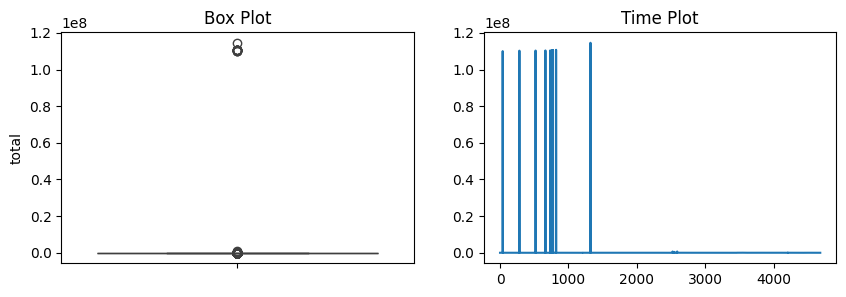

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_jim['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_jim['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_jim['year'] = np.nan
df_jim['month'] = np.nan
df_jim['day'] = np.nan
df_jim['hour'] = np.nan

for i in (df_jim.index):
  df_jim.loc[i, 'year'] = int(df_jim['Date'][i][:4])
  df_jim.loc[i, 'month'] = int(df_jim['Date'][i][5:7])
  df_jim.loc[i, 'day'] = int(df_jim['Date'][i][8:10])
  df_jim.loc[i, 'hour'] = int(df_jim['Date'][i][11:13])

df_jim.head()

Date          vb1   vb1 c         vb2   vb2 c         vb3  \
0  1401/05/30 13:00:00  109749584.0  8609.0  19630573.0  2595.0  82403365.0   
1  1401/05/30 14:00:00  109756690.0  7106.0  19633563.0  2990.0  82403995.0   
2  1401/05/30 15:00:00  109764692.0  8002.0  19636947.0  3384.0  82404681.0   
3  1401/05/30 16:00:00  109772111.0  7419.0  19640038.0  3091.0  82405365.0   
4  1401/05/30 17:00:00  109779465.0  7354.0  19643068.0  3030.0  82406049.0   

   vb3 c  total    year  month   day  hour  
0  517.0  11721  1401.0    5.0  30.0  13.0  
1  630.0  10726  1401.0    5.0  30.0  14.0  
2  686.0  12072  1401.0    5.0  30.0  15.0  
3  684.0  11194  1401.0    5.0  30.0  16.0  
4  684.0  11068  1401.0    5.0  30.0  17.0

In [ ]:
# Jalali to Gregorian

add_gregorian(df_jim)
df_jim.head()

<ipython-input-8-4905f31b75c1>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2022-08-21 13:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()


Date          vb1   vb1 c         vb2   vb2 c         vb3  \
0  1401/05/30 13:00:00  109749584.0  8609.0  19630573.0  2595.0  82403365.0   
1  1401/05/30 14:00:00  109756690.0  7106.0  19633563.0  2990.0  82403995.0   
2  1401/05/30 15:00:00  109764692.0  8002.0  19636947.0  3384.0  82404681.0   
3  1401/05/30 16:00:00  109772111.0  7419.0  19640038.0  3091.0  82405365.0   
4  1401/05/30 17:00:00  109779465.0  7354.0  19643068.0  3030.0  82406049.0   

   vb3 c  total    year  month   day  hour            datetime  
0  517.0  11721  1401.0    5.0  30.0  13.0 2022-08-21 13:00:00  
1  630.0  10726  1401.0    5.0  30.0  14.0 2022-08-21 14:00:00  
2  686.0  12072  1401.0    5.0  30.0  15.0 2022-08-21 15:00:00  
3  684.0  11194  1401.0    5.0  30.0  16.0 2022-08-21 16:00:00  
4  684.0  11068  1401.0    5.0  30.0  17.0 2022-08-21 17:00:00

39 	 110047492.0
283 	 110291987.0
519 	 110356617.0
663 	 110411909.0
733 	 110443178.0
761 	 110500195.0
765 	 110581278.0
768 	 110626657.0
771 	 110626657.0
774 	 110626657.0
819 	 110762834.0
1321 	 114602633.0

Number of Noises1: 12

Number of Noises2: 0

Number of Noises3: 0


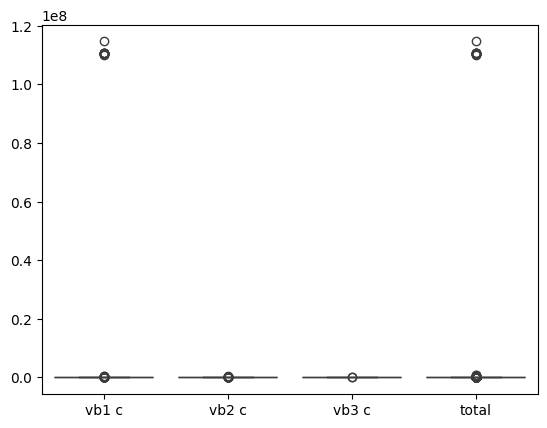

In [ ]:
# Show Noise Data

sns.boxplot(df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']])

noises1 = show_noise(df_jim, 'vb1')
print('\nNumber of Noises1:', len(noises1))
noises2 = show_noise(df_jim, 'vb2')
print('\nNumber of Noises2:', len(noises2))
noises3 = show_noise(df_jim, 'vb3')
print('\nNumber of Noises3:', len(noises3))


<Axes: >

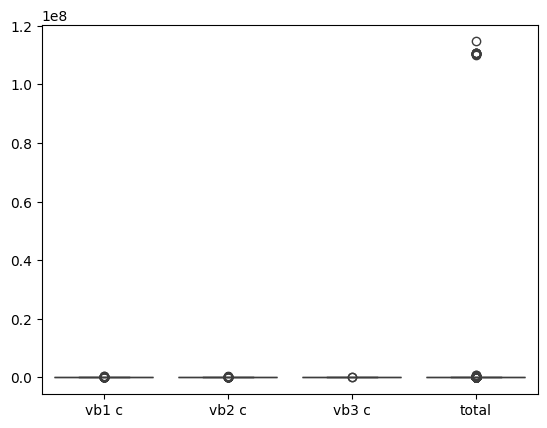

In [ ]:
# Noise Data Handling

df_jim.loc[noises1,'vb1 c'] = np.nan
sns.boxplot(df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']])

Text(0.5, 1.0, 'Time Plot')

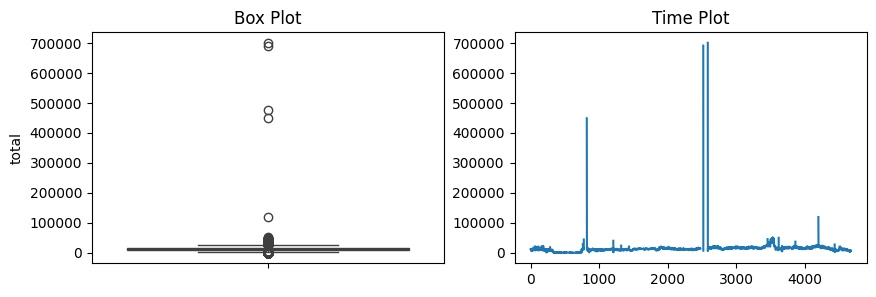

In [ ]:
df_jim['total'] = df_jim['vb1 c'] + df_jim['vb2 c'] + df_jim['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_jim['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_jim['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
# Show Zeros

#df_jim[df_jim['vb1 c']==0]
#df_jim[df_jim['vb2 c']==0]
df_jim[df_jim['vb3 c']==0]

Date          vb1   vb1 c         vb2    vb2 c  \
423   1401/06/17 04:00:00  110312708.0     0.0  21652494.0      0.0   
449   1401/06/18 06:00:00  110319448.0     0.0  21652545.0      0.0   
450   1401/06/18 07:00:00  110319448.0     0.0  21652545.0      0.0   
451   1401/06/18 08:00:00  110319502.0    54.0  21652545.0      0.0   
452   1401/06/18 09:00:00  110319925.0   423.0  21652599.0     54.0   
...                   ...          ...     ...         ...      ...   
4553  1401/12/08 06:00:00  130876468.0  2050.0  38151644.0   8107.0   
4554  1401/12/08 07:00:00  130878945.0  2477.0  38161023.0   9379.0   
4555  1401/12/08 08:00:00  130881631.0  2686.0  38172816.0  11793.0   
4556  1401/12/08 09:00:00  130884126.0  2495.0  38183244.0  10428.0   
4557  1401/12/08 10:00:00  130886059.0  1933.0  38193327.0  10083.0   

              vb3  vb3 c    total    year  month   day  hour  \
423    83442026.0    0.0      0.0  1401.0    6.0  17.0   4.0   
449    83453887.0    0.0      0.0  1401.0    6.0  18.0   6.0   
450    83453887.0    0.0      0.0  1401.0    6.0  18.0   7.0   
451    83453887.0    0.0     54.0  1401.0    6.0  18.0   8.0   
452    83453887.0    0.0    477.0  1401.0    6.0  18.0   9.0   
...           ...    ...      ...     ...    ...   ...   ...   
4553  102409491.0    0.0  10157.0  1401.0   12.0   8.0   6.0   
4554  102409491.0    0.0  11856.0  1401.0   12.0   8.0   7.0   
4555  102409491.0    0.0  14479.0  1401.0   12.0   8.0   8.0   
4556  102409491.0    0.0  12923.0  1401.0   12.0   8.0   9.0   
4557  102409491.0    0.0  12016.0  1401.0   12.0   8.0  10.0   

                datetime  
423  2022-09-08 04:00:00  
449  2022-09-09 06:00:00  
450  2022-09-09 07:00:00  
451  2022-09-09 08:00:00  
452  2022-09-09 09:00:00  
...                  ...  
4553 2023-02-27 06:00:00  
4554 2023-02-27 07:00:00  
4555 2023-02-27 08:00:00  
4556 2023-02-27 09:00:00  
4557 2023-02-27 10:00:00  

[1563 rows x 13 columns]

In [ ]:
# Zeros Handling

nan = [567, 687, 730, 731, 734, 769, 772, 775, 806, 808, 812, 813, 816, 817, 818, 3621, 3622, 4199, 4200, 4201] #[806, 813, 816] != 0
df_jim.loc[nan, 'vb1 c'] = np.nan
df_jim.loc[423, 'vb3 c'] = np.nan

In [ ]:
# Show Missing Data

print(df_jim[df_jim['vb1 c'].isnull()].shape)
print(df_jim[df_jim['vb2 c'].isnull()].shape)
print(df_jim[df_jim['vb3 c'].isnull()].shape)

(171, 13)
(208, 13)
(209, 13)


In [ ]:
# Missing Data Handling

show_missing(df_jim, 'vb1 c')
fill_missing(df_jim, 'vb1 c')

show_missing(df_jim, 'vb2 c')
fill_missing(df_jim, 'vb2 c')

show_missing(df_jim, 'vb3 c')
fill_missing(df_jim, 'vb3 c')

39 	 2 	0 or Next
283 	 2 	0 or Next
519 	 2 	0 or Next
567 	 2 	0 or Next
663 	 2 	0 or Next
687 	 2 	0 or Next
731 	 3 	0 or Next
734 	 3 	0 or Next
761 	 2 	0 or Next
765 	 2 	0 or Next
769 	 3 	0 or Next
772 	 3 	0 or Next
775 	 3 	0 or Next
819 	 42 	0 or Next
1206 	 2 	0 or Next
1321 	 2 	0 or Next
2520 	 42 	0 or Next
2546 	 25 	0 or Next
2586 	 40 	0 or Next
3459 	 2 	0 or Next
3622 	 3 	0 or Next
4201 	 4 	0 or Next (Last One)


14 	 2 	0 or Next
38 	 2 	Next X2
62 	 2 	0 or Next
86 	 2 	0 or Next
110 	 2 	Next X2
158 	 2 	Next X2
182 	 2 	Next X2
206 	 2 	0 or Next
254 	 2 	0 or Next
282 	 2 	Next X2
326 	 2 	Next X2
350 	 2 	Next X2
398 	 2 	0 or Next
446 	 2 	0 or Next
494 	 2 	0 or Next
518 	 2 	0 or Next
590 	 2 	0 or Next
614 	 2 	0 or Next
662 	 2 	0 or Next
686 	 2 	Next X2
710 	 2 	0 or Next
736 	 8 	0 or Next
761 	 11 	0 or Next
764 	 2 	0 or Next
775 	 10 	0 or Next
818 	 41 	Next X2
1206 	 2 	0 or Next
1320 	 2 	0 or Next
1436 	 2 	0 or Next
2520 	 42 	0 or Next
25

In [ ]:
df_jim[['vb1 c', 'vb2 c', 'vb3 c']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4678 entries, 0 to 4677
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vb1 c   4678 non-null   float64
 1   vb2 c   4678 non-null   float64
 2   vb3 c   4678 non-null   float64
dtypes: float64(3)
memory usage: 109.8 KB


Series([], Name: vb1 c, dtype: float64) 

3507    19699.0
3526    19685.0
3529    19491.0
3535    20566.0
3537    20440.0
3542    23217.0
3543    21228.0
3544    22040.0
3545    22523.0
3546    22724.0
3547    23237.0
3548    21951.0
3549    21269.0
3550    21202.0
3552    24424.0
3553    22268.0
3554    23104.0
Name: vb2 c, dtype: float64 

Series([], Name: vb3 c, dtype: float64) 

762      28790.0
776      44317.0
820     448944.0
1207     40092.0
2521    691478.0
          ...   
3554     40889.0
3622     49997.0
3866     37099.0
4202    119436.0
4440     27560.0
Name: total, Length: 71, dtype: float64


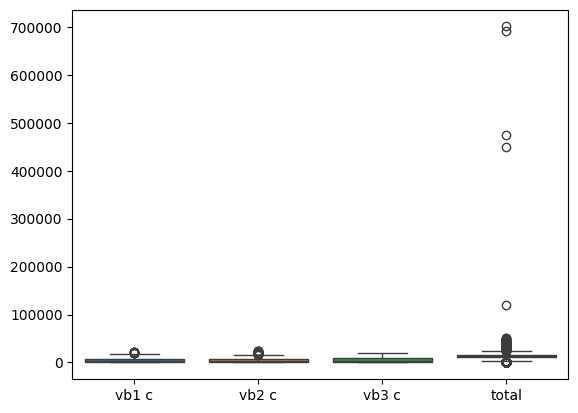

In [ ]:
# Show Outlier Data

sns.boxplot(df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']])
print(show_outlier(df_jim, 'vb1 c'), '\n')
print(show_outlier(df_jim, 'vb2 c'), '\n')
print(show_outlier(df_jim, 'vb3 c'), '\n')
print(show_outlier(df_jim, 'total'))

Text(0.5, 1.0, 'Time Plot')

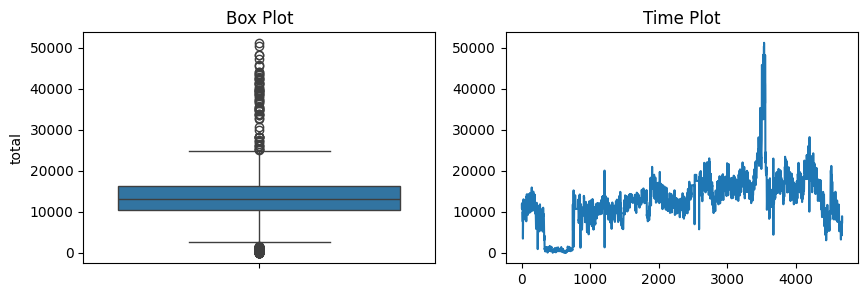

In [ ]:
df_jim['total'] = df_jim['vb1 c'] + df_jim['vb2 c'] + df_jim['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_jim['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_jim['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_jim.drop(['vb1', 'vb2', 'vb3'], axis=1, inplace=True)
df_jim

Date   vb1 c   vb2 c   vb3 c    total    year  month  \
0     1401/05/30 13:00:00  8609.0  2595.0   517.0  11721.0  1401.0    5.0   
1     1401/05/30 14:00:00  7106.0  2990.0   630.0  10726.0  1401.0    5.0   
2     1401/05/30 15:00:00  8002.0  3384.0   686.0  12072.0  1401.0    5.0   
3     1401/05/30 16:00:00  7419.0  3091.0   684.0  11194.0  1401.0    5.0   
4     1401/05/30 17:00:00  7354.0  3030.0   684.0  11068.0  1401.0    5.0   
...                   ...     ...     ...     ...      ...     ...    ...   
4673  1401/12/13 06:00:00     0.0  3905.0  1439.0   5344.0  1401.0   12.0   
4674  1401/12/13 07:00:00     0.0  5474.0  1963.0   7437.0  1401.0   12.0   
4675  1401/12/13 08:00:00     0.0  5021.0  1863.0   6884.0  1401.0   12.0   
4676  1401/12/13 09:00:00     0.0  6578.0  2331.0   8909.0  1401.0   12.0   
4677  1401/12/13 10:00:00     0.0  5552.0  1867.0   7419.0  1401.0   12.0   

       day  hour            datetime  
0     30.0  13.0 2022-08-21 13:00:00  
1     30.0  14.0 2022-08-21 14:00:00  
2     30.0  15.0 2022-08-21 15:00:00  
3     30.0  16.0 2022-08-21 16:00:00  
4     30.0  17.0 2022-08-21 17:00:00  
...    ...   ...                 ...  
4673  13.0   6.0 2023-03-04 06:00:00  
4674  13.0   7.0 2023-03-04 07:00:00  
4675  13.0   8.0 2023-03-04 08:00:00  
4676  13.0   9.0 2023-03-04 09:00:00  
4677  13.0  10.0 2023-03-04 10:00:00  

[4678 rows x 10 columns]

In [ ]:
df_jim.describe()

vb1 c         vb2 c         vb3 c         total    year  \
count   4678.000000   4678.000000   4678.000000   4678.000000  4678.0   
mean    4531.312740   4132.705857   4323.758658  12987.777255  1401.0   
min        0.000000      0.000000      0.000000      0.000000  1401.0   
25%      803.000000    400.250000      0.000000  10496.500000  1401.0   
50%     2512.000000   3540.500000   2730.000000  13140.500000  1401.0   
75%     7774.450000   6582.250000   8687.250000  16295.000000  1401.0   
max    21551.750000  24424.000000  18880.000000  51208.000000  1401.0   
std     4569.023886   3837.902979   4922.439783   6059.337751     0.0   

             month          day         hour             datetime  
count  4678.000000  4678.000000  4678.000000                 4678  
mean      8.684694    15.133177    11.500000  2022-11-26 23:30:00  
min       5.000000     1.000000     0.000000  2022-08-21 13:00:00  
25%       7.000000     7.000000     5.250000  2022-10-09 06:15:00  
50%       9.000000    15.000000    11.500000  2022-11-26 23:30:00  
75%      10.000000    23.000000    17.750000  2023-01-14 16:45:00  
max      12.000000    31.000000    23.000000  2023-03-04 10:00:00  
std       1.888597     8.818169     6.924399                  NaN

<Axes: >

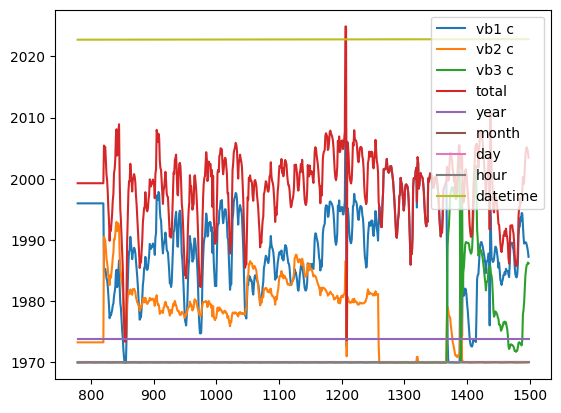

In [ ]:
df_jim[df_jim['month']==7].plot()

<Axes: xlabel='day'>

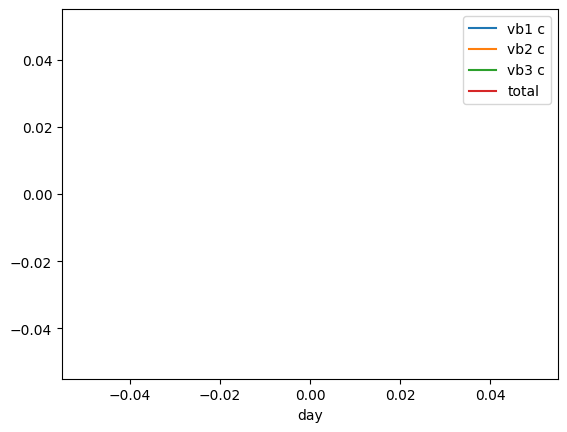

In [ ]:
(df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']][df_jim['month']=='11']).groupby(df_jim['day']).mean().plot()

<Axes: xlabel='month'>

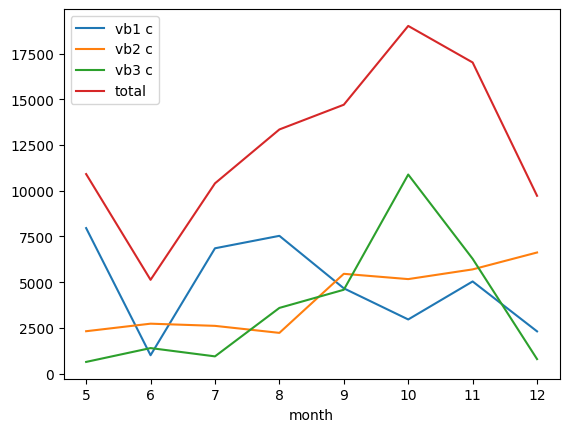

In [ ]:
df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']].groupby(df_jim['month']).mean().plot()

<Axes: xlabel='hour'>

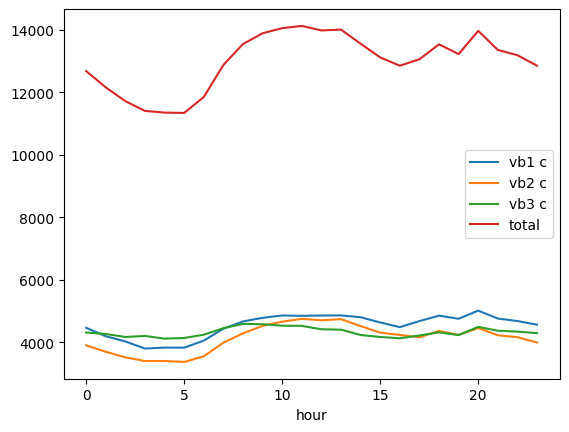

In [ ]:
df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']].groupby(df_jim['hour']).mean().plot()

<Axes: >

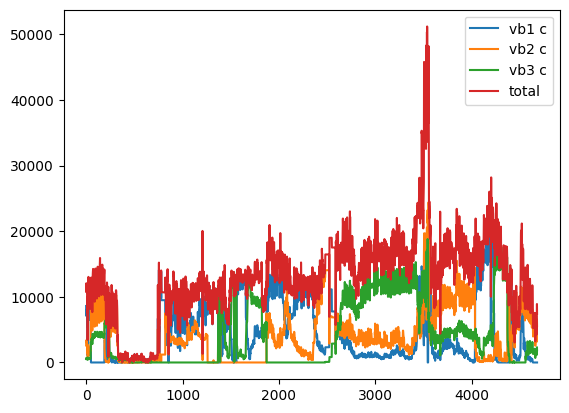

In [ ]:
df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']].plot()

<Axes: >

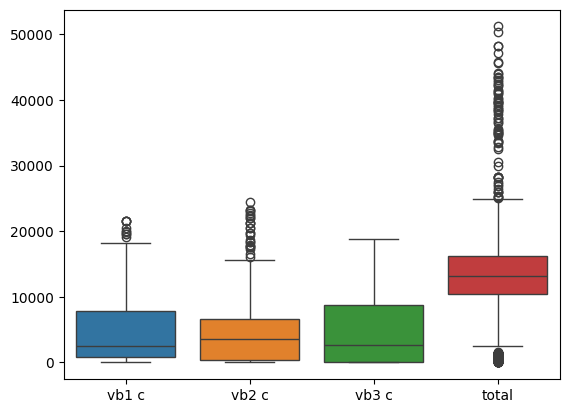

In [ ]:
sns.boxplot(df_jim[['vb1 c', 'vb2 c', 'vb3 c', 'total']])

## Abbas

In [ ]:
df_abbas = pd.read_excel('/content/2 Abbas Abad.xlsx')
print(df_abbas.shape)
df_abbas.head()


(9432, 6)


Date          vb1        vb1 c          vb2        vb2 c  \
0  1400/11/15 11:00:00  508128218.0     135966.0  451824410.0     129731.0   
1  1400/11/15 12:00:00  508265475.0     137257.0  451952049.0     127639.0   
2  1400/11/15 13:00:00  508391362.0     125887.0  452065461.0     113412.0   
3  1400/11/15 14:00:00  508525577.0     134215.0  452189879.0     124418.0   
4  1400/11/15 15:00:00  506652004.0  506652004.0  450296709.0  450296709.0   

       total  
0     265697  
1     264896  
2     239299  
3     258633  
4  956948713

Text(0.5, 1.0, 'Time Plot')

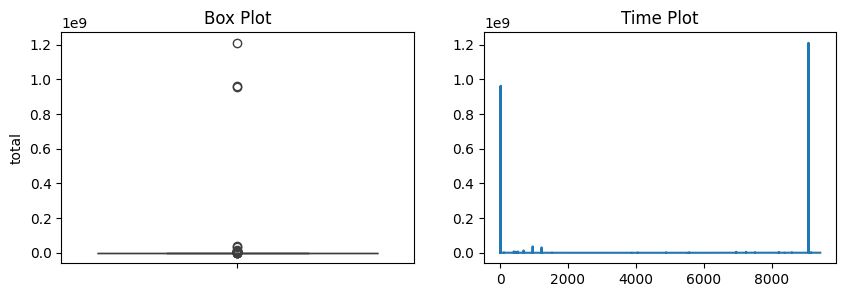

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_abbas['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_abbas['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_abbas['year'] = np.nan
df_abbas['month'] = np.nan
df_abbas['day'] = np.nan
df_abbas['hour'] = np.nan

for i in (df_abbas.index):
  df_abbas.loc[i, 'year'] = (df_abbas['Date'][i][:4])
  df_abbas.loc[i, 'month'] = (df_abbas['Date'][i][5:7])
  df_abbas.loc[i, 'day'] = (df_abbas['Date'][i][8:10])
  df_abbas.loc[i, 'hour'] = (df_abbas['Date'][i][11:13])

df_abbas.head()


<ipython-input-35-c07d1b340947>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1400' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_abbas.loc[i, 'year'] = (df_abbas['Date'][i][:4])
<ipython-input-35-c07d1b340947>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_abbas.loc[i, 'month'] = (df_abbas['Date'][i][5:7])
<ipython-input-35-c07d1b340947>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_abbas.loc[i, 'day'] = (df_abbas['Date'][i][8:10])
<ipython-input-35-c07d1b340947>:10: FutureWarning: Setting an item of incompatible dtype is dep

Date          vb1        vb1 c          vb2        vb2 c  \
0  1400/11/15 11:00:00  508128218.0     135966.0  451824410.0     129731.0   
1  1400/11/15 12:00:00  508265475.0     137257.0  451952049.0     127639.0   
2  1400/11/15 13:00:00  508391362.0     125887.0  452065461.0     113412.0   
3  1400/11/15 14:00:00  508525577.0     134215.0  452189879.0     124418.0   
4  1400/11/15 15:00:00  506652004.0  506652004.0  450296709.0  450296709.0   

       total  year month day hour  
0     265697  1400    11  15   11  
1     264896  1400    11  15   12  
2     239299  1400    11  15   13  
3     258633  1400    11  15   14  
4  956948713  1400    11  15   15

In [ ]:
# Jalali to Gregorian

add_gregorian(df_abbas)
df_abbas.head()

<ipython-input-8-4905f31b75c1>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2022-02-04 11:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()


Date          vb1        vb1 c          vb2        vb2 c  \
0  1400/11/15 11:00:00  508128218.0     135966.0  451824410.0     129731.0   
1  1400/11/15 12:00:00  508265475.0     137257.0  451952049.0     127639.0   
2  1400/11/15 13:00:00  508391362.0     125887.0  452065461.0     113412.0   
3  1400/11/15 14:00:00  508525577.0     134215.0  452189879.0     124418.0   
4  1400/11/15 15:00:00  506652004.0  506652004.0  450296709.0  450296709.0   

       total  year month day hour            datetime  
0     265697  1400    11  15   11 2022-02-04 11:00:00  
1     264896  1400    11  15   12 2022-02-04 12:00:00  
2     239299  1400    11  15   13 2022-02-04 13:00:00  
3     258633  1400    11  15   14 2022-02-04 14:00:00  
4  956948713  1400    11  15   15 2022-02-04 15:00:00

4 	 506652004.0
22 	 509519033.0
9084 	 602762416.0

Number of Noises1: 3
4 	 450296709.0
22 	 453069329.0
9084 	 607386349.0

Number of Noises2: 3


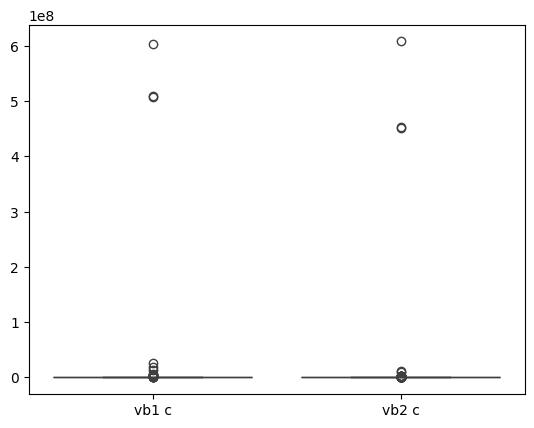

In [ ]:
# Show Noise Data

sns.boxplot(df_abbas[['vb1 c', 'vb2 c']])

noises1 = show_noise(df_abbas, 'vb1', [960])
print('\nNumber of Noises1:', len(noises1))
noises2 = show_noise(df_abbas, 'vb2', [960])
print('\nNumber of Noises2:', len(noises2))


<Axes: >

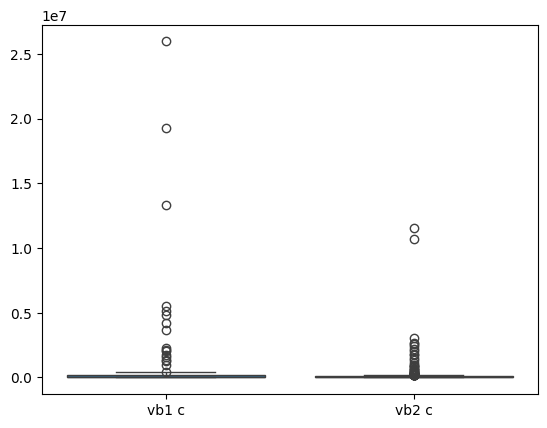

In [ ]:
# Noise Data Handling

df_abbas.loc[noises1, 'vb1 c'] = np.nan
df_abbas.loc[noises2, 'vb2 c'] = np.nan

sns.boxplot(df_abbas[['vb1 c', 'vb2 c']])


Text(0.5, 1.0, 'Time Plot')

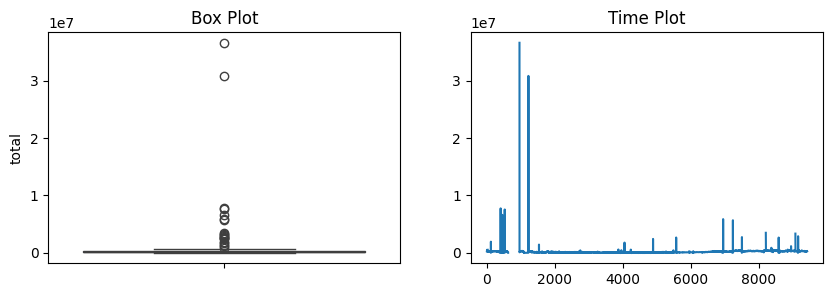

In [ ]:
df_abbas['total'] = df_abbas['vb1 c'] + df_abbas['vb2 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_abbas['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_abbas['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
# Show Zeros

#df_abbas[df_abbas['vb1 c']==0]
df_abbas[df_abbas['vb2 c']==0]


Date          vb1     vb1 c          vb2  vb2 c  \
112   1400/11/20 03:00:00  526828967.0       0.0  462106937.0    0.0   
113   1400/11/20 04:00:00  526828967.0       0.0  462106937.0    0.0   
114   1400/11/20 05:00:00  526828967.0       0.0  462106937.0    0.0   
115   1400/11/20 06:00:00  526828967.0       0.0  462106937.0    0.0   
116   1400/11/20 07:00:00  526828967.0       0.0  462106937.0    0.0   
...                   ...          ...       ...          ...    ...   
9426  1401/12/13 05:00:00  676638811.0  233461.0  633268434.0    0.0   
9427  1401/12/13 06:00:00  676881394.0  242583.0  633268434.0    0.0   
9428  1401/12/13 07:00:00  677134185.0  252791.0  633268434.0    0.0   
9429  1401/12/13 08:00:00  677396993.0  262808.0  633268434.0    0.0   
9430  1401/12/13 09:00:00  677640195.0  243202.0  633268434.0    0.0   

         total  year month day hour            datetime  
112        0.0  1400    11  20   03 2022-02-09 03:00:00  
113        0.0  1400    11  20   04 2022-02-09 04:00:00  
114        0.0  1400    11  20   05 2022-02-09 05:00:00  
115        0.0  1400    11  20   06 2022-02-09 06:00:00  
116        0.0  1400    11  20   07 2022-02-09 07:00:00  
...        ...   ...   ...  ..  ...                 ...  
9426  233461.0  1401    12  13   05 2023-03-04 05:00:00  
9427  242583.0  1401    12  13   06 2023-03-04 06:00:00  
9428  252791.0  1401    12  13   07 2023-03-04 07:00:00  
9429  262808.0  1401    12  13   08 2023-03-04 08:00:00  
9430  243202.0  1401    12  13   09 2023-03-04 09:00:00  

[564 rows x 11 columns]

In [ ]:
# Zeros Handling

nan11 = df_abbas[df_abbas['vb1 c']==0][:337].index
nan12 = df_abbas[df_abbas['vb1 c']==0][4014:].index

df_abbas.loc[nan11, 'vb1 c'] = np.nan
df_abbas.loc[nan12, 'vb1 c'] = np.nan

nan21 = df_abbas[df_abbas['vb2 c']==0][:6].index
nan22 = df_abbas[df_abbas['vb2 c']==0][23:291].index
nan23 = df_abbas[df_abbas['vb2 c']==0][362:412].index
nan24 = df_abbas[df_abbas['vb2 c']==0][420:551].index

df_abbas.loc[nan21, 'vb2 c'] = np.nan
df_abbas.loc[nan22, 'vb2 c'] = np.nan
df_abbas.loc[nan23, 'vb2 c'] = np.nan
df_abbas.loc[nan24, 'vb2 c'] = np.nan


In [ ]:
# Show Missing Data

print(df_abbas['vb1 c'].isnull().sum())
print(df_abbas['vb2 c'].isnull().sum())

659
1038


In [ ]:
df_abbas.loc[4458, 'vb2 c'] = (df_abbas.loc[4457, 'vb2 c']+df_abbas.loc[4459, 'vb2 c'])/2
df_abbas.loc[4947, 'vb2 c'] = (df_abbas.loc[4946, 'vb2 c']+df_abbas.loc[4948, 'vb2 c'])/2
df_abbas.loc[6340, 'vb2 c'] = (.75*df_abbas.loc[6339, 'vb2 c']) + (.25*df_abbas.loc[6342, 'vb2 c'])
df_abbas.loc[6341, 'vb2 c'] = (.25*df_abbas.loc[6339, 'vb2 c']) + (.75*df_abbas.loc[6342, 'vb2 c'])


In [ ]:
# Missing Data Handling

show_missing(df_abbas, 'vb1 c')
fill_missing(df_abbas, 'vb1 c')

show_missing(df_abbas, 'vb2 c')
fill_missing(df_abbas, 'vb2 c')

4 	 2 	0 or Next
22 	 2 	0 or Next
117 	 7 	0 or Next
404 	 33 	0 or Next
452 	 25 	0 or Next
478 	 12 	0 or Next
524 	 33 	0 or Next
692 	 84 	0 or Next
959 	 193 	0 or Next
1222 	 138 	0 or Next
1533 	 14 	0 or Next
5544 	 39 	0 or Next
5960 	 2 	0 or Next
6956 	 29 	0 or Next
7244 	 22 	0 or Next
7510 	 8 	0 or Next
8200 	 6 	Next X2
8213 	 2 	0 or Next
8592 	 8 	0 or Next
9084 	 11 	0 or Next
9164 	 10 	0 or Next (Last One)


4 	 2 	0 or Next
22 	 2 	0 or Next
117 	 7 	0 or Next
404 	 33 	0 or Next
452 	 25 	0 or Next
478 	 12 	0 or Next
524 	 33 	0 or Next
959 	 351 	0 or Next
1222 	 138 	0 or Next
1533 	 14 	0 or Next
1620 	 4 	Next X2
1792 	 2 	0 or Next
1888 	 2 	0 or Next
1912 	 2 	0 or Next
1936 	 2 	0 or Next
1960 	 2 	0 or Next
1984 	 2 	0 or Next
2008 	 2 	0 or Next
2028 	 3 	Next X2
2056 	 2 	0 or Next
2080 	 2 	0 or Next
2104 	 2 	0 or Next
2124 	 5 	Next X2
2128 	 2 	0 or Next
2152 	 2 	0 or Next
2179 	 2 	0 or Next
2224 	 2 	0 or Next
2248 	 2 	0 or Next
2296 	 2 	0 or

In [ ]:
df_abbas[['vb1 c', 'vb2 c']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9432 entries, 0 to 9431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vb1 c   9432 non-null   float64
 1   vb2 c   9432 non-null   float64
dtypes: float64(2)
memory usage: 147.5 KB


Series([], Name: vb1 c, dtype: float64) 

8313    197800.0
8314    223789.0
8315    205932.0
Name: vb2 c, dtype: float64


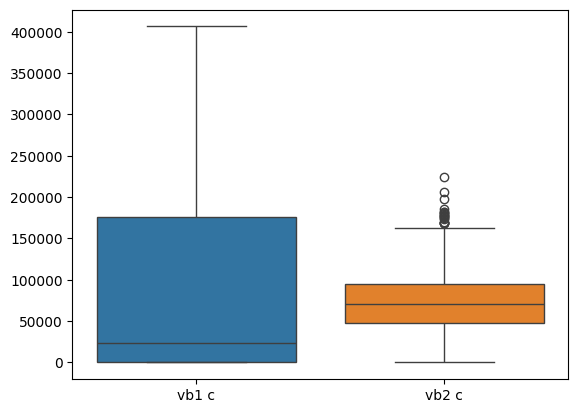

In [ ]:
# Show Outlier Data

sns.boxplot(df_abbas[['vb1 c', 'vb2 c']])
print(show_outlier(df_abbas, 'vb1 c'), '\n')
print(show_outlier(df_abbas, 'vb2 c'))


Text(0.5, 1.0, 'Time Plot')

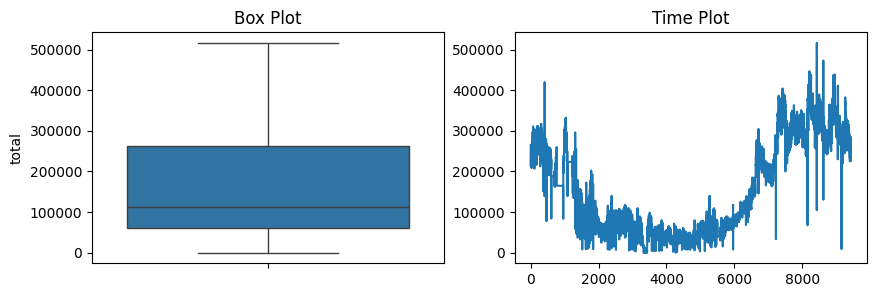

In [ ]:
df_abbas['total'] = df_abbas['vb1 c'] + df_abbas['vb2 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_abbas['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_abbas['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_abbas.drop(['vb1', 'vb2'], axis=1, inplace=True)

In [ ]:
df_abbas.describe()

vb1 c          vb2 c          total             datetime
count    9432.000000    9432.000000    9432.000000                 9432
mean    86010.055556   72289.795696  158299.851251  2022-08-19 22:30:00
min         0.000000       0.000000       0.000000  2022-02-04 11:00:00
25%         0.000000   47979.000000   60782.000000  2022-05-13 16:45:00
50%     23869.500000   70585.000000  113040.500000  2022-08-19 22:30:00
75%    175666.500000   94648.500000  261672.750000  2022-11-26 04:15:00
max    406425.000000  223789.000000  516730.000000  2023-03-04 10:00:00
std     90739.207137   31888.835462  109926.010202                  NaN

<Axes: >

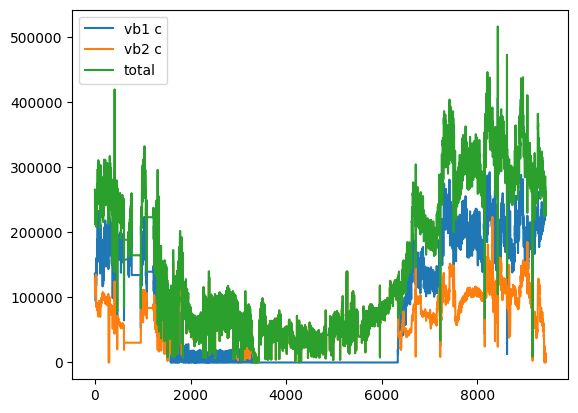

In [ ]:
df_abbas[['vb1 c', 'vb2 c', 'total']].plot()

<Axes: >

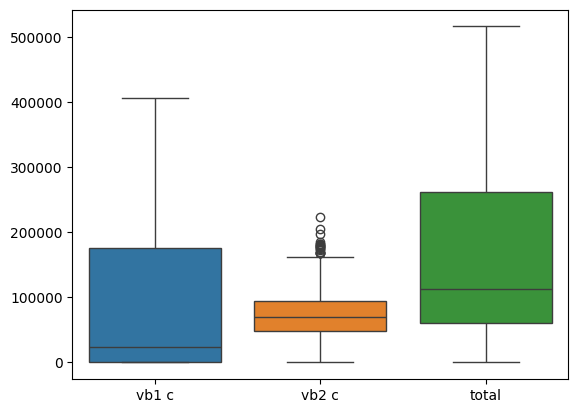

In [ ]:
sns.boxplot(df_abbas[['vb1 c', 'vb2 c', 'total']])

<Axes: >

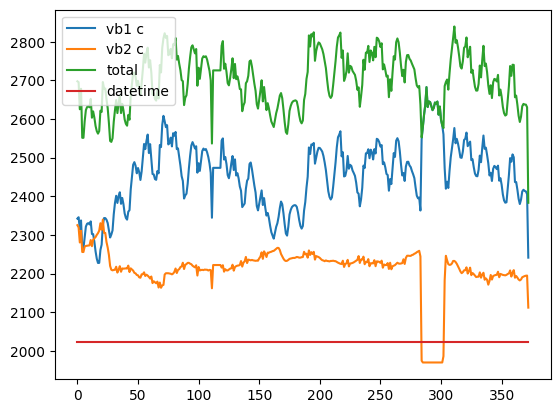

In [ ]:
df_abbas[(df_abbas['year']=='1400') & (df_abbas['month']=='11')].plot()

In [ ]:
for i in range(1400, 1402):
  for j in range(1, 13):
    print('year=', i, 'month=', j)
    print(show_outlier(df_abbas[(df_abbas['month']==j) & (df_abbas['year']==i)], 'vb1 c', 2), '\n')



year= 1400 month= 1
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 2
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 3
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 4
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 5
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 6
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 7
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 8
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 9
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 10
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 11
Series([], Name: vb1 c, dtype: float64) 

year= 1400 month= 12
Series([], Name: vb1 c, dtype: float64) 

year= 1401 month= 1
Series([], Name: vb1 c, dtype: float64) 

year= 1401 month= 2
Series([], Name: vb1 c, dtype: float64) 

year= 1401 month= 3
Series([], Name: vb1 c, dtype: float64) 

year= 1401 month= 4
Series([], Name: vb1 c, dtype: float64) 

year=

## Siman

In [ ]:
df_siman = pd.read_excel('/content/3 Siman.xlsx')
print(df_siman.shape)
df_siman.head()


(10624, 10)


Date        vb1  vb1 c        vb2  vb2 c        vb3  vb3 c  \
0  1400/07/25 16:00:00  214415270   7176  124403154      0  174406074  13595   
1  1400/07/25 17:00:00  214423469   8199  124403154      0  174421125  15051   
2  1400/07/25 18:00:00  214431653   8184  124403154      0  174434951  13826   
3  1400/07/25 19:00:00  214439834   8181  124403154      0  174448547  13596   
4  1400/07/25 20:00:00  214447996   8162  124403154      0  174461937  13390   

   total  Unnamed: 8 Unnamed: 9  
0  20771         NaN        NaN  
1  23250         NaN        NaN  
2  22010         NaN        NaN  
3  21777         NaN        NaN  
4  21552         NaN        NaN

Text(0.5, 1.0, 'Time Plot')

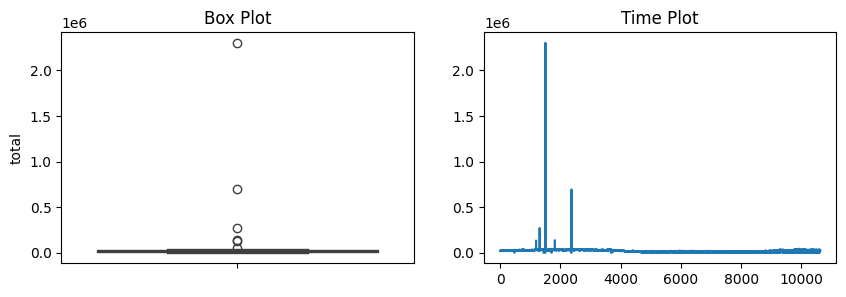

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_siman['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_siman['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_siman['year'] = np.nan
df_siman['month'] = np.nan
df_siman['day'] = np.nan
df_siman['hour'] = np.nan

for i in (df_siman.index):
  df_siman.loc[i, 'year'] = int(df_siman['Date'][i][:4])
  df_siman.loc[i, 'month'] = int(df_siman['Date'][i][5:7])
  df_siman.loc[i, 'day'] = int(df_siman['Date'][i][8:10])
  df_siman.loc[i, 'hour'] = int(df_siman['Date'][i][11:13])

df_siman.head()


Date        vb1  vb1 c        vb2  vb2 c        vb3  vb3 c  \
0  1400/07/25 16:00:00  214415270   7176  124403154      0  174406074  13595   
1  1400/07/25 17:00:00  214423469   8199  124403154      0  174421125  15051   
2  1400/07/25 18:00:00  214431653   8184  124403154      0  174434951  13826   
3  1400/07/25 19:00:00  214439834   8181  124403154      0  174448547  13596   
4  1400/07/25 20:00:00  214447996   8162  124403154      0  174461937  13390   

   total  Unnamed: 8 Unnamed: 9    year  month   day  hour  
0  20771         NaN        NaN  1400.0    7.0  25.0  16.0  
1  23250         NaN        NaN  1400.0    7.0  25.0  17.0  
2  22010         NaN        NaN  1400.0    7.0  25.0  18.0  
3  21777         NaN        NaN  1400.0    7.0  25.0  19.0  
4  21552         NaN        NaN  1400.0    7.0  25.0  20.0

In [ ]:
# Jalali to Gregorian

add_gregorian(df_siman)
df_siman.head()

<ipython-input-8-4905f31b75c1>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2021-10-17 16:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()


Date        vb1  vb1 c        vb2  vb2 c        vb3  vb3 c  \
0  1400/07/25 16:00:00  214415270   7176  124403154      0  174406074  13595   
1  1400/07/25 17:00:00  214423469   8199  124403154      0  174421125  15051   
2  1400/07/25 18:00:00  214431653   8184  124403154      0  174434951  13826   
3  1400/07/25 19:00:00  214439834   8181  124403154      0  174448547  13596   
4  1400/07/25 20:00:00  214447996   8162  124403154      0  174461937  13390   

   total  Unnamed: 8 Unnamed: 9    year  month   day  hour            datetime  
0  20771         NaN        NaN  1400.0    7.0  25.0  16.0 2021-10-17 16:00:00  
1  23250         NaN        NaN  1400.0    7.0  25.0  17.0 2021-10-17 17:00:00  
2  22010         NaN        NaN  1400.0    7.0  25.0  18.0 2021-10-17 18:00:00  
3  21777         NaN        NaN  1400.0    7.0  25.0  19.0 2021-10-17 19:00:00  
4  21552         NaN        NaN  1400.0    7.0  25.0  20.0 2021-10-17 20:00:00

475 	 0
478 	 0
1437 	 0
2351 	 0
3680 	 0
4680 	 0
4701 	 0
4725 	 0
4728 	 0
4760 	 0
4788 	 0
4800 	 0
4827 	 0
4839 	 0
4844 	 0
4851 	 0
4890 	 0
4929 	 0
4936 	 0
4941 	 0
4976 	 0
4988 	 0
5008 	 0
5012 	 0
5028 	 0
5039 	 0
5058 	 0
5079 	 0
5106 	 0
5118 	 0
5130 	 0
5153 	 0
5165 	 0
5193 	 0
5204 	 0
5232 	 0
5259 	 0
5279 	 0
5295 	 0
5318 	 0
5365 	 0
5377 	 0
5389 	 0
5392 	 0
5428 	 0
5440 	 0
5467 	 0
5479 	 0
5507 	 0
5546 	 0
5585 	 0
5597 	 0
5625 	 0
5652 	 0
5731 	 0
5759 	 0
5786 	 0
5798 	 0
5837 	 0
5849 	 0
5876 	 0
5888 	 0
5896 	 0
5900 	 0
5902 	 0
5904 	 0
5921 	 0
5925 	 0
5947 	 0
5964 	 0
5991 	 0
6031 	 0
6054 	 0
6082 	 0
6092 	 0
6109 	 0
6121 	 0
6188 	 0
6216 	 0
6227 	 0
6255 	 0
6294 	 0
6322 	 0
6350 	 0
6361 	 0
6400 	 0
6428 	 0
6440 	 0
6479 	 0
6491 	 0
6498 	 0
6503 	 0
6581 	 0
6609 	 0
6621 	 0
6676 	 0
6715 	 0
6718 	 0
6736 	 0
6760 	 0
6766 	 0
6784 	 0
6794 	 0
6806 	 0
6833 	 0
6869 	 0
6911 	 0
6939 	 0
6966 	 0
6978 	 0
7005 	 0
702

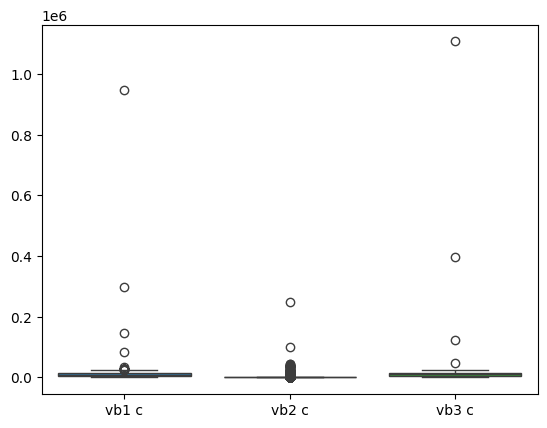

In [ ]:
# Show Noise Data

sns.boxplot(df_siman[['vb1 c', 'vb2 c', 'vb3 c']])

noises1 = show_noise(df_siman, 'vb1')
print('\nNumber of Noises1:', len(noises1))
noises2 = show_noise(df_siman, 'vb2')
print('\nNumber of Noises2:', len(noises2))
noises3 = show_noise(df_siman, 'vb3')
print('\nNumber of Noises3:', len(noises3))


<Axes: >

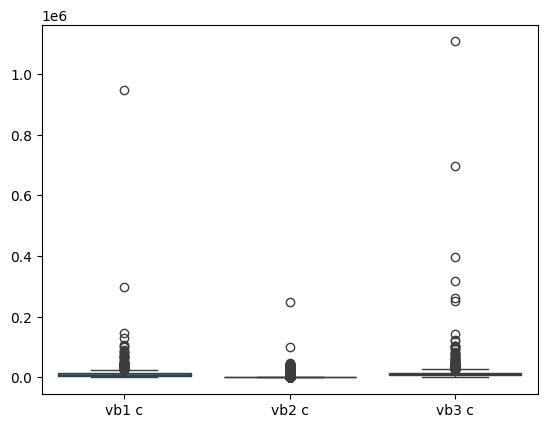

In [ ]:
# Noise Data Handling

j = 0
for i in range(df_siman.shape[0]-1):
  if i == df_siman.shape[0]-1:
    break
  if df_siman.loc[i, 'vb1'] == 0:
    j += 1
  if df_siman.loc[i+1, 'vb1'] != 0:
    df_siman.loc[i+1, 'vb1 c'] = df_siman.loc[i+1, 'vb1'] - df_siman.loc[i-j+1, 'vb1']
    j = 1

j = 0
for i in range(df_siman.shape[0]-1):
  if i == df_siman.shape[0]-1:
    break
  if df_siman.loc[i, 'vb2'] == 0:
    j += 1
  if df_siman.loc[i+1, 'vb2'] != 0:
    df_siman.loc[i+1, 'vb2 c'] = df_siman.loc[i+1, 'vb2'] - df_siman.loc[i-j+1, 'vb2']
    j = 1

j = 0
for i in range(df_siman.shape[0]-1):
  if i == df_siman.shape[0]-1:
    break
  if df_siman.loc[i, 'vb3'] == 0:
    j += 1
  if df_siman.loc[i+1, 'vb3'] != 0:
    df_siman.loc[i+1, 'vb3 c'] = df_siman.loc[i+1, 'vb3'] - df_siman.loc[i-j+1, 'vb3']
    j = 1

df_siman.loc[1, ['vb1 c', 'vb2 c', 'vb3 c']] = [8199, 0, 15051]

sns.boxplot(df_siman[['vb1 c', 'vb2 c', 'vb3 c']])

Text(0.5, 1.0, 'Time Plot')

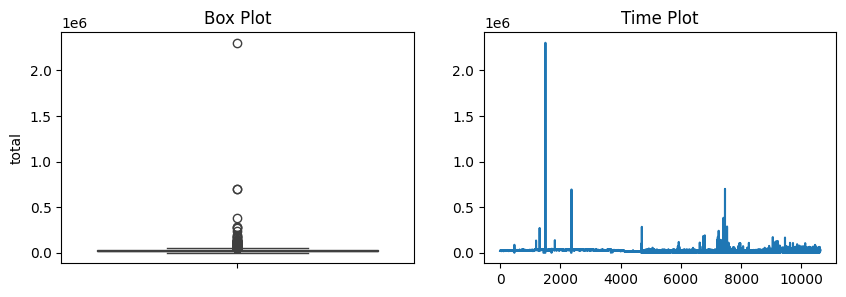

In [ ]:
df_siman['total'] = df_siman['vb1 c'] + df_siman['vb2 c'] + df_siman['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_siman['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_siman['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
# Show Zeros

#df_siman[df_siman['vb1 c']==0]
#df_siman[df_siman['vb2 c']==0]
df_siman[df_siman['vb3 c']==0]

Date        vb1  vb1 c        vb2  vb2 c  vb3  vb3 c  \
475    1400/08/15 11:00:00          0      0          0      0    0      0   
476    1400/08/15 12:00:00          0      0          0      0    0      0   
478    1400/08/15 14:00:00          0      0          0      0    0      0   
1437   1400/09/25 13:00:00          0      0          0      0    0      0   
1438   1400/09/25 14:00:00          0      0          0      0    0      0   
...                    ...        ...    ...        ...    ...  ...    ...   
10597  1401/10/12 05:00:00          0      0          0      0    0      0   
10599  1401/10/12 07:00:00          0      0          0      0    0      0   
10605  1401/10/12 13:00:00  320366427   9228  135456184  11317    0      0   
10609  1401/10/12 17:00:00  320400661   8631          0      0    0      0   
10620  1401/10/13 04:00:00  320491270   7848  135577286   5025    0      0   

       total  Unnamed: 8 Unnamed: 9    year  month   day  hour  \
475        0         NaN        NaN  1400.0    8.0  15.0  11.0   
476        0         NaN        NaN  1400.0    8.0  15.0  12.0   
478        0         NaN        NaN  1400.0    8.0  15.0  14.0   
1437       0         NaN        NaN  1400.0    9.0  25.0  13.0   
1438       0         NaN        NaN  1400.0    9.0  25.0  14.0   
...      ...         ...        ...     ...    ...   ...   ...   
10597      0         NaN        NaN  1401.0   10.0  12.0   5.0   
10599      0         NaN        NaN  1401.0   10.0  12.0   7.0   
10605  20545         NaN        NaN  1401.0   10.0  12.0  13.0   
10609   8631         NaN        NaN  1401.0   10.0  12.0  17.0   
10620  12873         NaN        NaN  1401.0   10.0  13.0   4.0   

                 datetime  
475   2021-11-06 11:00:00  
476   2021-11-06 12:00:00  
478   2021-11-06 14:00:00  
1437  2021-12-16 13:00:00  
1438  2021-12-16 14:00:00  
...                   ...  
10597 2023-01-02 05:00:00  
10599 2023-01-02 07:00:00  
10605 2023-01-02 13:00:00  
10609 2023-01-02 17:00:00  
10620 2023-01-03 04:00:00  

[1225 rows x 15 columns]

In [ ]:
# Zeros Handling

nan11 = df_siman[df_siman['vb1 c']==0][:72].index
nan12 = df_siman[df_siman['vb1 c']==0][90:].index

nan21 = df_siman[df_siman['vb2 c']==0][967:1036].index
nan22 = df_siman[df_siman['vb2 c']==0][1130:1199].index
nan23 = df_siman[df_siman['vb2 c']==0][9088:-2].index

nan31 = df_siman[df_siman['vb3 c']==0][:72].index
nan32 = df_siman[df_siman['vb3 c']==0][90:].index

df_siman.loc[nan11, 'vb1 c'] = np.nan
df_siman.loc[nan12, 'vb1 c'] = np.nan

df_siman.loc[nan21, 'vb2 c'] = np.nan
df_siman.loc[nan22, 'vb2 c'] = np.nan
df_siman.loc[nan23, 'vb2 c'] = np.nan

df_siman.loc[nan31, 'vb3 c'] = np.nan
df_siman.loc[nan32, 'vb3 c'] = np.nan

df_siman.loc[[1196, 1314], ['vb1 c', 'vb3 c']] = np.nan

In [ ]:
# Show Missing Data

print(df_siman[df_siman['vb1 c'].isnull()].shape)
print(df_siman[df_siman['vb2 c'].isnull()].shape)
print(df_siman[df_siman['vb3 c'].isnull()].shape)

(784, 15)
(235, 15)
(1209, 15)


In [ ]:
df_siman.loc[1196, 'vb2 c'] = (df_siman.loc[1195, 'vb2 c']+df_siman.loc[1197, 'vb2 c'])/2
df_siman.loc[1314, 'vb2 c'] = (df_siman.loc[1313, 'vb2 c']+df_siman.loc[1315, 'vb2 c'])/2
df_siman.loc[3680, 'vb2 c'] = (df_siman.loc[3679, 'vb2 c']+df_siman.loc[3681, 'vb2 c'])/2

In [ ]:
# Missing Data Handling

show_missing(df_siman, 'vb1 c')
fill_missing(df_siman, 'vb1 c')

show_missing(df_siman, 'vb2 c')
fill_missing(df_siman, 'vb2 c')

show_missing(df_siman, 'vb3 c')
fill_missing(df_siman, 'vb3 c')

476 	 3 	0 or Next
478 	 2 	0 or Next
1196 	 2 	Next X2
1314 	 2 	Next X2
1505 	 70 	0 or Next
2370 	 21 	0 or Next
3680 	 2 	Next X2
4699 	 21 	0 or Next
4703 	 4 	0 or Next
4725 	 2 	0 or Next
4728 	 2 	0 or Next
4760 	 2 	0 or Next
4788 	 2 	0 or Next
4800 	 2 	0 or Next
4827 	 2 	0 or Next
4839 	 2 	0 or Next
4844 	 2 	0 or Next
4851 	 2 	0 or Next
4890 	 2 	0 or Next
4929 	 2 	0 or Next
4936 	 2 	0 or Next
4941 	 2 	0 or Next
4976 	 2 	0 or Next
4988 	 2 	0 or Next
5008 	 2 	0 or Next
5012 	 2 	0 or Next
5028 	 2 	0 or Next
5039 	 2 	0 or Next
5059 	 3 	0 or Next
5079 	 2 	0 or Next
5106 	 2 	0 or Next
5118 	 2 	0 or Next
5130 	 2 	0 or Next
5153 	 2 	0 or Next
5165 	 2 	0 or Next
5193 	 2 	0 or Next
5204 	 2 	0 or Next
5232 	 2 	0 or Next
5259 	 2 	0 or Next
5279 	 2 	0 or Next
5295 	 2 	0 or Next
5318 	 2 	0 or Next
5365 	 2 	0 or Next
5377 	 2 	0 or Next
5389 	 2 	0 or Next
5392 	 2 	0 or Next
5428 	 2 	0 or Next
5440 	 2 	0 or Next
5467 	 2 	0 or Next
5479 	 2 	0 or Next
5507 

In [ ]:
df_siman[['vb1 c', 'vb2 c', 'vb3 c']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10624 entries, 0 to 10623
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vb1 c   10624 non-null  float64
 1   vb2 c   10624 non-null  float64
 2   vb3 c   10624 non-null  float64
dtypes: float64(3)
memory usage: 249.1 KB


9831    29199.0
9834    33238.0
Name: vb1 c, dtype: float64 

96          33.0
97          66.0
98          97.0
99          64.0
100         65.0
          ...   
10617     7225.0
10620     5025.0
10621     9615.0
10622    10031.0
10623    10460.0
Name: vb2 c, Length: 1672, dtype: float64 

Series([], Name: vb3 c, dtype: float64)


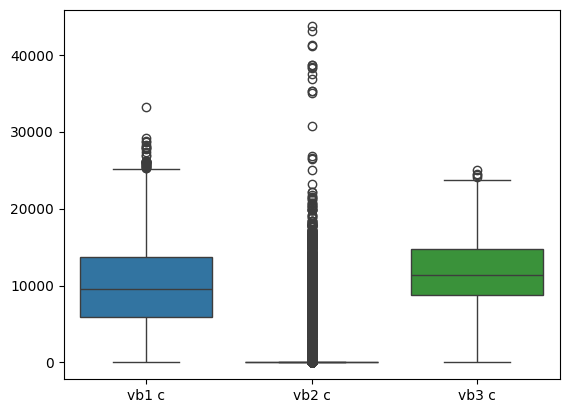

In [ ]:
# Show Outlier Data

sns.boxplot(df_siman[['vb1 c', 'vb2 c', 'vb3 c']])
print(show_outlier(df_siman, 'vb1 c'), '\n')
print(show_outlier(df_siman, 'vb2 c'), '\n')
print(show_outlier(df_siman, 'vb3 c'))

In [ ]:
df_siman.loc[1522, 'vb2 c'] = df_siman.loc[1522, 'vb2 c']/2

df_siman['total'] = df_siman['vb1 c'] + df_siman['vb2 c'] + df_siman['vb3 c']

Text(0.5, 1.0, 'Time Plot')

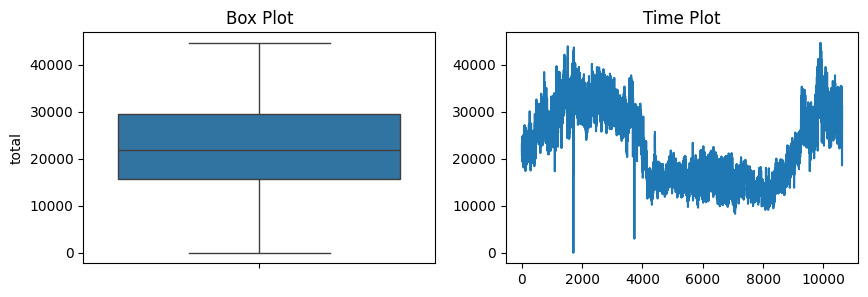

In [ ]:
df_siman['total'] = df_siman['vb1 c'] + df_siman['vb2 c'] + df_siman['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_siman['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_siman['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_siman.drop(['vb1', 'vb2', 'vb3'], axis=1, inplace=True)

In [ ]:
df_siman.describe()

vb1 c         vb2 c         vb3 c         total  Unnamed: 8  \
count  10624.000000  10624.000000  10624.000000  10624.000000         0.0   
mean    9965.829631   1053.316971  11603.001977  22622.148579         NaN   
min        0.000000      0.000000      0.000000      0.000000         NaN   
25%     5950.000000      0.000000   8723.750000  15698.000000         NaN   
50%     9538.500000      0.000000  11341.500000  21771.500000         NaN   
75%    13652.500000      0.000000  14807.250000  29439.250000         NaN   
max    33238.000000  43672.000000  24988.000000  44652.000000         NaN   
std     4982.914627   3446.792153   4312.498668   7599.173256         NaN   

               year         month           day          hour  \
count  10624.000000  10624.000000  10624.000000  10624.000000   
mean    1400.651355      6.821536     15.579819     11.500000   
min     1400.000000      1.000000      1.000000      0.000000   
25%     1400.000000      4.000000      8.000000      5.000000   
50%     1401.000000      7.500000     15.000000     11.500000   
75%     1401.000000      9.000000     23.000000     18.000000   
max     1401.000000     12.000000     31.000000     23.000000   
std        0.476564      3.256138      8.845448      6.924833   

                  datetime  
count                10624  
mean   2022-05-26 23:30:00  
min    2021-10-17 16:00:00  
25%    2022-02-05 07:45:00  
50%    2022-05-26 23:30:00  
75%    2022-09-14 15:15:00  
max    2023-01-03 07:00:00  
std                    NaN

<Axes: >

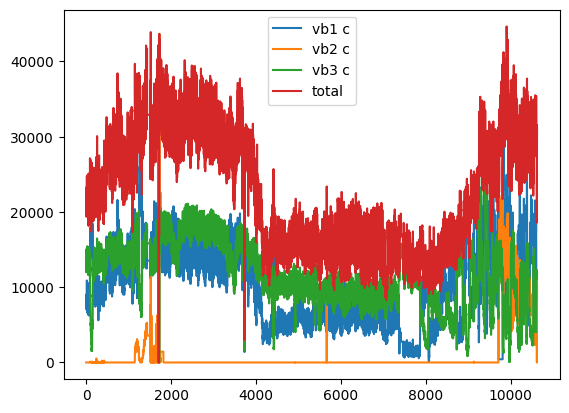

In [ ]:
df_siman[['vb1 c', 'vb2 c', 'vb3 c', 'total']].plot()

<Axes: >

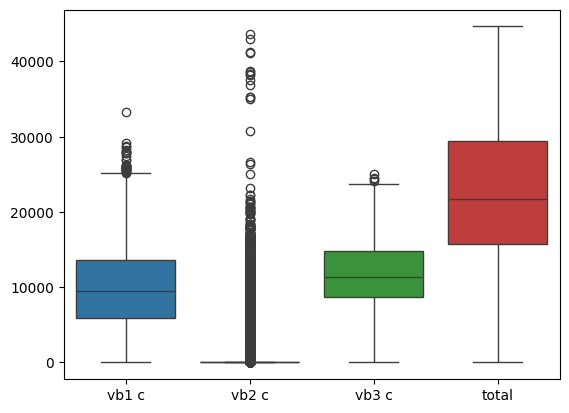

In [ ]:
sns.boxplot(df_siman[['vb1 c', 'vb2 c', 'vb3 c', 'total']])

## Kalat

In [ ]:
df_kalat = pd.read_excel('/content/4 Kalat.xlsx')
print(df_kalat.shape)
df_kalat.head()


(2090, 12)


Date        1vb1   1vb1 c        1vb2   1vb2 c        1vb3  \
0  1401/09/16 10:00:00  88198353.0   2453.0  92984676.0   2464.0  56917005.0   
1  1401/09/16 11:00:00  88244053.0  45700.0  92998637.0  13961.0  56955639.0   
2  1401/09/16 12:00:00  88289149.0  45096.0  93019209.0  20572.0  57014074.0   
3  1401/09/16 13:00:00  88335368.0  46219.0  93040338.0  21129.0  57055867.0   
4  1401/09/16 14:00:00  88380695.0  45327.0  93059038.0  18700.0  57069482.0   

    1vb3 c        2vb1  2vb1 c        2vb2   2vb2 c   total  
0  33353.0  92574898.0     0.0  21271275.0  26436.0   64706  
1  38634.0  92574898.0     0.0  21302167.0  30892.0  129187  
2  58435.0  92574898.0     0.0  21351253.0  49086.0  173189  
3  41793.0  92574898.0     0.0  21392425.0  41172.0  150313  
4  13615.0  92574898.0     0.0  21419891.0  27466.0  105108

Text(0.5, 1.0, 'Time Plot')

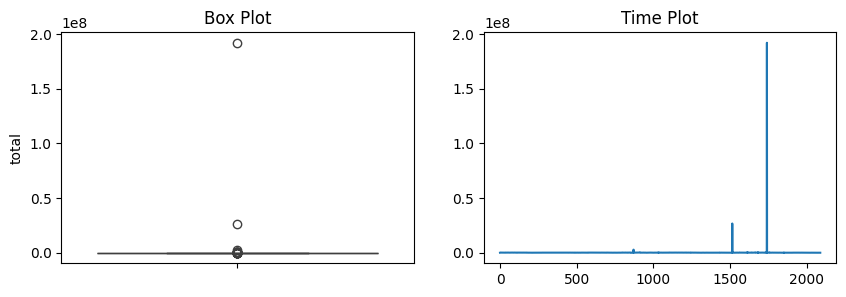

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_kalat['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_kalat['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_kalat['year'] = np.nan
df_kalat['month'] = np.nan
df_kalat['day'] = np.nan
df_kalat['hour'] = np.nan

for i in (df_kalat.index):
  df_kalat.loc[i, 'year'] = int(df_kalat['Date'][i][:4])
  df_kalat.loc[i, 'month'] = int(df_kalat['Date'][i][5:7])
  df_kalat.loc[i, 'day'] = int(df_kalat['Date'][i][8:10])
  df_kalat.loc[i, 'hour'] = int(df_kalat['Date'][i][11:13])

df_kalat.head()


Date        1vb1   1vb1 c        1vb2   1vb2 c        1vb3  \
0  1401/09/16 10:00:00  88198353.0   2453.0  92984676.0   2464.0  56917005.0   
1  1401/09/16 11:00:00  88244053.0  45700.0  92998637.0  13961.0  56955639.0   
2  1401/09/16 12:00:00  88289149.0  45096.0  93019209.0  20572.0  57014074.0   
3  1401/09/16 13:00:00  88335368.0  46219.0  93040338.0  21129.0  57055867.0   
4  1401/09/16 14:00:00  88380695.0  45327.0  93059038.0  18700.0  57069482.0   

    1vb3 c        2vb1  2vb1 c        2vb2   2vb2 c   total    year  month  \
0  33353.0  92574898.0     0.0  21271275.0  26436.0   64706  1401.0    9.0   
1  38634.0  92574898.0     0.0  21302167.0  30892.0  129187  1401.0    9.0   
2  58435.0  92574898.0     0.0  21351253.0  49086.0  173189  1401.0    9.0   
3  41793.0  92574898.0     0.0  21392425.0  41172.0  150313  1401.0    9.0   
4  13615.0  92574898.0     0.0  21419891.0  27466.0  105108  1401.0    9.0   

    day  hour  
0  16.0  10.0  
1  16.0  11.0  
2  16.0  12.0  
3  16.0  13.0  
4  16.0  14.0

In [ ]:
# Jalali to Gregorian

add_gregorian(df_kalat)
df_kalat.head()

<ipython-input-8-4905f31b75c1>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2022-12-07 10:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()


Date        1vb1   1vb1 c        1vb2   1vb2 c        1vb3  \
0  1401/09/16 10:00:00  88198353.0   2453.0  92984676.0   2464.0  56917005.0   
1  1401/09/16 11:00:00  88244053.0  45700.0  92998637.0  13961.0  56955639.0   
2  1401/09/16 12:00:00  88289149.0  45096.0  93019209.0  20572.0  57014074.0   
3  1401/09/16 13:00:00  88335368.0  46219.0  93040338.0  21129.0  57055867.0   
4  1401/09/16 14:00:00  88380695.0  45327.0  93059038.0  18700.0  57069482.0   

    1vb3 c        2vb1  2vb1 c        2vb2   2vb2 c   total    year  month  \
0  33353.0  92574898.0     0.0  21271275.0  26436.0   64706  1401.0    9.0   
1  38634.0  92574898.0     0.0  21302167.0  30892.0  129187  1401.0    9.0   
2  58435.0  92574898.0     0.0  21351253.0  49086.0  173189  1401.0    9.0   
3  41793.0  92574898.0     0.0  21392425.0  41172.0  150313  1401.0    9.0   
4  13615.0  92574898.0     0.0  21419891.0  27466.0  105108  1401.0    9.0   

    day  hour            datetime  
0  16.0  10.0 2022-12-07 10:00:00  
1  16.0  11.0 2022-12-07 11:00:00  
2  16.0  12.0 2022-12-07 12:00:00  
3  16.0  13.0 2022-12-07 13:00:00  
4  16.0  14.0 2022-12-07 14:00:00

1515 	 26764995.0
1741 	 35920555.0
Number of Noises11: 2 

1741 	 44897831.0
Number of Noises12: 1 

1741 	 36916646.0
Number of Noises13: 1 

Number of Noises21: 0 

1741 	 74294338.0
Number of Noises22: 1


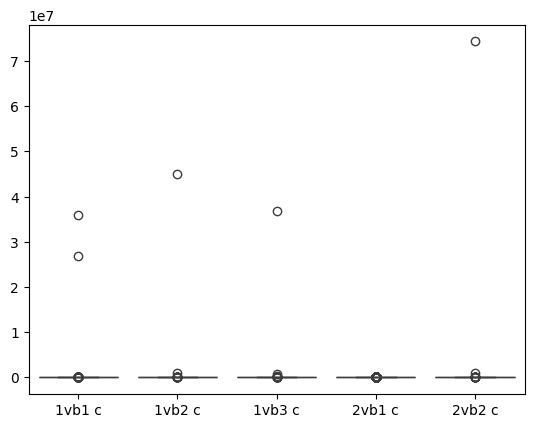

In [ ]:
# Show Noise Data

sns.boxplot(df_kalat[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c']])

noises11 = show_noise(df_kalat, '1vb1', [346, 600])
print('Number of Noises11:', len(noises11), '\n')
noises12 = show_noise(df_kalat, '1vb2', [255])
print('Number of Noises12:', len(noises12), '\n')
noises13 = show_noise(df_kalat, '1vb3', [600])
print('Number of Noises13:', len(noises13), '\n')

noises21 = show_noise(df_kalat, '2vb1', [664])
print('Number of Noises21:', len(noises21), '\n')
noises22 = show_noise(df_kalat, '2vb2')
print('Number of Noises22:', len(noises22))

<Axes: >

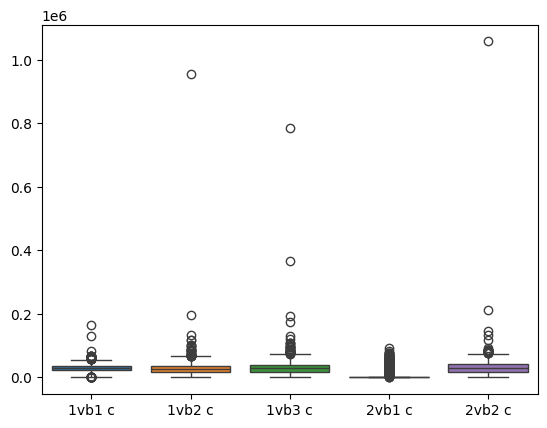

In [ ]:
# Noise Data Handling

df_kalat.loc[noises11, '1vb1 c'] = np.nan
df_kalat.loc[noises12, '1vb2 c'] = np.nan
df_kalat.loc[noises13, '1vb3 c'] = np.nan

df_kalat.loc[noises21, '2vb1 c'] = np.nan
df_kalat.loc[noises22, '2vb2 c'] = np.nan

sns.boxplot(df_kalat[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c']])


Text(0.5, 1.0, 'Time Plot')

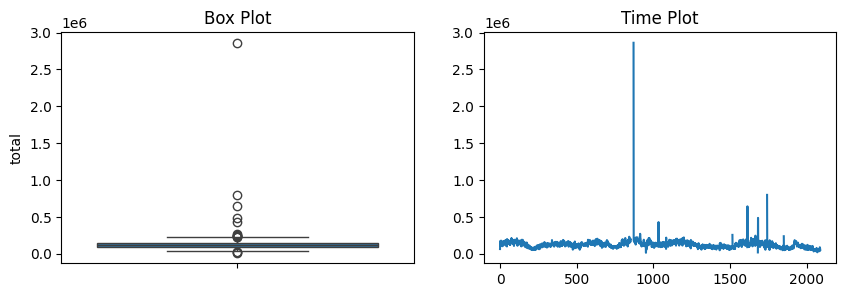

In [ ]:
df_kalat['total'] = df_kalat['1vb1 c'] + df_kalat['1vb2 c'] + df_kalat['1vb3 c'] + df_kalat['2vb1 c'] + df_kalat['2vb2 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_kalat['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_kalat['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
# Show Zeros

#df_kalat[df_kalat['1vb1 c']==0]
#df_kalat[df_kalat['1vb2 c']==0]
#df_kalat[df_kalat['1vb3 c']==0]

#df_kalat[df_kalat['2vb1 c']==0]
df_kalat[df_kalat['2vb2 c']==0]


Date        1vb1   1vb1 c        1vb2    1vb2 c  \
338   1401/09/30 12:00:00  99682010.0  34405.0   2316615.0   42339.0   
573   1401/10/10 07:00:00   5737374.0  22107.0   9381673.0   15803.0   
920   1401/10/24 18:00:00   9041089.0  45931.0  21330807.0   52506.0   
921   1401/10/24 19:00:00   9082194.0  41105.0  21372023.0   41216.0   
922   1401/10/24 20:00:00   9124808.0  42614.0  21412196.0   40173.0   
923   1401/10/24 21:00:00   9166799.0  41991.0  21454589.0   42393.0   
924   1401/10/24 22:00:00   9209244.0  42445.0  21480602.0   26013.0   
925   1401/10/24 23:00:00   9251049.0  41805.0  21535687.0   55085.0   
926   1401/10/25 00:00:00   9293329.0  42280.0  21567780.0   32093.0   
927   1401/10/25 01:00:00   9333139.0  39810.0  21608759.0   40979.0   
928   1401/10/25 02:00:00   9372366.0  39227.0  21651281.0   42522.0   
929   1401/10/25 03:00:00   9411564.0  39198.0  21699122.0   47841.0   
930   1401/10/25 04:00:00   9449584.0  38020.0  21738072.0   38950.0   
931   1401/10/25 05:00:00   9489938.0  40354.0  21770899.0   32827.0   
932   1401/10/25 06:00:00   9528961.0  39023.0  21792438.0   21539.0   
933   1401/10/25 07:00:00   9567089.0  38128.0  21854041.0   61603.0   
934   1401/10/25 08:00:00   9607077.0  39988.0  21882204.0   28163.0   
935   1401/10/25 09:00:00   9647913.0  40836.0  21931062.0   48858.0   
936   1401/10/25 10:00:00   9690657.0  42744.0  21976067.0   45005.0   
955   1401/10/26 05:00:00  10055493.0      0.0  22773379.0   63729.0   
956   1401/10/26 06:00:00  10059445.0   3952.0  22835067.0   61688.0   
965   1401/10/26 15:00:00  10436980.0  45032.0  23196801.0   41717.0   
966   1401/10/26 16:00:00  10483085.0  46105.0  23234260.0   37459.0   
967   1401/10/26 17:00:00  10530657.0  47572.0  23275520.0   41260.0   
968   1401/10/26 18:00:00  10579240.0  48583.0  23339224.0   63704.0   
970   1401/10/26 20:00:00  10679830.0  54660.0  23427897.0   58154.0   
971   1401/10/26 21:00:00  10738889.0  59059.0  23490624.0   62727.0   
972   1401/10/26 22:00:00  10799669.0  60780.0  23557645.0   67021.0   
973   1401/10/26 23:00:00  10862062.0  62393.0  23605381.0   47736.0   
974   1401/10/27 00:00:00  10925175.0  63113.0  23671309.0   65928.0   
975   1401/10/27 01:00:00  10991856.0  66681.0  23723927.0   52618.0   
976   1401/10/27 02:00:00  11054838.0  62982.0  23810902.0   86975.0   
977   1401/10/27 03:00:00  11117277.0  62439.0  23883775.0   72873.0   
978   1401/10/27 04:00:00  11178619.0  61342.0  23969680.0   85905.0   
979   1401/10/27 05:00:00  11241288.0  62669.0  24055669.0   85989.0   
980   1401/10/27 06:00:00  11305320.0  64032.0  24159043.0  103374.0   
981   1401/10/27 07:00:00  11372531.0  67211.0  24247676.0   88633.0   
982   1401/10/27 08:00:00  11441008.0  68477.0  24331245.0   83569.0   
983   1401/10/27 09:00:00  11509896.0  68888.0  24429956.0   98711.0   
984   1401/10/27 10:00:00  11577056.0  67160.0  24498760.0   68804.0   
1175  1401/11/05 09:00:00  17714763.0  32220.0  31100476.0   43522.0   
1647  1401/11/25 01:00:00  32698830.0  41551.0  42088980.0   32298.0   

            1vb3    1vb3 c        2vb1   2vb1 c        2vb2  2vb2 c     total  \
338   66668631.0   33850.0  92574898.0      0.0  33468021.0     0.0  110594.0   
573   72894303.0   20735.0  97633778.0  37992.0  38837531.0     0.0   96637.0   
920    9502798.0   53104.0   4362214.0      0.0  49270377.0     0.0  151541.0   
921    9533549.0   30751.0   4362214.0      0.0  49270377.0     0.0  113072.0   
922    9587614.0   54065.0   4362214.0      0.0  49270377.0     0.0  136852.0   
923    9650356.0   62742.0   4362214.0      0.0  49270377.0     0.0  147126.0   
924    9681090.0   30734.0   4362214.0      0.0  49270377.0     0.0   99192.0   
925    9735613.0   54523.0   4362214.0      0.0  49270377.0     0.0  151413.0   
926    9777926.0   42313.0   4362214.0      0.0  49270377.0     0.0  116686.0   
927    9832774.0   54848.0   4362214.0      0.0  49270377.0     0.0  135637.0   
928    9875356.0   42582.0   4362

In [ ]:
# Zeros Handling

nan121 = df_kalat[df_kalat['1vb2 c']==0].index
nan131 = df_kalat[df_kalat['1vb3 c']==0][:4].index
nan132 = df_kalat[df_kalat['1vb3 c']==0][8:].index

df_kalat.loc[1032, '1vb1 c'] = np.nan
df_kalat.loc[nan121, '1vb2 c'] = np.nan
df_kalat.loc[nan131, '1vb3 c'] = np.nan
df_kalat.loc[nan132, '1vb3 c'] = np.nan

nan221 = df_kalat[df_kalat['2vb2 c']==0][:2].index
nan222 = df_kalat[df_kalat['2vb2 c']==0][-2:].index

df_kalat.loc[487, '2vb1 c'] = np.nan
df_kalat.loc[nan221, '2vb2 c'] = np.nan
df_kalat.loc[nan222, '2vb2 c'] = np.nan


In [ ]:
# Show Missing Data

print(df_kalat[df_kalat['1vb1 c'].isnull()].shape)
print(df_kalat[df_kalat['1vb2 c'].isnull()].shape)
print(df_kalat[df_kalat['1vb3 c'].isnull()].shape)

print(df_kalat[df_kalat['2vb1 c'].isnull()].shape)
print(df_kalat[df_kalat['2vb2 c'].isnull()].shape)


(10, 17)
(53, 17)
(47, 17)
(35, 17)
(39, 17)


In [ ]:
# Missing Data Handling

show_missing(df_kalat, '1vb1 c')
fill_missing(df_kalat, '1vb1 c')

show_missing(df_kalat, '1vb2 c')
fill_missing(df_kalat, '1vb2 c')

show_missing(df_kalat, '1vb3 c')
fill_missing(df_kalat, '1vb3 c')

show_missing(df_kalat, '2vb1 c')
fill_missing(df_kalat, '2vb1 c')

show_missing(df_kalat, '2vb2 c')
fill_missing(df_kalat, '2vb2 c')


853 	 2 	Next X2
870 	 2 	0 or Next
1032 	 2 	Next X2
1515 	 2 	Next X2
1681 	 2 	Next X2
1741 	 6 	0 or Next (Last One)


167 	 2 	0 or Next
172 	 2 	0 or Next
251 	 2 	0 or Next
299 	 2 	0 or Next
520 	 2 	0 or Next
605 	 2 	0 or Next
870 	 19 	0 or Next
952 	 2 	0 or Next
1032 	 3 	Next X2
1190 	 2 	0 or Next
1286 	 2 	0 or Next
1433 	 2 	0 or Next
1491 	 2 	0 or Next
1515 	 4 	0 or Next
1601 	 2 	0 or Next
1613 	 6 	0 or Next
1640 	 2 	0 or Next
1682 	 3 	0 or Next
1741 	 6 	0 or Next
1850 	 3 	0 or Next
1861 	 2 	0 or Next
1907 	 2 	0 or Next
2038 	 2 	0 or Next (Last One)


176 	 2 	0 or Next
195 	 2 	0 or Next
300 	 2 	0 or Next
719 	 2 	0 or Next
870 	 19 	0 or Next
977 	 2 	0 or Next
1032 	 3 	Next X2
1120 	 2 	0 or Next
1219 	 2 	0 or Next
1486 	 2 	0 or Next
1515 	 4 	0 or Next
1577 	 2 	0 or Next
1612 	 5 	Next X2
1682 	 3 	0 or Next
1741 	 6 	0 or Next
1758 	 2 	0 or Next
1850 	 3 	0 or Next
2023 	 2 	0 or Next (Last One)


487 	 2 	0 or Next
870 	 19 	0 or Next
1032 	 3 	

In [ ]:
df_kalat[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1vb1 c  2090 non-null   float64
 1   1vb2 c  2090 non-null   float64
 2   1vb3 c  2090 non-null   float64
 3   2vb1 c  2090 non-null   float64
 4   2vb2 c  2090 non-null   float64
dtypes: float64(5)
memory usage: 81.8 KB


974    63113.0
975    66681.0
976    62982.0
980    64032.0
981    67211.0
982    68477.0
983    68888.0
984    67160.0
Name: 1vb1 c, dtype: float64
64      76670.0
834     84553.0
914     85465.0
976     86975.0
978     85905.0
979     85989.0
980    103374.0
981     88633.0
982     83569.0
983     98711.0
Name: 1vb2 c, dtype: float64
970     100119.0
1023     87155.0
1024     95058.0
1025     94500.0
1026     87401.0
1027    110000.0
1028     88753.0
1728     96651.0
1747     89060.0
1762    100906.0
1765    109385.0
1773    107391.0
1775     94495.0
Name: 1vb3 c, dtype: float64
411    15486.0
412    58091.0
413    51599.0
414    62405.0
415    47271.0
        ...   
814    56358.0
815    43317.0
816    67105.0
817    67194.0
818    21865.0
Name: 2vb1 c, Length: 408, dtype: float64


Series([], Name: 2vb2 c, dtype: float64)

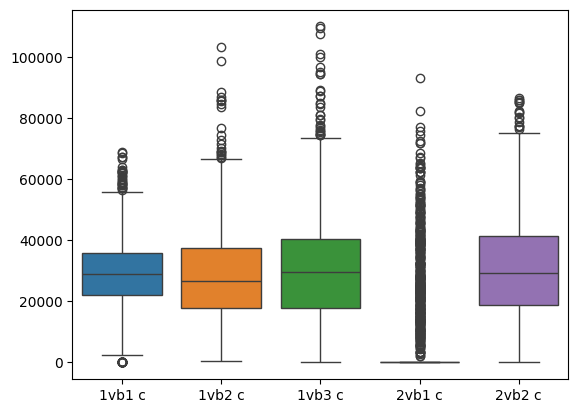

In [ ]:
# Show Outlier Data

sns.boxplot(df_kalat[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c']])

print(show_outlier(df_kalat, '1vb1 c'))
print(show_outlier(df_kalat, '1vb2 c'))
print(show_outlier(df_kalat, '1vb3 c'))

print(show_outlier(df_kalat, '2vb1 c'))
show_outlier(df_kalat, '2vb2 c')

Text(0.5, 1.0, 'Time Plot')

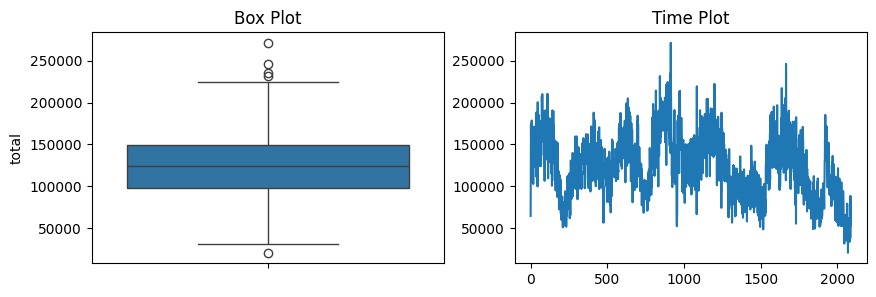

In [ ]:
df_kalat['total'] = df_kalat['1vb1 c'] + df_kalat['1vb2 c'] + df_kalat['1vb3 c'] + df_kalat['2vb1 c'] + df_kalat['2vb2 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_kalat['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_kalat['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_kalat.drop(['1vb1', '1vb2', '1vb3', '2vb1', '2vb2'], axis=1, inplace=True)

In [ ]:
df_kalat.describe()

1vb1 c         1vb2 c        1vb3 c        2vb1 c        2vb2 c  \
count   2090.000000    2090.000000    2090.00000   2090.000000   2090.000000   
mean   29408.588038   28190.214833   30186.04689   5639.864115  30373.075120   
min        0.000000     545.000000       0.00000      0.000000      0.000000   
25%    22195.750000   17952.250000   17886.25000      0.000000  18683.250000   
50%    29032.000000   26645.000000   29689.00000      0.000000  29223.000000   
75%    35729.000000   37430.250000   40380.00000      0.000000  41384.250000   
max    68888.000000  103374.000000  110000.00000  93192.000000  86723.000000   
std    11418.705108   14535.980319   16336.53992  13596.855264  16284.792494   

               total    year        month          day         hour  \
count    2090.000000  2090.0  2090.000000  2090.000000  2090.000000   
mean   123797.788995  1401.0    10.464115    15.534928    11.499043   
min     20852.000000  1401.0     9.000000     1.000000     0.000000   
25%     98286.750000  1401.0    10.000000     8.000000     6.000000   
50%    124103.500000  1401.0    10.000000    16.000000    11.000000   
75%    148772.000000  1401.0    11.000000    23.000000    17.000000   
max    271231.000000  1401.0    12.000000    30.000000    23.000000   
std     35583.665822     0.0     0.933348     8.797492     6.920616   

                  datetime  
count                 2090  
mean   2023-01-19 22:30:00  
min    2022-12-07 10:00:00  
25%    2022-12-29 04:15:00  
50%    2023-01-19 22:30:00  
75%    2023-02-10 16:45:00  
max    2023-03-04 11:00:00  
std                    NaN

<Axes: >

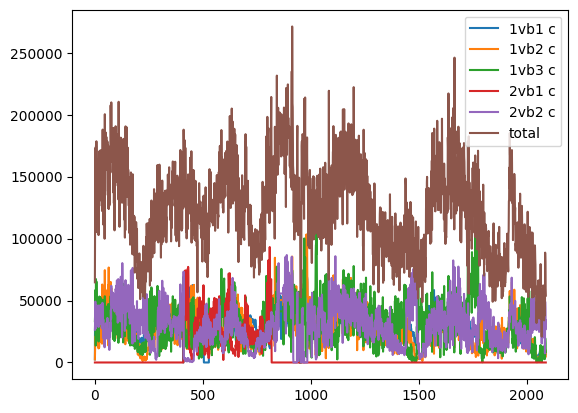

In [ ]:
df_kalat[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c', 'total']].plot()

<Axes: >

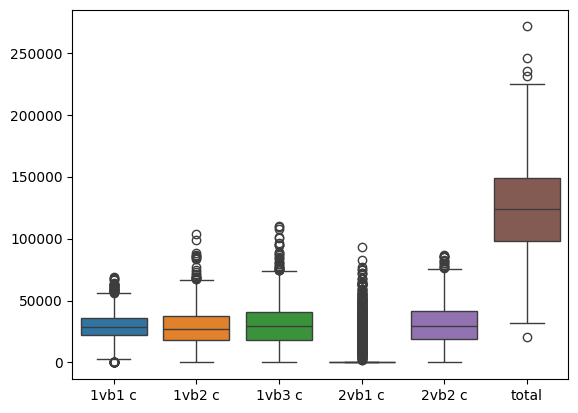

In [ ]:
sns.boxplot(df_kalat[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c', 'total']])

## West

In [ ]:
df_west = pd.read_excel('/content/5 West.xlsx')
print(df_west.shape)
df_west.head()


(6457, 12)


Date        1vb1   1vb1 c        1vb2   1vb2 c       1vb3  \
0  1401/03/18 11:00:00  12072731.0  70005.0  10089661.0  14253.0  7161774.0   
1  1401/03/18 12:00:00  12146742.0  74011.0  10104066.0  14405.0  7172008.0   
2  1401/03/18 13:00:00  12223783.0  77041.0  10118806.0  14740.0  7182376.0   
3  1401/03/18 14:00:00  12296832.0  73049.0  10133724.0  14918.0  7192724.0   
4  1401/03/18 15:00:00  12336910.0  40078.0  10153269.0  19545.0  7209762.0   

    1vb3 c       2vb1   2vb1 c    2vb2  2vb2 c   total  
0  10081.0  4728405.0   4463.0  1940.0     0.0   98802  
1  10234.0  4732849.0   4444.0  1940.0     0.0  103094  
2  10368.0  4737456.0   4607.0  1940.0     0.0  106756  
3  10348.0  4742246.0   4790.0  1940.0     0.0  103105  
4  17038.0  4761095.0  18849.0  1940.0     0.0   95510

Text(0.5, 1.0, 'Time Plot')

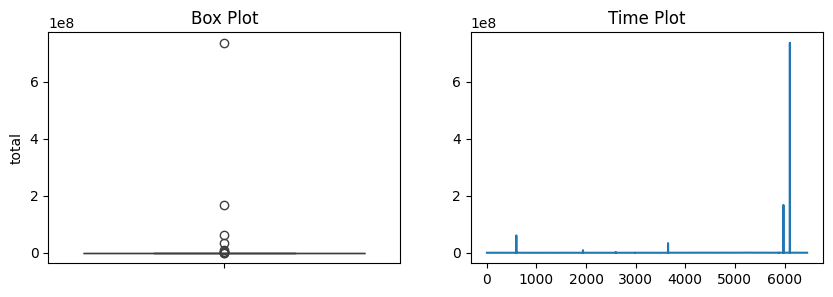

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_west['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_west['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_west['year'] = np.nan
df_west['month'] = np.nan
df_west['day'] = np.nan
df_west['hour'] = np.nan

for i in (df_west.index):
  df_west.loc[i, 'year'] = int(df_west['Date'][i][:4])
  df_west.loc[i, 'month'] = int(df_west['Date'][i][5:7])
  df_west.loc[i, 'day'] = int(df_west['Date'][i][8:10])
  df_west.loc[i, 'hour'] = int(df_west['Date'][i][11:13])

df_west.head()


Date        1vb1   1vb1 c        1vb2   1vb2 c       1vb3  \
0  1401/03/18 11:00:00  12072731.0  70005.0  10089661.0  14253.0  7161774.0   
1  1401/03/18 12:00:00  12146742.0  74011.0  10104066.0  14405.0  7172008.0   
2  1401/03/18 13:00:00  12223783.0  77041.0  10118806.0  14740.0  7182376.0   
3  1401/03/18 14:00:00  12296832.0  73049.0  10133724.0  14918.0  7192724.0   
4  1401/03/18 15:00:00  12336910.0  40078.0  10153269.0  19545.0  7209762.0   

    1vb3 c       2vb1   2vb1 c    2vb2  2vb2 c   total    year  month   day  \
0  10081.0  4728405.0   4463.0  1940.0     0.0   98802  1401.0    3.0  18.0   
1  10234.0  4732849.0   4444.0  1940.0     0.0  103094  1401.0    3.0  18.0   
2  10368.0  4737456.0   4607.0  1940.0     0.0  106756  1401.0    3.0  18.0   
3  10348.0  4742246.0   4790.0  1940.0     0.0  103105  1401.0    3.0  18.0   
4  17038.0  4761095.0  18849.0  1940.0     0.0   95510  1401.0    3.0  18.0   

   hour  
0  11.0  
1  12.0  
2  13.0  
3  14.0  
4  15.0

In [ ]:
# Jalali to Gregorian

add_gregorian(df_west)
df_west.head()

<ipython-input-8-4905f31b75c1>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2022-06-08 11:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()


Date        1vb1   1vb1 c        1vb2   1vb2 c       1vb3  \
0  1401/03/18 11:00:00  12072731.0  70005.0  10089661.0  14253.0  7161774.0   
1  1401/03/18 12:00:00  12146742.0  74011.0  10104066.0  14405.0  7172008.0   
2  1401/03/18 13:00:00  12223783.0  77041.0  10118806.0  14740.0  7182376.0   
3  1401/03/18 14:00:00  12296832.0  73049.0  10133724.0  14918.0  7192724.0   
4  1401/03/18 15:00:00  12336910.0  40078.0  10153269.0  19545.0  7209762.0   

    1vb3 c       2vb1   2vb1 c    2vb2  2vb2 c   total    year  month   day  \
0  10081.0  4728405.0   4463.0  1940.0     0.0   98802  1401.0    3.0  18.0   
1  10234.0  4732849.0   4444.0  1940.0     0.0  103094  1401.0    3.0  18.0   
2  10368.0  4737456.0   4607.0  1940.0     0.0  106756  1401.0    3.0  18.0   
3  10348.0  4742246.0   4790.0  1940.0     0.0  103105  1401.0    3.0  18.0   
4  17038.0  4761095.0  18849.0  1940.0     0.0   95510  1401.0    3.0  18.0   

   hour            datetime  
0  11.0 2022-06-08 11:00:00  
1  12.0 2022-06-08 12:00:00  
2  13.0 2022-06-08 13:00:00  
3  14.0 2022-06-08 14:00:00  
4  15.0 2022-06-08 15:00:00

5978 	 167716636.0
6108 	 174613882.0
Number of Noises11: 2 

593 	 26074955.0
6108 	 21175297.0
Number of Noises12: 2 

593 	 19961035.0
6108 	 194344812.0
Number of Noises13: 2 

593 	 14764243.0
6108 	 193532225.0
Number of Noises21: 2 

6108 	 153004794.0
Number of Noises22: 1


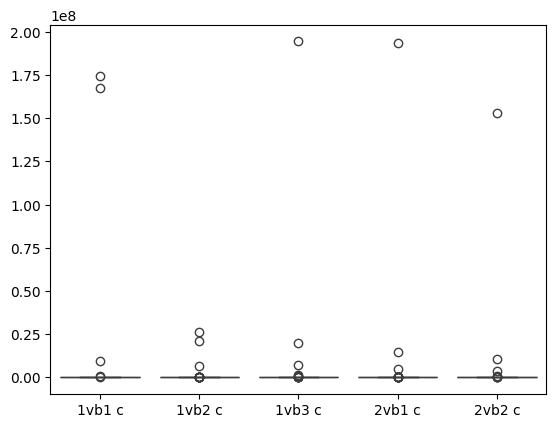

In [ ]:
# Show Noise Data

sns.boxplot(df_west[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c']])

noises11 = show_noise(df_west, '1vb1')
print('Number of Noises11:', len(noises11), '\n')
noises12 = show_noise(df_west, '1vb2', [5663])
print('Number of Noises12:', len(noises12), '\n')
noises13 = show_noise(df_west, '1vb3')
print('Number of Noises13:', len(noises13), '\n')

noises21 = show_noise(df_west, '2vb1')
print('Number of Noises21:', len(noises21), '\n')
noises22 = show_noise(df_west, '2vb2')
print('Number of Noises22:', len(noises22))


<Axes: >

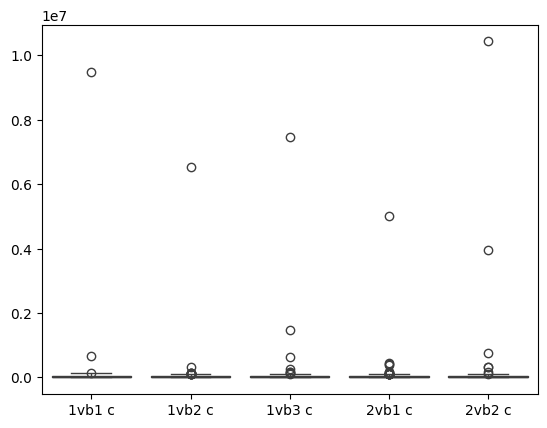

In [ ]:
# Noise Data Handling

df_west.loc[noises11, '1vb1 c'] = np.nan
df_west.loc[noises12, '1vb2 c'] = np.nan
df_west.loc[noises13, '1vb3 c'] = np.nan

df_west.loc[noises21, '2vb1 c'] = np.nan
df_west.loc[noises22, '2vb2 c'] = np.nan

sns.boxplot(df_west[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c']])


Text(0.5, 1.0, 'Time Plot')

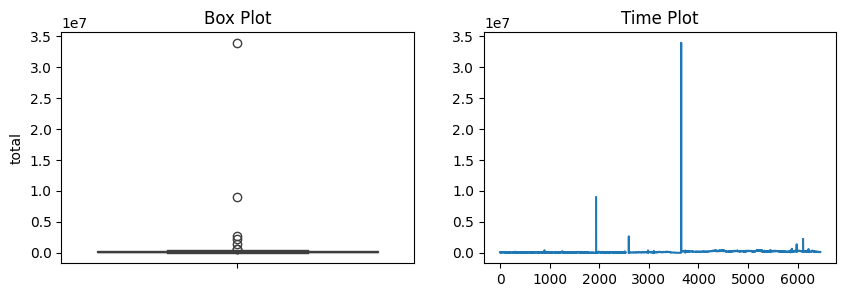

In [ ]:
df_west['total'] = df_west['1vb1 c'] + df_west['1vb2 c'] + df_west['1vb3 c'] + df_west['2vb1 c'] + df_west['2vb2 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_west['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_west['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
# Show Zeros

#df_west[df_west['1vb1 c']==0]
#df_west[df_west['1vb2 c']==0]
#df_west[df_west['1vb3 c']==0]

#df_west[df_west['2vb1 c']==0]
df_west[df_west['2vb2 c']==0]

Date         1vb1   1vb1 c        1vb2   1vb2 c  \
0     1401/03/18 11:00:00   12072731.0  70005.0  10089661.0  14253.0   
1     1401/03/18 12:00:00   12146742.0  74011.0  10104066.0  14405.0   
2     1401/03/18 13:00:00   12223783.0  77041.0  10118806.0  14740.0   
3     1401/03/18 14:00:00   12296832.0  73049.0  10133724.0  14918.0   
4     1401/03/18 15:00:00   12336910.0  40078.0  10153269.0  19545.0   
...                   ...          ...      ...         ...      ...   
5828  1401/11/17 07:00:00  159773664.0  41610.0   8292558.0  52595.0   
5829  1401/11/17 08:00:00  159822708.0  49044.0   8348057.0  55499.0   
5830  1401/11/17 09:00:00  159868888.0  46180.0   8400302.0  52245.0   
5831  1401/11/17 10:00:00  159915084.0  46196.0   8453505.0  53203.0   
5832  1401/11/17 11:00:00  159957693.0  42609.0   8507850.0  54345.0   

             1vb3   1vb3 c         2vb1   2vb1 c         2vb2  2vb2 c  \
0       7161774.0  10081.0    4728405.0   4463.0       1940.0     0.0   
1       7172008.0  10234.0    4732849.0   4444.0       1940.0     0.0   
2       7182376.0  10368.0    4737456.0   4607.0       1940.0     0.0   
3       7192724.0  10348.0    4742246.0   4790.0       1940.0     0.0   
4       7209762.0  17038.0    4761095.0  18849.0       1940.0     0.0   
...           ...      ...          ...      ...          ...     ...   
5828  180121511.0  56011.0  179812968.0  36717.0  140304261.0     0.0   
5829  180180241.0  58730.0  179854461.0  41493.0  140304261.0     0.0   
5830  180235513.0  55272.0  179892136.0  37675.0  140304261.0     0.0   
5831  180291545.0  56032.0  179941183.0  49047.0  140304261.0     0.0   
5832  180350039.0  58494.0  179987581.0  46398.0  140304261.0     0.0   

         total    year  month   day  hour            datetime  
0      98802.0  1401.0    3.0  18.0  11.0 2022-06-08 11:00:00  
1     103094.0  1401.0    3.0  18.0  12.0 2022-06-08 12:00:00  
2     106756.0  1401.0    3.0  18.0  13.0 2022-06-08 13:00:00  
3     103105.0  1401.0    3.0  18.0  14.0 2022-06-08 14:00:00  
4      95510.0  1401.0    3.0  18.0  15.0 2022-06-08 15:00:00  
...        ...     ...    ...   ...   ...                 ...  
5828  186933.0  1401.0   11.0  17.0   7.0 2023-02-06 07:00:00  
5829  204766.0  1401.0   11.0  17.0   8.0 2023-02-06 08:00:00  
5830  191372.0  1401.0   11.0  17.0   9.0 2023-02-06 09:00:00  
5831  204478.0  1401.0   11.0  17.0  10.0 2023-02-06 10:00:00  
5832  201846.0  1401.0   11.0  17.0  11.0 2023-02-06 11:00:00  

[2458 rows x 17 columns]

In [ ]:
# Zeros Handling

df_west.loc[3435:3652, '1vb1 c'] = np.nan
df_west.loc[1791:1936, '1vb2 c'] = np.nan
df_west.loc[3435:3652, '1vb2 c'] = np.nan
df_west.loc[3435:3652, '1vb3 c'] = np.nan

df_west.loc[1791:1936, '2vb1 c'] = np.nan
df_west.loc[1791:1936, '2vb2 c'] = np.nan
df_west.loc[3435:3652, '2vb2 c'] = np.nan

df_west.loc[1337, ['1vb2 c', '1vb3 c', '2vb1 c']] = np.nan # (bfill+ffill)/2

In [ ]:
# Show Missing Data

print(df_west[df_west['1vb1 c'].isnull()].shape)
print(df_west[df_west['1vb2 c'].isnull()].shape)
print(df_west[df_west['1vb3 c'].isnull()].shape)

print(df_west[df_west['2vb1 c'].isnull()].shape)
print(df_west[df_west['2vb2 c'].isnull()].shape)


(312, 17)
(534, 17)
(394, 17)
(316, 17)
(532, 17)


In [ ]:
df_west.loc[1337, ['1vb2 c', '1vb3 c', '2vb1 c']] = (df_west.loc[1336, ['1vb2 c', '1vb3 c', '2vb1 c']]+df_west.loc[1338, ['1vb2 c', '1vb3 c', '2vb1 c']])/2

In [ ]:
# Missing Data Handling

show_missing(df_west, '1vb1 c')
fill_missing(df_west, '1vb1 c')

show_missing(df_west, '1vb2 c')
fill_missing(df_west, '1vb2 c')

show_missing(df_west, '1vb3 c')
fill_missing(df_west, '1vb3 c')

show_missing(df_west, '2vb1 c')
fill_missing(df_west, '2vb1 c')

show_missing(df_west, '2vb2 c')
fill_missing(df_west, '2vb2 c')


894 	 8 	Next X2
1255 	 5 	0 or Next
2514 	 8 	0 or Next
2595 	 66 	0 or Next
2984 	 2 	0 or Next
3098 	 2 	Next X2
3652 	 219 	Next X2
5978 	 2 	Next X2
6108 	 9 	0 or Next (Last One)


40 	 2 	0 or Next
184 	 2 	0 or Next
280 	 2 	0 or Next
301 	 2 	0 or Next
328 	 2 	0 or Next
352 	 2 	0 or Next
376 	 2 	0 or Next
424 	 2 	0 or Next
448 	 2 	0 or Next
472 	 2 	0 or Next
496 	 2 	0 or Next
520 	 2 	0 or Next
547 	 2 	0 or Next
593 	 2 	0 or Next
616 	 2 	0 or Next
664 	 2 	0 or Next
760 	 2 	0 or Next
784 	 2 	0 or Next
832 	 2 	0 or Next
856 	 2 	0 or Next
894 	 8 	Next X2
928 	 2 	0 or Next
952 	 2 	0 or Next
976 	 2 	0 or Next
1000 	 2 	0 or Next
1024 	 2 	0 or Next
1048 	 2 	0 or Next
1096 	 2 	0 or Next
1120 	 2 	0 or Next
1144 	 2 	0 or Next
1168 	 2 	0 or Next
1193 	 2 	Next X2
1255 	 5 	0 or Next
1264 	 2 	0 or Next
1288 	 2 	0 or Next
1312 	 2 	0 or Next
1360 	 2 	0 or Next
1388 	 2 	0 or Next
1432 	 2 	Next X2
1456 	 2 	0 or Next
1480 	 2 	0 or Next
1504 	 2 	0 or Next
1528

In [ ]:
df_west[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6457 entries, 0 to 6456
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1vb1 c  6457 non-null   float64
 1   1vb2 c  6457 non-null   float64
 2   1vb3 c  6457 non-null   float64
 3   2vb1 c  6457 non-null   float64
 4   2vb2 c  6457 non-null   float64
dtypes: float64(5)
memory usage: 252.4 KB


In [ ]:
# Show Outlier Data

print(show_outlier(df_west, '1vb1 c'))
print(show_outlier(df_west, '1vb2 c'))
print(show_outlier(df_west, '1vb3 c'))

print(show_outlier(df_west, '1vb1 c'))
show_outlier(df_west, '1vb2 c')

Series([], Name: 1vb1 c, dtype: float64)
Series([], Name: 1vb2 c, dtype: float64)
Series([], Name: 1vb3 c, dtype: float64)
Series([], Name: 1vb1 c, dtype: float64)


Series([], Name: 1vb2 c, dtype: float64)

Text(0.5, 1.0, 'Time Plot')

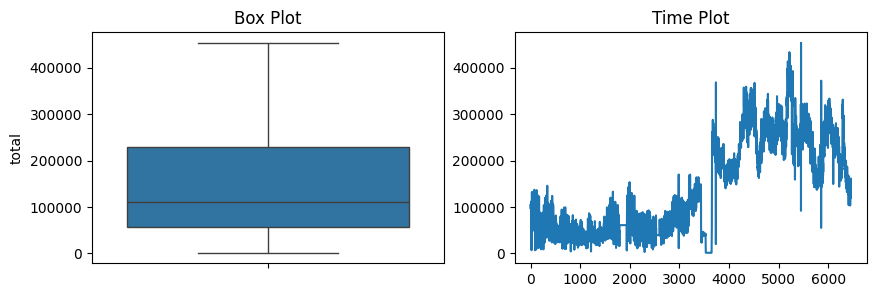

In [ ]:
df_west['total'] = df_west['1vb1 c'] + df_west['1vb2 c'] + df_west['1vb3 c'] + df_west['2vb1 c'] + df_west['2vb2 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_west['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_west['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_west.drop(['1vb1', '1vb2', '1vb3', '2vb1', '2vb2'], axis=1, inplace=True)

In [ ]:
df_west.describe()

1vb1 c         1vb2 c         1vb3 c         2vb1 c  \
count    6457.000000    6457.000000    6457.000000    6457.000000   
mean    26192.893139   30305.277451   30614.056760   31014.787517   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000   10838.000000    9238.000000   11469.000000   
50%     18800.000000   27081.000000   27577.000000   27077.000000   
75%     49671.000000   49618.000000   49423.000000   48345.000000   
max    106701.000000  123128.000000  121134.000000  155919.000000   
std     27001.076055   23846.761429   23515.346839   22428.672286   

             2vb2 c          total    year        month          day  \
count   6457.000000    6457.000000  6457.0  6457.000000  6457.000000   
mean   24354.063032  142481.077900  1401.0     7.454700    15.730835   
min        0.000000    1547.697136  1401.0     3.000000     1.000000   
25%        0.000000   57786.000000  1401.0     5.000000     8.000000   
50%    24135.000000  110901.000000  1401.0     7.000000    16.000000   
75%    41470.000000  229815.000000  1401.0    10.000000    23.000000   
max    96786.000000  453882.000000  1401.0    12.000000    31.000000   
std    24000.869564   97961.707124     0.0     2.592197     8.869809   

              hour                       datetime  
count  6457.000000                           6457  
mean     11.499923  2022-10-20 22:59:59.999999744  
min       0.000000            2022-06-08 11:00:00  
25%       6.000000            2022-08-14 17:00:00  
50%      11.000000            2022-10-20 23:00:00  
75%      17.000000            2022-12-27 05:00:00  
max      23.000000            2023-03-04 11:00:00  
std       6.922189                            NaN

<Axes: >

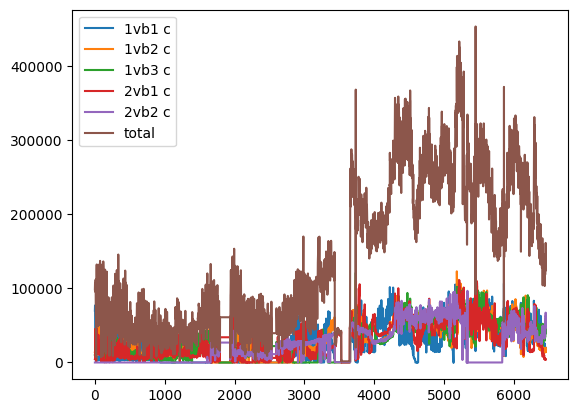

In [ ]:
df_west[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c', 'total']].plot()

<Axes: >

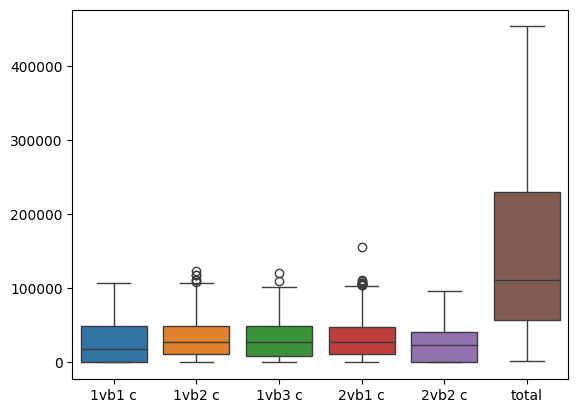

In [ ]:
sns.boxplot(df_west[['1vb1 c', '1vb2 c', '1vb3 c', '2vb1 c', '2vb2 c', 'total']])

## Aramgah

In [ ]:
df_aram = pd.read_excel('/content/6 Aramgah.xlsx')
print(df_aram.shape)
df_aram.head()


(703, 8)


Date         vb1    vb1 c         vb2    vb2 c         vb3  \
0  1401/11/01 08:00:00  13714260.0  18515.0  55893504.0  19192.0  40241060.0   
1  1401/11/01 09:00:00  13751969.0  37709.0  55929743.0  36239.0  40273315.0   
2  1401/11/01 10:00:00  13789601.0  37632.0  55964460.0  34717.0  40308606.0   
3  1401/11/01 11:00:00  13827545.0  37944.0  55995773.0  31313.0  40339552.0   
4  1401/11/01 12:00:00  13861699.0  34154.0  56035996.0  40223.0  40373517.0   

     vb3 c   total  
0  18980.0   56687  
1  32255.0  106203  
2  35291.0  107640  
3  30946.0  100203  
4  33965.0  108342

Text(0.5, 1.0, 'Time Plot')

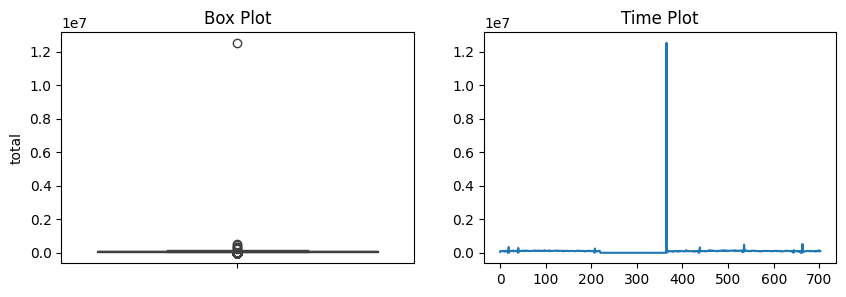

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_aram['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_aram['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_aram['year'] = np.nan
df_aram['month'] = np.nan
df_aram['day'] = np.nan
df_aram['hour'] = np.nan

for i in (df_aram.index):
  df_aram.loc[i, 'year'] = int(df_aram['Date'][i][:4])
  df_aram.loc[i, 'month'] = int(df_aram['Date'][i][5:7])
  df_aram.loc[i, 'day'] = int(df_aram['Date'][i][8:10])
  df_aram.loc[i, 'hour'] = int(df_aram['Date'][i][11:13])

df_aram.head()


Date         vb1    vb1 c         vb2    vb2 c         vb3  \
0  1401/11/01 08:00:00  13714260.0  18515.0  55893504.0  19192.0  40241060.0   
1  1401/11/01 09:00:00  13751969.0  37709.0  55929743.0  36239.0  40273315.0   
2  1401/11/01 10:00:00  13789601.0  37632.0  55964460.0  34717.0  40308606.0   
3  1401/11/01 11:00:00  13827545.0  37944.0  55995773.0  31313.0  40339552.0   
4  1401/11/01 12:00:00  13861699.0  34154.0  56035996.0  40223.0  40373517.0   

     vb3 c   total    year  month  day  hour  
0  18980.0   56687  1401.0   11.0  1.0   8.0  
1  32255.0  106203  1401.0   11.0  1.0   9.0  
2  35291.0  107640  1401.0   11.0  1.0  10.0  
3  30946.0  100203  1401.0   11.0  1.0  11.0  
4  33965.0  108342  1401.0   11.0  1.0  12.0

In [ ]:
# Jalali to Gregorian

add_gregorian(df_aram)
df_aram.head()

<ipython-input-8-4905f31b75c1>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-01-21 08:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()


Date         vb1    vb1 c         vb2    vb2 c         vb3  \
0  1401/11/01 08:00:00  13714260.0  18515.0  55893504.0  19192.0  40241060.0   
1  1401/11/01 09:00:00  13751969.0  37709.0  55929743.0  36239.0  40273315.0   
2  1401/11/01 10:00:00  13789601.0  37632.0  55964460.0  34717.0  40308606.0   
3  1401/11/01 11:00:00  13827545.0  37944.0  55995773.0  31313.0  40339552.0   
4  1401/11/01 12:00:00  13861699.0  34154.0  56035996.0  40223.0  40373517.0   

     vb3 c   total    year  month  day  hour            datetime  
0  18980.0   56687  1401.0   11.0  1.0   8.0 2023-01-21 08:00:00  
1  32255.0  106203  1401.0   11.0  1.0   9.0 2023-01-21 09:00:00  
2  35291.0  107640  1401.0   11.0  1.0  10.0 2023-01-21 10:00:00  
3  30946.0  100203  1401.0   11.0  1.0  11.0 2023-01-21 11:00:00  
4  33965.0  108342  1401.0   11.0  1.0  12.0 2023-01-21 12:00:00

Number of Noises: 0 

Number of Noises: 0 

Number of Noises: 0


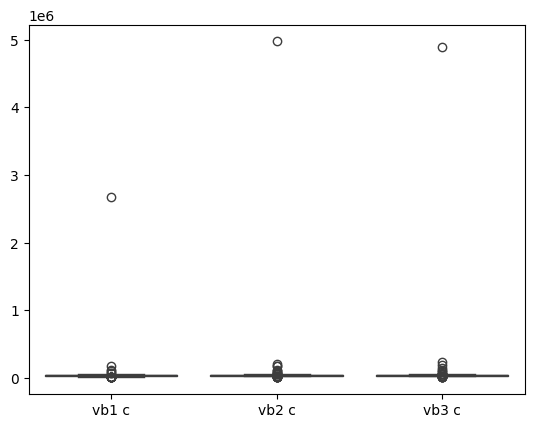

In [ ]:
# Show Noise Data

sns.boxplot(df_aram[['vb1 c', 'vb2 c', 'vb3 c']])

noises1 = show_noise(df_aram, 'vb1')
print('Number of Noises:', len(noises1), '\n')
noises2 = show_noise(df_aram, 'vb2')
print('Number of Noises:', len(noises2), '\n')
noises3 = show_noise(df_aram, 'vb3')
print('Number of Noises:', len(noises3))


In [ ]:
# Noise Data Handling

pass

Text(0.5, 1.0, 'Time Plot')

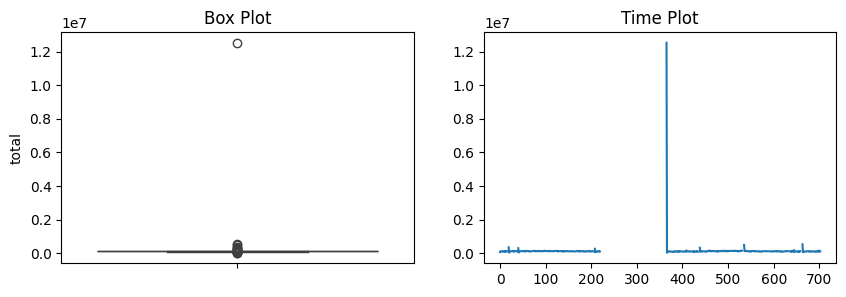

In [ ]:
df_aram['total'] = df_aram['vb1 c'] + df_aram['vb2 c'] + df_aram['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_aram['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_aram['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
# Show Zeros

#df_aram[df_aram['vb1 c']==0]
#df_aram[df_aram['vb2 c']==0]
df_aram[df_aram['vb3 c']==0]

Empty DataFrame
Columns: [Date, vb1, vb1 c, vb2, vb2 c, vb3, vb3 c, total, year, month, day, hour, datetime]
Index: []

In [ ]:
# Zeros Handling

pass

In [ ]:
# Show Missing Data

print(df_aram[df_aram['vb1 c'].isnull()].shape)
print(df_aram[df_aram['vb2 c'].isnull()].shape)
print(df_aram[df_aram['vb3 c'].isnull()].shape)

(155, 13)
(161, 13)
(161, 13)


In [ ]:
# Missing Data Handling

show_missing(df_aram, 'vb1 c')
fill_missing_rev(df_aram, 'vb1 c')

show_missing(df_aram, 'vb2 c')
fill_missing_rev(df_aram, 'vb2 c')

show_missing(df_aram, 'vb3 c')
fill_missing_rev(df_aram, 'vb3 c')

18 	 3 	0 or Next
39 	 2 	0 or Next
207 	 2 	0 or Next
364 	 146 	0 or Next
436 	 2 	0 or Next
643 	 2 	0 or Next
662 	 5 	0 or Next (Last One)


18 	 3 	0 or Next
39 	 2 	0 or Next
207 	 2 	0 or Next
364 	 146 	0 or Next
437 	 4 	0 or Next
534 	 5 	0 or Next
643 	 2 	0 or Next
662 	 5 	0 or Next (Last One)


18 	 3 	0 or Next
39 	 2 	0 or Next
207 	 2 	0 or Next
364 	 146 	0 or Next
437 	 4 	0 or Next
534 	 5 	0 or Next
643 	 2 	0 or Next
662 	 5 	0 or Next (Last One)




In [ ]:
df_aram[['vb1 c', 'vb2 c', 'vb3 c']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vb1 c   703 non-null    float64
 1   vb2 c   703 non-null    float64
 2   vb3 c   703 non-null    float64
dtypes: float64(3)
memory usage: 16.6 KB


In [ ]:
# Show Outlier Data

print(show_outlier(df_aram, 'vb1 c'))
print(show_outlier(df_aram, 'vb2 c'))
show_outlier(df_aram, 'vb3 c')


Series([], Name: vb1 c, dtype: float64)
12     48595.0
125    48915.0
127    56898.0
138    48580.0
384    49535.0
408    69627.0
460    63000.0
486    48393.0
493    48231.0
495    54461.0
514    49329.0
699    63744.0
Name: vb2 c, dtype: float64


98     57660.0
425    52574.0
499    55943.0
529    55427.0
539    52869.0
Name: vb3 c, dtype: float64

Text(0.5, 1.0, 'Time Plot')

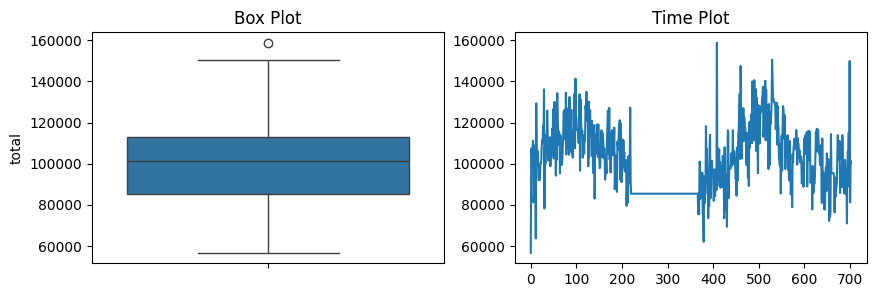

In [ ]:
df_aram['total'] = df_aram['vb1 c'] + df_aram['vb2 c'] + df_aram['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_aram['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_aram['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_aram.drop(['vb1', 'vb2', 'vb3'], axis=1, inplace=True)

In [ ]:
df_aram.describe()

vb1 c         vb2 c         vb3 c          total    year  month  \
count    703.000000    703.000000    703.000000     703.000000   703.0  703.0   
mean   30866.413940  35131.621622  35862.651494  101860.687055  1401.0   11.0   
min    10987.000000  12549.000000  14308.000000   56687.000000  1401.0   11.0   
25%    20659.500000  33129.500000  33305.319728   85406.095238  1401.0   11.0   
50%    32773.000000  33902.285714  34544.000000  101380.000000  1401.0   11.0   
75%    37969.666667  38109.500000  39280.000000  113151.500000  1401.0   11.0   
max    51317.000000  69627.000000  57660.000000  158764.000000  1401.0   11.0   
std     9095.846435   5495.325653   5494.492177   15762.439036     0.0    0.0   

              day        hour                       datetime  
count  703.000000  703.000000                            703  
mean    15.479374   11.495021  2023-02-04 22:59:59.999999744  
min      1.000000    0.000000            2023-01-21 08:00:00  
25%      8.000000    6.000000            2023-01-28 15:30:00  
50%     15.000000   11.000000            2023-02-04 23:00:00  
75%     23.000000   17.000000            2023-02-12 06:30:00  
max     30.000000   23.000000            2023-02-19 14:00:00  
std      8.470281    6.895613                            NaN

<Axes: >

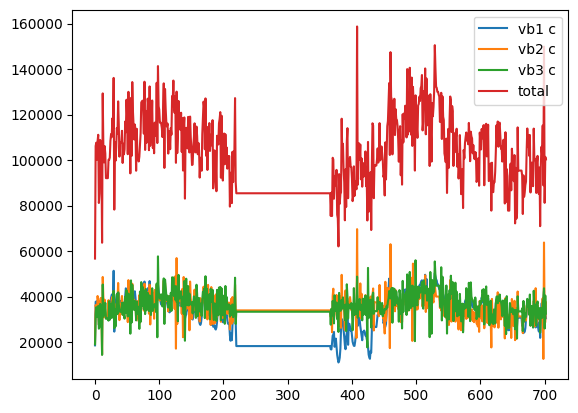

In [ ]:
df_aram[['vb1 c', 'vb2 c', 'vb3 c', 'total']].plot()

<Axes: >

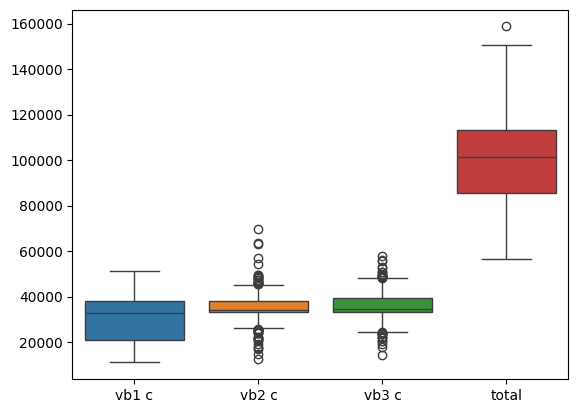

In [ ]:
sns.boxplot(df_aram[['vb1 c', 'vb2 c', 'vb3 c', 'total']])

## Shandiz

In [ ]:
df_shan = pd.read_excel('/content/7 Shandiz.xlsx')
print(df_shan.shape)
df_shan.head()


(2014, 8)


Date         vb1    vb1 c  vb2  vb2 c         vb3    vb3 c  \
0  1401/09/19 14:00:00  72509961.0  15468.0  NaN    NaN  40844305.0  34514.0   
1  1401/09/19 15:00:00  72526724.0  16763.0  NaN    NaN  40855908.0  11603.0   
2  1401/09/19 16:00:00  72540311.0  13587.0  NaN    NaN  40874076.0  18168.0   
3  1401/09/19 17:00:00  72558537.0  18226.0  NaN    NaN  40889772.0  15696.0   
4  1401/09/19 18:00:00  72574629.0  16092.0  NaN    NaN  40904149.0  14377.0   

   total  
0  49982  
1  28366  
2  31755  
3  33922  
4  30469

Text(0.5, 1.0, 'Time Plot')

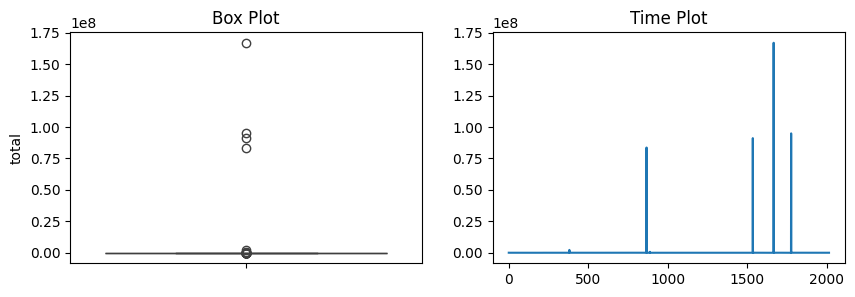

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_shan['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_shan['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_shan['year'] = np.nan
df_shan['month'] = np.nan
df_shan['day'] = np.nan
df_shan['hour'] = np.nan

for i in (df_shan.index):
  df_shan.loc[i, 'year'] = int(df_shan['Date'][i][:4])
  df_shan.loc[i, 'month'] = int(df_shan['Date'][i][5:7])
  df_shan.loc[i, 'day'] = int(df_shan['Date'][i][8:10])
  df_shan.loc[i, 'hour'] = int(df_shan['Date'][i][11:13])

df_shan.head()


Date         vb1    vb1 c  vb2  vb2 c         vb3    vb3 c  \
0  1401/09/19 14:00:00  72509961.0  15468.0  NaN    NaN  40844305.0  34514.0   
1  1401/09/19 15:00:00  72526724.0  16763.0  NaN    NaN  40855908.0  11603.0   
2  1401/09/19 16:00:00  72540311.0  13587.0  NaN    NaN  40874076.0  18168.0   
3  1401/09/19 17:00:00  72558537.0  18226.0  NaN    NaN  40889772.0  15696.0   
4  1401/09/19 18:00:00  72574629.0  16092.0  NaN    NaN  40904149.0  14377.0   

   total    year  month   day  hour  
0  49982  1401.0    9.0  19.0  14.0  
1  28366  1401.0    9.0  19.0  15.0  
2  31755  1401.0    9.0  19.0  16.0  
3  33922  1401.0    9.0  19.0  17.0  
4  30469  1401.0    9.0  19.0  18.0

In [ ]:
# Jalali to Gregorian

add_gregorian(df_shan)
df_shan.head()

<ipython-input-8-4905f31b75c1>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2022-12-10 14:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[i, 'datetime'] = JalaliDateTime(int(table.loc[i, 'year']), int(table.loc[i, 'month']), int(table.loc[i, 'day']), int(table.loc[i, 'hour'])).to_gregorian()


Date         vb1    vb1 c  vb2  vb2 c         vb3    vb3 c  \
0  1401/09/19 14:00:00  72509961.0  15468.0  NaN    NaN  40844305.0  34514.0   
1  1401/09/19 15:00:00  72526724.0  16763.0  NaN    NaN  40855908.0  11603.0   
2  1401/09/19 16:00:00  72540311.0  13587.0  NaN    NaN  40874076.0  18168.0   
3  1401/09/19 17:00:00  72558537.0  18226.0  NaN    NaN  40889772.0  15696.0   
4  1401/09/19 18:00:00  72574629.0  16092.0  NaN    NaN  40904149.0  14377.0   

   total    year  month   day  hour            datetime  
0  49982  1401.0    9.0  19.0  14.0 2022-12-10 14:00:00  
1  28366  1401.0    9.0  19.0  15.0 2022-12-10 15:00:00  
2  31755  1401.0    9.0  19.0  16.0 2022-12-10 16:00:00  
3  33922  1401.0    9.0  19.0  17.0 2022-12-10 17:00:00  
4  30469  1401.0    9.0  19.0  18.0 2022-12-10 18:00:00

866 	 83707744.0
1534 	 91186020.0
1665 	 93704527.0
1775 	 94950081.0
Number of Noises: 4 

1665 	 14246780.0
Number of Noises: 1 

1665 	 59084639.0
Number of Noises: 1


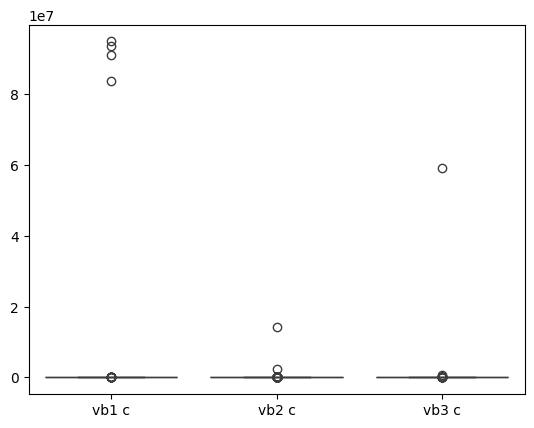

In [ ]:
# Show Noise Data

sns.boxplot(df_shan[['vb1 c', 'vb2 c', 'vb3 c']])

noises1 = show_noise(df_shan, 'vb1')
print('Number of Noises:', len(noises1), '\n')
noises2 = show_noise(df_shan, 'vb2')
print('Number of Noises:', len(noises2), '\n')
noises3 = show_noise(df_shan, 'vb3')
print('Number of Noises:', len(noises3))


<Axes: >

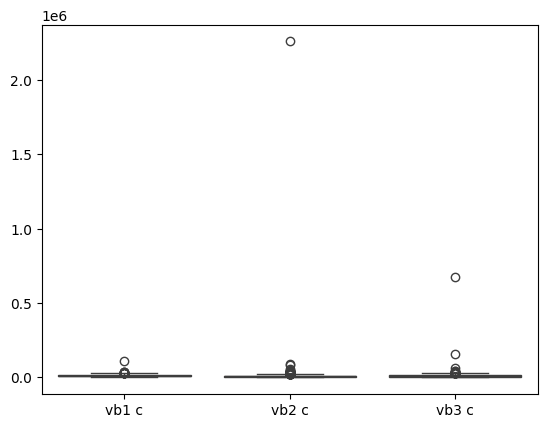

In [ ]:
# Noise Data Handling

df_shan.loc[noises1, 'vb1 c'] = np.nan
df_shan.loc[noises2, 'vb2 c'] = np.nan
df_shan.loc[noises3, 'vb3 c'] = np.nan
sns.boxplot(df_shan[['vb1 c', 'vb2 c', 'vb3 c']])

Text(0.5, 1.0, 'Time Plot')

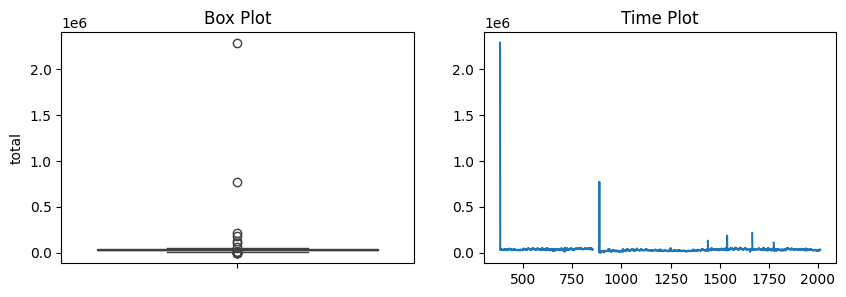

In [ ]:
df_shan['total'] = df_shan['vb1 c'] + df_shan['vb2 c'] + df_shan['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_shan['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_shan['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
# Show Zeros

#df_shan[df_shan['vb1 c']==0]
#df_shan[df_shan['vb2 c']==0]
df_shan[df_shan['vb3 c']==0]

Date         vb1    vb1 c         vb2    vb2 c  \
825   1401/10/23 23:00:00  83280102.0  21008.0   7437868.0  22403.0   
826   1401/10/24 00:00:00  83301917.0  21815.0   7460212.0  22344.0   
827   1401/10/24 01:00:00  83323545.0  21628.0   7482250.0  22038.0   
828   1401/10/24 02:00:00  83344605.0  21060.0   7501333.0  19083.0   
829   1401/10/24 03:00:00  83367027.0  22422.0   7526512.0  25179.0   
...                   ...         ...      ...         ...      ...   
1072  1401/11/04 06:00:00  85687441.0  12061.0  10130521.0  17391.0   
1073  1401/11/04 07:00:00  85700377.0  12936.0  10149790.0  19269.0   
1074  1401/11/04 08:00:00  85714332.0  13955.0  10171365.0  21575.0   
1075  1401/11/04 09:00:00  85728552.0  14220.0  10193837.0  22472.0   
1076  1401/11/04 10:00:00  85742724.0  14172.0  10211947.0  18110.0   

             vb3  vb3 c    total    year  month   day  hour  \
825   51910784.0    0.0  43411.0  1401.0   10.0  23.0  23.0   
826   51910784.0    0.0  44159.0  1401.0   10.0  24.0   0.0   
827   51910784.0    0.0  43666.0  1401.0   10.0  24.0   1.0   
828   51910784.0    0.0  40143.0  1401.0   10.0  24.0   2.0   
829   51910784.0    0.0  47601.0  1401.0   10.0  24.0   3.0   
...          ...    ...      ...     ...    ...   ...   ...   
1072  53172058.0    0.0  29452.0  1401.0   11.0   4.0   6.0   
1073  53172058.0    0.0  32205.0  1401.0   11.0   4.0   7.0   
1074  53172058.0    0.0  35530.0  1401.0   11.0   4.0   8.0   
1075  53172058.0    0.0  36692.0  1401.0   11.0   4.0   9.0   
1076  53172058.0    0.0  32282.0  1401.0   11.0   4.0  10.0   

                datetime  
825  2023-01-13 23:00:00  
826  2023-01-14 00:00:00  
827  2023-01-14 01:00:00  
828  2023-01-14 02:00:00  
829  2023-01-14 03:00:00  
...                  ...  
1072 2023-01-24 06:00:00  
1073 2023-01-24 07:00:00  
1074 2023-01-24 08:00:00  
1075 2023-01-24 09:00:00  
1076 2023-01-24 10:00:00  

[185 rows x 13 columns]

In [ ]:
# Zeros Handling

pass

In [ ]:
# Show Missing Data

print(df_shan[df_shan['vb1 c'].isnull()].shape)
print(df_shan[df_shan['vb2 c'].isnull()].shape)
print(df_shan[df_shan['vb3 c'].isnull()].shape)

(10, 13)
(427, 13)
(46, 13)


In [ ]:
# Missing Data Handling

show_missing(df_shan, 'vb1 c')
fill_missing(df_shan, 'vb1 c')

show_missing(df_shan, 'vb2 c')
fill_missing(df_shan, 'vb2 c')

show_missing(df_shan, 'vb3 c')
fill_missing(df_shan, 'vb3 c')

866 	 3 	0 or Next
1248 	 2 	Next X2
1534 	 2 	0 or Next
1665 	 6 	0 or Next
1775 	 2 	0 or Next (Last One)


380 	 382 	0 or Next
885 	 32 	Next X2
1248 	 2 	Next X2
1439 	 4 	0 or Next
1536 	 5 	Next X2
1665 	 6 	0 or Next
1774 	 3 	Next X2 (Last One)


885 	 32 	Next X2
1248 	 2 	Next X2
1439 	 4 	0 or Next
1536 	 5 	Next X2
1665 	 6 	0 or Next
1774 	 3 	Next X2 (Last One)




In [ ]:
df_shan[['vb1 c', 'vb2 c', 'vb3 c']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014 entries, 0 to 2013
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vb1 c   2014 non-null   float64
 1   vb2 c   2014 non-null   float64
 2   vb3 c   2014 non-null   float64
dtypes: float64(3)
memory usage: 47.3 KB


In [ ]:
# Show Outlier Data

print(show_outlier(df_shan, 'vb1 c'))
print(show_outlier(df_shan, 'vb2 c'))
show_outlier(df_shan, 'vb3 c')


Series([], Name: vb1 c, dtype: float64)
689     29149.0
691     30358.0
692     26875.0
694     25987.0
695     32536.0
         ...   
1768    37786.0
1769    32502.0
1770    29280.0
1771    35186.0
1772    41558.0
Name: vb2 c, Length: 79, dtype: float64


0       34514.0
841     32317.0
842     39044.0
844     33546.0
847     41014.0
848     32524.0
1845    32959.0
Name: vb3 c, dtype: float64

Text(0.5, 1.0, 'Time Plot')

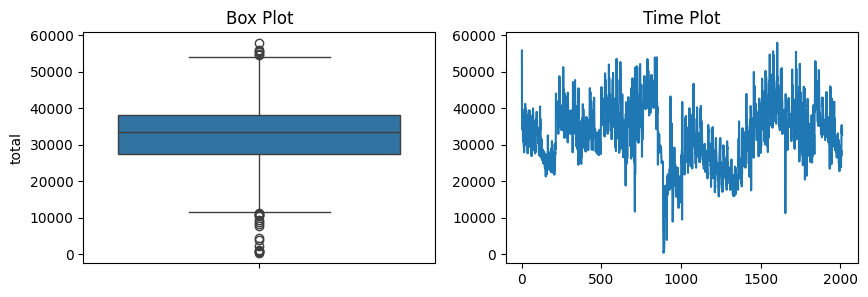

In [ ]:
df_shan['total'] = df_shan['vb1 c'] + df_shan['vb2 c'] + df_shan['vb3 c']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df_shan['total'], ax=axs[0])
axs[0].set_title('Box Plot')

df_shan['total'].plot()
axs[1].set_title('Time Plot')


In [ ]:
df_shan.drop(['vb1', 'vb2', 'vb3'], axis=1, inplace=True)

In [ ]:
df_shan.describe()

vb1 c         vb2 c         vb3 c         total    year  \
count   2014.000000   2014.000000   2014.000000   2014.000000  2014.0   
mean   12848.325223   9384.616187  10721.729891  32954.671301  1401.0   
min       15.000000      0.000000      0.000000    436.000000  1401.0   
25%     7910.750000   5908.515707   6223.000000  27532.000000  1401.0   
50%    12755.500000   7722.500000  10824.000000  33465.757853  1401.0   
75%    17088.500000  12024.000000  14807.000000  38295.886780  1401.0   
max    33568.000000  44925.000000  41014.000000  57987.000000  1401.0   
std     6263.486197   6349.377233   6579.003562   8258.079502     0.0   

             month          day         hour             datetime  
count  2014.000000  2014.000000  2014.000000                 2014  
mean     10.519364    15.460775    11.499007  2023-01-21 12:30:00  
min       9.000000     1.000000     0.000000  2022-12-10 14:00:00  
25%      10.000000     7.250000     5.250000  2022-12-31 13:15:00  
50%      11.000000    15.000000    11.000000  2023-01-21 12:30:00  
75%      11.000000    23.750000    17.750000  2023-02-11 11:45:00  
max      12.000000    30.000000    23.000000  2023-03-04 11:00:00  
std       0.905562     8.951500     6.927253                  NaN

<Axes: >

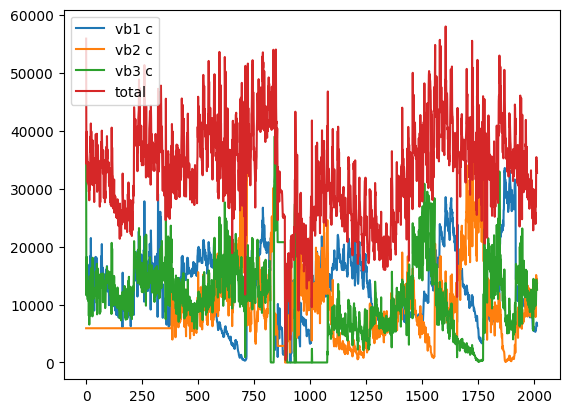

In [ ]:
df_shan[['vb1 c', 'vb2 c', 'vb3 c', 'total']].plot()

<Axes: >

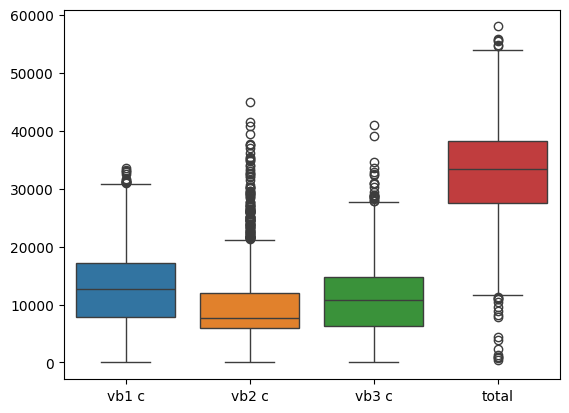

In [ ]:
sns.boxplot(df_shan[['vb1 c', 'vb2 c', 'vb3 c', 'total']])

# Modeling

In [ ]:
#df_jim.to_excel('df_jim.xlsx')
#df_abbas.to_excel('df_abb.xlsx')
#df_siman.to_excel('df_sim.xlsx')
#df_kalat.to_excel('df_kal.xlsx')
#df_west.to_excel('df_wes.xlsx')
#df_aram.to_excel('df_ara.xlsx')
#df_shan.to_excel('df_sha.xlsx')


In [ ]:
df_jim = pd.read_excel('/content/df_jim.xlsx')
df_abb = pd.read_excel('/content/df_abb.xlsx')
df_sim = pd.read_excel('/content/df_sim.xlsx')
df_kal = pd.read_excel('/content/df_kal.xlsx')
df_wes = pd.read_excel('/content/df_wes.xlsx')
df_ara = pd.read_excel('/content/df_ara.xlsx')
df_sha = pd.read_excel('/content/df_sha.xlsx')

In [ ]:
df_jim['total'][df_jim['total']==0] = 1
df_abb['total'][df_abb['total']==0] = 1
df_sim['total'][df_sim['total']==0] = 1

<ipython-input-17-df00996317bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jim['total'][df_jim['total']==0] = 1
<ipython-input-17-df00996317bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abb['total'][df_abb['total']==0] = 1
<ipython-input-17-df00996317bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['total'][df_sim['total']==0] = 1


In [ ]:
train_jim, test_jim = df_jim['total'][:3900], df_jim['total'][3900:] # 83%  778
train_abb, test_abb = df_abb['total'][:7700], df_abb['total'][7700:] # 82%  1732
train_sim, test_sim = df_sim['total'][:8500], df_sim['total'][8500:] # 80%  2124
train_kal, test_kal = df_kal['total'][:1750], df_kal['total'][1750:] # 83%  340
train_wes, test_wes = df_wes['total'][:5300], df_wes['total'][5300:] # 82%  1157
train_ara, test_ara = df_ara['total'][:600], df_ara['total'][600:]   # 85%  103
train_sha, test_sha = df_sha['total'][:1700], df_sha['total'][1700:] # 84%  314


In [ ]:
step = 24

trainX_jim, trainY_jim = convert_to_dataset(train_jim,step)
testX_jim, testY_jim = convert_to_dataset(test_jim,step)

trainX_abb, trainY_abb = convert_to_dataset(train_abb,step)
testX_abb, testY_abb = convert_to_dataset(test_abb,step)

trainX_sim, trainY_sim = convert_to_dataset(train_sim,step)
testX_sim, testY_sim = convert_to_dataset(test_sim,step)

trainX_kal, trainY_kal = convert_to_dataset(train_kal,step)
testX_kal, testY_kal = convert_to_dataset(test_kal,step)

trainX_wes, trainY_wes = convert_to_dataset(train_wes,step)
testX_wes, testY_wes = convert_to_dataset(test_wes,step)

trainX_ara, trainY_ara = convert_to_dataset(train_ara,step)
testX_ara, testY_ara = convert_to_dataset(test_ara,step)

trainX_sha, trainY_sha = convert_to_dataset(train_sha,step)
testX_sha, testY_sha = convert_to_dataset(test_sha,step)

#trainX_jim_ma, trainY_jim_ma = convert_to_dataset(train_jim_ma,step)
#testX_jim_ma, testY_jim_ma = convert_to_dataset(test_jim_ma,step)


In [ ]:
df_jim_t = df_jim.set_index('datetime')
df_jim_t = df_jim_t[['total']]

df_abb_t = df_abb.set_index('datetime')
df_abb_t = df_abb_t[['total']]

df_sim_t = df_sim.set_index('datetime')
df_sim_t = df_sim_t[['total']]

df_kal_t = df_kal.set_index('datetime')
df_kal_t = df_kal_t[['total']]

df_wes_t = df_wes.set_index('datetime')
df_wes_t = df_wes_t[['total']]

df_ara_t = df_ara.set_index('datetime')
df_ara_t = df_ara_t[['total']]

df_sha_t = df_sha.set_index('datetime')
df_sha_t = df_sha_t[['total']]


In [ ]:
train_jim_t, test_jim_t = df_jim_t[:3900], df_jim_t[3900:] # 83%
train_abb_t, test_abb_t = df_abb_t[:7700], df_abb_t[7700:] # 82%
train_sim_t, test_sim_t = df_sim_t[:8500], df_sim_t[8500:] # 80%
train_kal_t, test_kal_t = df_kal_t[:1750], df_kal_t[1750:] # 83%
train_wes_t, test_wes_t = df_wes_t[:5300], df_wes_t[5300:] # 82%
train_ara_t, test_ara_t = df_ara_t[:600], df_ara_t[600:]   # 85%
train_sha_t, test_sha_t = df_sha_t[:1700], df_sha_t[1700:] # 84%


## ARIMA


In [ ]:
print('Jim Abad:\t', adfuller(df_jim_t)[1])
print('Abbas Abad:\t', adfuller(df_abb_t)[1])
print('Siman:\t\t', adfuller(df_sim_t)[1])
print('Kalat:\t\t', adfuller(df_kal_t)[1])
print('West:\t\t', adfuller(df_wes_t)[1])
print('Aramgah:\t', adfuller(df_ara_t)[1])
print('Shandiz:\t', adfuller(df_sha_t)[1])

Jim Abad:	 0.0017645674682914543
Abbas Abad:	 0.2826400543874854
Siman:		 0.08882966219140331
Kalat:		 0.07724141172053516
West:		 0.07117724650478066
Aramgah:	 0.5534920055824069
Shandiz:	 0.02311949905345742


In [ ]:
print('Jim Abad:\t', adfuller(train_jim_t)[1])
print('Abbas Abad:\t', adfuller(train_abb_t)[1])
print('Siman:\t\t', adfuller(train_sim_t)[1])
print('Kalat:\t\t', adfuller(train_kal_t)[1])
print('West:\t\t', adfuller(train_wes_t)[1])
print('Aramgah:\t', adfuller(train_ara_t)[1])
print('Shandiz:\t', adfuller(train_sha_t)[1])

Jim Abad:	 0.00794227044286184
Abbas Abad:	 0.40665310031806245
Siman:		 0.22230733322063112
Kalat:		 0.084010927324837
West:		 0.12358485928284935
Aramgah:	 0.3027929108656823
Shandiz:	 0.13915902564454002


In [ ]:
#Estimating trend
df_jim_log = np.log(df_jim_t)
df_abb_log = np.log(df_abb_t)
df_sim_log = np.log(df_sim_t)
df_kal_log = np.log(df_kal_t)
df_wes_log = np.log(df_wes_t)
df_ara_log = np.log(df_ara_t)
df_sha_log = np.log(df_sha_t)


In [ ]:
#Estimating trend
train_jim_log = np.log(train_jim_t)
train_abb_log = np.log(train_abb_t)
train_sim_log = np.log(train_sim_t)
train_kal_log = np.log(train_kal_t)
train_wes_log = np.log(train_wes_t)
train_ara_log = np.log(train_ara_t)
train_sha_log = np.log(train_sha_t)

#Estimating trend
test_jim_log = np.log(test_jim_t)
test_abb_log = np.log(test_abb_t)
test_sim_log = np.log(test_sim_t)
test_kal_log = np.log(test_kal_t)
test_wes_log = np.log(test_wes_t)
test_ara_log = np.log(test_ara_t)
test_sha_log = np.log(test_sha_t)


In [ ]:
ma_jim = df_jim_log.rolling(window=12).mean()
ma_abb = df_abb_log.rolling(window=12).mean()
ma_sim = df_sim_log.rolling(window=12).mean()
ma_kal = df_kal_log.rolling(window=12).mean()
ma_wes = df_wes_log.rolling(window=12).mean()
ma_ara = df_ara_log.rolling(window=12).mean()
ma_sha = df_sha_log.rolling(window=12).mean()


In [ ]:
ma_jim_train = train_jim_log.rolling(window=12).mean()
ma_abb_train = train_abb_log.rolling(window=12).mean()
ma_sim_train = train_sim_log.rolling(window=12).mean()
ma_kal_train = train_kal_log.rolling(window=12).mean()
ma_wes_train = train_wes_log.rolling(window=12).mean()
ma_ara_train = train_ara_log.rolling(window=12).mean()
ma_sha_train = train_sha_log.rolling(window=12).mean()

ma_jim_test = test_jim_log.rolling(window=12).mean()
ma_abb_test = test_abb_log.rolling(window=12).mean()
ma_sim_test = test_sim_log.rolling(window=12).mean()
ma_kal_test = test_kal_log.rolling(window=12).mean()
ma_wes_test = test_wes_log.rolling(window=12).mean()
ma_ara_test = test_ara_log.rolling(window=12).mean()
ma_sha_test = test_sha_log.rolling(window=12).mean()


In [ ]:
df_jim_ma = df_jim_log - ma_jim
df_jim_ma.dropna(inplace=True)
df_abb_ma = df_abb_log - ma_abb
df_abb_ma.dropna(inplace=True)
df_sim_ma = df_sim_log - ma_sim
df_sim_ma.dropna(inplace=True)
df_kal_ma = df_kal_log - ma_kal
df_kal_ma.dropna(inplace=True)
df_wes_ma = df_wes_log - ma_wes
df_wes_ma.dropna(inplace=True)
df_ara_ma = df_ara_log - ma_ara
df_ara_ma.dropna(inplace=True)
df_sha_ma = df_sha_log - ma_sha
df_sha_ma.dropna(inplace=True)


In [ ]:
train_jim_ma = train_jim_log - ma_jim_train
train_jim_ma.dropna(inplace=True)
train_abb_ma = train_abb_log - ma_abb_train
train_abb_ma.dropna(inplace=True)
train_sim_ma = train_sim_log - ma_sim_train
train_sim_ma.dropna(inplace=True)
train_kal_ma = train_kal_log - ma_kal_train
train_kal_ma.dropna(inplace=True)
train_wes_ma = train_wes_log - ma_wes_train
train_wes_ma.dropna(inplace=True)
train_ara_ma = train_ara_log - ma_ara_train
train_ara_ma.dropna(inplace=True)
train_sha_ma = train_sha_log - ma_sha_train
train_sha_ma.dropna(inplace=True)

test_jim_ma = test_jim_log - ma_jim_test
test_jim_ma.dropna(inplace=True)
test_abb_ma = test_abb_log - ma_abb_test
test_abb_ma.dropna(inplace=True)
test_sim_ma = test_sim_log - ma_sim_test
test_sim_ma.dropna(inplace=True)
test_kal_ma = test_kal_log - ma_kal_test
test_kal_ma.dropna(inplace=True)
test_wes_ma = test_wes_log - ma_wes_test
test_wes_ma.dropna(inplace=True)
test_ara_ma = test_ara_log - ma_ara_test
test_ara_ma.dropna(inplace=True)
test_sha_ma = test_sha_log - ma_sha_test
test_sha_ma.dropna(inplace=True)


In [ ]:
print('Jim Abad:\t', adfuller(df_jim_ma)[1])
print('Abbas Abad:\t', adfuller(df_abb_ma)[1])
print('Siman:\t\t', adfuller(df_sim_ma)[1])
print('Kalat:\t\t', adfuller(df_kal_ma)[1])
print('West:\t\t', adfuller(df_wes_ma)[1])
print('Aramgah:\t', adfuller(df_ara_ma)[1])
print('Shandiz:\t', adfuller(df_sha_ma)[1])

Jim Abad:	 2.200190546103991e-20
Abbas Abad:	 9.60856317052505e-30
Siman:		 0.0
Kalat:		 4.318315592064249e-11
West:		 2.887550861581867e-28
Aramgah:	 5.379007297460447e-10
Shandiz:	 2.3392290679455048e-28


In [ ]:
print('Jim Abad:\t', adfuller(train_jim_ma)[1])
print('Abbas Abad:\t', adfuller(train_abb_ma)[1])
print('Siman:\t\t', adfuller(train_sim_ma)[1])
print('Kalat:\t\t', adfuller(train_kal_ma)[1])
print('West:\t\t', adfuller(train_wes_ma)[1])
print('Aramgah:\t', adfuller(train_ara_ma)[1])
print('Shandiz:\t', adfuller(train_sha_ma)[1])

Jim Abad:	 5.997381445159688e-22
Abbas Abad:	 5.100641660660472e-28
Siman:		 0.0
Kalat:		 3.4102987390744865e-09
West:		 2.70050157335275e-26
Aramgah:	 1.322989092796697e-16
Shandiz:	 5.374433606657371e-24


In [ ]:
#ACF & PACF plots
lag_acf_jim = acf(df_jim_t, nlags=20)
lag_pacf_jim = pacf(df_jim_t, nlags=20, method='ols')
lag_acf_abb = acf(df_abb_t, nlags=20)
lag_pacf_abb = pacf(df_abb_t, nlags=20, method='ols')
lag_acf_sim = acf(df_sim_t, nlags=20)
lag_pacf_sim = pacf(df_sim_t, nlags=20, method='ols')
lag_acf_kal = acf(df_kal_t, nlags=20)
lag_pacf_kal = pacf(df_kal_t, nlags=20, method='ols')
lag_acf_wes = acf(df_wes_t, nlags=20)
lag_pacf_wes = pacf(df_wes_t, nlags=20, method='ols')
lag_acf_ara = acf(df_ara_t, nlags=20)
lag_pacf_ara = pacf(df_ara_t, nlags=20, method='ols')
lag_acf_sha = acf(df_sha_t, nlags=20)
lag_pacf_sha = pacf(df_sha_t, nlags=20, method='ols')


In [ ]:
#ACF & PACF plots
lag_acf_jim = acf(df_jim_ma, nlags=20)
lag_pacf_jim = pacf(df_jim_ma, nlags=20, method='ols')
lag_acf_abb = acf(df_abb_ma, nlags=20)
lag_pacf_abb = pacf(df_abb_ma, nlags=20, method='ols')
lag_acf_sim = acf(df_sim_ma, nlags=20)
lag_pacf_sim = pacf(df_sim_ma, nlags=20, method='ols')
lag_acf_kal = acf(df_kal_ma, nlags=20)
lag_pacf_kal = pacf(df_kal_ma, nlags=20, method='ols')
lag_acf_wes = acf(df_wes_ma, nlags=20)
lag_pacf_wes = pacf(df_wes_ma, nlags=20, method='ols')
lag_acf_ara = acf(df_ara_ma, nlags=20)
lag_pacf_ara = pacf(df_ara_ma, nlags=20, method='ols')
lag_acf_sha = acf(df_sha_ma, nlags=20)
lag_pacf_sha = pacf(df_sha_ma, nlags=20, method='ols')


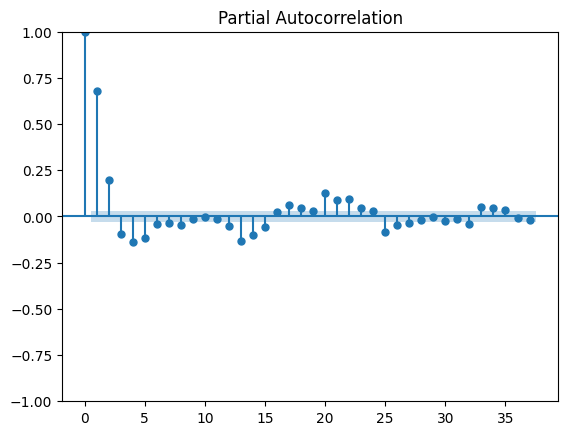

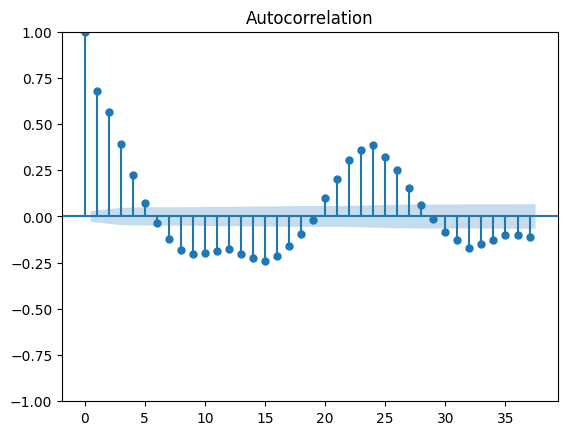

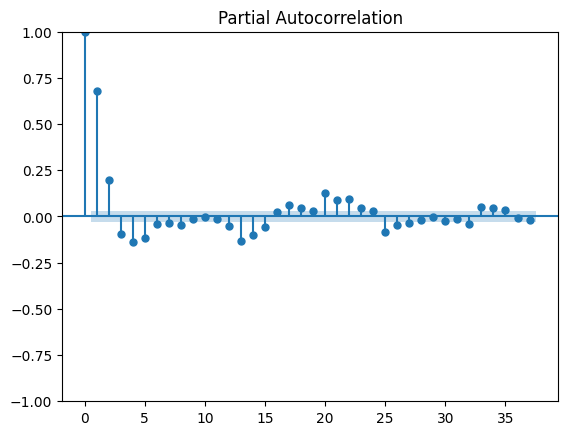

In [ ]:
plot_acf(df_jim_ma)
plot_pacf(df_jim_ma)

In [ ]:
warnings.filterwarnings("ignore")

minimum = 1000000

for p in range(8,9):
  for q in range(1,13):
    for d in range(1):
      mae = arima(df_jim_ma, df_jim_log, df_jim_t, p, d, q)
      print(p,d,q,mae)
      if mae < minimum:
        print('***min***')
        minimum = mae


3 0 0 	 11618.378 	 107.789 	 0.905
***min***
3 0 1 	 10646.758 	 103.183 	 0.859
***min***
3 0 2 	 12170.368 	 110.319 	 0.943
3 0 3 	 10670.424 	 103.298 	 0.86
3 0 4 	 10461.818 	 102.283 	 0.832
***min***
3 0 5 	 11636.522 	 107.873 	 0.912
3 0 6 	 12004.454 	 109.565 	 0.827


KeyboardInterrupt: 

In [ ]:
warnings.filterwarnings("ignore")

jim_p_mae = []
jim_d_mae = []
jim_q_mae = []

jim_p_rmse = []
jim_d_rmse = []
jim_q_rmse = []

jim_p_mape = []
jim_d_mape = []
jim_q_mape = []

for p in range(1, 10):
  mae = arima(df_jim_ma, df_jim_log, df_jim_t, p, 0, 6)
  jim_p_mae.append(mae[0])
  jim_p_rmse.append(mae[1])
  jim_p_mape.append(mae[2])
print('p is done.')

for d in range(3):
  mae = arima(df_jim_ma, df_jim_log, df_jim_t, 3, d, 6)
  jim_d_mae.append(mae[0])
  jim_d_rmse.append(mae[1])
  jim_d_mape.append(mae[2])
print('d is done.')

for q in range (1, 12):
  mae = arima(df_jim_ma, df_jim_log, df_jim_t, 3, 0, q)
  jim_q_mae.append(mae[0])
  jim_q_rmse.append(mae[1])
  jim_q_mape.append(mae[2])
print('q is done.')


p is done.
d is done.
q is done.


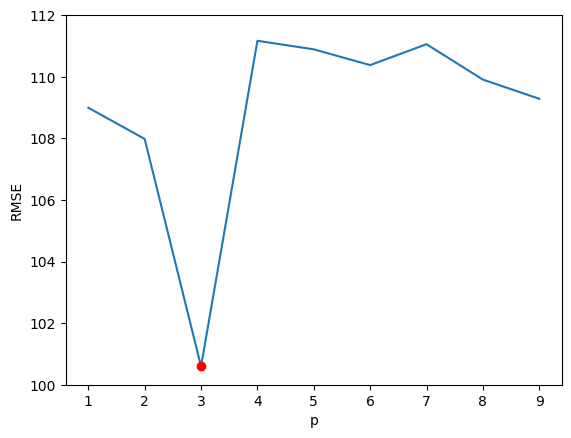

In [ ]:
plt.plot(range(1,10), jim_p_rmse)
plt.plot(3, jim_p_rmse[2], 'ro')

plt.xlabel('p')
plt.xticks(range(1,10))
plt.ylabel('RMSE')
plt.ylim(100, 112)

plt.show()

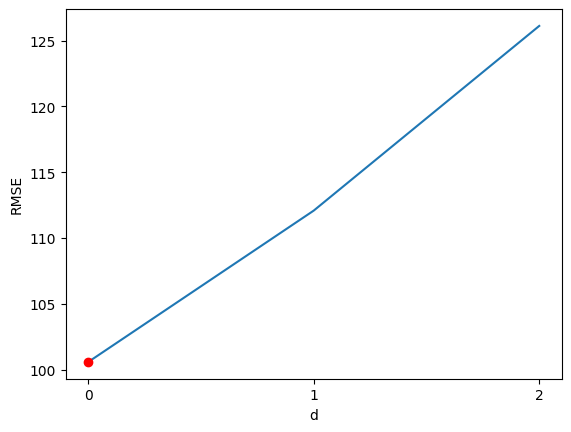

In [ ]:
plt.plot(range(3), jim_d_rmse)
plt.plot(0, jim_d_rmse[0], 'ro')

plt.xlabel('d')
plt.xticks(range(3))
plt.ylabel('RMSE')
#plt.ylim(9000, 20000)

plt.show()

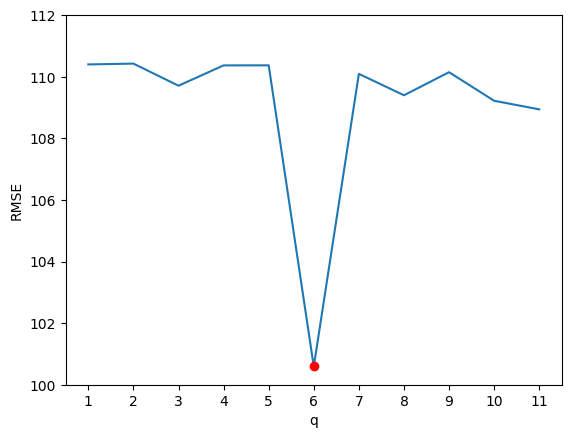

In [ ]:
plt.plot(range(1,12), jim_q_rmse)
plt.plot(6, jim_q_rmse[5], 'ro')

plt.xlabel('q')
plt.xticks(range(1,12))
plt.ylabel('RMSE')
plt.ylim(100, 112)

plt.show()

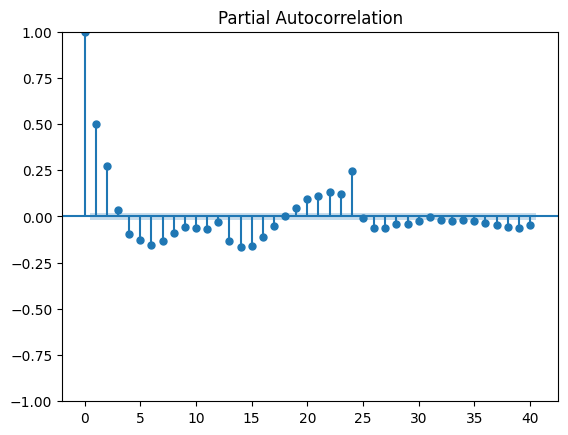

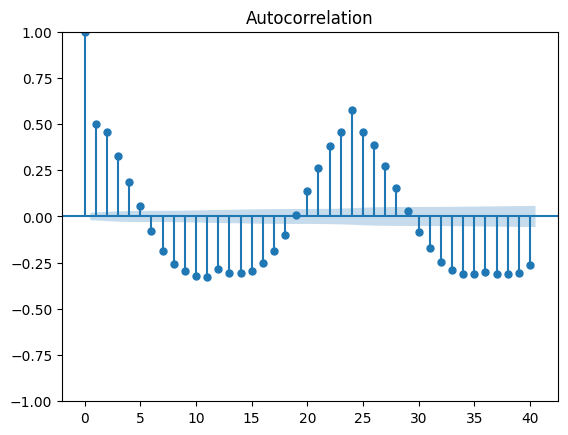

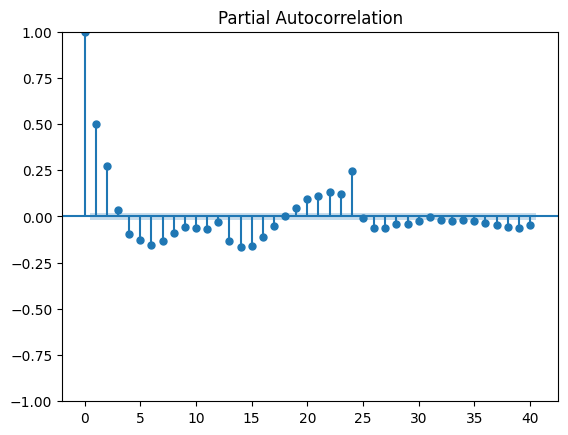

In [ ]:
plot_acf(df_abb_ma)
plot_pacf(df_abb_ma)

In [ ]:
warnings.filterwarnings("ignore")

minimum = 1000000

for p in range(1,13):
  for q in range(1,8):
    for d in range(1):
      rmse = arima(df_abb_ma, df_abb_log, df_abb_t, p, d, q)
      print(p,d,q,rmse)
      if rmse[1] < minimum:
        print('***min***')
        minimum = rmse[1]


1 0 1 (141272.44, 375.862, 0.914, datetime.timedelta(seconds=3, microseconds=68731))
***min***
1 0 2 (141322.034, 375.928, 0.915, datetime.timedelta(seconds=4, microseconds=763156))
1 0 3 (141316.267, 375.921, 0.915, datetime.timedelta(seconds=9, microseconds=666206))
1 0 4 (142861.083, 377.97, 0.869, datetime.timedelta(seconds=24, microseconds=138549))
1 0 5 (141549.112, 376.23, 0.915, datetime.timedelta(seconds=23, microseconds=966126))
1 0 6 (141520.106, 376.192, 0.915, datetime.timedelta(seconds=22, microseconds=116620))
1 0 7 (141553.331, 376.236, 0.915, datetime.timedelta(seconds=22, microseconds=74083))
2 0 1 (141364.997, 375.985, 0.915, datetime.timedelta(seconds=3, microseconds=460745))
2 0 2 (140626.076, 375.001, 0.913, datetime.timedelta(seconds=12, microseconds=713685))
***min***
2 0 3 (147363.095, 383.879, 0.942, datetime.timedelta(seconds=19, microseconds=998522))
2 0 4 (8348657666.273, 91370.989, 186711.117, datetime.timedelta(seconds=25, microseconds=978401))
2 0 5 (141

KeyboardInterrupt: 

In [ ]:
warnings.filterwarnings("ignore")

abb_p = []
abb_d = []
abb_q = []

for p in range(1, 13):
  rmse = arima(df_abb_ma, df_abb_log, df_abb_t, p, 0, 4)
  abb_p.append(rmse[1])
print('p is done.')

for d in range(3):
  rmse = arima(df_abb_ma, df_abb_log, df_abb_t, 6, d, 4)
  abb_d.append(rmse[1])
print('d is done.')

for q in range (1, 8):
  rmse = arima(df_abb_ma, df_abb_log, df_abb_t, 6, 0, q)
  abb_q.append(rmse[1])
print('q is done.')


p is done.
d is done.
q is done.


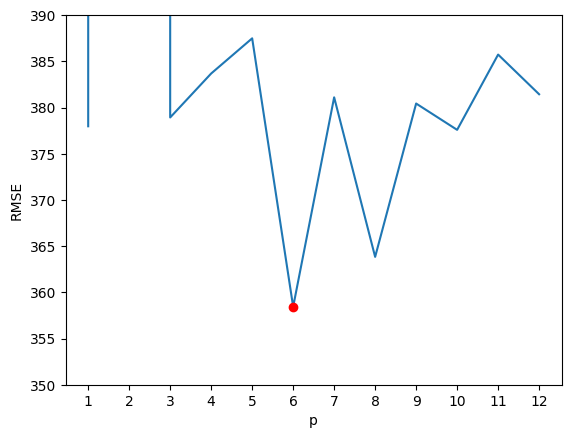

In [ ]:
plt.plot(range(1,13), abb_p)
plt.plot(6, abb_p[5], 'ro')

plt.xlabel('p')
plt.xticks(range(1,13))
plt.ylabel('RMSE')
plt.ylim(350, 390)

plt.show()

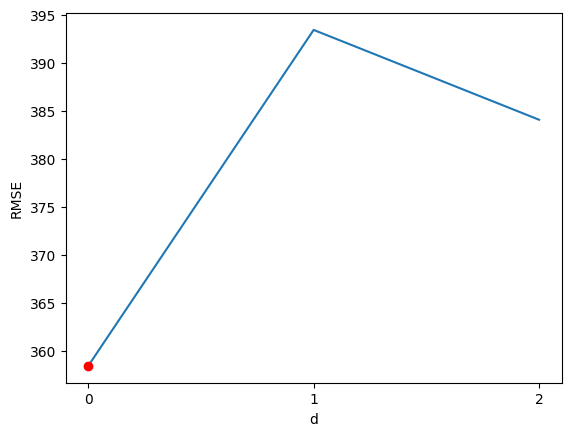

In [ ]:
plt.plot(range(3), abb_d)
plt.plot(0, abb_d[0], 'ro')

plt.xlabel('d')
plt.xticks(range(3))
plt.ylabel('RMSE')
#plt.ylim(100000, 160000)

plt.show()

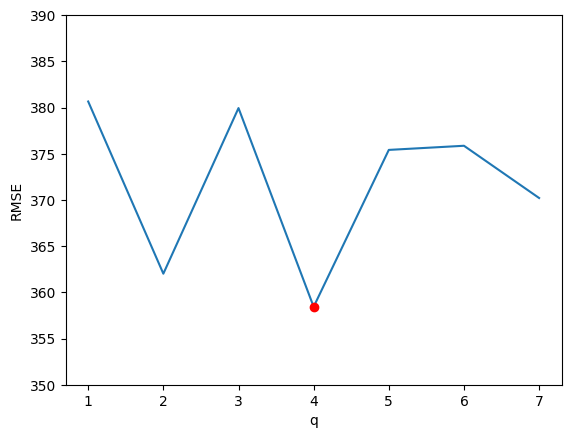

In [ ]:
plt.plot(range(1,8), abb_q)
plt.plot(4, abb_q[3], 'ro')

plt.xlabel('q')
plt.xticks(range(1,8))
plt.ylabel('RMSE')
plt.ylim(350, 390)

plt.show()

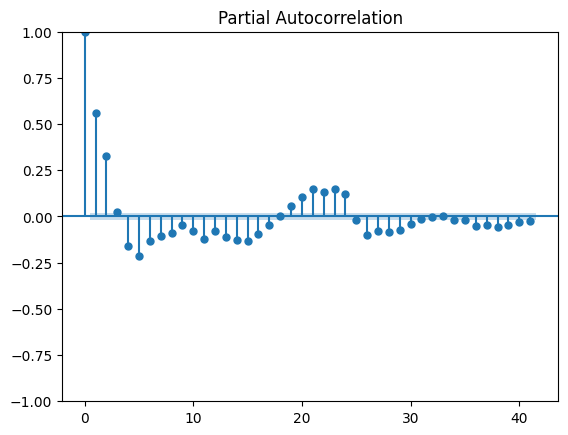

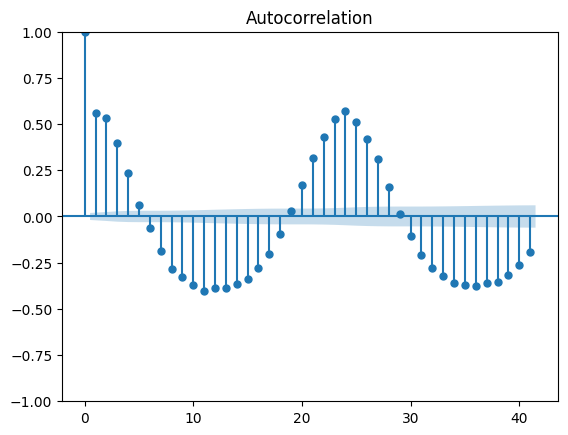

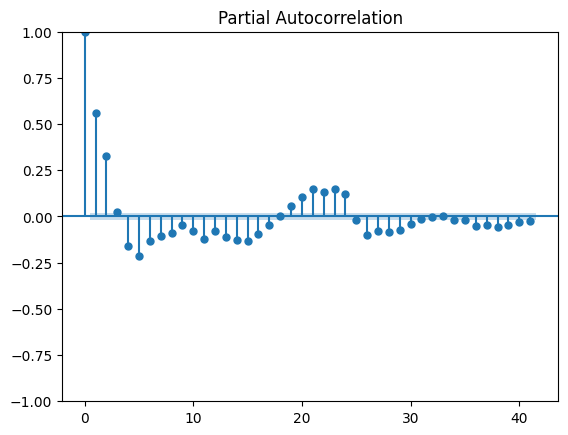

In [ ]:
plot_acf(df_sim_ma)
plot_pacf(df_sim_ma)

In [ ]:
warnings.filterwarnings("ignore")

minimum = 1000000

for p in range(1,13):
  for q in range(1,11):
    for d in range(1):
      rmse = arima(train_sim_ma, train_sim_log, train_sim_t, p, d, q)
      print(p,d,q,rmse)
      if rmse[1] < minimum:
        print('***min***')
        minimum = rmse[1]


1 0 1 (27507.343, 165.853, 1.116, datetime.timedelta(seconds=5, microseconds=386500))
***min***
1 0 2 (28384.88, 168.478, 1.143, datetime.timedelta(seconds=6, microseconds=754495))
1 0 3 (27948.924, 167.179, 1.129, datetime.timedelta(seconds=11, microseconds=158860))
1 0 4 (27626.604, 166.213, 1.118, datetime.timedelta(seconds=19, microseconds=93163))
1 0 5 (28183.078, 167.878, 1.134, datetime.timedelta(seconds=26, microseconds=150711))
1 0 6 (28493.951, 168.802, 1.143, datetime.timedelta(seconds=25, microseconds=273611))
1 0 7 (27751.949, 166.589, 1.122, datetime.timedelta(seconds=31, microseconds=446303))
1 0 8 (18348.477, 135.457, 0.793, datetime.timedelta(seconds=40, microseconds=163561))
***min***
1 0 9 (18558.492, 136.23, 0.809, datetime.timedelta(seconds=46, microseconds=529197))
1 0 10 (14505.631, 120.439, 0.624, datetime.timedelta(seconds=56, microseconds=696108))
***min***
2 0 1 (28553.131, 168.977, 1.149, datetime.timedelta(seconds=7, microseconds=113297))
2 0 2 (22049.294, 

In [ ]:
warnings.filterwarnings("ignore")

sim_p = []
sim_d = []
sim_q = []

for p in range(1, 13):
  rmse = arima(train_sim_ma, train_sim_log, train_sim_t, p, 0, 6)
  sim_p.append(rmse[1])
print('p is done.')

for d in range(3):
  rmse = arima(train_sim_ma, train_sim_log, train_sim_t, 8, d, 6)
  sim_d.append(rmse[1])
print('d is done.')

for q in range (1, 11):
  rmse = arima(train_sim_ma, train_sim_log, train_sim_t, 8, 0, q)
  sim_q.append(rmse[1])
print('q is done.')


p is done.
d is done.
q is done.


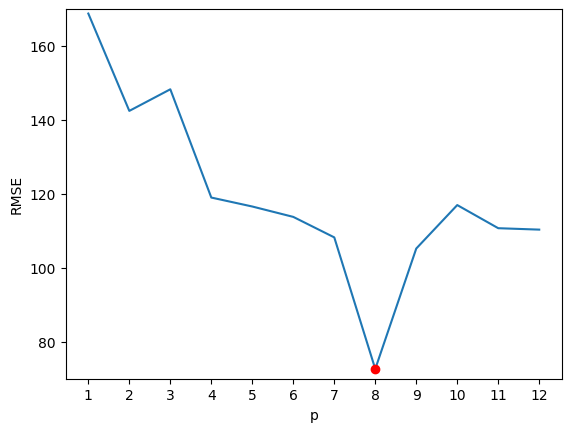

In [ ]:
plt.plot(range(1,13), sim_p)
plt.plot(8, sim_p[7], 'ro')

plt.xlabel('p')
plt.xticks(range(1,13))
plt.ylabel('RMSE')
plt.ylim(70, 170)

plt.show()

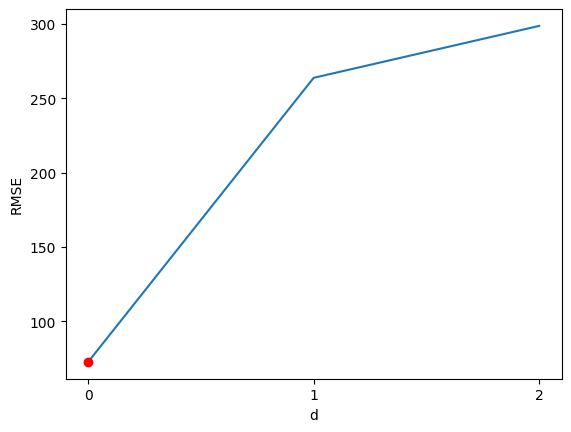

In [ ]:
plt.plot(range(3), sim_d)
plt.plot(0, sim_d[0], 'ro')

plt.xlabel('d')
plt.xticks(range(3))
plt.ylabel('RMSE')
#plt.ylim(0, 90000)

plt.show()

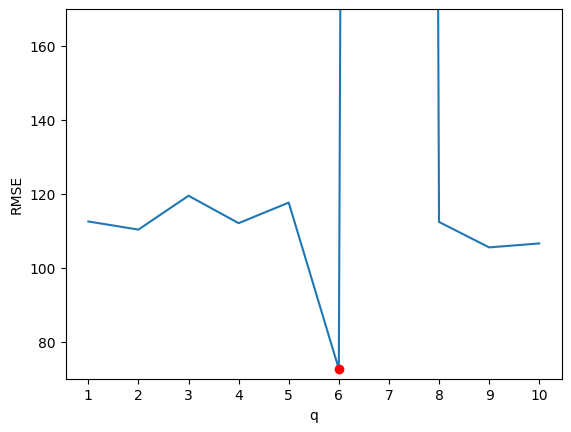

In [ ]:
plt.plot(range(1,11), sim_q)
plt.plot(6, sim_q[5], 'ro')

plt.xlabel('q')
plt.xticks(range(1,11))
plt.ylabel('RMSE')
plt.ylim(70, 170)

plt.show()

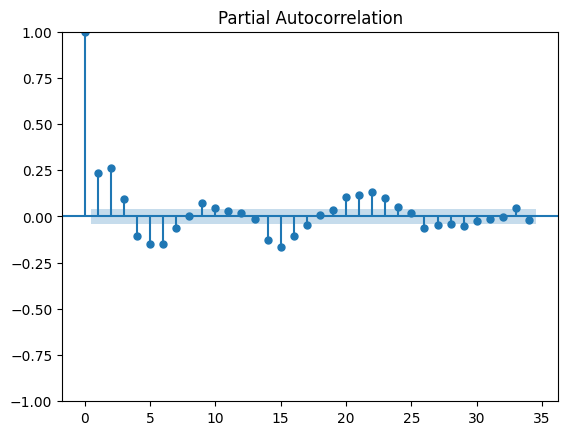

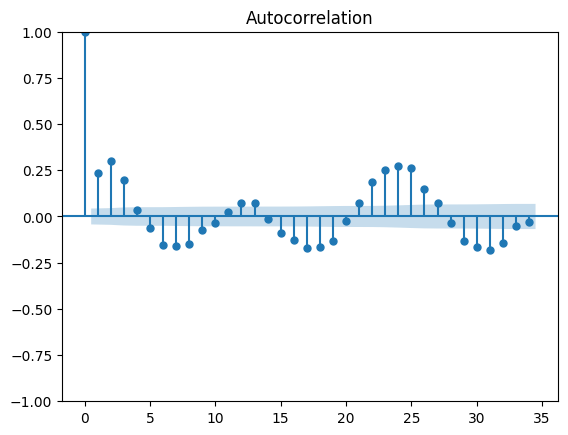

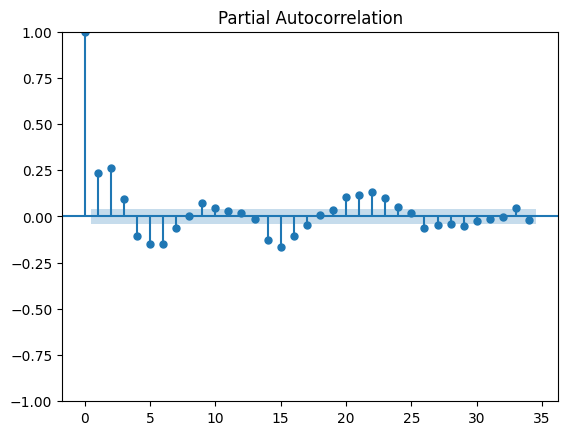

In [ ]:
plot_acf(df_kal_ma)
plot_pacf(df_kal_ma)

In [ ]:
warnings.filterwarnings("ignore")

minimum = 1000000

for p in range(1,8):
  for q in range(1,14):
    for d in range(1):
      rmse = arima(train_kal_ma, train_kal_log, train_kal_t, p, d, q)
      print(p,d,q,rmse)
      if rmse[1] < minimum:
        print('***min***')
        minimum = rmse[1]


1 0 1 (57886.585, 240.596, 0.485, datetime.timedelta(seconds=3, microseconds=617523))
***min***
1 0 2 (57381.538, 239.544, 0.483, datetime.timedelta(seconds=1, microseconds=33187))
***min***
1 0 3 (56808.306, 238.345, 0.478, datetime.timedelta(seconds=1, microseconds=428606))
***min***
1 0 4 (56856.671, 238.446, 0.479, datetime.timedelta(seconds=1, microseconds=904360))
1 0 5 (53325.423, 230.923, 0.427, datetime.timedelta(seconds=7, microseconds=374870))
***min***
1 0 6 (51011.348, 225.857, 0.41, datetime.timedelta(seconds=4, microseconds=405385))
***min***
1 0 7 (54533.488, 233.524, 0.435, datetime.timedelta(seconds=5, microseconds=883786))
1 0 8 (51504.873, 226.947, 0.413, datetime.timedelta(seconds=10, microseconds=571447))
1 0 9 (51469.619, 226.869, 0.412, datetime.timedelta(seconds=11, microseconds=500124))
1 0 10 (24697.609, 157.155, 0.193, datetime.timedelta(seconds=13, microseconds=634037))
***min***
1 0 11 (51443.533, 226.812, 0.415, datetime.timedelta(seconds=12, microseconds

In [ ]:
warnings.filterwarnings("ignore")

kal_p = []
kal_d = []
kal_q = []

for p in range(1, 9):
  rmse = arima(train_kal_ma, train_kal_log, train_kal_t, p, 0, 10)
  kal_p.append(rmse[1])
print('p is done.')

for d in range(3):
  rmse = arima(train_kal_ma, train_kal_log, train_kal_t, 1, d, 10)
  kal_d.append(rmse[1])
print('d is done.')

for q in range (1, 14):
  rmse = arima(train_kal_ma, train_kal_log, train_kal_t, 1, 0, q)
  kal_q.append(rmse[1])
print('q is done.')


p is done.
d is done.
q is done.


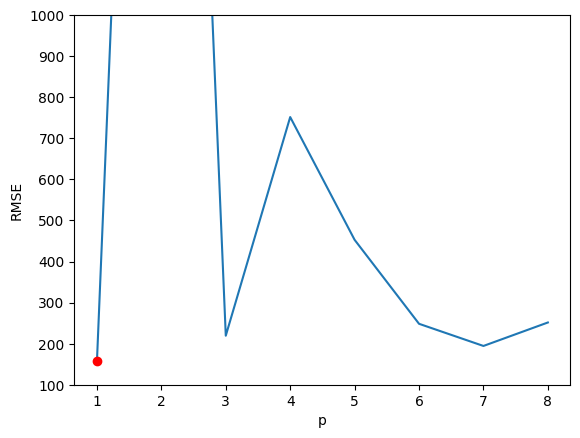

In [ ]:
plt.plot(range(1,9), kal_p)
plt.plot(1, kal_p[0], 'ro')

plt.xlabel('p')
plt.xticks(range(1,9))
plt.ylabel('RMSE')
plt.ylim(100, 1000)

plt.show()

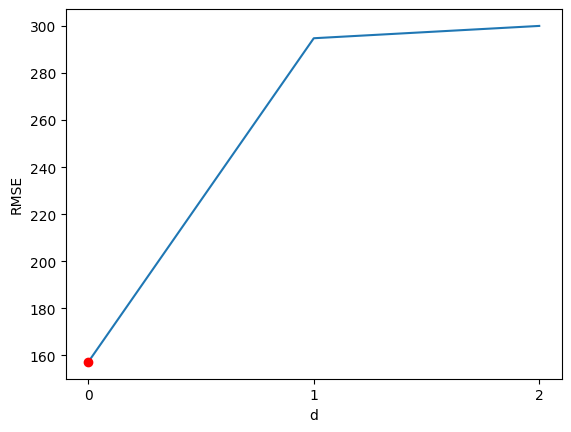

In [ ]:
plt.plot(range(3), kal_d)
plt.plot(0, kal_d[0], 'ro')

plt.xlabel('d')
plt.xticks(range(3))
plt.ylabel('RMSE')
#plt.ylim(30000, 110000)

plt.show()

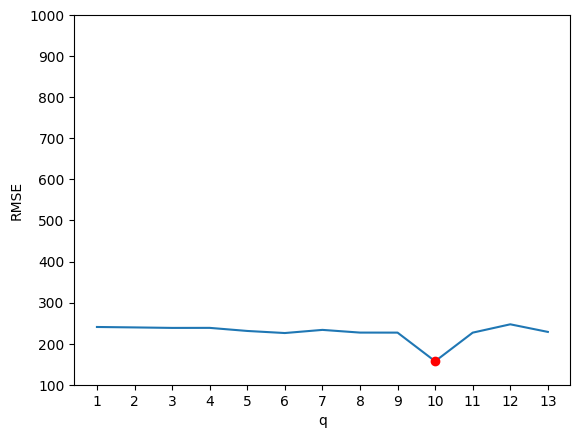

In [ ]:
plt.plot(range(1,14), kal_q)
plt.plot(10, kal_q[9], 'ro')

plt.xlabel('q')
plt.xticks(range(1,14))
plt.ylabel('RMSE')
plt.ylim(100, 1000)

plt.show()

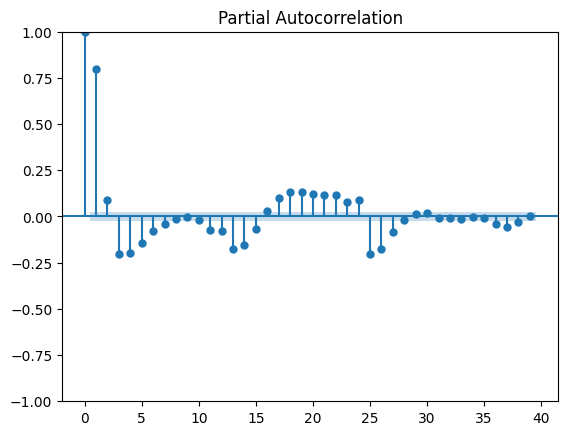

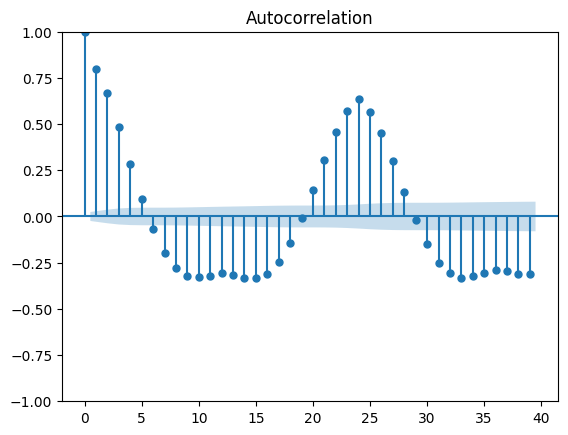

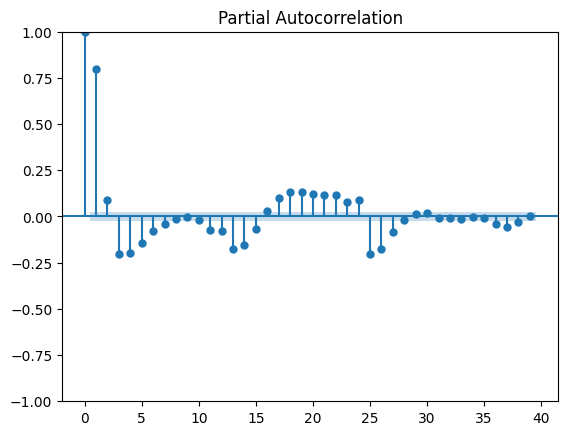

In [ ]:
plot_acf(df_wes_ma)
plot_pacf(df_wes_ma)

In [ ]:
warnings.filterwarnings("ignore")

minimum = 1000000

for p in range(1,10):
  for q in range(1,10):
    for d in range(1):
      rmse = arima(train_wes_ma, train_wes_log, train_wes_t, p, d, q)
      print(p,d,q,rmse)
      if rmse[1] < minimum:
        print('***min***')
        minimum = rmse[1]


1 0 1 (11292785.548, 3360.474, 37.874, datetime.timedelta(seconds=1, microseconds=677939))
***min***
1 0 2 (11163580.129, 3341.194, 37.474, datetime.timedelta(seconds=2, microseconds=74638))
***min***
1 0 3 (11457081.959, 3384.831, 38.466, datetime.timedelta(seconds=3, microseconds=462604))
1 0 4 (10832049.052, 3291.208, 36.418, datetime.timedelta(seconds=7, microseconds=59478))
***min***
1 0 5 (10361975.445, 3219.002, 34.847, datetime.timedelta(seconds=9, microseconds=746243))
***min***
1 0 6 (62048000154009.87, 7877055.297, 248135830.149, datetime.timedelta(seconds=20, microseconds=906188))
1 0 7 (11153429.444, 3339.675, 39.338, datetime.timedelta(seconds=14, microseconds=399145))
1 0 8 (10755550.464, 3279.566, 37.783, datetime.timedelta(seconds=16, microseconds=198403))
1 0 9 (70638849.222, 8404.692, 280.363, datetime.timedelta(seconds=30, microseconds=706610))
2 0 1 (11760434.395, 3429.349, 39.39, datetime.timedelta(seconds=6, microseconds=588521))
2 0 2 (10386605.445, 3222.826, 35

In [ ]:
warnings.filterwarnings("ignore")

wes_p = []
wes_d = []
wes_q = []

for p in range(1,12):
  rmse = arima(train_wes_ma, train_wes_log, train_wes_t, p, 0, 9)
  print(rmse)
  wes_p.append(rmse[1])
print('p is done.')

for d in range(3):
  rmse = arima(train_wes_ma, train_wes_log, train_wes_t, 5, d, 9)
  print(rmse)
  wes_d.append(rmse[1])
print('d is done.')

for q in range (1, 13):
  rmse = arima(train_wes_ma, train_wes_log, train_wes_t, 5, 0, q)
  print(rmse)
  wes_q.append(rmse[1])
print('q is done.')


(70638849.222, 8404.692, 280.363, datetime.timedelta(seconds=31, microseconds=516016))
(1031979.39, 1015.864, 3.981, datetime.timedelta(seconds=42, microseconds=176073))
(13583510.454, 3685.581, 46.86, datetime.timedelta(seconds=34, microseconds=615708))
(123791873.365, 11126.18, 415.376, datetime.timedelta(seconds=39, microseconds=230892))
(115954.987, 340.522, 0.87, datetime.timedelta(seconds=43, microseconds=245746))
(8232696.559, 2869.268, 28.594, datetime.timedelta(seconds=43, microseconds=939851))
(15929146.148, 3991.133, 54.758, datetime.timedelta(seconds=49, microseconds=978649))
(1161361.302, 1077.665, 4.4, datetime.timedelta(seconds=56, microseconds=392064))
(1700218366.126, 41233.704, 5540.298, datetime.timedelta(seconds=60, microseconds=881924))
(120516.183, 347.154, 0.967, datetime.timedelta(seconds=59, microseconds=840857))
(307936.639, 554.92, 1.732, datetime.timedelta(seconds=79, microseconds=95651))
p is done.
(115954.987, 340.522, 0.87, datetime.timedelta(seconds=43, 

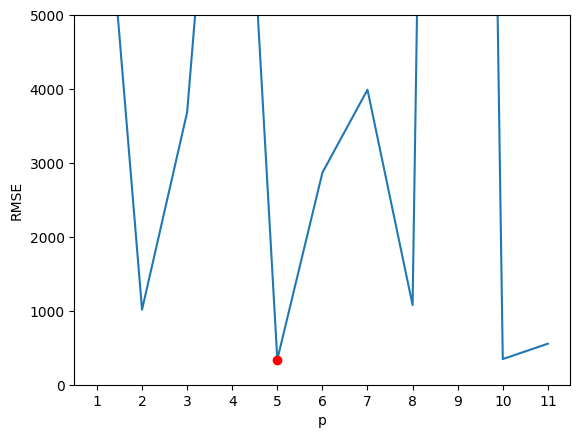

In [ ]:
plt.plot(range(1,12), wes_p)
plt.plot(5, wes_p[4], 'ro')

plt.xlabel('p')
plt.xticks(range(1,12))
plt.ylabel('RMSE')
plt.ylim(0, 5000)

plt.show()

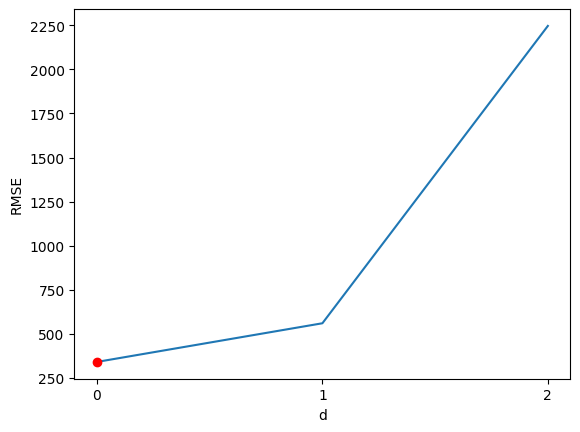

In [ ]:
plt.plot(range(3), wes_d)
plt.plot(0, wes_d[0], 'ro')

plt.xlabel('d')
plt.xticks(range(3))
plt.ylabel('RMSE')
#plt.ylim(0, 10000000)

plt.show()

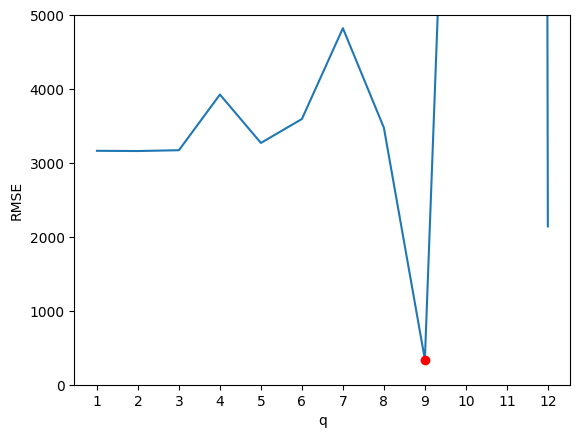

In [ ]:
plt.plot(range(1,13), wes_q)
plt.plot(9, wes_q[8], 'ro')

plt.xlabel('q')
plt.xticks(range(1,13))
plt.ylabel('RMSE')
plt.ylim(0, 5000)

plt.show()

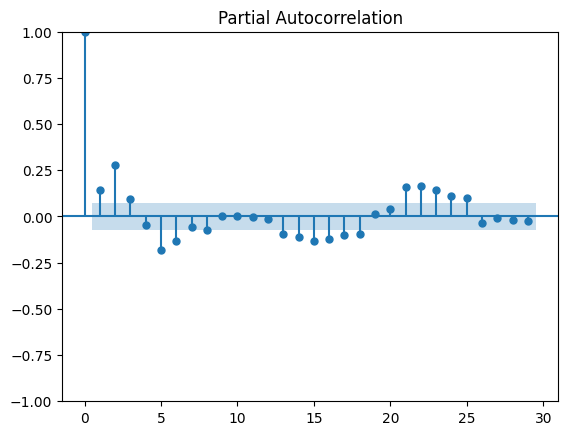

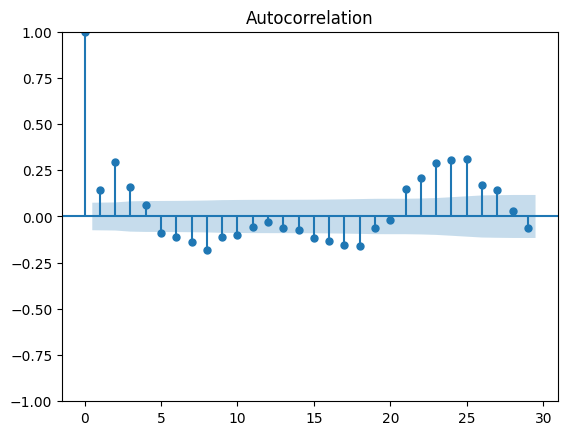

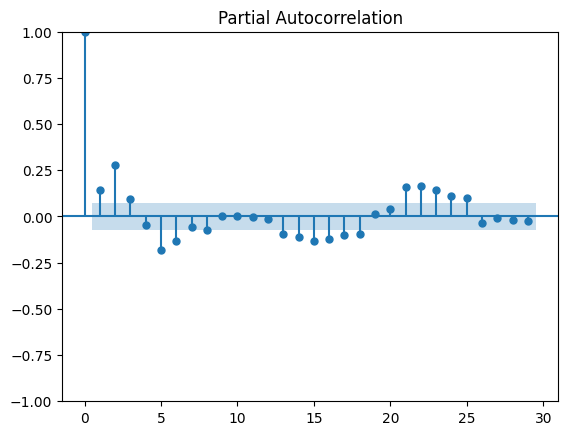

In [ ]:
plot_acf(df_ara_ma)
plot_pacf(df_ara_ma)

In [ ]:
warnings.filterwarnings("ignore")

minimum = 1000000

for p in range(1,10):
  for q in range(1,13):
    for d in range(1):
      rmse = arima(train_ara_ma, train_ara_log, train_ara_t, p, d, q)
      print(p,d,q,rmse)
      if rmse[1] < minimum:
        print('***min***')
        minimum = rmse[1]


1 0 1 (21708.141, 147.337, 0.212, datetime.timedelta(microseconds=769176))
***min***
1 0 2 (26993.665, 164.297, 0.26, datetime.timedelta(seconds=2, microseconds=83933))
1 0 3 (26933.176, 164.113, 0.259, datetime.timedelta(seconds=2, microseconds=309796))
1 0 4 (25791.967, 160.599, 0.248, datetime.timedelta(seconds=1, microseconds=921782))
1 0 5 (10084.852, 100.423, 0.1, datetime.timedelta(seconds=1, microseconds=795336))
***min***
1 0 6 (13268.93, 115.191, 0.134, datetime.timedelta(seconds=2, microseconds=167294))
1 0 7 (12832.119, 113.279, 0.124, datetime.timedelta(seconds=2, microseconds=325154))
1 0 8 (195409.878, 442.052, 1.848, datetime.timedelta(seconds=6, microseconds=8128))
1 0 9 (14051.671, 118.54, 0.141, datetime.timedelta(seconds=3, microseconds=514657))
1 0 10 (23437.86, 153.094, 0.236, datetime.timedelta(seconds=4, microseconds=192398))
1 0 11 (24647.247, 156.994, 0.255, datetime.timedelta(seconds=7, microseconds=135316))
1 0 12 (11477.101, 107.131, 0.107, datetime.timedel

KeyboardInterrupt: 

In [ ]:
warnings.filterwarnings("ignore")

ara_p = []
ara_d = []
ara_q = []

for p in range(1,10):
  rmse = arima(train_ara_ma, train_ara_log, train_ara_t, p, 0, 6)
  ara_p.append(rmse[1])
print('p is done.')

for d in range(3):
  rmse = arima(train_ara_ma, train_ara_log, train_ara_t, 2, d, 6)
  ara_d.append(rmse[1])
print('d is done.')

for q in range (1, 14):
  rmse = arima(train_ara_ma, train_ara_log, train_ara_t, 2, 0, q)
  ara_q.append(rmse[1])
print('q is done.')


p is done.
d is done.
q is done.


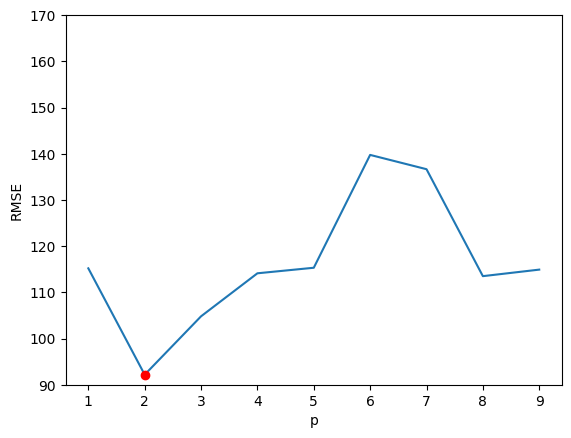

In [ ]:
plt.plot(range(1,10), ara_p)
plt.plot(2, ara_p[1], 'ro')

plt.xlabel('p')
plt.xticks(range(1,10))
plt.ylabel('RMSE')
plt.ylim(90, 170)

plt.show()

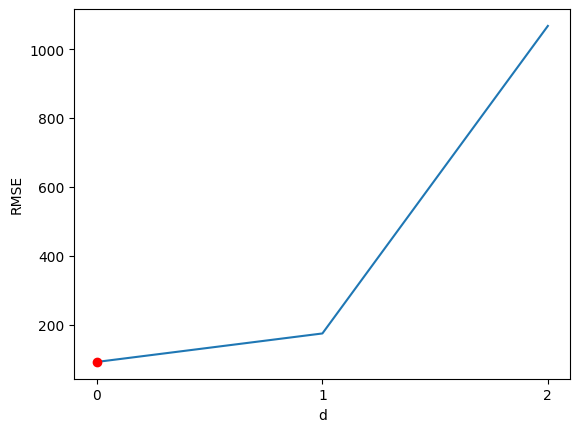

In [ ]:
plt.plot(range(3), ara_d)
plt.plot(0, ara_d[0], 'ro')

plt.xlabel('d')
plt.xticks(range(3))
plt.ylabel('RMSE')
#plt.ylim(5000, 80000)

plt.show()

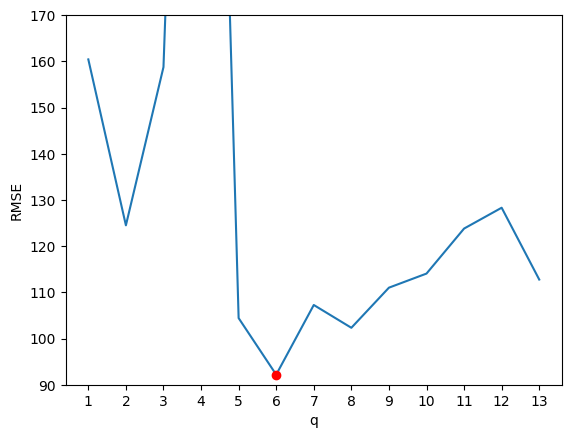

In [ ]:
plt.plot(range(1,14), ara_q)
plt.plot(6, ara_q[5], 'ro')

plt.xlabel('q')
plt.xticks(range(1,14))
plt.ylabel('RMSE')
plt.ylim(90, 170)

plt.show()

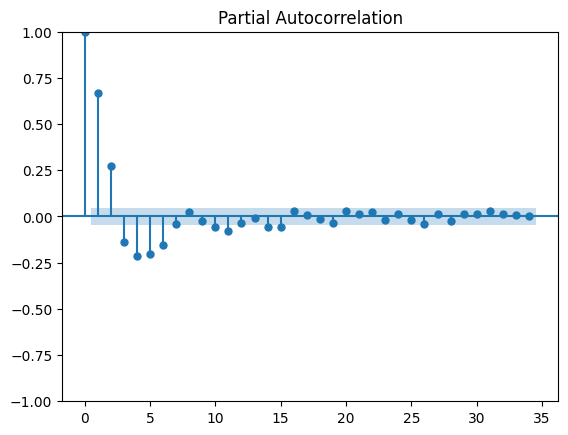

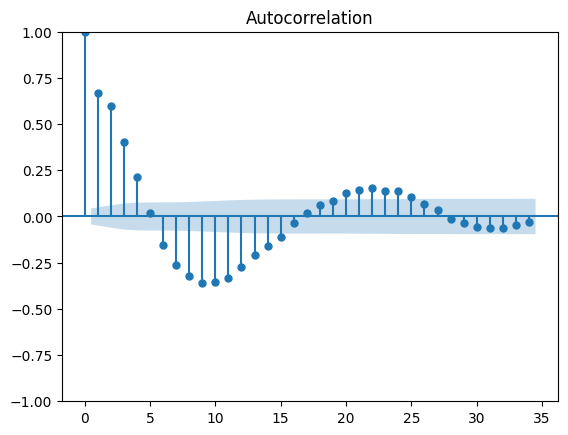

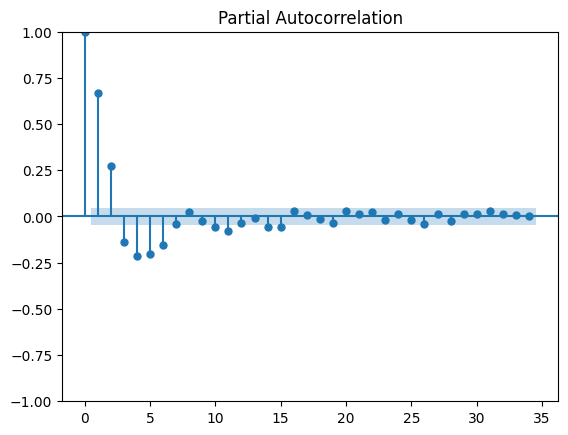

In [ ]:
plot_acf(df_sha_ma)
plot_pacf(df_sha_ma)

In [ ]:
warnings.filterwarnings("ignore")

minimum = 1000000

for p in range(1,10):
  for q in range(1,11):
    for d in range(1):
      rmse = arima(train_sha_ma, train_sha_log, train_sha_t, p, d, q)
      print(p,d,q,rmse)
      if rmse[1] < minimum:
        print('***min***')
        minimum = rmse[1]


1 0 1 (26631.002, 163.19, 0.758, datetime.timedelta(microseconds=775030))
***min***
1 0 2 (27300.349, 165.228, 0.772, datetime.timedelta(microseconds=747889))
1 0 3 (27432.42, 165.627, 0.775, datetime.timedelta(seconds=1, microseconds=710463))
1 0 4 (27573.079, 166.051, 0.777, datetime.timedelta(seconds=1, microseconds=992444))
1 0 5 (27651.258, 166.287, 0.778, datetime.timedelta(seconds=6, microseconds=358944))
1 0 6 (164328.309, 405.374, 5.249, datetime.timedelta(seconds=5, microseconds=798764))
1 0 7 (512357.306, 715.791, 15.856, datetime.timedelta(seconds=8, microseconds=942820))
1 0 8 (715638.828, 845.954, 22.685, datetime.timedelta(seconds=7, microseconds=360519))
1 0 9 (17292.87, 131.502, 0.54, datetime.timedelta(seconds=11, microseconds=569592))
***min***
1 0 10 (27567.451, 166.034, 0.8, datetime.timedelta(seconds=13, microseconds=848372))
2 0 1 (26959.298, 164.193, 0.766, datetime.timedelta(seconds=1, microseconds=460510))
2 0 2 (26440.493, 162.605, 0.737, datetime.timedelta(s

In [ ]:
warnings.filterwarnings("ignore")

sha_p = []
sha_d = []
sha_q = []

for p in range(1,11):
  rmse = arima(train_sha_ma, train_sha_log, train_sha_t, p, 0, 10)
  sha_p.append(rmse[1])
print('p is done.')

for d in range(3):
  rmse = arima(train_sha_ma, train_sha_log, train_sha_t, 2, d, 10)
  sha_d.append(rmse[1])
print('d is done.')

for q in range (1, 12):
  rmse = arima(train_sha_ma, train_sha_log, train_sha_t, 2, 0, q)
  sha_q.append(rmse[1])
print('q is done.')


p is done.
d is done.
q is done.


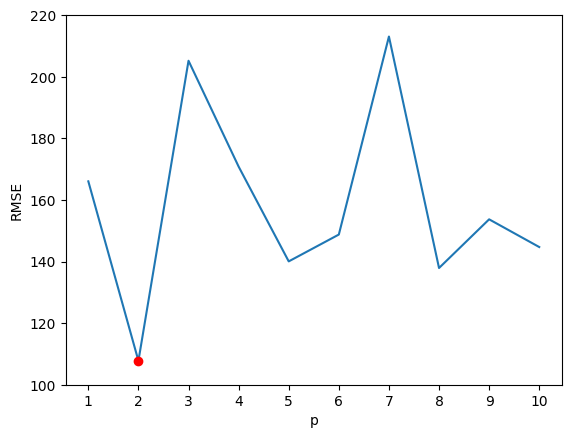

In [ ]:
plt.plot(range(1,11), sha_p)
plt.plot(2, sha_p[1], 'ro')

plt.xlabel('p')
plt.xticks(range(1,11))
plt.ylabel('RMSE')
plt.ylim(100, 220)

plt.show()

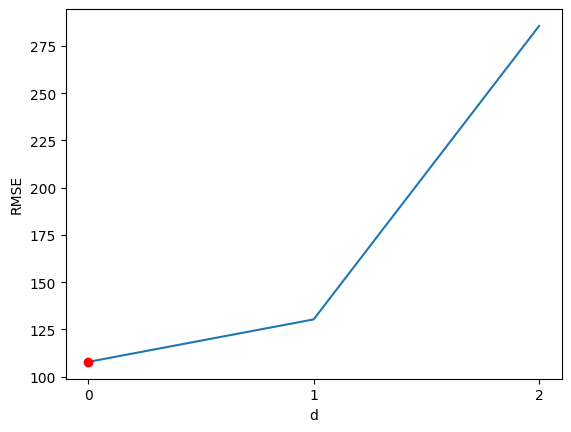

In [ ]:
plt.plot(range(3), sha_d)
plt.plot(0, sha_d[0], 'ro')

plt.xlabel('d')
plt.xticks(range(3))
plt.ylabel('RMSE')
#plt.ylim(10000, 30000)

plt.show()

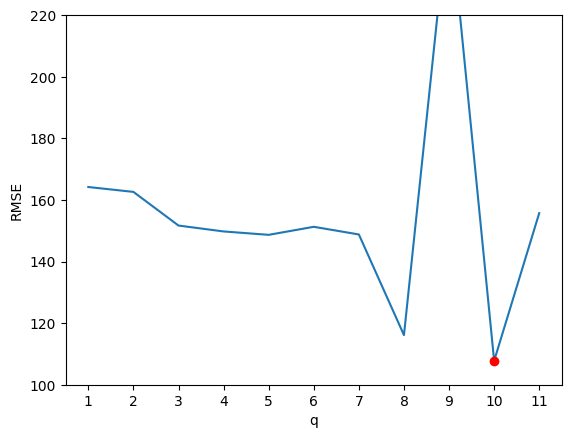

In [ ]:
plt.plot(range(1,12), sha_q)
plt.plot(10, sha_q[9], 'ro')

plt.xlabel('q')
plt.xticks(range(1,12))
plt.ylabel('RMSE')
plt.ylim(100, 220)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

print('\njim:', arima(train_jim_ma, train_jim_log, train_jim_t, 3, 0, 6))
print('jim:', arima_forecast(train_jim_ma, test_jim_log, test_jim_t, 778, 3, 0, 6))

print('\nabb:', arima(train_abb_ma, train_abb_log, train_abb_t, 6, 0, 4))
print('abb:', arima_forecast(train_abb_ma, test_abb_log, test_abb_t, 1732, 6, 0, 4))

print('\nsim:', arima(train_sim_ma, train_sim_log, train_sim_t, 8, 0, 6))
print('sim:', arima_forecast(train_sim_ma, test_sim_log, test_sim_t, 2124, 8, 0, 6))

print('\nkal:', arima(train_kal_ma, train_kal_log, train_kal_t, 1, 0, 10))
print('kal:', arima_forecast(train_kal_ma, test_kal_log, test_kal_t, 340, 1, 0, 10))

print('\nwes:', arima(train_wes_ma, train_wes_log, train_wes_t, 5, 0, 9))
print('wes:', arima_forecast(train_wes_ma, test_wes_log, test_wes_t, 1157, 5, 0, 9))

print('\nara:', arima(train_ara_ma, train_ara_log, train_ara_t, 2, 0, 6))
print('ara:', arima_forecast(train_ara_ma, test_ara_log, test_ara_t, 103, 2, 0, 6))

print('\nsha:', arima(train_sha_ma, train_sha_log, train_sha_t, 2, 0, 10))
print('sha:', arima_forecast(train_sha_ma, test_sha_log, test_sha_t, 314, 2, 0, 10))



jim: (218144.847, 467.06, 9.434, datetime.timedelta(seconds=11, microseconds=160999))
jim: (6893.997, 83.03, 0.565, datetime.timedelta(seconds=10, microseconds=723635))

abb: (103472.871, 321.672, 0.914, datetime.timedelta(seconds=18, microseconds=1128))
abb: (202540.466, 450.045, 0.655, datetime.timedelta(seconds=15, microseconds=468954))

sim: (20465.167, 143.057, 0.927, datetime.timedelta(seconds=30, microseconds=511140))
sim: (11470.419, 107.1, 0.424, datetime.timedelta(seconds=30, microseconds=306175))

kal: (24698.045, 157.156, 0.193, datetime.timedelta(seconds=8, microseconds=907362))
kal: (16172.238, 127.17, 0.179, datetime.timedelta(seconds=8, microseconds=183248))

wes: (740411.75, 860.472, 2.993, datetime.timedelta(seconds=26, microseconds=345232))
wes: (113566.155, 336.996, 0.483, datetime.timedelta(seconds=26, microseconds=513634))

ara: (8477.873, 92.075, 0.08, datetime.timedelta(seconds=3, microseconds=413281))
ara: (13512.944, 116.245, 0.138, datetime.timedelta(seconds

In [ ]:
warnings.filterwarnings("ignore")

print('jim:', arima(df_jim_ma, df_jim_log, df_jim_t, 3, 0, 6))
print('abb:', arima(df_abb_ma, df_abb_log, df_abb_t, 6, 0, 4))
print('sim:', arima(df_sim_ma, df_sim_log, df_sim_t, 8, 0, 6))
print('kal:', arima(df_kal_ma, df_kal_log, df_kal_t, 1, 0, 10))
print('wes:', arima(df_wes_ma, df_wes_log, df_wes_t, 5, 0, 9))
print('ara:', arima(df_ara_ma, df_ara_log, df_ara_t, 2, 0, 6))
print('sha:', arima(df_sha_ma, df_sha_log, df_sha_t, 2, 0, 10))

jim: (10118.744, 100.592, 0.756, datetime.timedelta(seconds=19, microseconds=479429))
abb: (128475.733, 358.435, 0.768, datetime.timedelta(seconds=41, microseconds=23549))
sim: (93551.227, 305.861, 4.545, datetime.timedelta(seconds=101, microseconds=139620))
kal: (34616.081, 186.054, 0.261, datetime.timedelta(seconds=14, microseconds=607517))
wes: (120206362.993, 10963.866, 443.673, datetime.timedelta(seconds=60, microseconds=258778))
ara: (18739.315, 136.892, 0.187, datetime.timedelta(seconds=3, microseconds=516440))
sha: (12579.153, 112.157, 0.405, datetime.timedelta(seconds=15, microseconds=456078))


## SARIMA

In [ ]:
warnings.filterwarnings("ignore")

jim_s = [109.565]
minimum = 1000000

for s in range(2,9):
  rmse = sarima(train_jim_ma, train_jim_log, train_jim_t, 3, 0, 6, s)
  print(s,rmse)
  jim_s.append(rmse[1])
  if rmse[0] < minimum:
    print('***min***')
    minimum = rmse[0]


2 (70838.964, 266.156, 2.741, datetime.timedelta(seconds=15, microseconds=47242))
***min***
3 (72126.273, 268.563, 2.78, datetime.timedelta(seconds=23, microseconds=963697))
4 (131088.967, 362.062, 4.577, datetime.timedelta(seconds=23, microseconds=37181))
5 (104446.114, 323.181, 3.783, datetime.timedelta(seconds=37, microseconds=641169))
6 (109486.4, 330.887, 3.942, datetime.timedelta(seconds=58, microseconds=355464))
7 (126246.236, 355.311, 4.437, datetime.timedelta(seconds=64, microseconds=285422))
8 (107527.963, 327.915, 3.881, datetime.timedelta(seconds=111, microseconds=926715))


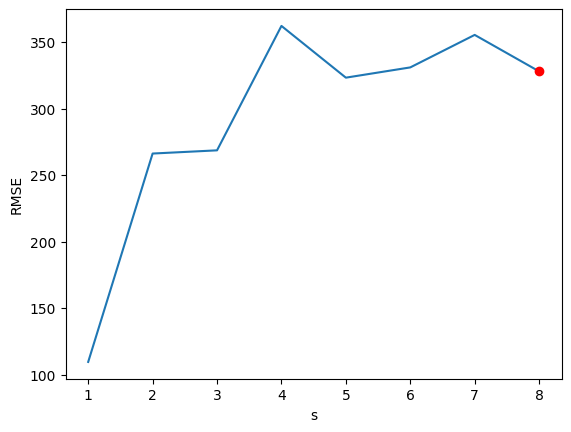

In [ ]:
plt.plot(range(1,9), jim_s)
plt.plot(8, jim_s[7], 'ro')

plt.xlabel('s')
plt.xticks(range(1,9))
plt.ylabel('RMSE')

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

abb_s = [331.082]
minimum = 1000000

for s in range(2,9):
  rmse = sarima(train_abb_ma, train_abb_log, train_abb_t, 6, 0, 4, s)
  print(s,rmse)
  abb_s.append(rmse[1])
  if rmse[1] < minimum:
    print('***min***')
    minimum = rmse[1]


2 (84974.436, 291.504, 0.774, datetime.timedelta(seconds=35, microseconds=374135))
***min***
3 (84970.196, 291.496, 0.774, datetime.timedelta(seconds=35, microseconds=558330))
***min***
4 (80561.447, 283.833, 0.737, datetime.timedelta(seconds=49, microseconds=316171))
***min***
5 (61093.15, 247.17, 0.579, datetime.timedelta(seconds=66, microseconds=470824))
***min***
6 (94427.424, 307.29, 0.846, datetime.timedelta(seconds=84, microseconds=586864))
7 (46168.546, 214.869, 0.449, datetime.timedelta(seconds=109, microseconds=549677))
***min***
8 (95537.643, 309.092, 0.851, datetime.timedelta(seconds=136, microseconds=302104))


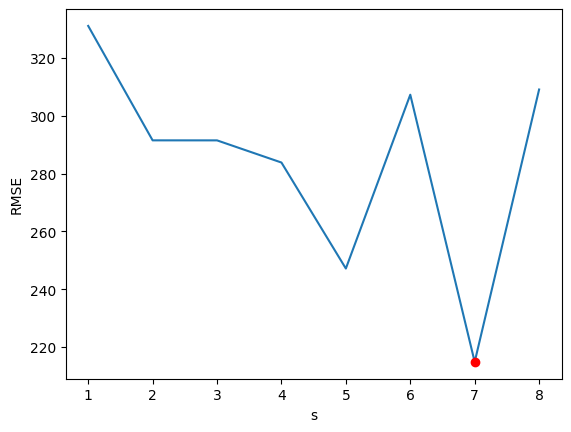

In [ ]:
plt.plot(range(1,9), abb_s)
plt.plot(7, abb_s[6], 'ro')

plt.xlabel('s')
plt.xticks(range(1,9))
plt.ylabel('RMSE')
#plt.ylim(9000, 20000)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

sim_s = [72.639]
minimum = 1000000

for s in range(2,9):
  rmse = sarima(train_sim_ma, train_sim_log, train_sim_t, 8, 0, 6, s)
  print(s,rmse)
  sim_s.append(rmse[1])
  if rmse[1] < minimum:
    print('***min***')
    minimum = rmse[1]


2 (9812.567, 99.058, 0.434, datetime.timedelta(seconds=50, microseconds=316873))
***min***
3 (11226.421, 105.955, 0.488, datetime.timedelta(seconds=64, microseconds=535964))
4 (4383.844, 66.211, 0.223, datetime.timedelta(seconds=108, microseconds=469360))
***min***
5 (6725.835, 82.011, 0.364, datetime.timedelta(seconds=145, microseconds=480988))
6 (4494.238, 67.039, 0.229, datetime.timedelta(seconds=179, microseconds=564150))
7 (4461.325, 66.793, 0.224, datetime.timedelta(seconds=256, microseconds=767426))
8 (6306.088, 79.411, 0.298, datetime.timedelta(seconds=330, microseconds=454789))


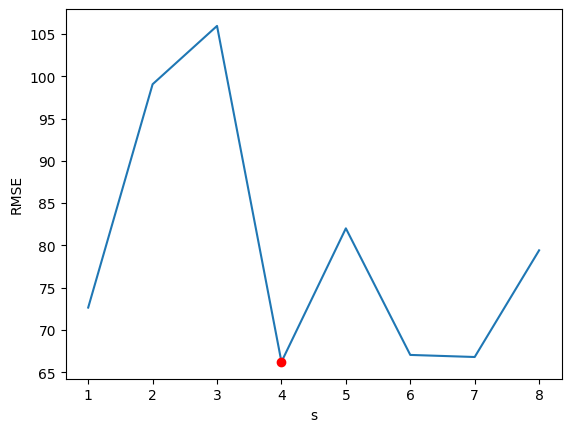

In [ ]:
plt.plot(range(1,9), sim_s)
plt.plot(4, sim_s[3], 'ro')

plt.xlabel('s')
plt.xticks(range(1,9))
plt.ylabel('RMSE')
#plt.ylim(9000, 20000)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

kal_s = [157.155]
minimum = 1000000

for s in range(2,9):
  rmse = sarima(train_kal_ma, train_kal_log, train_kal_t, 1, 0, 10, s)
  print(s,rmse)
  kal_s.append(rmse[1])
  if rmse[1] < minimum:
    print('***min***')
    minimum = rmse[1]


2 (21271.673, 145.848, 0.181, datetime.timedelta(seconds=18, microseconds=135727))
***min***
3 (12786.609, 113.078, 0.099, datetime.timedelta(seconds=12, microseconds=449916))
***min***
4 (11415.485, 106.843, 0.092, datetime.timedelta(seconds=23, microseconds=990423))
***min***
5 (16391.845, 128.031, 0.136, datetime.timedelta(seconds=38, microseconds=156960))
6 (14730.051, 121.367, 0.119, datetime.timedelta(seconds=88, microseconds=19475))
7 (10222.974, 101.109, 0.082, datetime.timedelta(seconds=61, microseconds=610858))
***min***
8 (20211.896, 142.169, 0.162, datetime.timedelta(seconds=123, microseconds=297027))


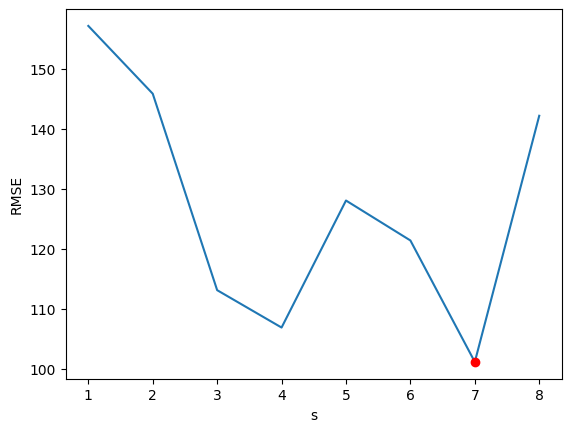

In [ ]:
plt.plot(range(1,9), kal_s)
plt.plot(7, kal_s[6], 'ro')

plt.xlabel('s')
plt.xticks(range(1,9))
plt.ylabel('RMSE')
#plt.ylim(9000, 20000)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

wes_s = [340.522]
minimum = 1000000

for s in range(2,9):
  rmse = sarima(train_wes_ma, train_wes_log, train_wes_t, 5, 0, 9, s)
  print(s,rmse)
  wes_s.append(rmse[1])
  if rmse[1] < minimum:
    print('***min***')
    minimum = rmse[1]


2 (3373873.824, 1836.811, 11.847, datetime.timedelta(seconds=37, microseconds=420789))
***min***
3 (2789411.038, 1670.153, 9.899, datetime.timedelta(seconds=53, microseconds=11228))
***min***
4 (7427109.531, 2725.272, 25.175, datetime.timedelta(seconds=85, microseconds=887262))
5 (1442338.308, 1200.974, 5.443, datetime.timedelta(seconds=126, microseconds=346807))
***min***
6 (5256339.734, 2292.671, 17.982, datetime.timedelta(seconds=169, microseconds=13245))
7 (1561098.0, 1249.439, 6.089, datetime.timedelta(seconds=238, microseconds=527773))
8 (5846640.322, 2417.983, 20.114, datetime.timedelta(seconds=275, microseconds=52415))


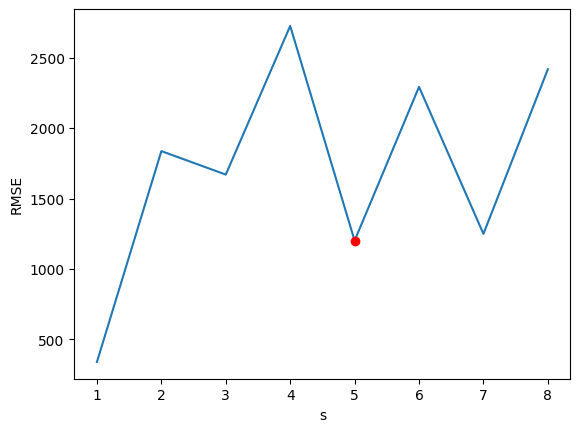

In [ ]:
plt.plot(range(1,9), wes_s)
plt.plot(5, wes_s[4], 'ro')

plt.xlabel('s')
plt.xticks(range(1,9))
plt.ylabel('RMSE')
#plt.ylim(9000, 20000)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

ara_s = [92.177]
minimum = 1000000

for s in range(2,9):
  rmse = sarima(train_ara_ma, train_ara_log, train_ara_t, 2, 0, 6, s)
  print(s,rmse)
  ara_s.append(rmse[1])
  if rmse[1] < minimum:
    print('***min***')
    minimum = rmse[1]


2 (7099.092, 84.256, 0.068, datetime.timedelta(seconds=2, microseconds=100662))
***min***
3 (14852.475, 121.871, 0.146, datetime.timedelta(seconds=3, microseconds=188010))
4 (4789.162, 69.204, 0.045, datetime.timedelta(seconds=7, microseconds=261073))
***min***
5 (6699.535, 81.851, 0.064, datetime.timedelta(seconds=6, microseconds=650779))
6 (12756.768, 112.946, 0.123, datetime.timedelta(seconds=12, microseconds=593264))
7 (5095.997, 71.386, 0.049, datetime.timedelta(seconds=21, microseconds=445554))
8 (13926.438, 118.01, 0.133, datetime.timedelta(seconds=21, microseconds=640258))


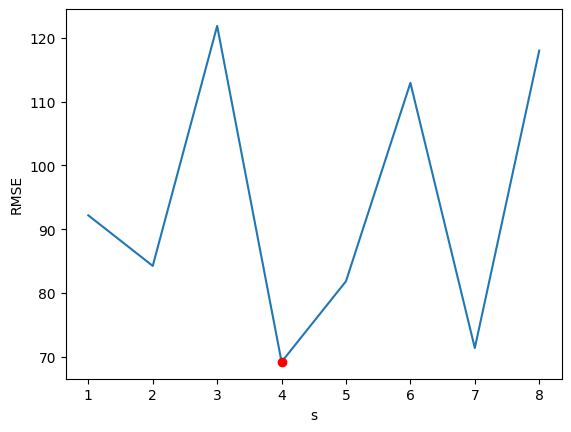

In [ ]:
plt.plot(range(1,9), ara_s)
plt.plot(4, ara_s[3], 'ro')

plt.xlabel('s')
plt.xticks(range(1,9))
plt.ylabel('RMSE')
#plt.ylim(9000, 20000)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

sha_s = [107.761]
minimum = 1000000

for s in range(2,9):
  rmse = sarima(train_sha_ma, train_sha_log, train_sha_t, 2, 0, 10, s)
  print(s,rmse)
  sha_s.append(rmse[1])
  if rmse[1] < minimum:
    print('***min***')
    minimum = rmse[1]


2 (16928.93, 130.111, 0.508, datetime.timedelta(seconds=11, microseconds=794009))
***min***
3 (17236.763, 131.289, 0.519, datetime.timedelta(seconds=20, microseconds=170594))
4 (19014.3, 137.892, 0.568, datetime.timedelta(seconds=32, microseconds=503661))
5 (19317.125, 138.986, 0.578, datetime.timedelta(seconds=43, microseconds=968849))
6 (18955.884, 137.68, 0.568, datetime.timedelta(seconds=59, microseconds=800413))
7 (18377.376, 135.563, 0.551, datetime.timedelta(seconds=126, microseconds=210419))
8 (19469.131, 139.532, 0.58, datetime.timedelta(seconds=134, microseconds=764952))


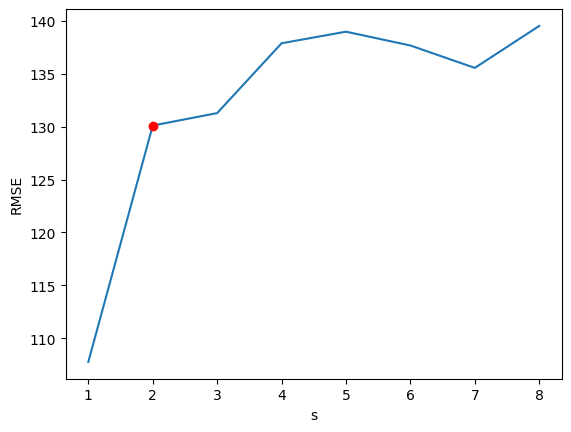

In [ ]:
plt.plot(range(1,9), sha_s)
plt.plot(2, sha_s[1], 'ro')

plt.xlabel('s')
plt.xticks(range(1,9))
plt.ylabel('RMSE')
#plt.ylim(9000, 20000)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

print('\njim:', sarima(train_jim_ma, train_jim_log, train_jim_t, 3, 0, 6, 8))
print('jim:', sarima_forecast(train_jim_ma, test_jim_log, test_jim_t, 778, 3, 0, 6, 7))

print('\nabb:', sarima(train_abb_ma, train_abb_log, train_abb_t, 6, 0, 4, 7))
print('abb:', sarima_forecast(train_abb_ma, test_abb_log, test_abb_t, 1732, 6, 0, 4, 7))

print('\nsim:', sarima(train_sim_ma, train_sim_log, train_sim_t, 8, 0, 6, 4))
print('sim:', sarima_forecast(train_sim_ma, test_sim_log, test_sim_t, 2124, 8, 0, 6, 4))

print('\nkal:', sarima(train_kal_ma, train_kal_log, train_kal_t, 1, 0, 10, 7))
print('kal:', sarima_forecast(train_kal_ma, test_kal_log, test_kal_t, 340, 1, 0, 10, 7))

print('\nwes:', sarima(train_wes_ma, train_wes_log, train_wes_t, 5, 0, 9, 5))
print('wes:', sarima_forecast(train_wes_ma, test_wes_log, test_wes_t, 1157, 5, 0, 9, 5))

print('\nara:', sarima(train_ara_ma, train_ara_log, train_ara_t, 2, 0, 6, 4))
print('ara:', sarima_forecast(train_ara_ma, test_ara_log, test_ara_t, 103, 2, 0, 6, 4))

print('\nsha:', sarima(train_sha_ma, train_sha_log, train_sha_t, 2, 0, 10, 2))
print('sha:', sarima_forecast(train_sha_ma, test_sha_log, test_sha_t, 314, 2, 0, 10, 2))



jim: (107059.157, 327.199, 3.866, datetime.timedelta(seconds=72, microseconds=279021))
jim: (1930.346, 43.936, 0.134, datetime.timedelta(seconds=50, microseconds=33620))

abb: (132166.244, 363.547, 0.969, datetime.timedelta(seconds=120, microseconds=29817))
abb: (57804.867, 240.426, 0.185, datetime.timedelta(seconds=120, microseconds=66062))

sim: (28997.353, 170.286, 1.094, datetime.timedelta(seconds=108, microseconds=452364))
sim: (5988.159, 77.383, 0.236, datetime.timedelta(seconds=113, microseconds=109245))

kal: (10222.97, 101.109, 0.082, datetime.timedelta(seconds=42, microseconds=421716))
kal: (14068.463, 118.611, 0.153, datetime.timedelta(seconds=41, microseconds=640094))

wes: (1442325.298, 1200.968, 5.443, datetime.timedelta(seconds=89, microseconds=191499))
wes: (119197.248, 345.25, 0.518, datetime.timedelta(seconds=91, microseconds=783360))

ara: (4781.309, 69.147, 0.045, datetime.timedelta(seconds=3, microseconds=319620))
ara: (14538.675, 120.576, 0.148, datetime.timedelt

## Prophet


In [ ]:
df_jim_t = df_jim[['datetime', 'total']]
df_abb_t = df_abb[['datetime', 'total']]
df_sim_t = df_sim[['datetime', 'total']]
df_kal_t = df_kal[['datetime', 'total']]
df_wes_t = df_wes[['datetime', 'total']]
df_ara_t = df_ara[['datetime', 'total']]
df_sha_t = df_sha[['datetime', 'total']]

df_jim_t.columns = ['ds', 'y']
df_abb_t.columns = ['ds', 'y']
df_sim_t.columns = ['ds', 'y']
df_kal_t.columns = ['ds', 'y']
df_wes_t.columns = ['ds', 'y']
df_ara_t.columns = ['ds', 'y']
df_sha_t.columns = ['ds', 'y']


In [ ]:
train_jim_t, test_jim_t = df_jim_t[:3900], df_jim_t[3900:] # 83%
train_abb_t, test_abb_t = df_abb_t[:7700], df_abb_t[7700:] # 82%
train_sim_t, test_sim_t = df_sim_t[:8500], df_sim_t[8500:] # 80%
train_kal_t, test_kal_t = df_kal_t[:1750], df_kal_t[1750:] # 83%
train_wes_t, test_wes_t = df_wes_t[:5300], df_wes_t[5300:] # 82%
train_ara_t, test_ara_t = df_ara_t[:600], df_ara_t[600:]   # 85%
train_sha_t, test_sha_t = df_sha_t[:1700], df_sha_t[1700:] # 84%


In [ ]:
proph_jim_t = Prophet()
proph_abb_t = Prophet()
proph_sim_t = Prophet()
proph_kal_t = Prophet()
proph_wes_t = Prophet()
proph_ara_t = Prophet()
proph_sha_t = Prophet()

proph_jim_t.fit(train_jim_t)
proph_abb_t.fit(train_abb_t)
proph_sim_t.fit(train_sim_t)
proph_kal_t.fit(train_kal_t)
proph_wes_t.fit(train_wes_t)
proph_ara_t.fit(train_ara_t)
proph_sha_t.fit(train_sha_t)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu2xeajqg/v2y7i12_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu2xeajqg/g_ic8jox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4961', 'data', 'file=/tmp/tmpu2xeajqg/v2y7i12_.json', 'init=/tmp/tmpu2xeajqg/g_ic8jox.json', 'output', 'file=/tmp/tmpu2xeajqg/prophet_modelayq9oh49/prophet_model-20240905152709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

In [ ]:
jim_pred_t = proph_jim_t.predict(train_jim_t[['ds']])
abb_pred_t = proph_abb_t.predict(train_abb_t[['ds']])
sim_pred_t = proph_sim_t.predict(train_sim_t[['ds']])
kal_pred_t = proph_kal_t.predict(train_kal_t[['ds']])
wes_pred_t = proph_wes_t.predict(train_wes_t[['ds']])
ara_pred_t = proph_ara_t.predict(train_ara_t[['ds']])
sha_pred_t = proph_sha_t.predict(train_sha_t[['ds']])


In [ ]:
print(round(mean_absolute_error(train_jim_t['y'], jim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_jim_t['y'], jim_pred), 3))
print(round(mean_absolute_error(train_abb_t['y'], abb_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_abb_t['y'], abb_pred), 3))
print(round(mean_absolute_error(train_sim_t['y'], sim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_sim_t['y'], sim_pred), 3))
print(round(mean_absolute_error(train_kal_t['y'], kal_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_kal_t['y'], kal_pred), 3))
print(round(mean_absolute_error(train_wes_t['y'], wes_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_wes_t['y'], wes_pred), 3))
print(round(mean_absolute_error(train_ara_t['y'], ara_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_ara_t['y'], ara_pred), 3))
print(round(mean_absolute_error(train_sha_t['y'], sha_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_sha_t['y'], sha_pred), 3))


2218.755
19504.794
1773.682
20697.843
23516.22
7110.427
4453.77


In [ ]:
print(round(mean_squared_error(train_jim_t['y'], jim_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_jim_t['y'], jim_pred)**(1/2), 3))
print(round(mean_squared_error(train_abb_t['y'], abb_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_abb_t['y'], abb_pred)**(1/2), 3))
print(round(mean_squared_error(train_sim_t['y'], sim_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_sim_t['y'], sim_pred)**(1/2), 3))
print(round(mean_squared_error(train_kal_t['y'], kal_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_kal_t['y'], kal_pred)**(1/2), 3))
print(round(mean_squared_error(train_wes_t['y'], wes_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_wes_t['y'], wes_pred)**(1/2), 3))
print(round(mean_squared_error(train_ara_t['y'], ara_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_ara_t['y'], ara_pred)**(1/2), 3))
print(round(mean_squared_error(train_sha_t['y'], sha_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_sha_t['y'], sha_pred)**(1/2), 3))


3565.875
27534.857
2388.363
26145.135
32561.907
9597.81
5906.46


In [ ]:
print(round(mean_absolute_percentage_error(train_jim_t['y'], jim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_jim_t['y'], jim_pred), 3))
print(round(mean_absolute_percentage_error(train_abb_t['y'], abb_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_abb_t['y'], abb_pred), 3))
print(round(mean_absolute_percentage_error(train_sim_t['y'], sim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_sim_t['y'], sim_pred), 3))
print(round(mean_absolute_percentage_error(train_kal_t['y'], kal_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_kal_t['y'], kal_pred), 3))
print(round(mean_absolute_percentage_error(train_wes_t['y'], wes_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_wes_t['y'], wes_pred), 3))
print(round(mean_absolute_percentage_error(train_ara_t['y'], ara_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_ara_t['y'], ara_pred), 3))
print(round(mean_absolute_percentage_error(train_sha_t['y'], sha_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_sha_t['y'], sha_pred), 3))


2.834
470.706
7.807
0.176
1.356
0.07
0.281


In [ ]:
jim_pred_t = proph_jim_t.predict(test_jim_t[['ds']])
abb_pred_t = proph_abb_t.predict(test_abb_t[['ds']])
sim_pred_t = proph_sim_t.predict(test_sim_t[['ds']])
kal_pred_t = proph_kal_t.predict(test_kal_t[['ds']])
wes_pred_t = proph_wes_t.predict(test_wes_t[['ds']])
ara_pred_t = proph_ara_t.predict(test_ara_t[['ds']])
sha_pred_t = proph_sha_t.predict(test_sha_t[['ds']])


In [ ]:
print(round(mean_absolute_error(test_jim_t['y'], jim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_jim_t['y'], jim_pred), 3))
print(round(mean_absolute_error(test_abb_t['y'], abb_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_abb_t['y'], abb_pred), 3))
print(round(mean_absolute_error(test_sim_t['y'], sim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_sim_t['y'], sim_pred), 3))
print(round(mean_absolute_error(test_kal_t['y'], kal_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_kal_t['y'], kal_pred), 3))
print(round(mean_absolute_error(test_wes_t['y'], wes_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_wes_t['y'], wes_pred), 3))
print(round(mean_absolute_error(test_ara_t['y'], ara_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_ara_t['y'], ara_pred), 3))
print(round(mean_absolute_error(test_sha_t['y'], sha_pred_t['yhat']), 3))#, '\t', round(mean_absolute_error(df_sha_t['y'], sha_pred), 3))


5876.034
156968.333
13977.348
87623.601
106347.923
18150.507
16267.147


In [ ]:
print(round(mean_squared_error(test_jim_t['y'], jim_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_jim_t['y'], jim_pred)**(1/2), 3))
print(round(mean_squared_error(test_abb_t['y'], abb_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_abb_t['y'], abb_pred)**(1/2), 3))
print(round(mean_squared_error(test_sim_t['y'], sim_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_sim_t['y'], sim_pred)**(1/2), 3))
print(round(mean_squared_error(test_kal_t['y'], kal_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_kal_t['y'], kal_pred)**(1/2), 3))
print(round(mean_squared_error(test_wes_t['y'], wes_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_wes_t['y'], wes_pred)**(1/2), 3))
print(round(mean_squared_error(test_ara_t['y'], ara_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_ara_t['y'], ara_pred)**(1/2), 3))
print(round(mean_squared_error(test_sha_t['y'], sha_pred_t['yhat'])**(1/2), 3))#, '\t', round(mean_squared_error(df_sha_t['y'], sha_pred)**(1/2), 3))


7279.519
181904.418
15467.122
95354.828
122200.427
20665.662
17927.444


In [ ]:
print(round(mean_absolute_percentage_error(test_jim_t['y'], jim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_jim_t['y'], jim_pred), 3))
print(round(mean_absolute_percentage_error(test_abb_t['y'], abb_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_abb_t['y'], abb_pred), 3))
print(round(mean_absolute_percentage_error(test_sim_t['y'], sim_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_sim_t['y'], sim_pred), 3))
print(round(mean_absolute_percentage_error(test_kal_t['y'], kal_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_kal_t['y'], kal_pred), 3))
print(round(mean_absolute_percentage_error(test_wes_t['y'], wes_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_wes_t['y'], wes_pred), 3))
print(round(mean_absolute_percentage_error(test_ara_t['y'], ara_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_ara_t['y'], ara_pred), 3))
print(round(mean_absolute_percentage_error(test_sha_t['y'], sha_pred_t['yhat']), 3))#, '\t', round(mean_absolute_percentage_error(df_sha_t['y'], sha_pred), 3))


0.627
0.571
0.516
1.237
0.563
0.199
0.505


## KNR (K Nearest Neighbour)

In [ ]:
knr = KNeighborsRegressor()
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')


In [ ]:
%time gs_kn.fit(trainX_jim, trainY_jim)
print('Jim', gs_kn.best_params_)
print(gs_kn.best_score_,'\n')

%time gs_kn.fit(trainX_abb, trainY_abb)
print('Abb', gs_kn.best_params_)
print(gs_kn.best_score_,'\n')

%time gs_kn.fit(trainX_sim, trainY_sim)
print('Sim', gs_kn.best_params_)
print(gs_kn.best_score_,'\n')

%time gs_kn.fit(trainX_kal, trainY_kal)
print('Kal', gs_kn.best_params_)
print(gs_kn.best_score_,'\n')

%time gs_kn.fit(trainX_wes, trainY_wes)
print('Wes', gs_kn.best_params_)
print(gs_kn.best_score_,'\n')

%time gs_kn.fit(trainX_ara, trainY_ara)
print('Ara', gs_kn.best_params_)
print(gs_kn.best_score_,'\n')

%time gs_kn.fit(trainX_sha, trainY_sha)
print('Sha', gs_kn.best_params_)
print(gs_kn.best_score_,'\n')


CPU times: user 1min 5s, sys: 93.8 ms, total: 1min 5s
Wall time: 1min 6s
Jim {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
-3049.5639767227185 

CPU times: user 3min 58s, sys: 159 ms, total: 3min 58s
Wall time: 3min 59s
Abb {'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'distance'}
-16842.450998825625 

CPU times: user 4min 41s, sys: 207 ms, total: 4min 41s
Wall time: 4min 42s
Sim {'metric': 'euclidean', 'n_neighbors': 18, 'weights': 'distance'}
-1942.9277770434576 

CPU times: user 17.9 s, sys: 22.9 ms, total: 17.9 s
Wall time: 18 s
Kal {'metric': 'euclidean', 'n_neighbors': 27, 'weights': 'distance'}
-21120.776269541973 

CPU times: user 1min 51s, sys: 65.2 ms, total: 1min 51s
Wall time: 1min 52s
Wes {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
-22102.349200540164 

CPU times: user 4.1 s, sys: 15 ms, total: 4.11 s
Wall time: 4.1 s
Ara {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'distance'}
-9401.852191489239 

CPU times: user 16

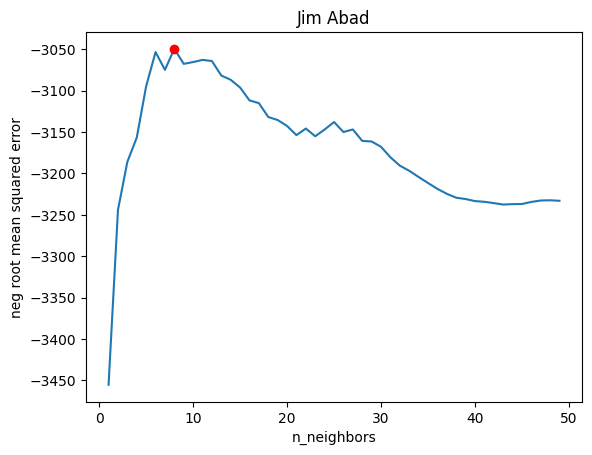

In [ ]:
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['distance'],
            'metric': ['euclidean']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_jim, trainY_jim)

plt.plot(range(1, 50), gs_kn.cv_results_['mean_test_score'])
plt.plot(8, gs_kn.cv_results_['mean_test_score'][7] , 'ro')

plt.xlabel('n_neighbors')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


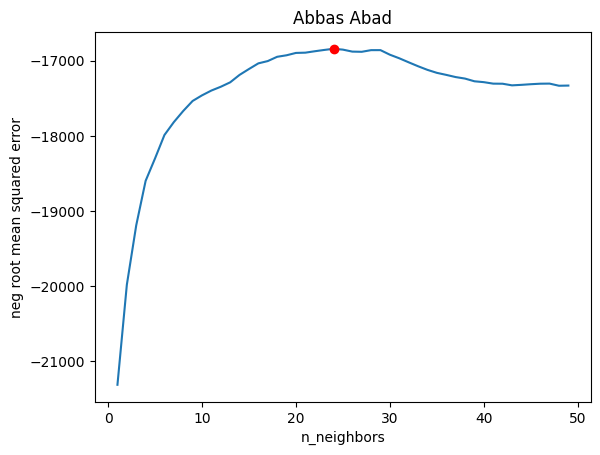

In [ ]:
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['distance'],
            'metric': ['manhattan']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_abb, trainY_abb)

plt.plot(range(1, 50), gs_kn.cv_results_['mean_test_score'])
plt.plot(24, gs_kn.cv_results_['mean_test_score'][23] , 'ro')

plt.xlabel('n_neighbors')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


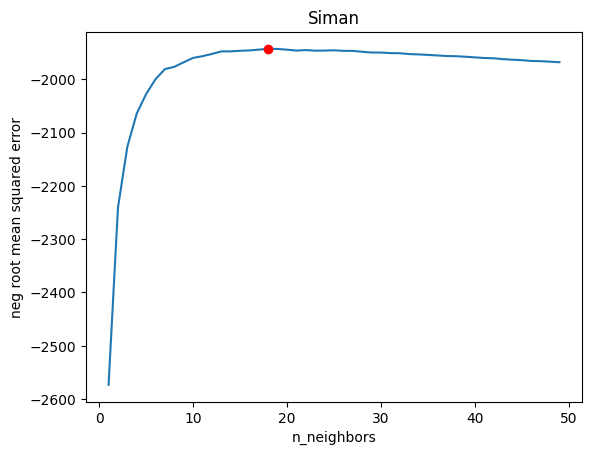

In [ ]:
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['distance'],
            'metric': ['euclidean']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_sim, trainY_sim)

plt.plot(range(1, 50), gs_kn.cv_results_['mean_test_score'])
plt.plot(18, gs_kn.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('n_neighbors')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


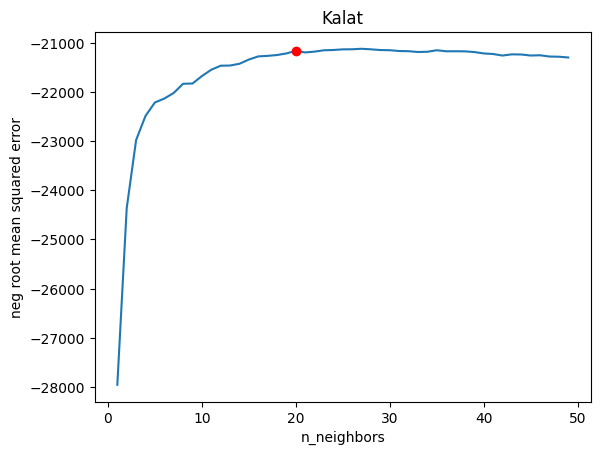

In [ ]:
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['distance'],
            'metric': ['euclidean']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_kal, trainY_kal)

plt.plot(range(1, 50), gs_kn.cv_results_['mean_test_score'])
plt.plot(20, gs_kn.cv_results_['mean_test_score'][19] , 'ro')

plt.xlabel('n_neighbors')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


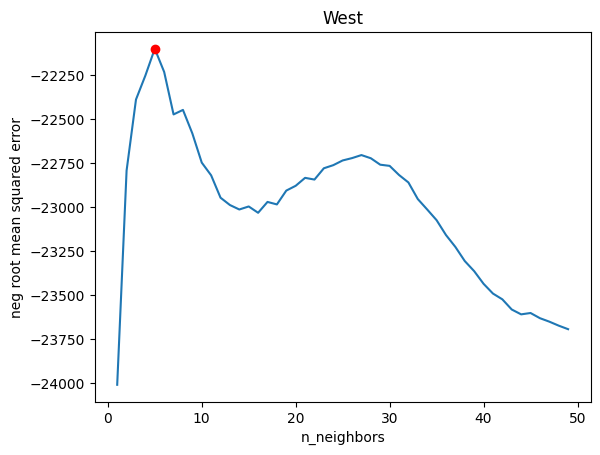

In [ ]:
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['distance'],
            'metric': ['manhattan']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_wes, trainY_wes)

plt.plot(range(1, 50), gs_kn.cv_results_['mean_test_score'])
plt.plot(5, gs_kn.cv_results_['mean_test_score'][4] , 'ro')

plt.xlabel('n_neighbors')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


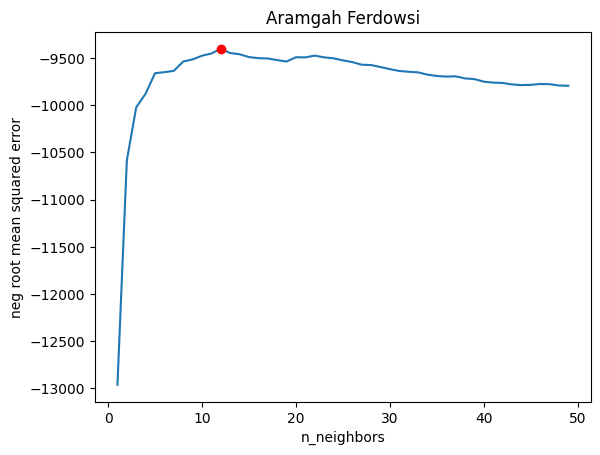

In [ ]:
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['distance'],
            'metric': ['euclidean']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_ara, trainY_ara)

plt.plot(range(1, 50), gs_kn.cv_results_['mean_test_score'])
plt.plot(12, gs_kn.cv_results_['mean_test_score'][11] , 'ro')

plt.xlabel('n_neighbors')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


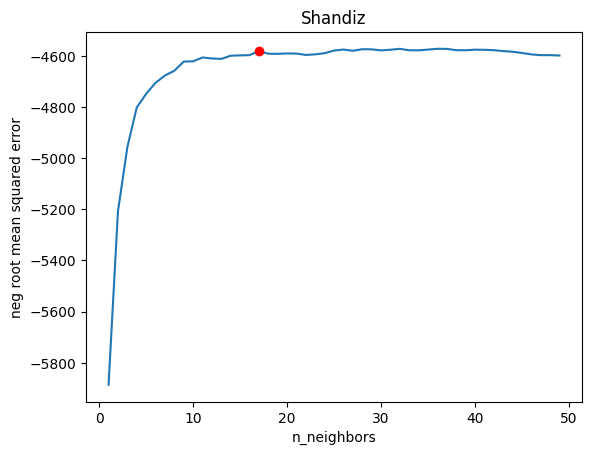

In [ ]:
param_kn = {'n_neighbors': range(1, 50),
            'weights': ['distance'],
            'metric': ['euclidean']}
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_sha, trainY_sha)

plt.plot(range(1, 50), gs_kn.cv_results_['mean_test_score'])
plt.plot(17, gs_kn.cv_results_['mean_test_score'][16] , 'ro')

plt.xlabel('n_neighbors')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


In [ ]:
param_kn = {'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']}

knr = KNeighborsRegressor(n_neighbors=8)
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_jim, trainY_jim)
print('jim euc', gs_kn.cv_results_['mean_test_score'][0:2].mean(), '\tman', gs_kn.cv_results_['mean_test_score'][2:4].mean())
print('jim uni', gs_kn.cv_results_['mean_test_score'][0:3:2].mean(), '\tdis', gs_kn.cv_results_['mean_test_score'][1:4:2].mean(), '\n')

knr = KNeighborsRegressor(n_neighbors=24)
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_abb, trainY_abb)
print('abb euc', gs_kn.cv_results_['mean_test_score'][0:2].mean(), '\tman', gs_kn.cv_results_['mean_test_score'][2:4].mean())
print('abb uni', gs_kn.cv_results_['mean_test_score'][0:3:2].mean(), '\tdis', gs_kn.cv_results_['mean_test_score'][1:4:2].mean(), '\n')

knr = KNeighborsRegressor(n_neighbors=18)
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_sim, trainY_sim)
print('sim euc', gs_kn.cv_results_['mean_test_score'][0:2].mean(), '\tman', gs_kn.cv_results_['mean_test_score'][2:4].mean())
print('sim uni', gs_kn.cv_results_['mean_test_score'][0:3:2].mean(), '\tdis', gs_kn.cv_results_['mean_test_score'][1:4:2].mean(), '\n')

knr = KNeighborsRegressor(n_neighbors=20)
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_kal, trainY_kal)
print('kal euc', gs_kn.cv_results_['mean_test_score'][0:2].mean(), '\tman', gs_kn.cv_results_['mean_test_score'][2:4].mean())
print('kal uni', gs_kn.cv_results_['mean_test_score'][0:3:2].mean(), '\tdis', gs_kn.cv_results_['mean_test_score'][1:4:2].mean(), '\n')

knr = KNeighborsRegressor(n_neighbors=5)
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_wes, trainY_wes)
print('wes euc', gs_kn.cv_results_['mean_test_score'][0:2].mean(), '\tman', gs_kn.cv_results_['mean_test_score'][2:4].mean())
print('wes uni', gs_kn.cv_results_['mean_test_score'][0:3:2].mean(), '\tdis', gs_kn.cv_results_['mean_test_score'][1:4:2].mean(), '\n')

knr = KNeighborsRegressor(n_neighbors=12)
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_ara, trainY_ara)
print('ara euc', gs_kn.cv_results_['mean_test_score'][0:2].mean(), '\tman', gs_kn.cv_results_['mean_test_score'][2:4].mean())
print('ara uni', gs_kn.cv_results_['mean_test_score'][0:3:2].mean(), '\tdis', gs_kn.cv_results_['mean_test_score'][1:4:2].mean(), '\n')

knr = KNeighborsRegressor(n_neighbors=17)
gs_kn = GridSearchCV(knr, param_kn, cv=5, scoring='neg_root_mean_squared_error')
gs_kn.fit(trainX_sha, trainY_sha)
print('sha euc', gs_kn.cv_results_['mean_test_score'][0:2].mean(), '\tman', gs_kn.cv_results_['mean_test_score'][2:4].mean())
print('sha uni', gs_kn.cv_results_['mean_test_score'][0:3:2].mean(), '\tdis', gs_kn.cv_results_['mean_test_score'][1:4:2].mean())


jim euc -3050.1724009044933 	man -3089.3293613377464
jim uni -3070.747206319476 	dis -3068.7545559227638 

abb euc -16931.563843222895 	man -16855.215385745265
abb uni -16912.167030522196 	dis -16874.612198445964 

sim euc -1944.0710514966215 	man -1956.4077832932735
sim uni -1951.4872782424954 	dis -1948.9915565473998 

kal euc -21168.893621037518 	man -21172.37174171581
kal uni -21178.996530444034 	dis -21162.268832309295 

wes euc -22251.53003060443 	man -22116.11253346098
wes uni -22199.948803243307 	dis -22167.6937608221 

ara euc -9411.770584931004 	man -9576.820919085361
ara uni -9505.067628580775 	dis -9483.523875435592 

sha euc -4582.666774323211 	man -4647.838712475203
sha uni -4617.760389408239 	dis -4612.745097390175


In [ ]:
knr_jim = KNeighborsRegressor(metric='euclidean', n_neighbors=8, weights='distance')
knr_abb = KNeighborsRegressor(metric='manhattan', n_neighbors=24, weights='distance')
knr_sim = KNeighborsRegressor(metric='euclidean', n_neighbors=18, weights='distance')
knr_kal = KNeighborsRegressor(metric='euclidean', n_neighbors=20, weights='distance')
knr_wes = KNeighborsRegressor(metric='manhattan', n_neighbors=5, weights='distance')
knr_ara = KNeighborsRegressor(metric='euclidean', n_neighbors=12, weights='distance')
knr_sha = KNeighborsRegressor(metric='euclidean', n_neighbors=17, weights='distance')


In [ ]:
knr_jim.fit(trainX_jim, trainY_jim)
knr_abb.fit(trainX_abb, trainY_abb)
knr_sim.fit(trainX_sim, trainY_sim)
knr_kal.fit(trainX_kal, trainY_kal)
knr_wes.fit(trainX_wes, trainY_wes)
knr_ara.fit(trainX_ara, trainY_ara)
knr_sha.fit(trainX_sha, trainY_sha)


KNeighborsRegressor(metric='euclidean', n_neighbors=17, weights='distance')

In [ ]:
knr_jim_val = knr_jim.predict(trainX_jim)
knr_jim_prd = knr_jim.predict(testX_jim)

knr_abb_val = knr_abb.predict(trainX_abb)
knr_abb_prd = knr_abb.predict(testX_abb)

knr_sim_val = knr_sim.predict(trainX_sim)
knr_sim_prd = knr_sim.predict(testX_sim)

knr_kal_val = knr_kal.predict(trainX_kal)
knr_kal_prd = knr_kal.predict(testX_kal)

knr_wes_val = knr_wes.predict(trainX_wes)
knr_wes_prd = knr_wes.predict(testX_wes)

knr_ara_val = knr_ara.predict(trainX_ara)
knr_ara_prd = knr_ara.predict(testX_ara)

knr_sha_val = knr_sha.predict(trainX_sha)
knr_sha_prd = knr_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, knr_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, knr_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, knr_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, knr_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, knr_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, knr_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, knr_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, knr_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, knr_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, knr_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, knr_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, knr_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, knr_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, knr_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, knr_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, knr_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, knr_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, knr_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, knr_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, knr_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, knr_sha_val), 3))


Jim	 6.461 	 246.7 	 0.001
Abb	 40.661 	 1105.898 	 2.558
Sim	 1.06 	 92.913 	 0.0
Kal	 0.0 	 0.003 	 0.0
Wes	 16.4 	 865.165 	 0.002
Ara	 17.307 	 415.337 	 0.0
Sha	 0.001 	 0.003 	 0.0


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, knr_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, knr_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, knr_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, knr_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, knr_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, knr_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, knr_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, knr_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, knr_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, knr_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, knr_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, knr_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, knr_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, knr_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, knr_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, knr_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, knr_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, knr_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, knr_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, knr_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, knr_sha_prd), 3))


Jim	 1330.702 	 1849.62 	 0.115
Abb	 14791.714 	 22803.168 	 0.066
Sim	 1540.33 	 2072.721 	 0.061
Kal	 15536.649 	 19500.771 	 0.216
Wes	 16022.468 	 24100.578 	 0.074
Ara	 10162.376 	 13237.78 	 0.108
Sha	 3344.092 	 4454.686 	 0.098


## SVR (Support Vector Machine)

### Linear

In [ ]:
svr = SVR()
param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-5,8)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error', verbose=3)


In [ ]:
warnings.filterwarnings("ignore")

%time gs_svl.fit(trainX_jim, trainY_jim)
print('Jim', gs_svl.best_params_)
print(gs_svl.best_score_,'\n')

%time gs_svl.fit(trainX_abb, trainY_abb)
print('Abb', gs_svl.best_params_)
print(gs_svl.best_score_,'\n')

%time gs_svl.fit(trainX_sim, trainY_sim)
print('Sim', gs_svl.best_params_)
print(gs_svl.best_score_,'\n')

%time gs_svl.fit(trainX_kal, trainY_kal)
print('Kal', gs_svl.best_params_)
print(gs_svl.best_score_,'\n')

%time gs_svl.fit(trainX_wes, trainY_wes)
print('Wes', gs_svl.best_params_)
print(gs_svl.best_score_,'\n')

%time gs_svl.fit(trainX_ara, trainY_ara)
print('Ara', gs_svl.best_params_)
print(gs_svl.best_score_,'\n')

%time gs_svl.fit(trainX_sha, trainY_sha)
print('Sha', gs_svl.best_params_)
print(gs_svl.best_score_,'\n')


Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END C=0.03125, kernel=linear, max_iter=100000;, score=-1929.322 total time=   6.1s
[CV 2/5] END C=0.03125, kernel=linear, max_iter=100000;, score=-1285.489 total time=   5.4s
[CV 3/5] END C=0.03125, kernel=linear, max_iter=100000;, score=-1222.937 total time=   8.3s
[CV 4/5] END C=0.03125, kernel=linear, max_iter=100000;, score=-2492.313 total time=   6.0s
[CV 5/5] END C=0.03125, kernel=linear, max_iter=100000;, score=-17665.907 total time=   7.3s
[CV 1/5] END C=0.0625, kernel=linear, max_iter=100000;, score=-3086.170 total time=   5.3s
[CV 2/5] END C=0.0625, kernel=linear, max_iter=100000;, score=-1869.039 total time=   6.9s
[CV 3/5] END C=0.0625, kernel=linear, max_iter=100000;, score=-3478.233 total time=   5.2s
[CV 4/5] END C=0.0625, kernel=linear, max_iter=100000;, score=-2025.919 total time=   7.4s
[CV 5/5] END C=0.0625, kernel=linear, max_iter=100000;, score=-5363.490 total time=   5.8s
[CV 1/5] END C=0.125, k

Jim {'C': 0.0625, 'kernel': 'linear', 'max_iter': 100000}
-3164.570090738083

Abb {'C': 0.125, 'kernel': 'linear', 'max_iter': 100000}
-93103.85535180596

Sim {'C': 0.5, 'kernel': 'linear', 'max_iter': 100000}
-5052.227469615848

Kal {'C': 0.25, 'kernel': 'linear', 'max_iter': 100000}
-33779.68491968182

Wes {'C': 0.03125, 'kernel': 'linear', 'max_iter': 100000}
-67151.85669468768

Ara {'C': 0.0625, 'kernel': 'linear', 'max_iter': 100000}
-15003.276404548727

Sha {'C': 0.03125, 'kernel': 'linear', 'max_iter': 100000}
-6726.251066364052

In [ ]:
param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-15,11)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error')
gs_svl.fit(trainX_jim, trainY_jim)


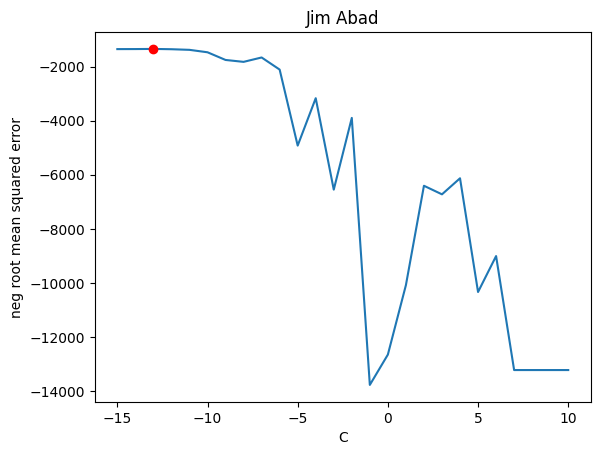

In [ ]:
plt.plot(range(-15,11), gs_svl.cv_results_['mean_test_score'])
plt.plot(-13, gs_svl.cv_results_['mean_test_score'][2] , 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()

In [ ]:
param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-15,11)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error')
gs_svl.fit(trainX_abb, trainY_abb)

print(gs_svl.cv_results_['mean_test_score'])


[ -12902.99226925  -14605.72454834  -18966.99083157  -28003.36762836
  -30971.97580364  -21913.69382989  -62984.92571702  -79292.744219
 -101595.30136928  -83570.85957597 -120810.82468575  -96368.79738669
  -93103.85535181 -123649.81453418 -367690.94256226 -168961.53812106
 -168961.53812253 -168961.53812075 -168961.53812109 -168961.53811867
 -168961.53812088 -168961.53812007 -168961.53811782 -168961.53812059
 -168961.53812058 -168961.53811965]


In [ ]:
gs_svl_abb = [-12903, -14606, -18967, -28003, -30972, -21914, -62985, -79293, -101595, -83571, -120811, -96369, -93104, -123650, -367691, -168962,
              -168962, -168962, -168962, -168962, -168962, -168962, -168962, -168962, -168962, -168962]

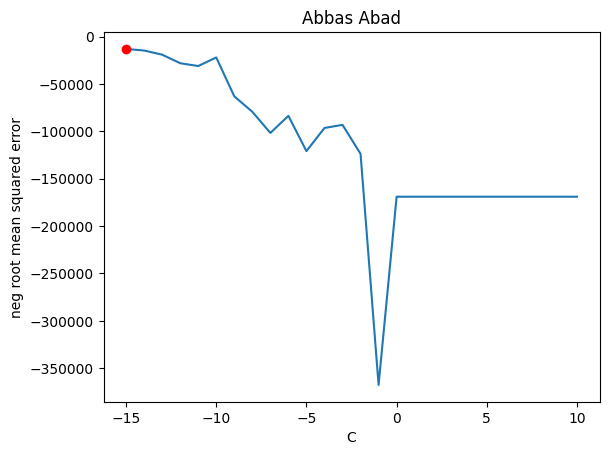

In [ ]:
plt.plot(range(-15,11), gs_svl_abb)
plt.plot(-15, gs_svl_abb[0] , 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


In [ ]:
warnings.filterwarnings("ignore")

param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-15,11)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error')
gs_svl.fit(trainX_sim, trainY_sim)

print(gs_svl.cv_results_['mean_test_score'])


[ -1891.45487334  -1889.90420435  -1890.38705356  -1934.34237384
  -2003.05829776  -2578.49643817  -3145.25288864  -3070.21712452
  -4635.63375712  -6900.10055106  -6551.7884586   -5144.83306502
  -6630.45010499  -5311.43912986  -5052.22746962 -12719.91816147
 -17038.73631911 -17038.73631911 -17038.73631911 -17038.73631911
 -17038.73631911 -17038.73631911 -17038.73631911 -17038.73631911
 -17038.73631911 -17038.73631911]


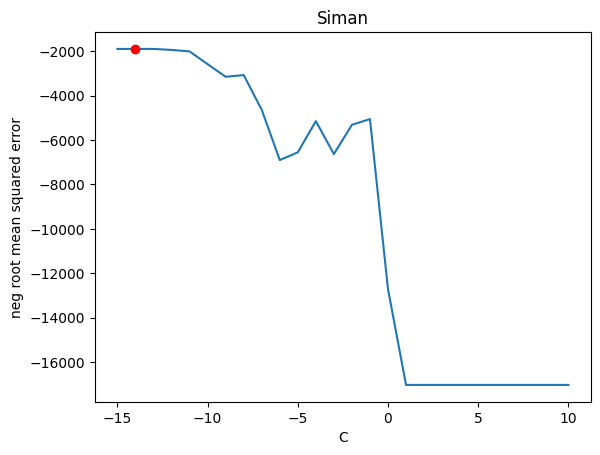

In [ ]:
plt.plot(range(-15,11), gs_svl.cv_results_['mean_test_score'])
plt.plot(-14, gs_svl.cv_results_['mean_test_score'][1] , 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


In [ ]:
warnings.filterwarnings("ignore")

param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-15,11)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error')
gs_svl.fit(trainX_kal, trainY_kal)

print(gs_svl.cv_results_['mean_test_score'])


[-19813.49895306 -19735.54744705 -19740.85257151 -19880.87097378
 -20440.32783556 -21142.9585435  -24484.5763339  -26649.605125
 -28136.86047568 -38288.0154091  -43974.93373499 -44132.65040047
 -37251.39106142 -33779.68491968 -33779.68491968 -33779.68491968
 -33779.68491968 -33779.68491968 -33779.68491968 -33779.68491968
 -33779.68491968 -33779.68491968 -33779.68491968 -33779.68491968
 -33779.68491968 -33779.68491968]


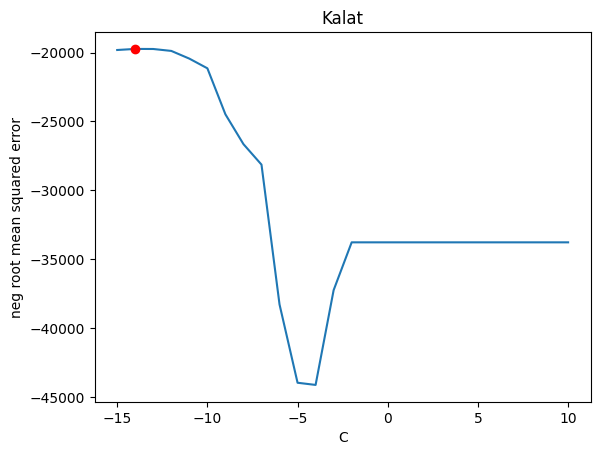

In [ ]:
plt.plot(range(-15,11), gs_svl.cv_results_['mean_test_score'])
plt.plot(-14, gs_svl.cv_results_['mean_test_score'][1] , 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


In [ ]:
warnings.filterwarnings("ignore")

param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-15,11)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error')
gs_svl.fit(trainX_wes, trainY_wes)

print(gs_svl.cv_results_['mean_test_score'])


[ -13230.07863906  -16357.64697083  -14862.77249438  -19794.28609774
  -36442.09306547  -94718.40645201  -40689.82601998  -41929.55612816
 -117263.51974454  -70796.17528988  -67151.85669469 -129978.68692141
 -177761.49601496 -206952.30668024 -285843.82376878 -423751.05808094
 -208551.51683571 -281268.65908348 -275326.66851967 -345430.56405165
 -204923.71729432 -403994.18349817 -370993.94840816 -421838.904222
 -600683.38604785 -600683.38605555]


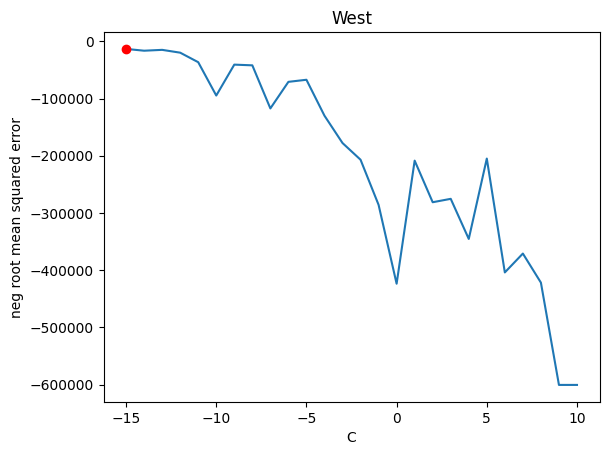

In [ ]:
plt.plot(range(-15,11), gs_svl.cv_results_['mean_test_score'])
plt.plot(-15, gs_svl.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


In [ ]:
warnings.filterwarnings("ignore")

param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-15,11)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error')
gs_svl.fit(trainX_ara, trainY_ara)

print(gs_svl.cv_results_['mean_test_score'])


[ -8639.16485074  -8687.89056543  -8656.78150262  -8625.9718871
  -8641.38576752  -8717.93163403  -9022.90001018 -11344.2856366
 -14522.43094352 -11377.32163237 -18095.2068476  -15003.27640455
 -19803.81935698 -16053.39370272 -20113.72664673 -20113.72664582
 -20113.72664817 -20113.72664513 -20113.72664523 -20113.72665268
 -20113.72663891 -20113.72661186 -20113.72668103 -20113.72674774
 -20113.72635229 -20113.72637488]


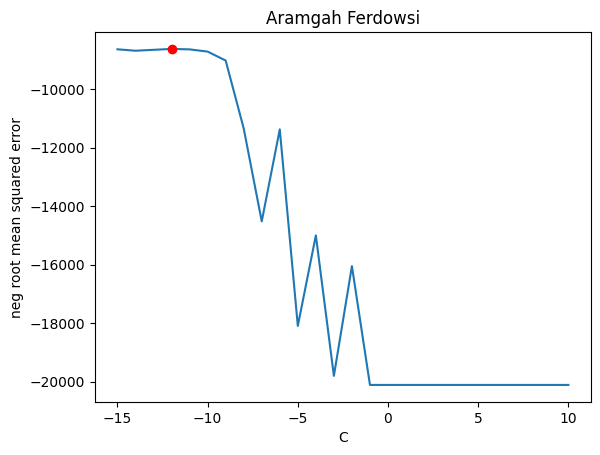

In [ ]:
plt.plot(range(-15,11), gs_svl.cv_results_['mean_test_score'])
plt.plot(-12, gs_svl.cv_results_['mean_test_score'][3] , 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


In [ ]:
warnings.filterwarnings("ignore")

param_svl = {'kernel': ['linear'],
            'C': [2**_ for _ in range(-15,11)],
            'max_iter': [100000]}
gs_svl = GridSearchCV(svr, param_svl, cv=5, scoring='neg_root_mean_squared_error')
gs_svl.fit(trainX_sha, trainY_sha)

print(gs_svl.cv_results_['mean_test_score'])


[ -4055.87114915  -4052.1495957   -4083.24842821  -4057.0527272
  -4078.55799976  -4177.40885135  -4602.94035985  -4723.95655529
  -6024.13051957  -5913.96228457  -6726.25106636  -8351.80014366
  -9332.12284305 -12442.859795   -11114.1972293  -10943.45536293
  -9774.26641916  -9774.26641916  -9774.26641916  -9774.26641916
  -9774.26641916  -9774.26641916  -9774.26641916  -9774.26641916
  -9774.26641916  -9774.26641916]


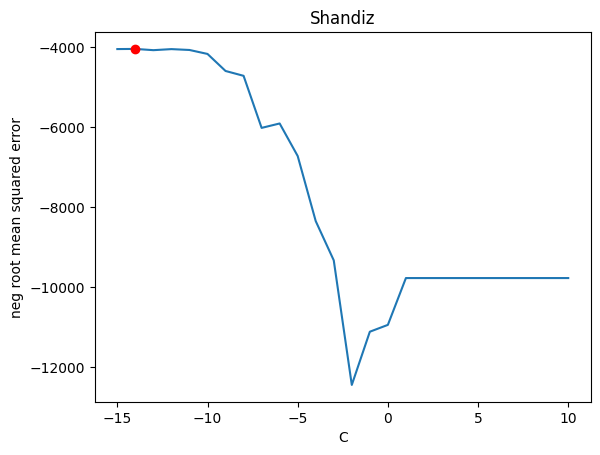

In [ ]:
plt.plot(range(-15,11), gs_svl.cv_results_['mean_test_score'])
plt.plot(-14, gs_svl.cv_results_['mean_test_score'][1] , 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


In [ ]:
svl_jim = SVR(kernel='linear', C=2**(-13))
svl_abb = SVR(kernel='linear', C=2**(-15))
svl_sim = SVR(kernel='linear', C=2**(-14))
svl_kal = SVR(kernel='linear', C=2**(-14))
svl_wes = SVR(kernel='linear', C=2**(-15))
svl_ara = SVR(kernel='linear', C=2**(-12))
svl_sha = SVR(kernel='linear', C=2**(-14))


In [ ]:
svl_jim.fit(trainX_jim, trainY_jim)
svl_abb.fit(trainX_abb, trainY_abb)
svl_sim.fit(trainX_sim, trainY_sim)
svl_kal.fit(trainX_kal, trainY_kal)
svl_wes.fit(trainX_wes, trainY_wes)
svl_ara.fit(trainX_ara, trainY_ara)
svl_sha.fit(trainX_sha, trainY_sha)


SVR(C=6.103515625e-05, kernel='linear')

In [ ]:
svl_jim_val = svl_jim.predict(trainX_jim)
svl_jim_prd = svl_jim.predict(testX_jim)

svl_abb_val = svl_abb.predict(trainX_abb)
svl_abb_prd = svl_abb.predict(testX_abb)

svl_sim_val = svl_sim.predict(trainX_sim)
svl_sim_prd = svl_sim.predict(testX_sim)

svl_kal_val = svl_kal.predict(trainX_kal)
svl_kal_prd = svl_kal.predict(testX_kal)

svl_wes_val = svl_wes.predict(trainX_wes)
svl_wes_prd = svl_wes.predict(testX_wes)

svl_ara_val = svl_ara.predict(trainX_ara)
svl_ara_prd = svl_ara.predict(testX_ara)

svl_sha_val = svl_sha.predict(trainX_sha)
svl_sha_prd = svl_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, svl_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, svl_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, svl_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, svl_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, svl_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, svl_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, svl_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, svl_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, svl_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, svl_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, svl_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, svl_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, svl_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, svl_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, svl_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, svl_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, svl_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, svl_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, svl_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, svl_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, svl_sha_val), 3))


Jim	 676.243 	 1396.098 	 0.361
Abb	 5878.476 	 13000.714 	 13.9
Sim	 1337.799 	 1931.701 	 6.491
Kal	 14593.472 	 19469.089 	 0.118
Wes	 6474.791 	 13099.354 	 0.105
Ara	 6038.382 	 9240.099 	 0.057
Sha	 2813.12 	 4032.066 	 0.117


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, svl_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, svl_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, svl_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, svl_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, svl_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, svl_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, svl_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, svl_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, svl_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, svl_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, svl_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, svl_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, svl_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, svl_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, svl_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, svl_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, svl_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, svl_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, svl_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, svl_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, svl_sha_prd), 3))


Jim	 959.207 	 1605.545 	 0.076
Abb	 10937.545 	 22627.306 	 0.055
Sim	 1451.795 	 1946.089 	 0.057
Kal	 12224.266 	 15455.546 	 0.155
Wes	 13920.467 	 25203.882 	 0.064
Ara	 8238.057 	 11219.021 	 0.086
Sha	 3256.926 	 4423.781 	 0.096


### RBF

In [ ]:
svr = SVR()

param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-5,5)],
            'gamma': [2**_ for _ in range(-5,5)],
            'max_iter': [100000]}
gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error', verbose=1)


In [ ]:
warnings.filterwarnings("ignore")

%time gs_svr.fit(trainX_jim, trainY_jim)
print('Jim', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_abb, trainY_abb)
print('Abb', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 6min 24s, sys: 14.5 s, total: 6min 39s
Wall time: 6min 44s
Jim {'C': 16, 'gamma': 0.03125, 'kernel': 'rbf', 'max_iter': 100000}
-6055.557167892053 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 25min 13s, sys: 1min 2s, total: 26min 15s
Wall time: 26min 46s
Abb {'C': 0.03125, 'gamma': 0.03125, 'kernel': 'rbf', 'max_iter': 100000}
-93159.88698322074 



In [ ]:
%time gs_svr.fit(trainX_sim, trainY_sim)
print('Sim', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_kal, trainY_kal)
print('Kal', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_wes, trainY_wes)
print('Wes', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 30min 58s, sys: 1min 21s, total: 32min 20s
Wall time: 32min 31s
Sim {'C': 16, 'gamma': 0.03125, 'kernel': 'rbf', 'max_iter': 100000}
-10304.569464706909 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1min 20s, sys: 72.5 ms, total: 1min 20s
Wall time: 1min 20s
Kal {'C': 16, 'gamma': 0.03125, 'kernel': 'rbf', 'max_iter': 100000}
-32727.298119408846 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 11min 46s, sys: 30.2 s, total: 12min 16s
Wall time: 12min 19s
Wes {'C': 0.03125, 'gamma': 0.03125, 'kernel': 'rbf', 'max_iter': 100000}
-92450.92764049984 



In [ ]:
%time gs_svr.fit(trainX_ara, trainY_ara)
print('Ara', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_sha, trainY_sha)
print('Sha', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 10.5 s, sys: 17.6 ms, total: 10.5 s
Wall time: 10.6 s
Ara {'C': 16, 'gamma': 0.03125, 'kernel': 'rbf', 'max_iter': 100000}
-18368.438839840208 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1min 17s, sys: 86.2 ms, total: 1min 18s
Wall time: 1min 18s
Sha {'C': 0.03125, 'gamma': 0.03125, 'kernel': 'rbf', 'max_iter': 100000}
-8875.266983172693 



In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-15,11)],
            'gamma': [2**(-14)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_jim, trainY_jim)

print(gs_svr.cv_results_['mean_test_score'])


[-6056.65850303 -6056.65850303 -6056.65850303 -6056.65850303
 -6056.65850303 -6056.65850303 -6056.65850303 -6056.65850303
 -6056.65850303 -6056.65850303 -6056.65850303 -6056.65850303
 -6056.65850303 -6056.65850303 -6056.65850303 -6056.6727403
 -6056.72449527 -6056.67456285 -6056.06857205 -6055.55716789
 -6056.55885168 -6058.00762861 -6054.32294781 -6046.27724538
 -6040.69803137 -6046.04180417]


9


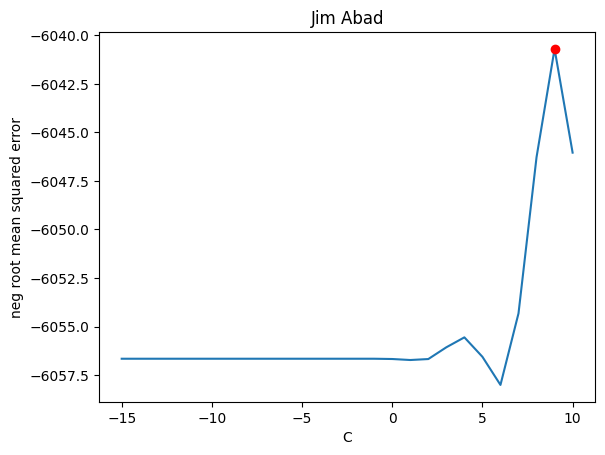

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,11), gs_svr.cv_results_['mean_test_score'])
plt.plot(gs_svr.cv_results_['mean_test_score'].argmax()-15, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [0.03125],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_abb, trainY_abb)

print(gs_svr.cv_results_['mean_test_score'], '\n', gs_svr.cv_results_['mean_test_score'].argmax())


[-93159.88423512 -93159.88423781 -93159.88424318 -93159.88425392
 -93159.88427541 -93159.8843184  -93159.88440436 -93159.88457628
 -93159.88492013 -93159.88560783 -93159.88698322 -93159.88973401
 -93159.89523558 -93159.90623873 -93159.92824504 -93159.97225766
 -93160.06028295 -93160.23633374 -93160.89822609 -93162.44735086
 -93162.90313493 -93163.05093977 -93165.2007525  -93167.67080361
 -92613.06668745 -92097.3879264  -91440.32835748 -91229.13712076
 -91200.57057216 -91459.08162716 -92209.3083784 ]


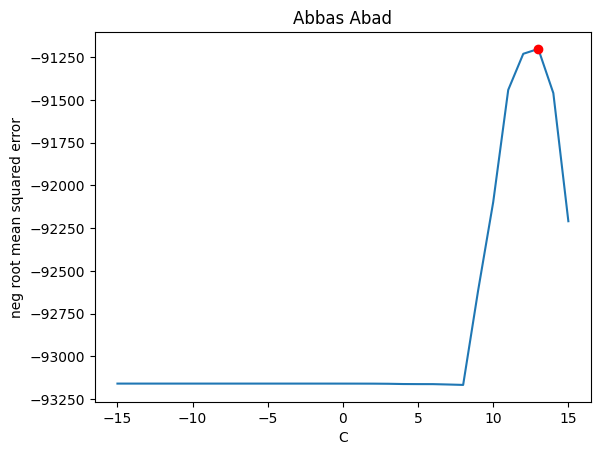

In [ ]:
plt.plot(range(-15,16), gs_svr.cv_results_['mean_test_score'])
plt.plot(gs_svr.cv_results_['mean_test_score'].argmax()-15, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-15,21)],
            'gamma': [0.03125],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_sim, trainY_sim)

print(gs_svr.cv_results_['mean_test_score'])


[-10308.22668031 -10308.22668031 -10308.22668031 -10308.22668031
 -10308.22668031 -10308.22668031 -10308.22668031 -10308.22668031
 -10308.22668031 -10308.22668031 -10308.22668031 -10308.22668031
 -10308.22668031 -10308.22668031 -10308.20710065 -10308.15815154
 -10308.04393707 -10307.78287618 -10307.83659982 -10304.56946471
 -10300.6230924  -10298.38102543 -10294.02237569 -10282.6867955
 -10266.3772245  -10240.42062606 -10182.88505203  -9928.65289402
  -9302.84449703  -9026.0755615   -9019.45853359  -9019.45853359
  -9019.4585336   -9019.45853359  -9019.45853359  -9019.4585336 ]


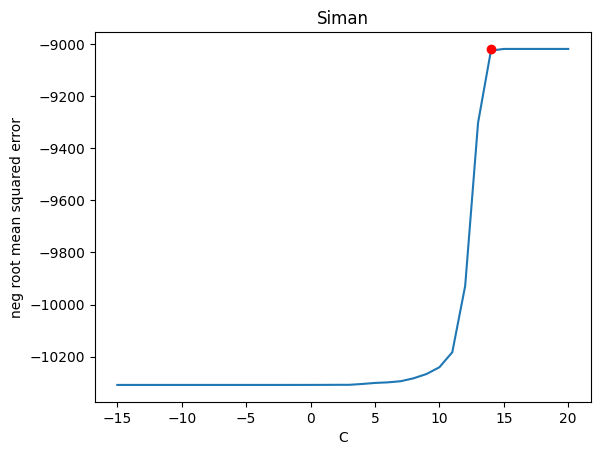

In [ ]:
plt.plot(range(-15,21), gs_svr.cv_results_['mean_test_score'])
plt.plot(14, gs_svr.cv_results_['mean_test_score'][30], 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()

8


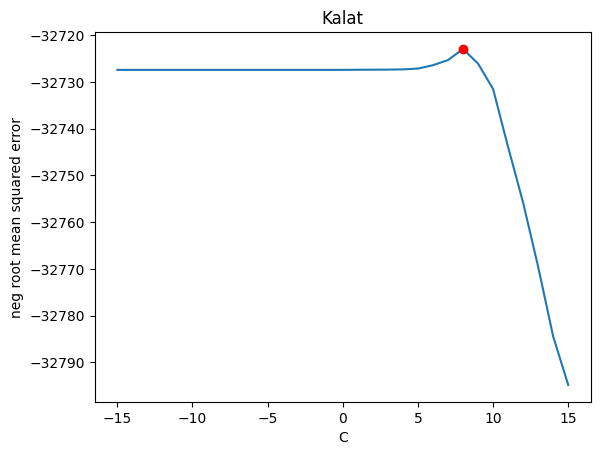

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [0.03125],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_kal, trainY_kal)

print(gs_svr.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svr.cv_results_['mean_test_score'])
plt.plot(gs_svr.cv_results_['mean_test_score'].argmax()-15, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


8


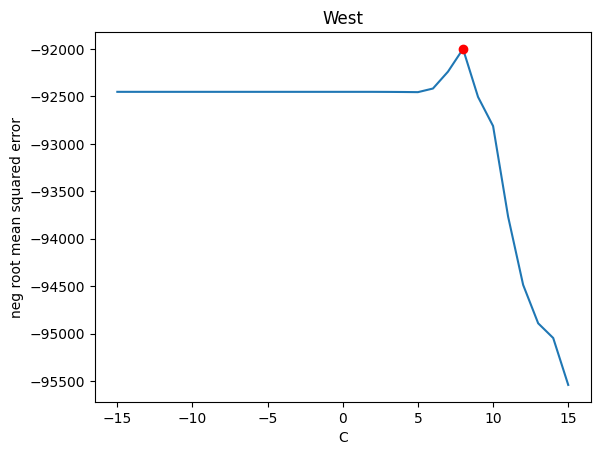

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [0.03125],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_wes, trainY_wes)

print(gs_svr.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svr.cv_results_['mean_test_score'])
plt.plot(gs_svr.cv_results_['mean_test_score'].argmax()-15, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


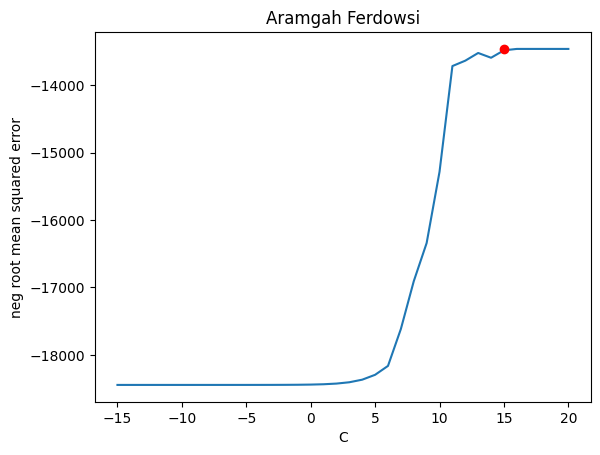

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-15,21)],
            'gamma': [0.03125],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_ara, trainY_ara)

plt.plot(range(-15,21), gs_svr.cv_results_['mean_test_score'])
plt.plot(15, gs_svr.cv_results_['mean_test_score'][31], 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


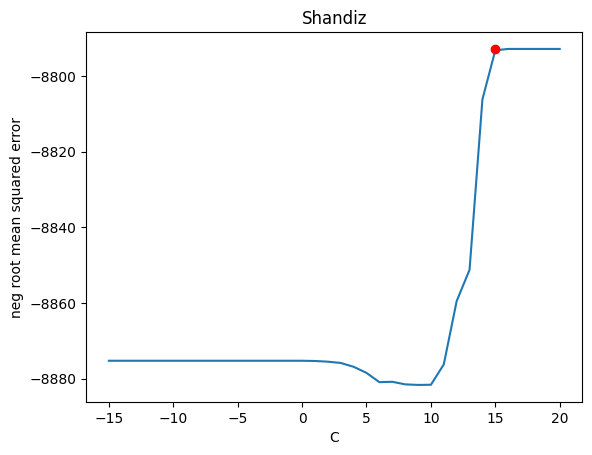

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**_ for _ in range(-15,21)],
            'gamma': [0.03125],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_sha, trainY_sha)

plt.plot(range(-15,21), gs_svr.cv_results_['mean_test_score'])
plt.plot(15, gs_svr.cv_results_['mean_test_score'][31], 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**9],
            'gamma': [2**_ for _ in range(-14,6)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_jim, trainY_jim)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [512],
                         'gamma': [6.103515625e-05, 0.0001220703125,
                                   0.000244140625, 0.00048828125, 0.0009765625,
                                   0.001953125, 0.00390625, 0.0078125, 0.015625,
                                   0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4,
                                   8, 16, 32],
                         'kernel': ['rbf'], 'max_iter': [100000]},
             scoring='neg_root_mean_squared_error')

-14


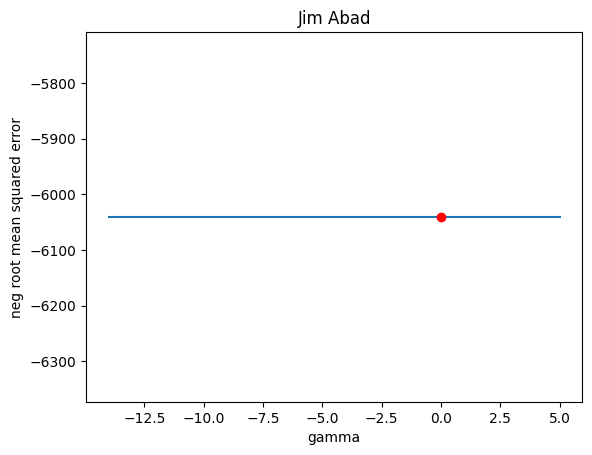

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-14)

plt.plot(range(-14,6), gs_svr.cv_results_['mean_test_score'])
plt.plot(0, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**13],
            'gamma': [2**_ for _ in range(-14,6)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_abb, trainY_abb)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [8192],
                         'gamma': [6.103515625e-05, 0.0001220703125,
                                   0.000244140625, 0.00048828125, 0.0009765625,
                                   0.001953125, 0.00390625, 0.0078125, 0.015625,
                                   0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4,
                                   8, 16, 32],
                         'kernel': ['rbf'], 'max_iter': [100000]},
             scoring='neg_root_mean_squared_error')

-14


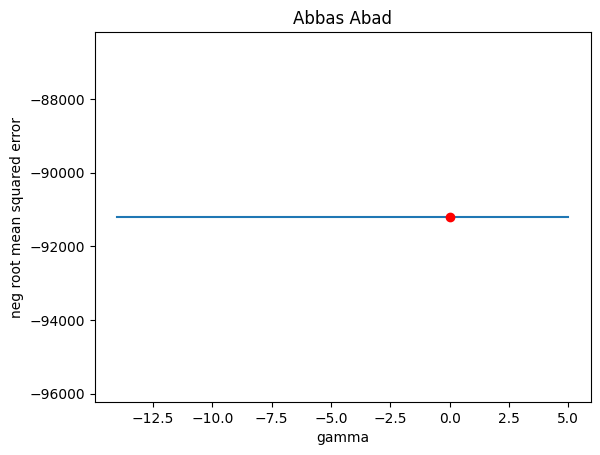

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-14)

plt.plot(range(-14,6), gs_svr.cv_results_['mean_test_score'])
plt.plot(0, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**14],
            'gamma': [2**_ for _ in range(-13,6)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_sim, trainY_sim)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [16384],
                         'gamma': [0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16,
                                   32],
                         'kernel': ['rbf'], 'max_iter': [100000]},
             scoring='neg_root_mean_squared_error')

-12


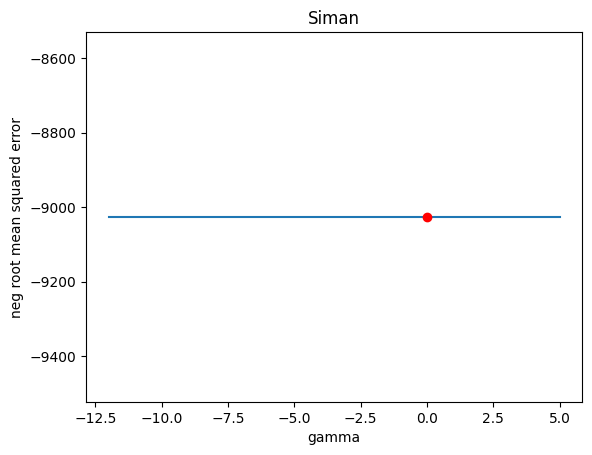

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-13)

plt.plot(range(-12,6), gs_svr.cv_results_['mean_test_score'][1:])
plt.plot(0, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**8],
            'gamma': [2**_ for _ in range(-15,6)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_kal, trainY_kal)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [256],
                         'gamma': [3.0517578125e-05, 6.103515625e-05,
                                   0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16,
                                   32],
                         'kernel': ['rbf'], 'max_iter': [100000]},
             scoring='neg_root_mean_squared_error')

-15


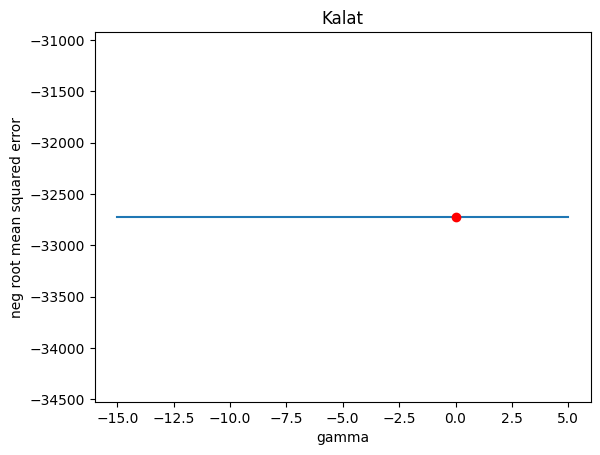

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,6), gs_svr.cv_results_['mean_test_score'])
plt.plot(0, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**8],
            'gamma': [2**_ for _ in range(-15,6)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_wes, trainY_wes)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [256],
                         'gamma': [3.0517578125e-05, 6.103515625e-05,
                                   0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16,
                                   32],
                         'kernel': ['rbf'], 'max_iter': [100000]},
             scoring='neg_root_mean_squared_error')

-15


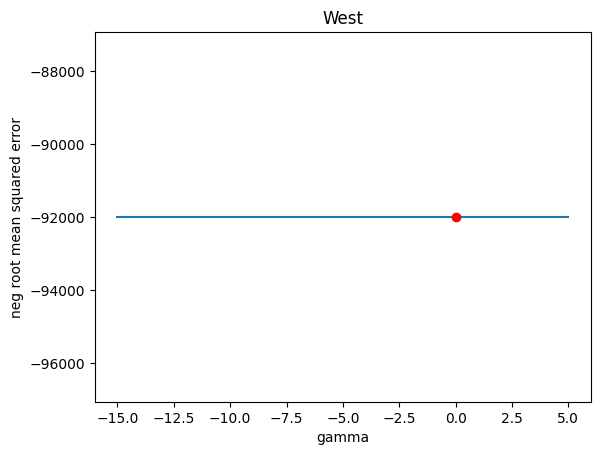

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,6), gs_svr.cv_results_['mean_test_score'])
plt.plot(0, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**15],
            'gamma': [2**_ for _ in range(-15,6)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_ara, trainY_ara)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [32768],
                         'gamma': [3.0517578125e-05, 6.103515625e-05,
                                   0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16,
                                   32],
                         'kernel': ['rbf'], 'max_iter': [100000]},
             scoring='neg_root_mean_squared_error')

-15


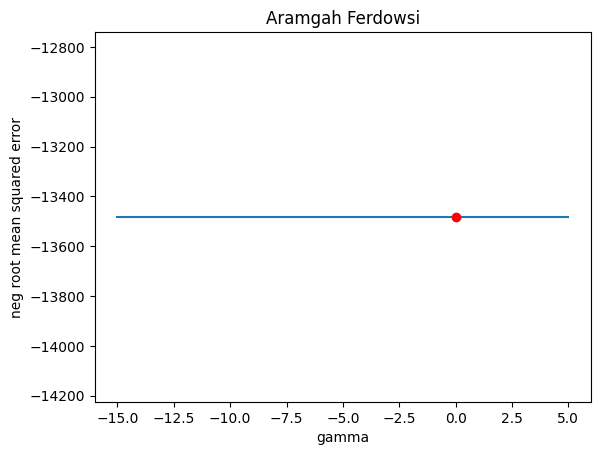

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,6), gs_svr.cv_results_['mean_test_score'])
plt.plot(0, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()

In [ ]:
param_svr = {'kernel': ['rbf'],
            'C': [2**15],
            'gamma': [2**_ for _ in range(-15,6)],
            'max_iter': [100000]}

gs_svr = GridSearchCV(svr, param_svr, cv=5, scoring='neg_root_mean_squared_error')
gs_svr.fit(trainX_sha, trainY_sha)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [32768],
                         'gamma': [3.0517578125e-05, 6.103515625e-05,
                                   0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16,
                                   32],
                         'kernel': ['rbf'], 'max_iter': [100000]},
             scoring='neg_root_mean_squared_error')

-15


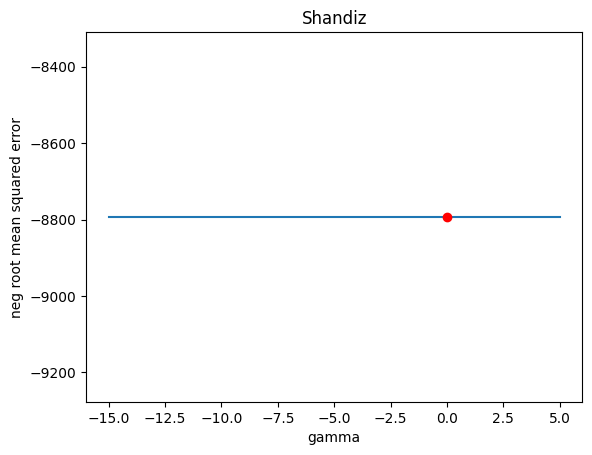

In [ ]:
print(gs_svr.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,6), gs_svr.cv_results_['mean_test_score'])
plt.plot(0, gs_svr.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()

In [ ]:
svr_jim = SVR(kernel='rbf', C=2**(9), gamma=1.0)
svr_abb = SVR(kernel='rbf', C=2**(13), gamma=1.0)
svr_sim = SVR(kernel='rbf', C=2**(14), gamma=1.0)
svr_kal = SVR(kernel='rbf', C=2**(8), gamma=1.0)
svr_wes = SVR(kernel='rbf', C=2**(8), gamma=1.0)
svr_ara = SVR(kernel='rbf', C=2**(15), gamma=1.0)
svr_sha = SVR(kernel='rbf', C=2**(15), gamma=1.0)


In [ ]:
svr_jim.fit(trainX_jim, trainY_jim)
svr_abb.fit(trainX_abb, trainY_abb)
svr_sim.fit(trainX_sim, trainY_sim)
svr_kal.fit(trainX_kal, trainY_kal)
svr_wes.fit(trainX_wes, trainY_wes)
svr_ara.fit(trainX_ara, trainY_ara)
svr_sha.fit(trainX_sha, trainY_sha)


SVR(C=32768, gamma=1.0)

In [ ]:
svr_jim_val = svr_jim.predict(trainX_jim)
svr_jim_prd = svr_jim.predict(testX_jim)

svr_abb_val = svr_abb.predict(trainX_abb)
svr_abb_prd = svr_abb.predict(testX_abb)

svr_sim_val = svr_sim.predict(trainX_sim)
svr_sim_prd = svr_sim.predict(testX_sim)

svr_kal_val = svr_kal.predict(trainX_kal)
svr_kal_prd = svr_kal.predict(testX_kal)

svr_wes_val = svr_wes.predict(trainX_wes)
svr_wes_prd = svr_wes.predict(testX_wes)

svr_ara_val = svr_ara.predict(trainX_ara)
svr_ara_prd = svr_ara.predict(testX_ara)

svr_sha_val = svr_sha.predict(trainX_sha)
svr_sha_prd = svr_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, svr_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, svr_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, svr_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, svr_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, svr_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, svr_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, svr_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, svr_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, svr_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, svr_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, svr_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, svr_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, svr_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, svr_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, svr_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, svr_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, svr_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, svr_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, svr_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, svr_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, svr_sha_val), 3))


Jim	 3744.339 	 5896.38 	 37.894
Abb	 57255.755 	 88663.012 	 637.155
Sim	 10.648 	 196.679 	 1.297
Kal	 26439.662 	 32765.01 	 0.23
Wes	 72922.312 	 102610.574 	 1.635
Ara	 119.443 	 1177.801 	 0.001
Sha	 0.1 	 0.1 	 0.0


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, svr_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, svr_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, svr_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, svr_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, svr_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, svr_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, svr_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, svr_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, svr_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, svr_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, svr_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, svr_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, svr_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, svr_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, svr_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, svr_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, svr_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, svr_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, svr_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, svr_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, svr_sha_prd), 3))


Jim	 4326.081 	 5153.13 	 0.361
Abb	 224970.425 	 228472.802 	 0.724
Sim	 5908.852 	 7023.81 	 0.226
Kal	 45148.634 	 50768.442 	 0.677
Wes	 143753.893 	 153037.319 	 0.605
Ara	 13101.733 	 16324.342 	 0.147
Sha	 4842.201 	 6282.773 	 0.135


### Polynomial


In [ ]:
svp = SVR()

param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-5,5)],
            'gamma': [2**_ for _ in range(-5,5)],
            'degree': [2,3],
            'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error', verbose=2)


In [ ]:
warnings.filterwarnings("ignore")

%time gs_svr.fit(trainX_jim, trainY_jim)
print('Jim', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_abb, trainY_abb)
print('Abb', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_sim, trainY_sim)
print('Sim', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_kal, trainY_kal)
print('Kal', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=   7.2s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=   5.7s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=   7.4s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=   5.7s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=   7.7s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=   5.5s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=   7.3s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=   5.8s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=   7.3s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=   6.8s
[

In [ ]:
warnings.filterwarnings("ignore")

%time gs_svr.fit(trainX_sim, trainY_sim)
print('Sim', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_kal, trainY_kal)
print('Kal', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  15.5s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  16.6s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  15.8s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  15.5s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  15.7s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  15.6s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  15.2s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  15.7s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  16.6s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  16.4s
[

In [ ]:
warnings.filterwarnings("ignore")

%time gs_svr.fit(trainX_wes, trainY_wes)
print('Wes', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_ara, trainY_ara)
print('Ara', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')

%time gs_svr.fit(trainX_sha, trainY_sha)
print('Sha', gs_svr.best_params_)
print(gs_svr.best_score_,'\n')


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  10.2s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  10.1s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  14.7s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  15.5s
[CV] END C=0.03125, degree=2, gamma=0.03125, kernel=poly, max_iter=100000; total time=  14.8s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  14.8s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  14.5s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  13.9s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  14.9s
[CV] END C=0.03125, degree=2, gamma=0.0625, kernel=poly, max_iter=100000; total time=  14.0s
[

Wall time: 1h 47min 48s
Jim {'C': 0.0625, 'degree': 2, 'gamma': 4, 'kernel': 'poly', 'max_iter': 100000}
-123300.95606965008

Wall time: 3h 17min 29s
Abb {'C': 0.03125, 'degree': 2, 'gamma': 4, 'kernel': 'poly', 'max_iter': 100000}
-1170763.7093607844

Wall time: 4h 23min 31s
Sim {'C': 0.03125, 'degree': 2, 'gamma': 0.03125, 'kernel': 'poly', 'max_iter': 100000}
-12424.145223959797

Wall time: 0h 55min 31s
Kal {'C': 0.03125, 'degree': 3, 'gamma': 0.03125, 'kernel': 'poly', 'max_iter': 100000}
-42031.13646175519

Wall time: 2h 23min 52s
Wes {'C': 0.125, 'degree': 2, 'gamma': 16, 'kernel': 'poly', 'max_iter': 100000}
-18894621.57250336

Wall time: 0h 15min 51s
Ara {'C': 0.03125, 'degree': 2, 'gamma': 0.03125, 'kernel': 'poly', 'max_iter': 100000}
-23805.26364104667

Wall time: 0h 55min 11s
Sha {'C': 0.03125, 'degree': 2, 'gamma': 0.03125, 'kernel': 'poly', 'max_iter': 100000}
-15928.826163255144

-12


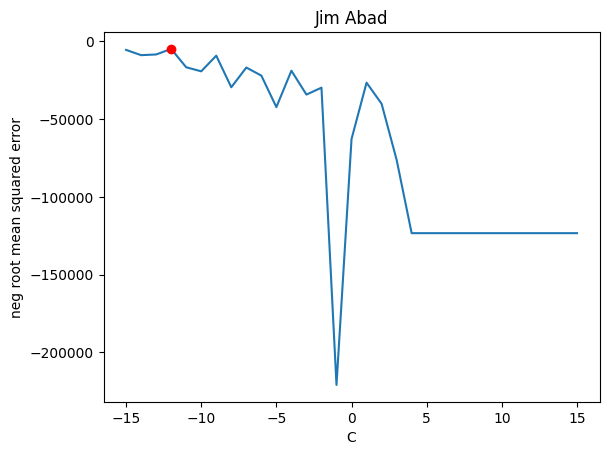

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [2**(-12)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_jim, trainY_jim)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


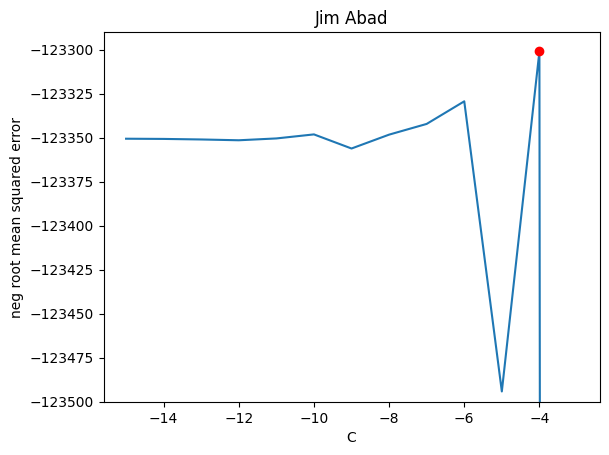

In [ ]:
plt.plot(range(-15,-2), gs_svp.cv_results_['mean_test_score'][:13])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.ylim(-123500, -123290)
plt.title('Jim Abad')

plt.show()


-5


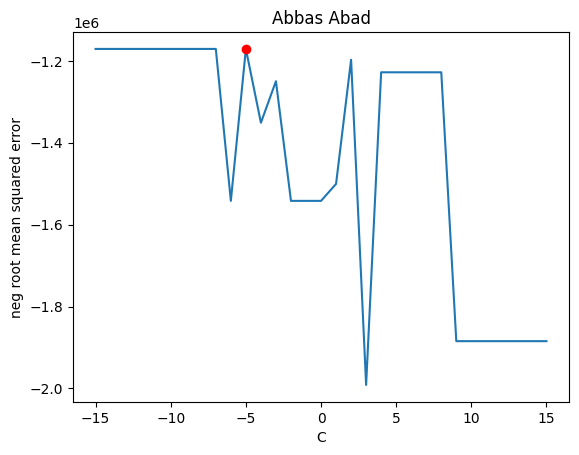

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [4],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_abb, trainY_abb)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


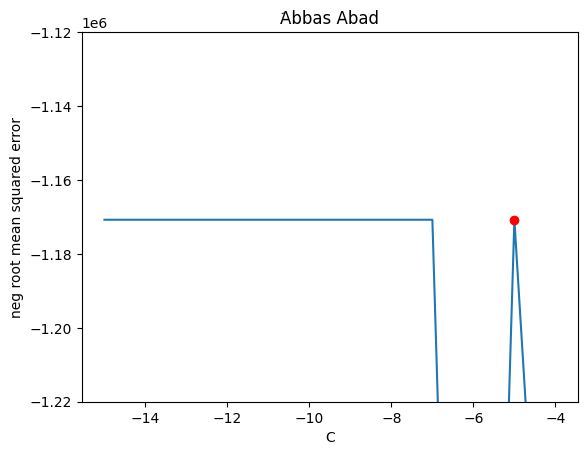

In [ ]:
plt.plot(range(-15,-3), gs_svp.cv_results_['mean_test_score'][:12])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.ylim(-1220000, -1120000)
plt.title('َAbbas Abad')

plt.show()


-15


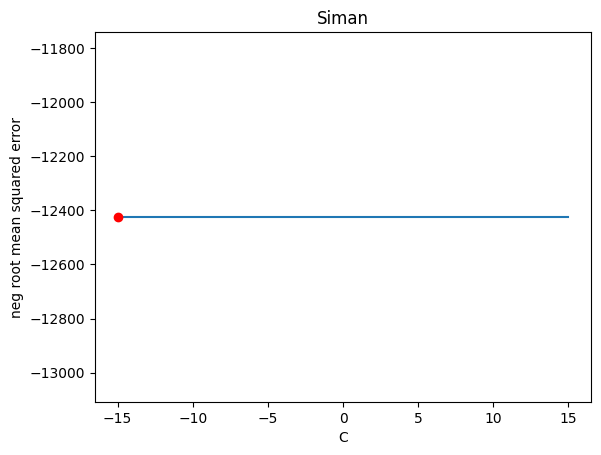

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [0.03125],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_sim, trainY_sim)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


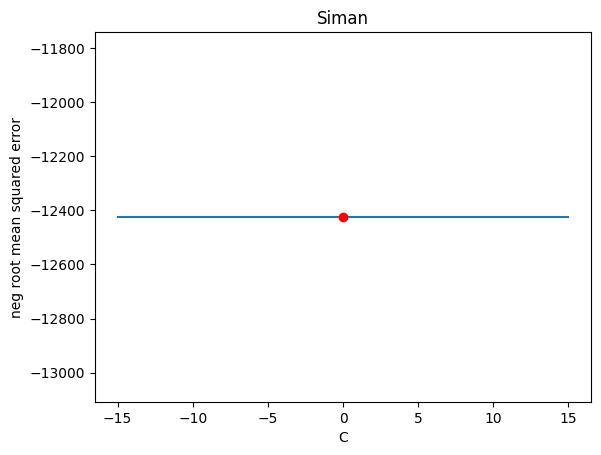

In [ ]:
plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(0, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


-15


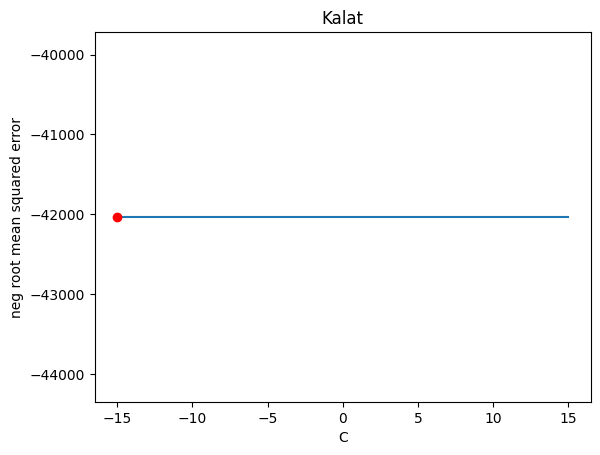

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [0.03125],
            'degree': [3],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_kal, trainY_kal)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


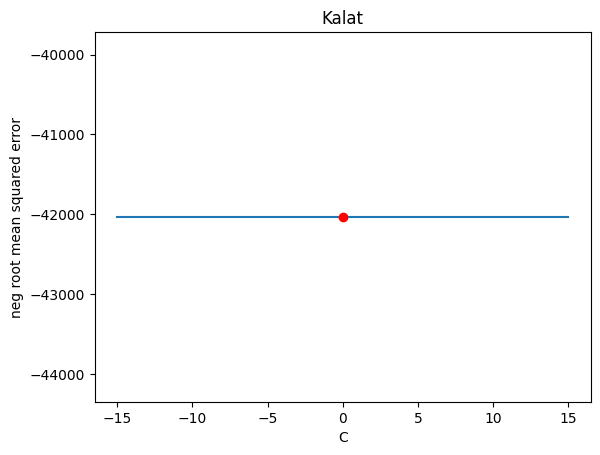

In [ ]:
plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(0, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).

-3


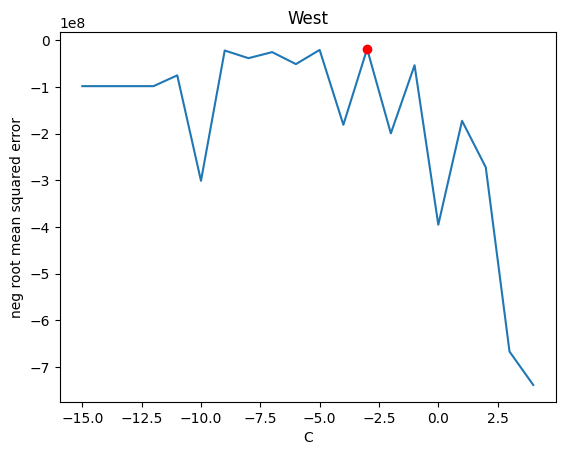

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-15,5)],
            'gamma': [16],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_wes, trainY_wes)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,5), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


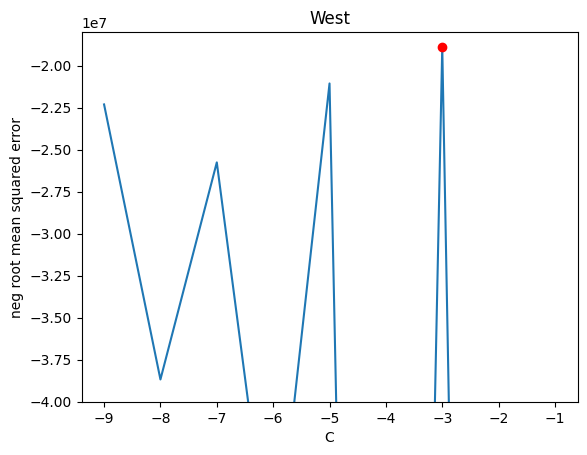

In [ ]:
plt.plot(range(-9,0), gs_svp.cv_results_['mean_test_score'][6:15])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.ylim(-40000000, -18000000)
plt.title('West')

plt.show()


-8


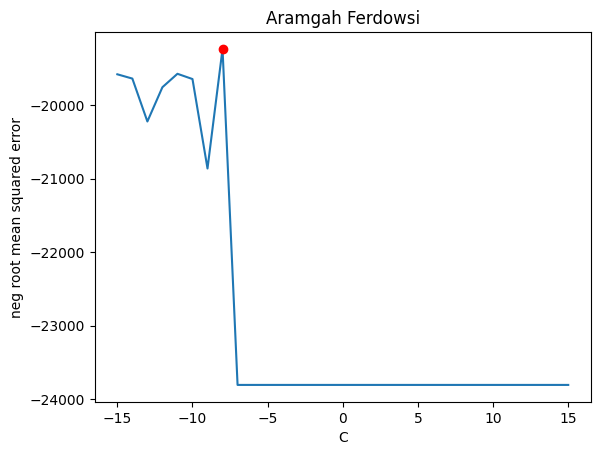

In [ ]:
warnings.filterwarnings("ignore")

param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [0.03125],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_ara, trainY_ara)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


-15


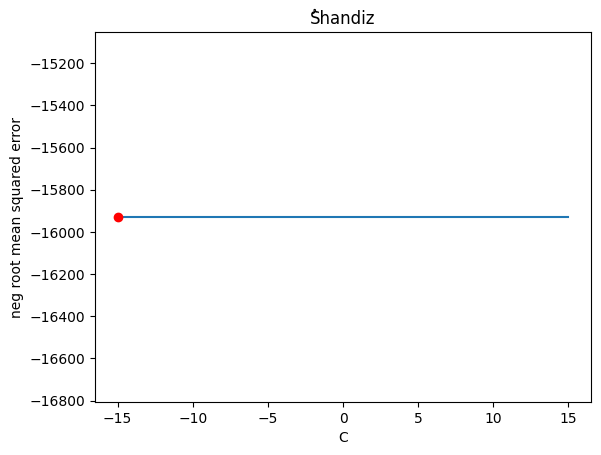

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**_ for _ in range(-15,16)],
            'gamma': [0.03125],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_sha, trainY_sha)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('ُShandiz')

plt.show()


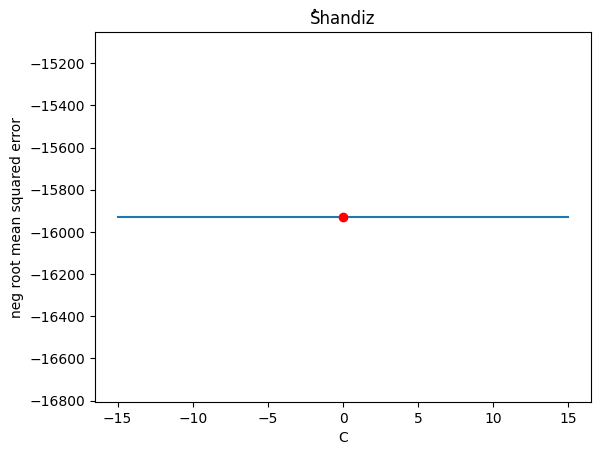

In [ ]:
plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(0, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('C')
plt.ylabel('neg root mean squared error')
plt.title('ُShandiz')

plt.show()


-15


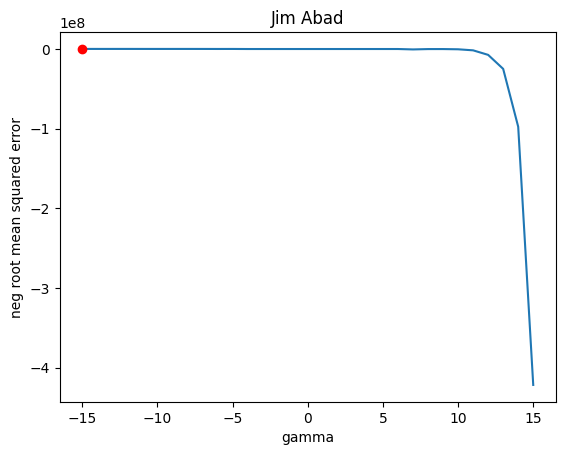

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**(-12)],
            'gamma': [2**_ for _ in range(-15,16)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_jim, trainY_jim)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


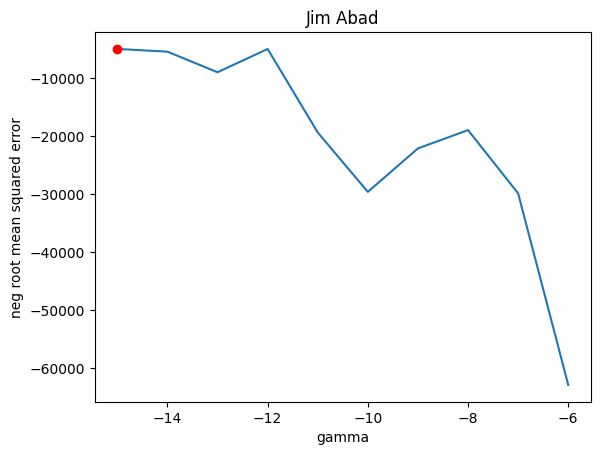

In [ ]:
plt.plot(range(-15,-5), gs_svp.cv_results_['mean_test_score'][:10])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


-15


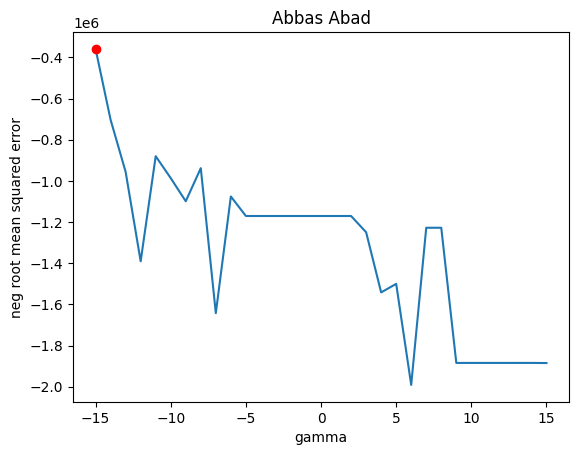

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**(-5)],
            'gamma': [2**_ for _ in range(-15,16)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_abb, trainY_abb)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


-15


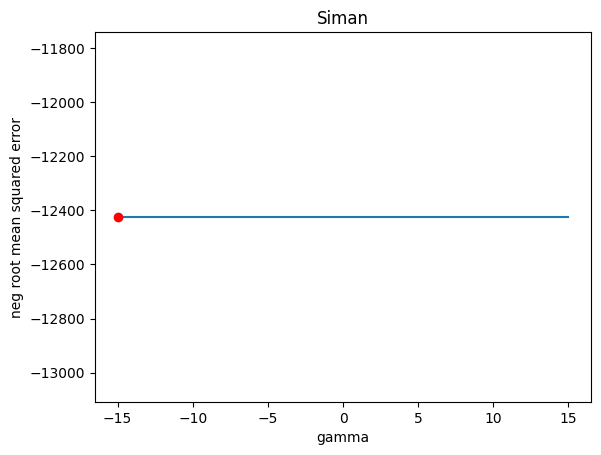

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**0],
            'gamma': [2**_ for _ in range(-15,16)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_sim, trainY_sim)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


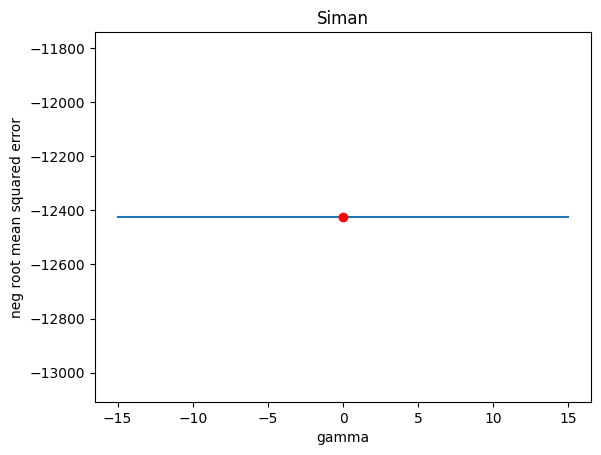

In [ ]:
plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(0, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


In [ ]:
warnings.filterwarnings("ignore")

param_svp = {'kernel': ['poly'],
            'C': [2**0],
            'gamma': [2**_ for _ in range(-15,16)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_kal, trainY_kal)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(0, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


KeyboardInterrupt: 

-11


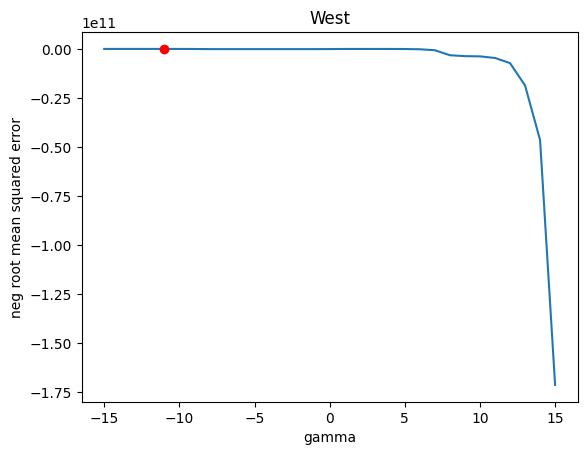

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**(-3)],
            'gamma': [2**_ for _ in range(-15,16)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_wes, trainY_wes)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


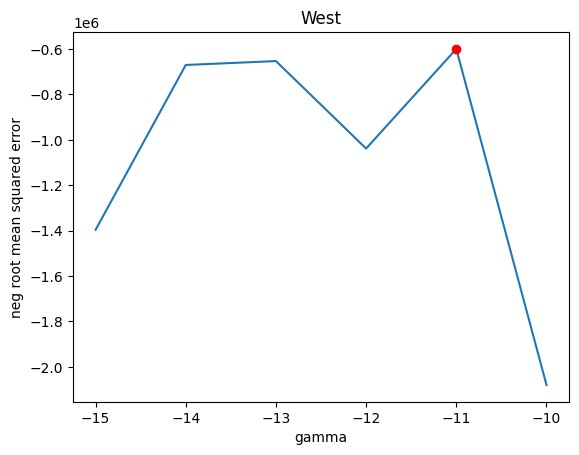

In [ ]:
plt.plot(range(-15,-9), gs_svp.cv_results_['mean_test_score'][:6])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


-5


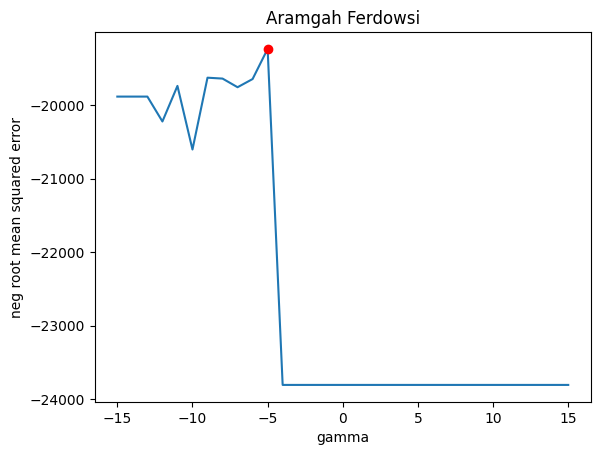

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**(-8)],
            'gamma': [2**_ for _ in range(-15,16)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_ara, trainY_ara)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


-15


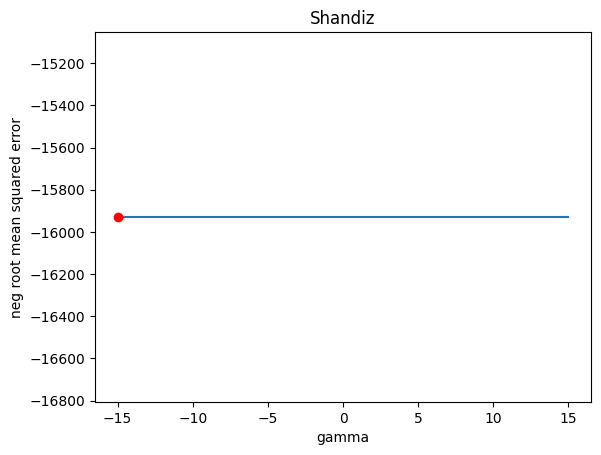

In [ ]:
param_svp = {'kernel': ['poly'],
            'C': [2**0],
            'gamma': [2**_ for _ in range(-15,16)],
            'degree': [2],
            'max_iter': [100000]}

gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_sha, trainY_sha)

print(gs_svp.cv_results_['mean_test_score'].argmax()-15)

plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(gs_svp.cv_results_['mean_test_score'].argmax()-15, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


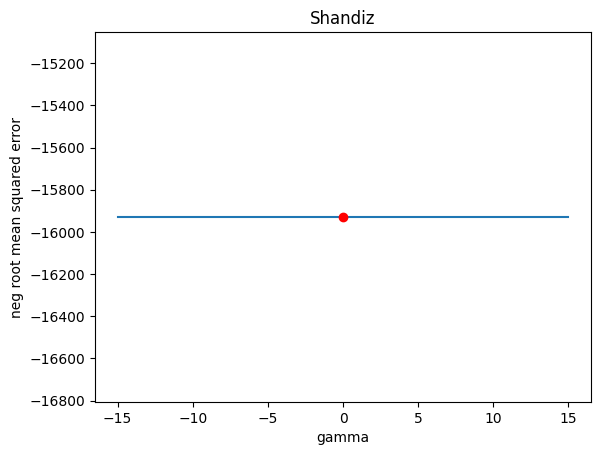

In [ ]:
plt.plot(range(-15,16), gs_svp.cv_results_['mean_test_score'])
plt.plot(0, gs_svp.cv_results_['mean_test_score'].max(), 'ro')

plt.xlabel('gamma')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


In [ ]:
param_svp = {'kernel': ['poly'], 'C': [2**(-12)], 'gamma': [2**(-15)], 'degree': [2,3], 'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_jim, trainY_jim)
print('jim: ', gs_svp.cv_results_['mean_test_score'])

param_svp = {'kernel': ['poly'], 'C': [2**(-5)], 'gamma': [2**(-15)], 'degree': [2,3], 'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_abb, trainY_abb)
print('abb: ', gs_svp.cv_results_['mean_test_score'])

param_svp = {'kernel': ['poly'], 'C': [2**(0)], 'gamma': [2**(0)], 'degree': [2,3], 'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_sim, trainY_sim)
print('sim: ', gs_svp.cv_results_['mean_test_score'])

param_svp = {'kernel': ['poly'], 'C': [2**(0)], 'gamma': [2**(0)], 'degree': [2,3], 'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_kal, trainY_kal)
print('kal: ', gs_svp.cv_results_['mean_test_score'])

param_svp = {'kernel': ['poly'], 'C': [2**(-3)], 'gamma': [2**(-11)], 'degree': [2,3], 'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_wes, trainY_wes)
print('wes: ', gs_svp.cv_results_['mean_test_score'])

param_svp = {'kernel': ['poly'], 'C': [2**(-8)], 'gamma': [2**(-5)], 'degree': [2,3], 'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_ara, trainY_ara)
print('ara: ', gs_svp.cv_results_['mean_test_score'])

param_svp = {'kernel': ['poly'], 'C': [2**(0)], 'gamma': [2**(0)], 'degree': [2,3], 'max_iter': [100000]}
gs_svp = GridSearchCV(svp, param_svp, cv=5, scoring='neg_root_mean_squared_error')
gs_svp.fit(trainX_sha, trainY_sha)
print('sha: ', gs_svp.cv_results_['mean_test_score'])


jim:  [ -4947.68849831 -76722.03294563]
abb:  [  -359096.26267221 -10674746.63445043]
sim:  [-12424.14522396 -74479.55620121]
kal:  [-61849.68535902 -42031.13646176]
wes:  [-5.99761037e+05 -7.40956029e+09]
ara:  [-19238.27400376 -36795.52739479]
sha:  [-15928.82616326 -23528.36022149]


In [ ]:
svp_jim = SVR(kernel='poly', C=2**(-12), gamma=2**(-15), degree=2, max_iter=10000000)
svp_abb = SVR(kernel='poly', C=2**(-5), gamma=2**(-15), degree=2, max_iter=10000000)
svp_sim = SVR(kernel='poly', C=2**(0), gamma=2**(0), degree=2, max_iter=10000000)
svp_kal = SVR(kernel='poly', C=2**(0), gamma=2**(0), degree=3, max_iter=10000000)
svp_wes = SVR(kernel='poly', C=2**(-3), gamma=2**(-11), degree=2, max_iter=10000000)
svp_ara = SVR(kernel='poly', C=2**(-8), gamma=2**(-5), degree=2, max_iter=10000000)
svp_sha = SVR(kernel='poly', C=2**(0), gamma=2**(0), degree=2, max_iter=10000000)


In [ ]:
svp_jim.fit(trainX_jim, trainY_jim)
svp_abb.fit(trainX_abb, trainY_abb)
svp_sim.fit(trainX_sim, trainY_sim)
svp_kal.fit(trainX_kal, trainY_kal)
svp_wes.fit(trainX_wes, trainY_wes)
svp_ara.fit(trainX_ara, trainY_ara)
svp_sha.fit(trainX_sha, trainY_sha)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=

In [ ]:
svp_jim_val = svp_jim.predict(trainX_jim)
svp_jim_prd = svp_jim.predict(testX_jim)

svp_abb_val = svp_abb.predict(trainX_abb)
svp_abb_prd = svp_abb.predict(testX_abb)

svp_sim_val = svp_sim.predict(trainX_sim)
svp_sim_prd = svp_sim.predict(testX_sim)

svp_kal_val = svp_kal.predict(trainX_kal)
svp_kal_prd = svp_kal.predict(testX_kal)

svp_wes_val = svp_wes.predict(trainX_wes)
svp_wes_prd = svp_wes.predict(testX_wes)

svp_ara_val = svp_ara.predict(trainX_ara)
svp_ara_prd = svp_ara.predict(testX_ara)

svp_sha_val = svp_sha.predict(trainX_sha)
svp_sha_prd = svp_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, svp_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, svp_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, svp_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, svp_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, svp_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, svp_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, svp_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, svp_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, svp_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, svp_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, svp_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, svp_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, svp_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, svp_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, svp_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, svp_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, svp_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, svp_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, svp_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, svp_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, svp_sha_val), 3))


Jim	 1537.499 	 3000.935 	 21.522
Abb	 213900933.824 	 283580867.884 	 2063940.574
Sim	 703873167802028.2 	 1214180029175094.0 	 966340533116.29
Kal	 192244.023 	 279138.479 	 1.513
Wes	 46066685464.713 	 64750373277.666 	 1161091.406
Ara	 155209891898.735 	 241396004782.133 	 1552302.483
Sha	 1734385877.134 	 2188971617.664 	 72685.598


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, svp_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, svp_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, svp_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, svp_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, svp_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, svp_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, svp_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, svp_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, svp_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, svp_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, svp_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, svp_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, svp_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, svp_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, svp_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, svp_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, svp_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, svp_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, svp_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, svp_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, svp_sha_prd), 3))


Jim	 1400.491 	 2085.734 	 0.127
Abb	 747849104.498 	 776903545.003 	 2415.967
Sim	 651340760233660.8 	 873793040863539.2 	 24220300534.517
Kal	 194246.529 	 226054.596 	 2.481
Wes	 70690630097.245 	 109986133573.134 	 299370.439
Ara	 315120881870.655 	 409553263817.922 	 3321712.872
Sha	 1374835134.802 	 1825864987.794 	 40049.242


## LIR (Linear Regression)

In [ ]:
lir = LinearRegression()
param_lr = None
gs_lr = GridSearchCV(lir, param_lr, cv=5, scoring='neg_root_mean_squared_error')


In [ ]:
lir_jim = LinearRegression()
lir_abb = LinearRegression()
lir_sim = LinearRegression()
lir_kal = LinearRegression()
lir_wes = LinearRegression()
lir_ara = LinearRegression()
lir_sha = LinearRegression()


In [ ]:
lir_jim.fit(trainX_jim, trainY_jim)
lir_abb.fit(trainX_abb, trainY_abb)
lir_sim.fit(trainX_sim, trainY_sim)
lir_kal.fit(trainX_kal, trainY_kal)
lir_wes.fit(trainX_wes, trainY_wes)
lir_ara.fit(trainX_ara, trainY_ara)
lir_sha.fit(trainX_sha, trainY_sha)


LinearRegression()

In [ ]:
lir_jim_val = lir_jim.predict(trainX_jim)
lir_jim_prd = lir_jim.predict(testX_jim)

lir_abb_val = lir_abb.predict(trainX_abb)
lir_abb_prd = lir_abb.predict(testX_abb)

lir_sim_val = lir_sim.predict(trainX_sim)
lir_sim_prd = lir_sim.predict(testX_sim)

lir_kal_val = lir_kal.predict(trainX_kal)
lir_kal_prd = lir_kal.predict(testX_kal)

lir_wes_val = lir_wes.predict(trainX_wes)
lir_wes_prd = lir_wes.predict(testX_wes)

lir_ara_val = lir_ara.predict(trainX_ara)
lir_ara_prd = lir_ara.predict(testX_ara)

lir_sha_val = lir_sha.predict(trainX_sha)
lir_sha_prd = lir_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, lir_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, lir_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, lir_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, lir_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, lir_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, lir_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, lir_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, lir_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, lir_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, lir_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, lir_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, lir_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, lir_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, lir_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, lir_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, lir_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, lir_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, lir_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, lir_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, lir_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, lir_sha_val), 3))


Jim	 712.018 	 1339.875 	 0.738
Abb	 6348.899 	 12096.667 	 23.728
Sim	 1349.886 	 1917.276 	 6.356
Kal	 14680.003 	 19395.846 	 0.119
Wes	 6945.815 	 12401.292 	 0.117
Ara	 6273.637 	 9090.945 	 0.06
Sha	 2848.745 	 3980.81 	 0.126


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, lir_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, lir_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, lir_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, lir_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, lir_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, lir_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, lir_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, lir_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, lir_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, lir_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, lir_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, lir_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, lir_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, lir_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, lir_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, lir_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, lir_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, lir_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, lir_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, lir_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, lir_sha_prd), 3))


Jim	 988.246 	 1537.285 	 0.079
Abb	 10787.218 	 20123.771 	 0.054
Sim	 1453.165 	 1945.234 	 0.058
Kal	 12402.242 	 15613.425 	 0.159
Wes	 12705.626 	 22113.528 	 0.059
Ara	 8515.967 	 11229.771 	 0.09
Sha	 3245.766 	 4354.759 	 0.096


## LR-SVM

In [ ]:


round(mean_absolute_percentage_error(testY_jim, (lir_jim_prd+svl_jim_prd)/2), 3)

0.077

In [ ]:
len(svl_jim_prd[1:])

753

In [ ]:
mean_absolute_percentage_error(testY_jim[:753], svl_jim_prd[1:])


0.028681250833886583

In [ ]:
mean_absolute_percentage_error(testY_jim[:753], lir_jim_prd[1:])

0.045262345265305995

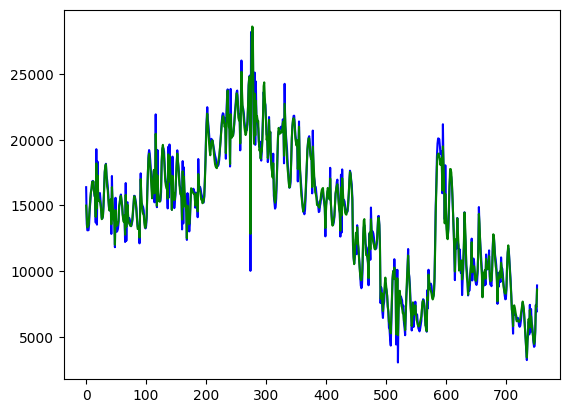

In [ ]:
plt.plot(testY_jim[:753], 'blue')
#plt.plot(lir_jim_prd[:50], 'red')
plt.plot(svl_jim_prd[1:], 'green')
#plt.plot((svl_jim_prd[:10]+lir_jim_prd[:100])/2)

## RIR (Ridge Regression)

In [ ]:
rir = Ridge()
param_rg = {'alpha': [2**_ for _ in range(0,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')


In [ ]:
%time gs_rg.fit(trainX_jim, trainY_jim)
print('Jim', gs_rg.best_params_)
print(gs_rg.best_score_,'\n')

%time gs_rg.fit(trainX_abb, trainY_abb)
print('Abb', gs_rg.best_params_)
print(gs_rg.best_score_,'\n')

%time gs_rg.fit(trainX_sim, trainY_sim)
print('Sim', gs_rg.best_params_)
print(gs_rg.best_score_,'\n')

%time gs_rg.fit(trainX_kal, trainY_kal)
print('Kal', gs_rg.best_params_)
print(gs_rg.best_score_,'\n')

%time gs_rg.fit(trainX_wes, trainY_wes)
print('Wes', gs_rg.best_params_)
print(gs_rg.best_score_,'\n')

%time gs_rg.fit(trainX_ara, trainY_ara)
print('Ara', gs_rg.best_params_)
print(gs_rg.best_score_,'\n')

%time gs_rg.fit(trainX_sha, trainY_sha)
print('Sha', gs_rg.best_params_)
print(gs_rg.best_score_,'\n')


CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 137 ms
Jim {'alpha': 512}
-1306.1052918604337 

CPU times: user 182 ms, sys: 2 ms, total: 184 ms
Wall time: 184 ms
Abb {'alpha': 512}
-11730.452479998137 

CPU times: user 211 ms, sys: 3.01 ms, total: 214 ms
Wall time: 216 ms
Sim {'alpha': 512}
-1903.0259377485436 

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 116 ms
Kal {'alpha': 512}
-19828.5935430957 

CPU times: user 157 ms, sys: 994 µs, total: 158 ms
Wall time: 158 ms
Wes {'alpha': 1}
-12277.178641300105 

CPU times: user 97.4 ms, sys: 1 ms, total: 98.4 ms
Wall time: 97.8 ms
Ara {'alpha': 512}
-8874.009370862008 

CPU times: user 128 ms, sys: 1 ms, total: 129 ms
Wall time: 129 ms
Sha {'alpha': 512}
-4039.2412325775867 



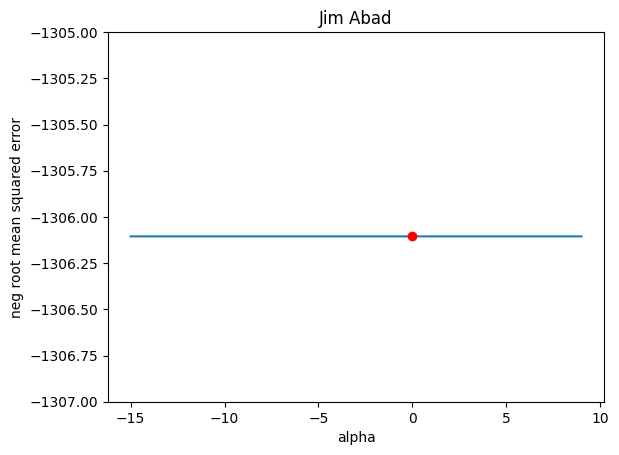

In [ ]:
param_rg = {'alpha': [2**_ for _ in range(-15,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')
gs_rg.fit(trainX_jim, trainY_jim)

plt.plot(range(-15,10), gs_rg.cv_results_['mean_test_score'])
plt.plot(0, gs_rg.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')
plt.ylim(-1307, -1305)

plt.show()


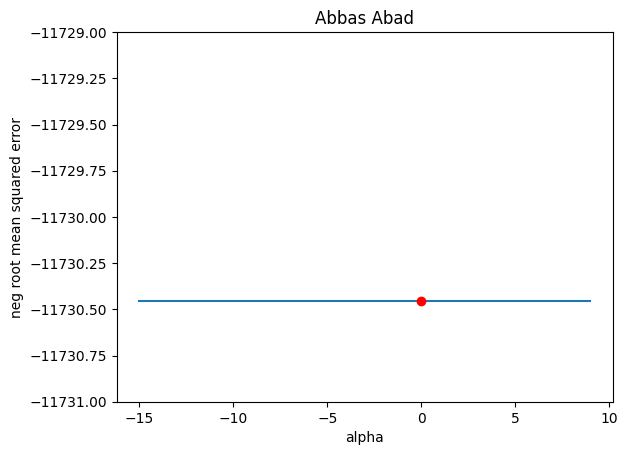

In [ ]:
param_rg = {'alpha': [2**_ for _ in range(-15,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')
gs_rg.fit(trainX_abb, trainY_abb)

plt.plot(range(-15,10), gs_rg.cv_results_['mean_test_score'])
plt.plot(0, gs_rg.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')
plt.ylim(-11731, -11729)

plt.show()


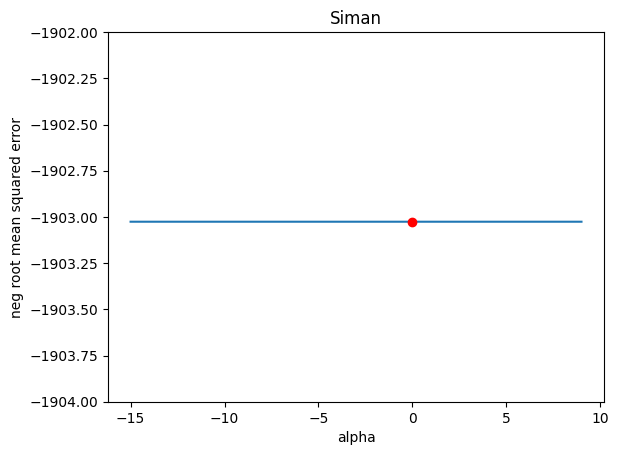

In [ ]:
param_rg = {'alpha': [2**_ for _ in range(-15,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')
gs_rg.fit(trainX_sim, trainY_sim)

plt.plot(range(-15,10), gs_rg.cv_results_['mean_test_score'])
plt.plot(0, gs_rg.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Siman')
plt.ylim(-1904, -1902)

plt.show()


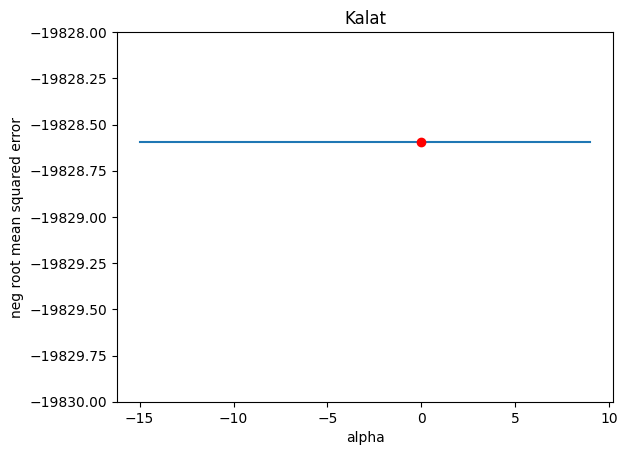

In [ ]:
param_rg = {'alpha': [2**_ for _ in range(-15,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')
gs_rg.fit(trainX_kal, trainY_kal)

plt.plot(range(-15,10), gs_rg.cv_results_['mean_test_score'])
plt.plot(0, gs_rg.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')
plt.ylim(-19830, -19828)

plt.show()


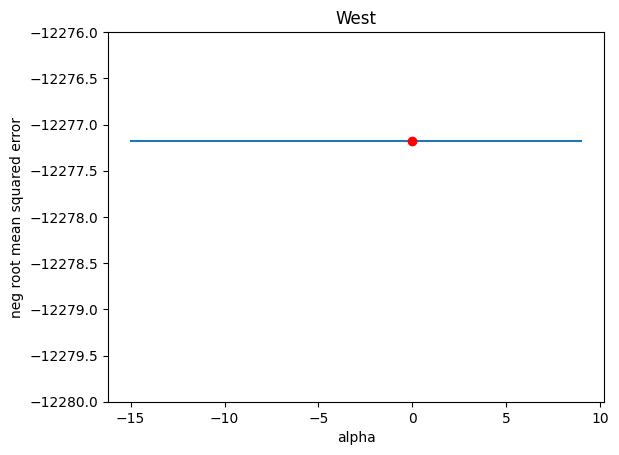

In [ ]:
param_rg = {'alpha': [2**_ for _ in range(-15,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')
gs_rg.fit(trainX_wes, trainY_wes)

plt.plot(range(-15,10), gs_rg.cv_results_['mean_test_score'])
plt.plot(0, gs_rg.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('West')
plt.ylim(-12280, -12276)

plt.show()


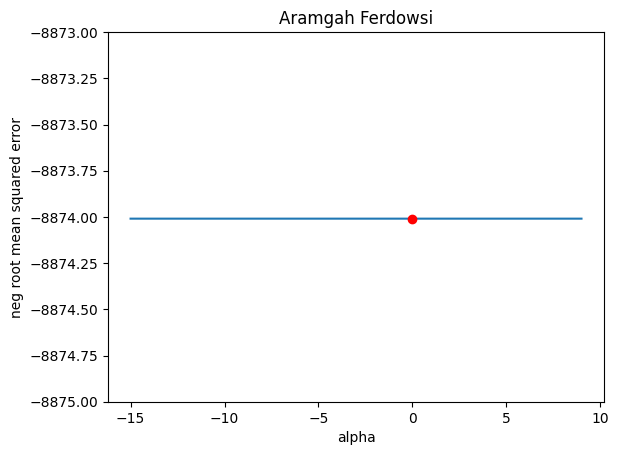

In [ ]:
param_rg = {'alpha': [2**_ for _ in range(-15,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')
gs_rg.fit(trainX_ara, trainY_ara)

plt.plot(range(-15,10), gs_rg.cv_results_['mean_test_score'])
plt.plot(0, gs_rg.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')
plt.ylim(-8875, -8873)

plt.show()


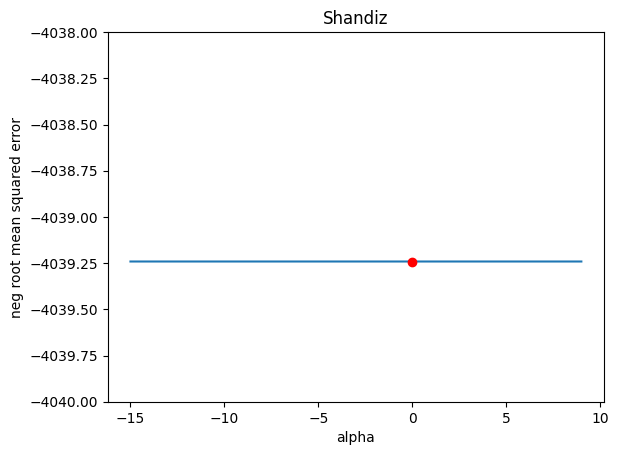

In [ ]:
param_rg = {'alpha': [2**_ for _ in range(-15,10)]}
gs_rg = GridSearchCV(rir, param_rg, cv=5, scoring='neg_root_mean_squared_error')
gs_rg.fit(trainX_sha, trainY_sha)

plt.plot(range(-15,10), gs_rg.cv_results_['mean_test_score'])
plt.plot(0, gs_rg.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')
plt.ylim(-4040, -4038)

plt.show()


In [ ]:
rir_jim = Ridge()
rir_abb = Ridge()
rir_sim = Ridge()
rir_kal = Ridge()
rir_wes = Ridge()
rir_ara = Ridge()
rir_sha = Ridge()


In [ ]:
rir_jim.fit(trainX_jim, trainY_jim)
rir_abb.fit(trainX_abb, trainY_abb)
rir_sim.fit(trainX_sim, trainY_sim)
rir_kal.fit(trainX_kal, trainY_kal)
rir_wes.fit(trainX_wes, trainY_wes)
rir_ara.fit(trainX_ara, trainY_ara)
rir_sha.fit(trainX_sha, trainY_sha)


Ridge()

In [ ]:
rir_jim_val = rir_jim.predict(trainX_jim)
rir_jim_prd = rir_jim.predict(testX_jim)

rir_abb_val = rir_abb.predict(trainX_abb)
rir_abb_prd = rir_abb.predict(testX_abb)

rir_sim_val = rir_sim.predict(trainX_sim)
rir_sim_prd = rir_sim.predict(testX_sim)

rir_kal_val = rir_kal.predict(trainX_kal)
rir_kal_prd = rir_kal.predict(testX_kal)

rir_wes_val = rir_wes.predict(trainX_wes)
rir_wes_prd = rir_wes.predict(testX_wes)

rir_ara_val = rir_ara.predict(trainX_ara)
rir_ara_prd = rir_ara.predict(testX_ara)

rir_sha_val = rir_sha.predict(trainX_sha)
rir_sha_prd = rir_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, rir_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, rir_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, rir_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, rir_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, rir_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, rir_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, rir_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, rir_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, rir_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, rir_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, rir_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, rir_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, rir_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, rir_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, rir_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, rir_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, rir_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, rir_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, rir_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, rir_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, rir_sha_val), 3))


Jim	 712.018 	 1339.875 	 0.738
Abb	 6348.899 	 12096.667 	 23.728
Sim	 1349.886 	 1917.276 	 6.356
Kal	 14680.003 	 19395.846 	 0.119
Wes	 6945.815 	 12401.292 	 0.117
Ara	 6273.637 	 9090.945 	 0.06
Sha	 2848.745 	 3980.81 	 0.126


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, rir_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, rir_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, rir_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, rir_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, rir_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, rir_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, rir_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, rir_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, rir_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, rir_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, rir_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, rir_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, rir_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, rir_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, rir_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, rir_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, rir_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, rir_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, rir_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, rir_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, rir_sha_prd), 3))


Jim	 988.246 	 1537.285 	 0.079
Abb	 10787.218 	 20123.771 	 0.054
Sim	 1453.165 	 1945.234 	 0.058
Kal	 12402.242 	 15613.425 	 0.159
Wes	 12705.626 	 22113.528 	 0.059
Ara	 8515.967 	 11229.771 	 0.09
Sha	 3245.766 	 4354.759 	 0.096


## LAR (Lasso Regression)

In [ ]:
lar = Lasso()
param_ls = {'alpha': [2**_ for _ in range(0,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')


In [ ]:
warnings.filterwarnings("ignore")

%time gs_ls.fit(trainX_jim, trainY_jim)
print('Jim', gs_ls.best_params_)
print(gs_ls.best_score_,'\n')

%time gs_ls.fit(trainX_abb, trainY_abb)
print('Abb', gs_ls.best_params_)
print(gs_ls.best_score_,'\n')

%time gs_ls.fit(trainX_sim, trainY_sim)
print('Sim', gs_ls.best_params_)
print(gs_ls.best_score_,'\n')

%time gs_ls.fit(trainX_kal, trainY_kal)
print('Kal', gs_ls.best_params_)
print(gs_ls.best_score_,'\n')

%time gs_ls.fit(trainX_wes, trainY_wes)
print('Wes', gs_ls.best_params_)
print(gs_ls.best_score_,'\n')

%time gs_ls.fit(trainX_ara, trainY_ara)
print('Ara', gs_ls.best_params_)
print(gs_ls.best_score_,'\n')

%time gs_ls.fit(trainX_sha, trainY_sha)
print('Sha', gs_ls.best_params_)
print(gs_ls.best_score_,'\n')


CPU times: user 3.8 s, sys: 2.96 ms, total: 3.8 s
Wall time: 3.81 s
Jim {'alpha': 512}
-1305.9233075573463 

CPU times: user 9.5 s, sys: 6.75 ms, total: 9.5 s
Wall time: 9.58 s
Abb {'alpha': 512}
-11728.949439199441 

CPU times: user 8.95 s, sys: 5.87 ms, total: 8.96 s
Wall time: 9 s
Sim {'alpha': 512}
-1902.8058361769545 

CPU times: user 683 ms, sys: 2.96 ms, total: 686 ms
Wall time: 710 ms
Kal {'alpha': 512}
-19828.583804352987 

CPU times: user 6.14 s, sys: 2.85 ms, total: 6.14 s
Wall time: 6.15 s
Wes {'alpha': 1}
-12273.682165768745 

CPU times: user 244 ms, sys: 991 µs, total: 245 ms
Wall time: 245 ms
Ara {'alpha': 512}
-8873.987173013189 

CPU times: user 500 ms, sys: 990 µs, total: 501 ms
Wall time: 499 ms
Sha {'alpha': 512}
-4039.172466722682 



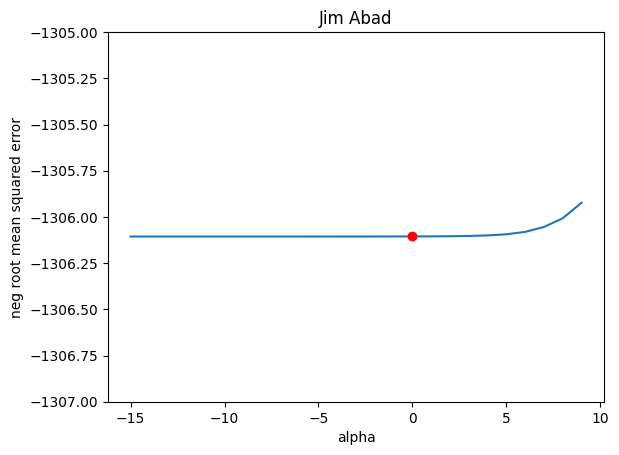

In [ ]:
warnings.filterwarnings("ignore")

param_ls = {'alpha': [2**_ for _ in range(-15,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')
gs_ls.fit(trainX_jim, trainY_jim)

plt.plot(range(-15,10), gs_ls.cv_results_['mean_test_score'])
plt.plot(0, gs_ls.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')
plt.ylim(-1307, -1305)

plt.show()


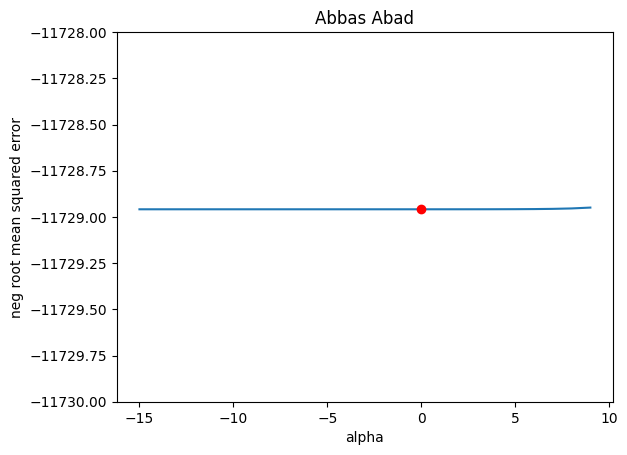

In [ ]:
param_ls = {'alpha': [2**_ for _ in range(-15,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')
gs_ls.fit(trainX_abb, trainY_abb)

plt.plot(range(-15,10), gs_ls.cv_results_['mean_test_score'])
plt.plot(0, gs_ls.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')
plt.ylim(-11730, -11728)

plt.show()


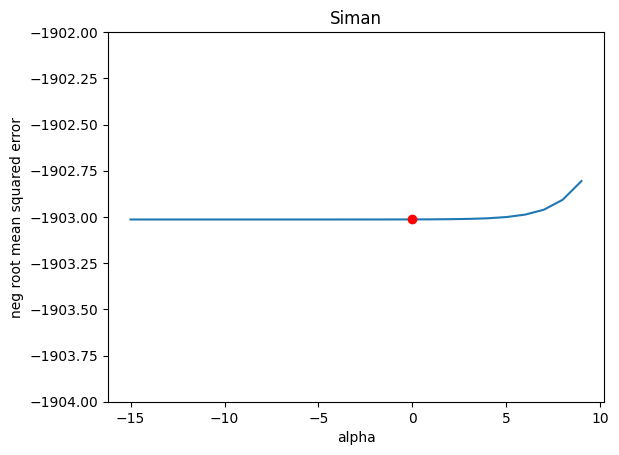

In [ ]:
param_ls = {'alpha': [2**_ for _ in range(-15,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')
gs_ls.fit(trainX_sim, trainY_sim)

plt.plot(range(-15,10), gs_ls.cv_results_['mean_test_score'])
plt.plot(0, gs_ls.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Siman')
plt.ylim(-1904, -1902)

plt.show()


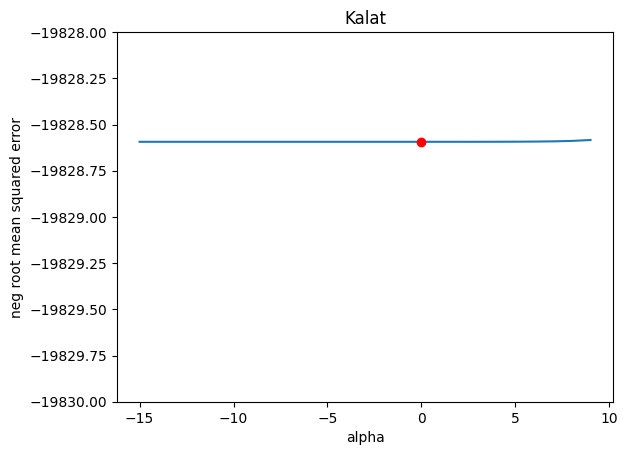

In [ ]:
param_ls = {'alpha': [2**_ for _ in range(-15,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')
gs_ls.fit(trainX_kal, trainY_kal)

plt.plot(range(-15,10), gs_ls.cv_results_['mean_test_score'])
plt.plot(0, gs_ls.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')
plt.ylim(-19830, -19828)

plt.show()


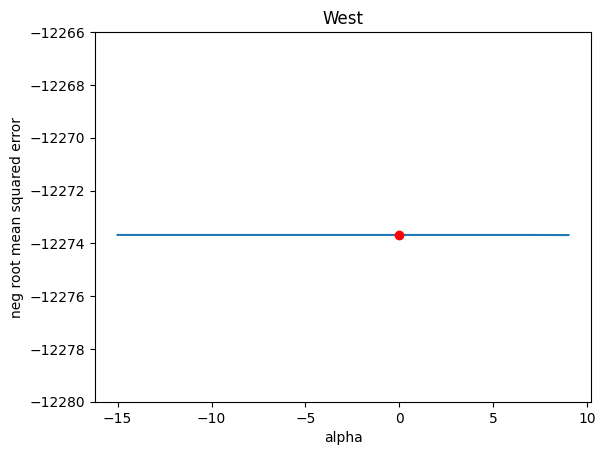

In [ ]:
param_ls = {'alpha': [2**_ for _ in range(-15,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')
gs_ls.fit(trainX_wes, trainY_wes)

plt.plot(range(-15,10), gs_ls.cv_results_['mean_test_score'])
plt.plot(0, gs_ls.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('West')
plt.ylim(-12280, -12266)

plt.show()


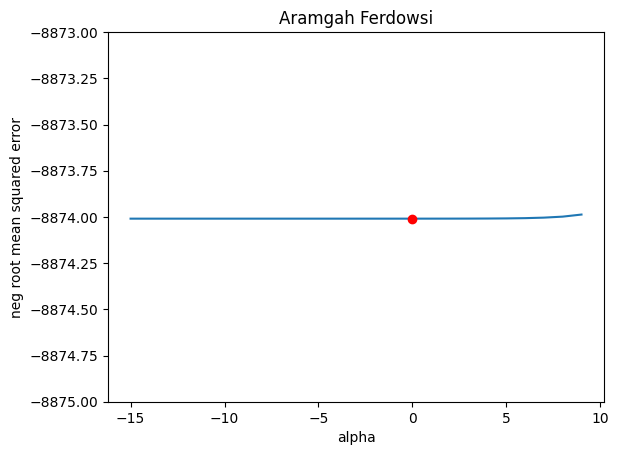

In [ ]:
param_ls = {'alpha': [2**_ for _ in range(-15,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')
gs_ls.fit(trainX_ara, trainY_ara)

plt.plot(range(-15,10), gs_ls.cv_results_['mean_test_score'])
plt.plot(0, gs_ls.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')
plt.ylim(-8875, -8873)

plt.show()


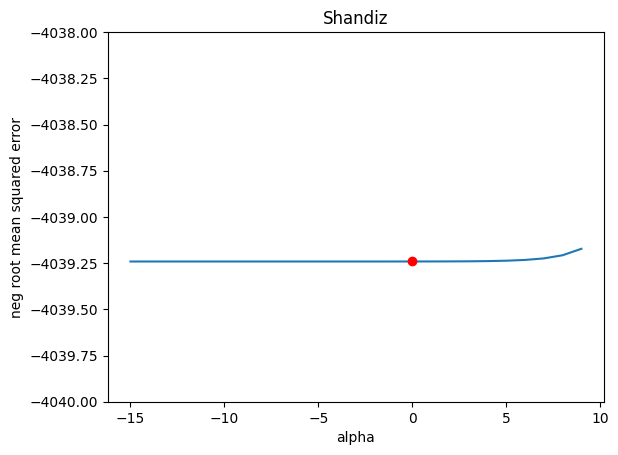

In [ ]:
param_ls = {'alpha': [2**_ for _ in range(-15,10)]}
gs_ls = GridSearchCV(lar, param_ls, cv=5, scoring='neg_root_mean_squared_error')
gs_ls.fit(trainX_sha, trainY_sha)

plt.plot(range(-15,10), gs_ls.cv_results_['mean_test_score'])
plt.plot(0, gs_ls.cv_results_['mean_test_score'][17] , 'ro')

plt.xlabel('alpha')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')
plt.ylim(-4040, -4038)

plt.show()


In [ ]:
lar_jim = Lasso()
lar_abb = Lasso()
lar_sim = Lasso()
lar_kal = Lasso()
lar_wes = Lasso()
lar_ara = Lasso()
lar_sha = Lasso()


In [ ]:
lar_jim.fit(trainX_jim, trainY_jim)
lar_abb.fit(trainX_abb, trainY_abb)
lar_sim.fit(trainX_sim, trainY_sim)
lar_kal.fit(trainX_kal, trainY_kal)
lar_wes.fit(trainX_wes, trainY_wes)
lar_ara.fit(trainX_ara, trainY_ara)
lar_sha.fit(trainX_sha, trainY_sha)


Lasso()

In [ ]:
lar_jim_val = lar_jim.predict(trainX_jim)
lar_jim_prd = lar_jim.predict(testX_jim)

lar_abb_val = lar_abb.predict(trainX_abb)
lar_abb_prd = lar_abb.predict(testX_abb)

lar_sim_val = lar_sim.predict(trainX_sim)
lar_sim_prd = lar_sim.predict(testX_sim)

lar_kal_val = lar_kal.predict(trainX_kal)
lar_kal_prd = lar_kal.predict(testX_kal)

lar_wes_val = lar_wes.predict(trainX_wes)
lar_wes_prd = lar_wes.predict(testX_wes)

lar_ara_val = lar_ara.predict(trainX_ara)
lar_ara_prd = lar_ara.predict(testX_ara)

lar_sha_val = lar_sha.predict(trainX_sha)
lar_sha_prd = lar_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, lar_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, lar_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, lar_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, lar_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, lar_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, lar_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, lar_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, lar_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, lar_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, lar_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, lar_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, lar_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, lar_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, lar_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, lar_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, lar_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, lar_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, lar_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, lar_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, lar_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, lar_sha_val), 3))


Jim	 712.018 	 1339.875 	 0.738
Abb	 6350.47 	 12096.834 	 23.795
Sim	 1349.885 	 1917.276 	 6.356
Kal	 14680.003 	 19395.846 	 0.119
Wes	 6946.864 	 12401.369 	 0.117
Ara	 6273.637 	 9090.945 	 0.06
Sha	 2848.745 	 3980.81 	 0.126


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, lar_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, lar_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, lar_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, lar_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, lar_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, lar_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, lar_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, lar_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, lar_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, lar_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, lar_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, lar_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, lar_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, lar_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, lar_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, lar_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, lar_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, lar_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, lar_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, lar_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, lar_sha_prd), 3))


Jim	 988.246 	 1537.285 	 0.079
Abb	 10792.978 	 20125.102 	 0.054
Sim	 1453.165 	 1945.234 	 0.058
Kal	 12402.242 	 15613.425 	 0.159
Wes	 12705.852 	 22109.799 	 0.06
Ara	 8515.967 	 11229.771 	 0.09
Sha	 3245.766 	 4354.758 	 0.096


## DTR (Decision Tree)

In [ ]:
dtr = DecisionTreeRegressor()
param_dt = {'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
         'splitter': ['random', 'best'],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [1]}

gs_dt = GridSearchCV(dtr, param_dt, cv = 5, scoring = "neg_root_mean_squared_error")


In [ ]:
%time gs_dt.fit(trainX_jim, trainY_jim)
print('Jim', gs_dt.best_params_)
print(gs_dt.best_score_,'\n')

%time gs_dt.fit(trainX_abb, trainY_abb)
print('Abb', gs_dt.best_params_)
print(gs_dt.best_score_,'\n')

%time gs_dt.fit(trainX_sim, trainY_sim)
print('Sim', gs_dt.best_params_)
print(gs_dt.best_score_,'\n')

%time gs_dt.fit(trainX_kal, trainY_kal)
print('Kal', gs_dt.best_params_)
print(gs_dt.best_score_,'\n')

%time gs_dt.fit(trainX_wes, trainY_wes)
print('Wes', gs_dt.best_params_)
print(gs_dt.best_score_,'\n')

%time gs_dt.fit(trainX_ara, trainY_ara)
print('Ara', gs_dt.best_params_)
print(gs_dt.best_score_,'\n')

%time gs_dt.fit(trainX_sha, trainY_sha)
print('Sha', gs_dt.best_params_)
print(gs_dt.best_score_,'\n')


CPU times: user 22min 5s, sys: 957 ms, total: 22min 6s
Wall time: 22min 19s
Jim {'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
-2148.701616460801 

CPU times: user 1h 2min 2s, sys: 2.72 s, total: 1h 2min 5s
Wall time: 1h 2min 38s
Abb {'criterion': 'poisson', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
-15679.44849195538 

CPU times: user 1h 12min 16s, sys: 2.88 s, total: 1h 12min 19s
Wall time: 1h 12min 54s
Sim {'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
-2084.049953823106 

CPU times: user 6min, sys: 257 ms, total: 6min
Wall time: 6min 3s
Kal {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
-22545.94858825491 

CPU times: user 33min 12s, sys: 1.37 s, total: 33min 14s
Wall time: 33min 29s
Wes {'criterion': 'absolute_error', 'max_depth': 6, 'mi

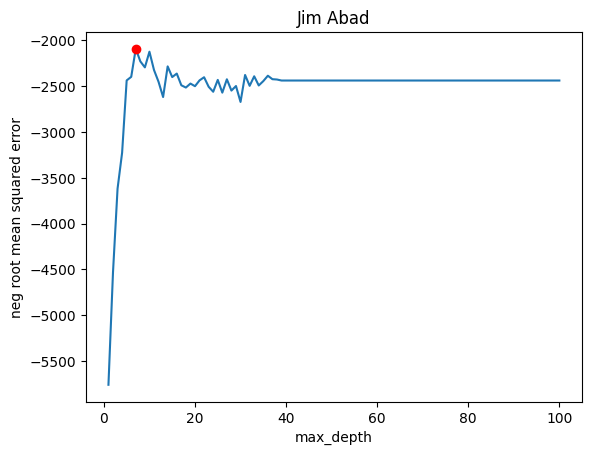

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['random'],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [1],
         'random_state': [988]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_jim, trainY_jim)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(7, gs_dt.cv_results_['mean_test_score'][6] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


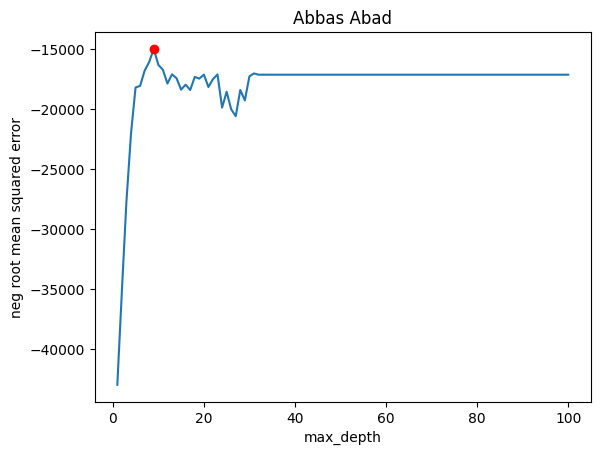

In [ ]:
param_dt = {'criterion': ["poisson"],
         'splitter': ['random'],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [1],
         'random_state': [95]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_abb, trainY_abb)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(9, gs_dt.cv_results_['mean_test_score'][8] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


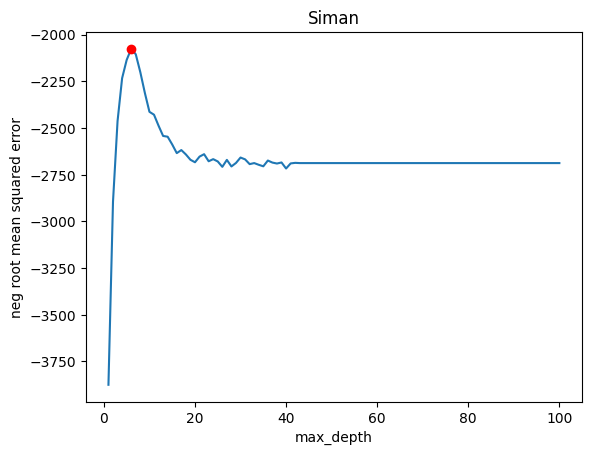

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [1],
         'random_state': [2]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sim, trainY_sim)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(6, gs_dt.cv_results_['mean_test_score'][5] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


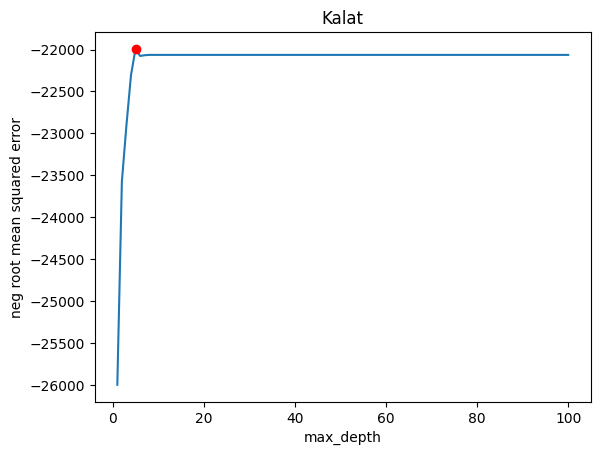

In [ ]:
param_dt = {'criterion': ["squared_error"],
         'splitter': ['best'],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [45],
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_kal, trainY_kal)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(5, gs_dt.cv_results_['mean_test_score'][4] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


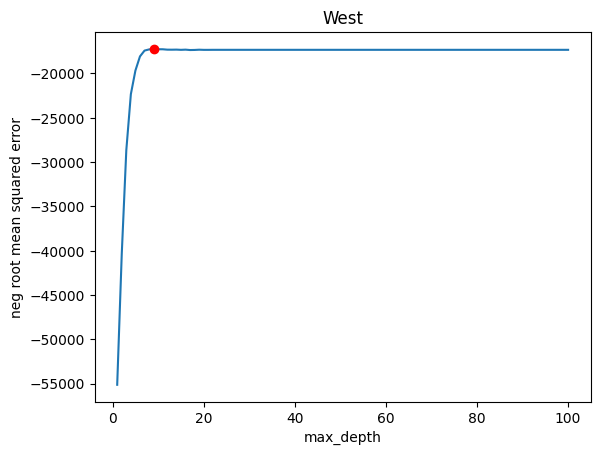

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [7],
         'random_state': [4]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_wes, trainY_wes)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(9, gs_dt.cv_results_['mean_test_score'][8] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


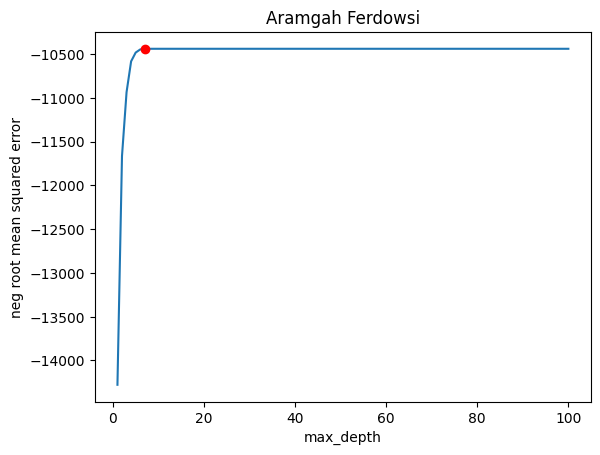

In [ ]:
param_dt = {'criterion': ["poisson"],
         'splitter': ['best'],
         'max_depth': range(1, 101),
         'min_samples_split': [49],
         'min_samples_leaf': [17],
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_ara, trainY_ara)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(7, gs_dt.cv_results_['mean_test_score'][6] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


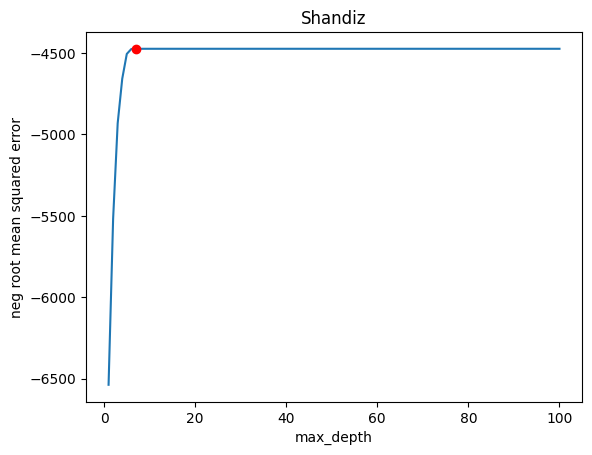

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [33],
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sha, trainY_sha)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(7, gs_dt.cv_results_['mean_test_score'][6] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


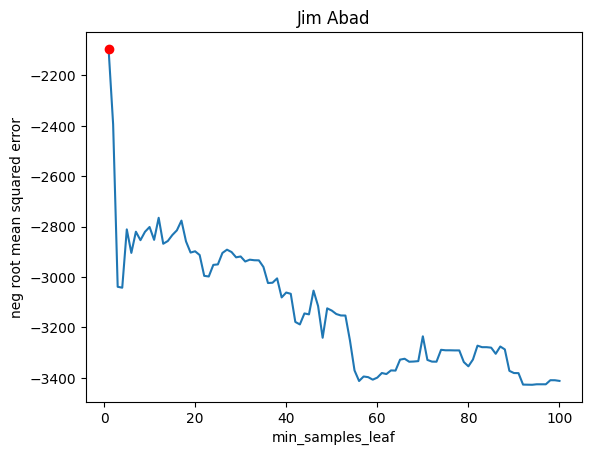

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['random'],
         'max_depth': [7],
         'min_samples_split': [2],
         'min_samples_leaf': range(1, 101),
         'random_state': [988]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_jim, trainY_jim)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(1, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


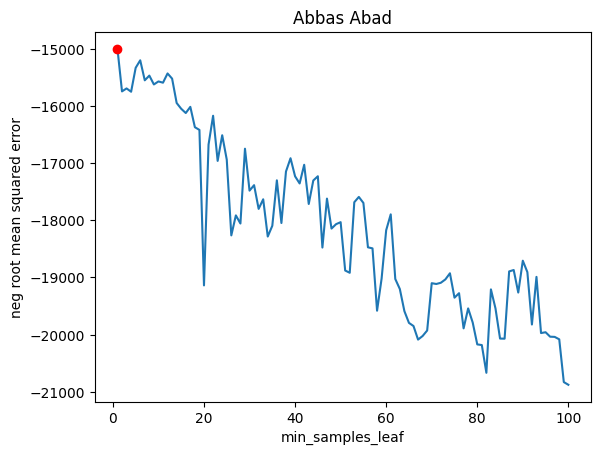

In [ ]:
param_dt = {'criterion': ["poisson"],
         'splitter': ['random'],
         'max_depth': [9],
         'min_samples_split': [2],
         'min_samples_leaf': range(1, 101),
         'random_state': [95]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_abb, trainY_abb)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(1, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


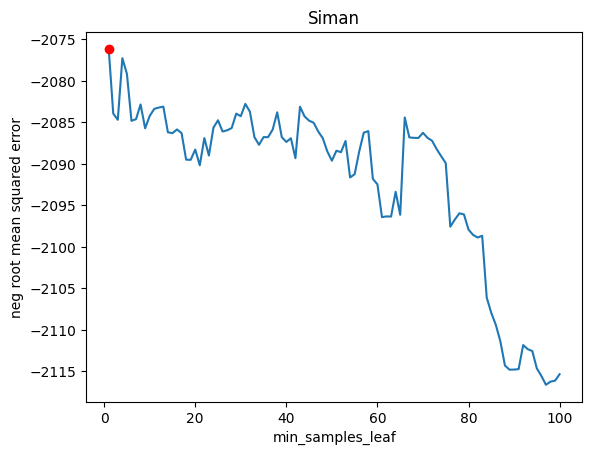

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': [6],
         'min_samples_split': [2],
         'min_samples_leaf': range(1, 101),
         'random_state': [2]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sim, trainY_sim)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(1, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


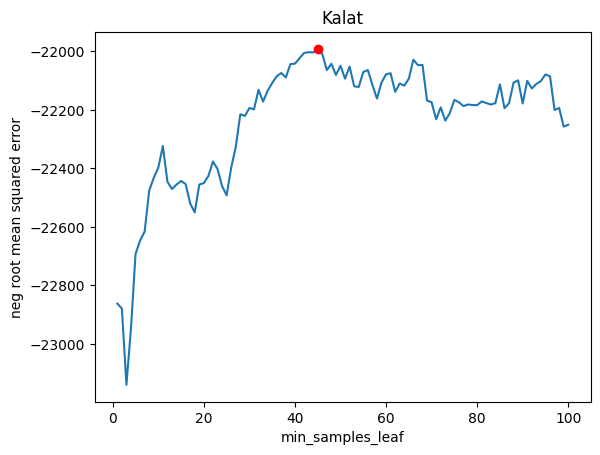

In [ ]:
param_dt = {'criterion': ["squared_error"],
         'splitter': ['best'],
         'max_depth': [5],
         'min_samples_split': [2],
         'min_samples_leaf': range(1, 101),
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_kal, trainY_kal)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(45, gs_dt.cv_results_['mean_test_score'][44] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


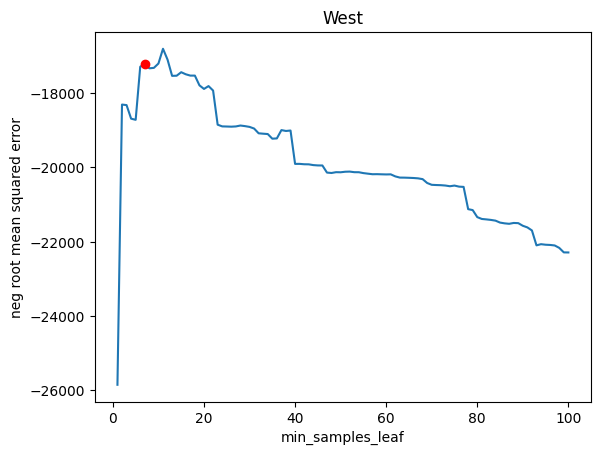

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': [9],
         'min_samples_split': [2],
         'min_samples_leaf': range(1, 101),
         'random_state': [4]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_wes, trainY_wes)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(7, gs_dt.cv_results_['mean_test_score'][6] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


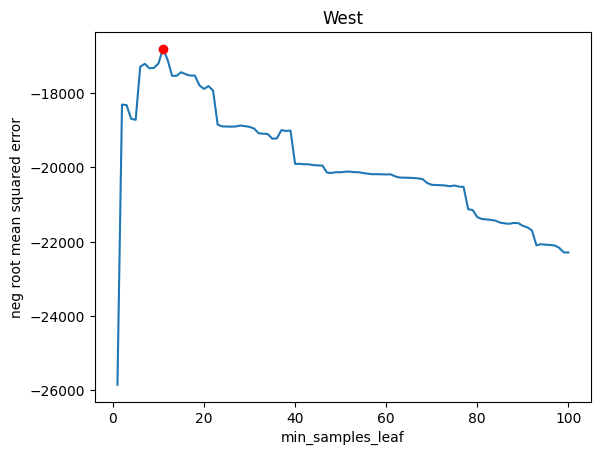

In [ ]:
plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(11, gs_dt.cv_results_['mean_test_score'][10] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()

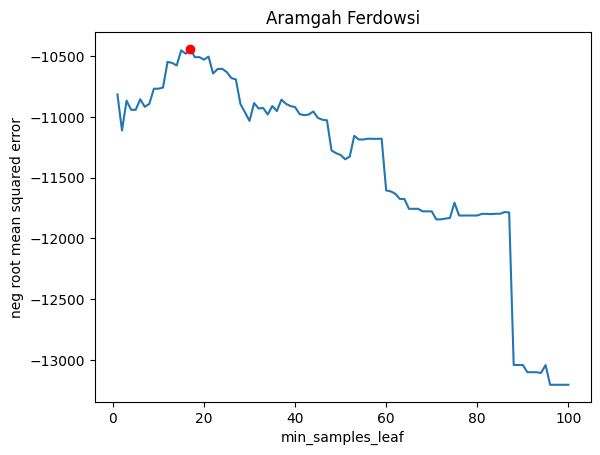

In [ ]:
param_dt = {'criterion': ["poisson"],
         'splitter': ['best'],
         'max_depth': [7],
         'min_samples_split': [49],
         'min_samples_leaf': range(1, 101),
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_ara, trainY_ara)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(17, gs_dt.cv_results_['mean_test_score'][16] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


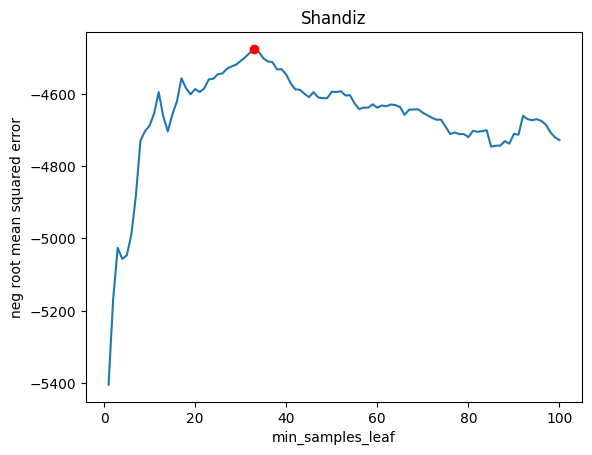

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': [7],
         'min_samples_split': [2],
         'min_samples_leaf': range(1, 101),
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sha, trainY_sha)

plt.plot(range(1, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(33, gs_dt.cv_results_['mean_test_score'][32] , 'ro')

plt.xlabel('min_samples_leaf')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


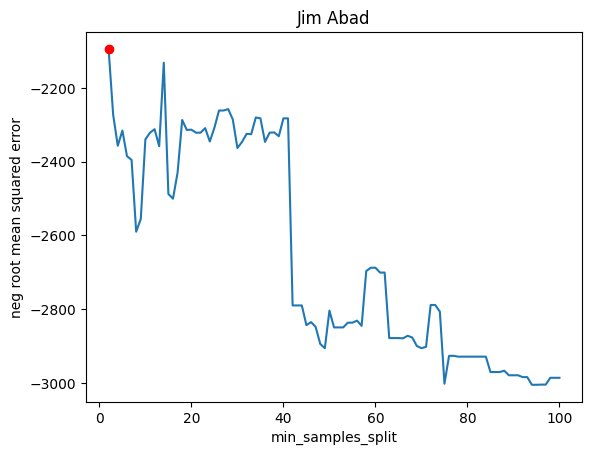

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['random'],
         'max_depth': [7],
         'min_samples_split': range(2, 101),
         'min_samples_leaf': [1],
         'random_state': [988]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_jim, trainY_jim)

plt.plot(range(2, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(2, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_split')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


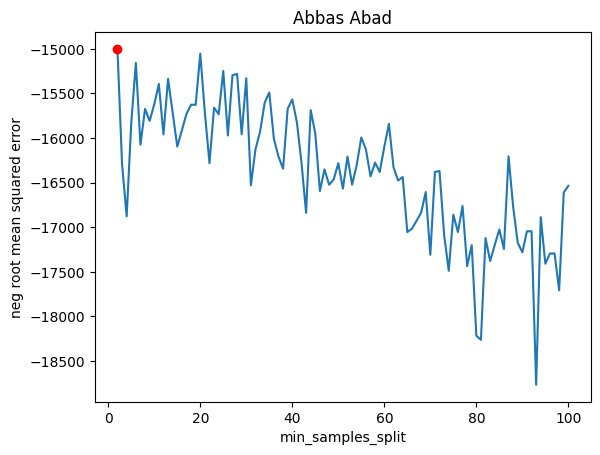

In [ ]:
param_dt = {'criterion': ["poisson"],
         'splitter': ['random'],
         'max_depth': [9],
         'min_samples_split': range(2, 101),
         'min_samples_leaf': [1],
         'random_state': [95]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_abb, trainY_abb)

plt.plot(range(2, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(2, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_split')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


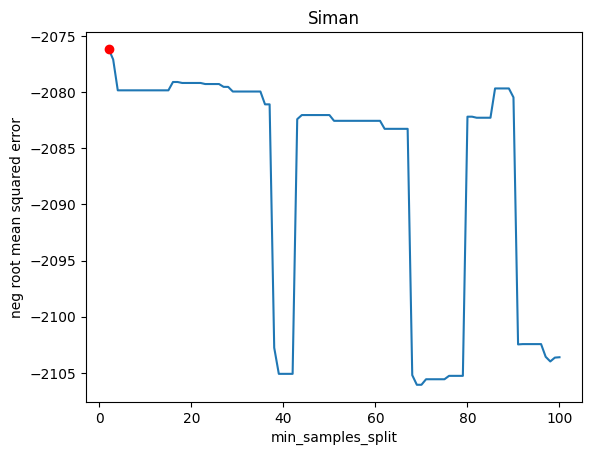

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': [6],
         'min_samples_split': range(2, 101),
         'min_samples_leaf': [1],
         'random_state': [2]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sim, trainY_sim)

plt.plot(range(2, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(2, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_split')
plt.ylabel('neg root mean squared error')
plt.title('Siman')

plt.show()


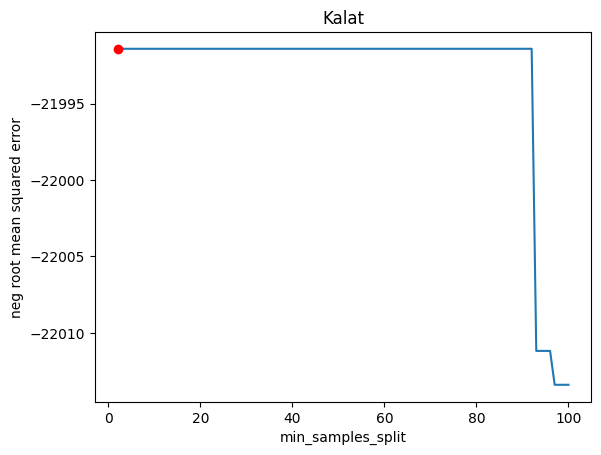

In [ ]:
param_dt = {'criterion': ["squared_error"],
         'splitter': ['best'],
         'max_depth': [5],
         'min_samples_split': range(2, 101),
         'min_samples_leaf': [45],
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_kal, trainY_kal)

plt.plot(range(2, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(2, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_split')
plt.ylabel('neg root mean squared error')
plt.title('Kalat')

plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


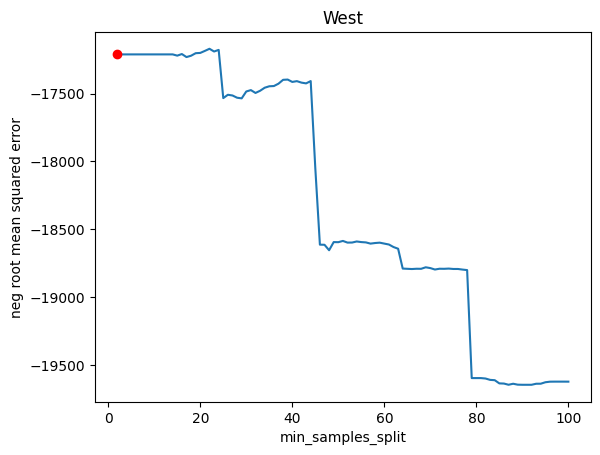

In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': [9],
         'min_samples_split': range(2, 101),
         'min_samples_leaf': [7],
         'random_state': [4]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_wes, trainY_wes)

plt.plot(range(2, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(2, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_split')
plt.ylabel('neg root mean squared error')
plt.title('West')

plt.show()


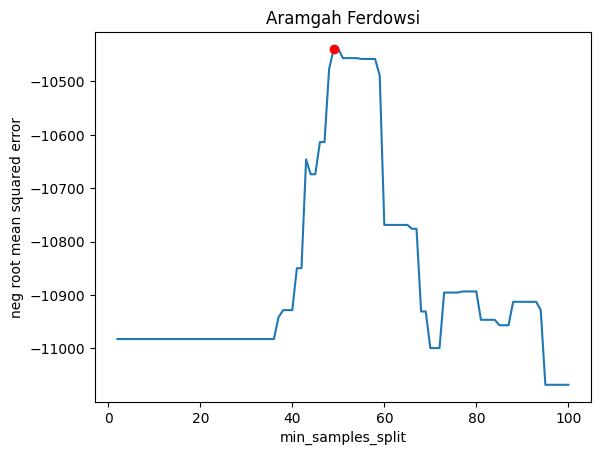

In [ ]:
param_dt = {'criterion': ["poisson"],
         'splitter': ['best'],
         'max_depth': [7],
         'min_samples_split': range(2, 101),
         'min_samples_leaf': [17],
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_ara, trainY_ara)

plt.plot(range(2, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(49, gs_dt.cv_results_['mean_test_score'][47] , 'ro')

plt.xlabel('min_samples_split')
plt.ylabel('neg root mean squared error')
plt.title('Aramgah Ferdowsi')

plt.show()


In [ ]:
param_dt = {'criterion': ["absolute_error"],
         'splitter': ['best'],
         'max_depth': [7],
         'min_samples_split': range(2, 101),
         'min_samples_leaf': [33],
         'random_state': [1]}
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sha, trainY_sha)

plt.plot(range(2, 101), gs_dt.cv_results_['mean_test_score'])
plt.plot(2, gs_dt.cv_results_['mean_test_score'][0] , 'ro')

plt.xlabel('min_samples_split')
plt.ylabel('neg root mean squared error')
plt.title('Shandiz')

plt.show()


In [ ]:
param_dt = {'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
         'splitter': ['random', 'best']}

dtr = DecisionTreeRegressor(max_depth=7, min_samples_split=2, min_samples_leaf=1, random_state=988)
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_jim, trainY_jim)
print('jim squ', gs_dt.cv_results_['mean_test_score'][0], '\tmse', gs_dt.cv_results_['mean_test_score'][2], '\tabs', gs_dt.cv_results_['mean_test_score'][4], '\tpoi', gs_dt.cv_results_['mean_test_score'][6])
print('jim ran', gs_dt.cv_results_['mean_test_score'][4], '\tbes', gs_dt.cv_results_['mean_test_score'][5], '\n')

dtr = DecisionTreeRegressor(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=95)
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_abb, trainY_abb)
print('abb squ', gs_dt.cv_results_['mean_test_score'][0], '\tmse', gs_dt.cv_results_['mean_test_score'][2], '\tabs', gs_dt.cv_results_['mean_test_score'][4], '\tpoi', gs_dt.cv_results_['mean_test_score'][6])
print('abb ran', gs_dt.cv_results_['mean_test_score'][6], '\tbes', gs_dt.cv_results_['mean_test_score'][7], '\n')

dtr = DecisionTreeRegressor(max_depth=6, min_samples_split=2, min_samples_leaf=1, random_state=2)
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sim, trainY_sim)
print('sim squ', gs_dt.cv_results_['mean_test_score'][1], '\tmse', gs_dt.cv_results_['mean_test_score'][3], '\tabs', gs_dt.cv_results_['mean_test_score'][5], '\tpoi', gs_dt.cv_results_['mean_test_score'][7])
print('sim ran', gs_dt.cv_results_['mean_test_score'][4], '\tbes', gs_dt.cv_results_['mean_test_score'][5], '\n')

dtr = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=45, random_state=1)
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_kal, trainY_kal)
print('kal squ', gs_dt.cv_results_['mean_test_score'][1], '\tmse', gs_dt.cv_results_['mean_test_score'][3], '\tabs', gs_dt.cv_results_['mean_test_score'][5], '\tpoi', gs_dt.cv_results_['mean_test_score'][7])
print('kal ran', gs_dt.cv_results_['mean_test_score'][0], '\tbes', gs_dt.cv_results_['mean_test_score'][1], '\n')

dtr = DecisionTreeRegressor(max_depth=9, min_samples_split=2, min_samples_leaf=7, random_state=4)
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_wes, trainY_wes)
print('wes squ', gs_dt.cv_results_['mean_test_score'][1], '\tmse', gs_dt.cv_results_['mean_test_score'][3], '\tabs', gs_dt.cv_results_['mean_test_score'][5], '\tpoi', gs_dt.cv_results_['mean_test_score'][7])
print('wes ran', gs_dt.cv_results_['mean_test_score'][4], '\tbes', gs_dt.cv_results_['mean_test_score'][5], '\n')

dtr = DecisionTreeRegressor(max_depth=7, min_samples_split=49, min_samples_leaf=17, random_state=1)
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_ara, trainY_ara)
print('ara squ', gs_dt.cv_results_['mean_test_score'][1], '\tmse', gs_dt.cv_results_['mean_test_score'][3], '\tabs', gs_dt.cv_results_['mean_test_score'][5], '\tpoi', gs_dt.cv_results_['mean_test_score'][7])
print('ara ran', gs_dt.cv_results_['mean_test_score'][6], '\tbes', gs_dt.cv_results_['mean_test_score'][7], '\n')

dtr = DecisionTreeRegressor(max_depth=7, min_samples_split=2, min_samples_leaf=33, random_state=1)
gs_dt = GridSearchCV(dtr, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(trainX_sha, trainY_sha)
print('sha squ', gs_dt.cv_results_['mean_test_score'][1], '\tmse', gs_dt.cv_results_['mean_test_score'][3], '\tabs', gs_dt.cv_results_['mean_test_score'][5], '\tpoi', gs_dt.cv_results_['mean_test_score'][7])
print('sha ran', gs_dt.cv_results_['mean_test_score'][4], '\tbes', gs_dt.cv_results_['mean_test_score'][5], '\n')



jim squ -2617.3095128398877 	mse -2617.3095128398877 	abs -2094.4256488029596 	poi -2531.3900096818675
jim ran -2094.4256488029596 	bes -2211.4142355427457 

abb squ -16336.817663248314 	mse -16336.222944403466 	abs -15953.42978129744 	poi -15000.602416626425
abb ran -15000.602416626425 	bes -17261.91061342954 

sim squ -2107.2809636817497 	mse -2107.2809636817497 	abs -2076.1287021528233 	poi -2170.9905916544412
sim ran -2369.8481930322887 	bes -2076.1287021528233 

kal squ -21991.410244099075 	mse -21991.410244099075 	abs -22117.12017386986 	poi -22183.304764943598
kal ran -23318.324974873296 	bes -21991.410244099075 

wes squ -18157.958722627118 	mse -18157.957100784854 	abs -17210.90172270913 	poi -18775.588052705913
wes ran -19624.874049428552 	bes -17210.90172270913 

ara squ -10354.927951054273 	mse -10354.927951054273 	abs -10793.721085967647 	poi -10439.23692745397
ara ran -10829.284303709728 	bes -10439.23692745397 

sha squ -4501.0255885088145 	mse -4501.0255885088145 	abs -

In [ ]:
dtr_jim = DecisionTreeRegressor(max_depth=7, min_samples_split=2, min_samples_leaf=1, random_state=988, criterion='absolute_error', splitter='random')
dtr_abb = DecisionTreeRegressor(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=95, criterion='poisson', splitter='random')
dtr_sim = DecisionTreeRegressor(max_depth=6, min_samples_split=2, min_samples_leaf=1, random_state=2, criterion='absolute_error', splitter='best')
dtr_kal = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=45, random_state=1, criterion='squared_error', splitter='best')
dtr_wes = DecisionTreeRegressor(max_depth=9, min_samples_split=2, min_samples_leaf=7, random_state=4, criterion='absolute_error', splitter='best')
dtr_ara = DecisionTreeRegressor(max_depth=7, min_samples_split=49, min_samples_leaf=17, random_state=1, criterion='poisson', splitter='best')
dtr_sha = DecisionTreeRegressor(max_depth=7, min_samples_split=2, min_samples_leaf=33, random_state=1, criterion='absolute_error', splitter='best')


In [ ]:
dtr_jim.fit(trainX_jim, trainY_jim)
dtr_abb.fit(trainX_abb, trainY_abb)
dtr_sim.fit(trainX_sim, trainY_sim)
dtr_kal.fit(trainX_kal, trainY_kal)
dtr_wes.fit(trainX_wes, trainY_wes)
dtr_ara.fit(trainX_ara, trainY_ara)
dtr_sha.fit(trainX_sha, trainY_sha)


DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=33, random_state=1)

In [ ]:
dtr_jim_val = dtr_jim.predict(trainX_jim)
dtr_jim_prd = dtr_jim.predict(testX_jim)

dtr_abb_val = dtr_abb.predict(trainX_abb)
dtr_abb_prd = dtr_abb.predict(testX_abb)

dtr_sim_val = dtr_sim.predict(trainX_sim)
dtr_sim_prd = dtr_sim.predict(testX_sim)

dtr_kal_val = dtr_kal.predict(trainX_kal)
dtr_kal_prd = dtr_kal.predict(testX_kal)

dtr_wes_val = dtr_wes.predict(trainX_wes)
dtr_wes_prd = dtr_wes.predict(testX_wes)

dtr_ara_val = dtr_ara.predict(trainX_ara)
dtr_ara_prd = dtr_ara.predict(testX_ara)

dtr_sha_val = dtr_sha.predict(trainX_sha)
dtr_sha_prd = dtr_sha.predict(testX_sha)


In [ ]:
print("Jim\t", round(mean_absolute_error(trainY_jim, dtr_jim_val), 3), "\t", round(mean_squared_error(trainY_jim, dtr_jim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_jim, dtr_jim_val), 3))
print("Abb\t", round(mean_absolute_error(trainY_abb, dtr_abb_val), 3), "\t", round(mean_squared_error(trainY_abb, dtr_abb_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_abb, dtr_abb_val), 3))
print("Sim\t", round(mean_absolute_error(trainY_sim, dtr_sim_val), 3), "\t", round(mean_squared_error(trainY_sim, dtr_sim_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sim, dtr_sim_val), 3))
print("Kal\t", round(mean_absolute_error(trainY_kal, dtr_kal_val), 3), "\t", round(mean_squared_error(trainY_kal, dtr_kal_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_kal, dtr_kal_val), 3))
print("Wes\t", round(mean_absolute_error(trainY_wes, dtr_wes_val), 3), "\t", round(mean_squared_error(trainY_wes, dtr_wes_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_wes, dtr_wes_val), 3))
print("Ara\t", round(mean_absolute_error(trainY_ara, dtr_ara_val), 3), "\t", round(mean_squared_error(trainY_ara, dtr_ara_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_ara, dtr_ara_val), 3))
print("Sha\t", round(mean_absolute_error(trainY_sha, dtr_sha_val), 3), "\t", round(mean_squared_error(trainY_sha, dtr_sha_val)**(1/2), 3), "\t", round(mean_absolute_percentage_error(trainY_sha, dtr_sha_val), 3))


Jim	 843.453 	 1334.811 	 0.276
Abb	 5969.897 	 10098.57 	 9.174
Sim	 1327.95 	 1891.892 	 3.65
Kal	 15022.415 	 19546.546 	 0.123
Wes	 5075.107 	 11000.348 	 0.081
Ara	 5858.178 	 8722.066 	 0.056
Sha	 2667.112 	 3926.401 	 0.148


In [ ]:
print("Jim\t", round(mean_absolute_error(testY_jim, dtr_jim_prd), 3), "\t", round(mean_squared_error(testY_jim, dtr_jim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_jim, dtr_jim_prd), 3))
print("Abb\t", round(mean_absolute_error(testY_abb, dtr_abb_prd), 3), "\t", round(mean_squared_error(testY_abb, dtr_abb_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_abb, dtr_abb_prd), 3))
print("Sim\t", round(mean_absolute_error(testY_sim, dtr_sim_prd), 3), "\t", round(mean_squared_error(testY_sim, dtr_sim_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sim, dtr_sim_prd), 3))
print("Kal\t", round(mean_absolute_error(testY_kal, dtr_kal_prd), 3), "\t", round(mean_squared_error(testY_kal, dtr_kal_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_kal, dtr_kal_prd), 3))
print("Wes\t", round(mean_absolute_error(testY_wes, dtr_wes_prd), 3), "\t", round(mean_squared_error(testY_wes, dtr_wes_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_wes, dtr_wes_prd), 3))
print("Ara\t", round(mean_absolute_error(testY_ara, dtr_ara_prd), 3), "\t", round(mean_squared_error(testY_ara, dtr_ara_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_ara, dtr_ara_prd), 3))
print("Sha\t", round(mean_absolute_error(testY_sha, dtr_sha_prd), 3), "\t", round(mean_squared_error(testY_sha, dtr_sha_prd)**(1/2), 3), "\t", round(mean_absolute_percentage_error(testY_sha, dtr_sha_prd), 3))


Jim	 1530.905 	 2106.685 	 0.127
Abb	 13839.635 	 22347.736 	 0.064
Sim	 1719.486 	 2370.217 	 0.068
Kal	 16397.828 	 19958.075 	 0.23
Wes	 14874.103 	 25297.32 	 0.069
Ara	 9932.18 	 12855.269 	 0.107
Sha	 3570.179 	 4699.835 	 0.106


## RFR (Random Forest)

In [ ]:
rfr = RandomForestRegressor()
param_rf = {'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
         'max_depth': range(1, 11),
         'min_samples_split': [2],
         'min_samples_leaf': [1],
         'n_estimators': [2**_ for _ in range(1,8)],
         'random_state': [1]}

gs_rf = GridSearchCV(rfr, param_rf, cv = 2, scoring = "neg_root_mean_squared_error", verbose=1)


In [ ]:
%time gs_rf.fit(trainX_jim, trainY_jim)
print('Jim', gs_rf.best_params_)
print(gs_rf.best_score_,'\n')


Fitting 2 folds for each of 280 candidates, totalling 560 fits
CPU times: user 27min 5s, sys: 958 ms, total: 27min 6s
Wall time: 27min 16s
Jim {'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'random_state': 1}
-4178.579772037093 

Fitting 2 folds for each of 280 candidates, totalling 560 fits


In [ ]:
%time gs_rf.fit(trainX_abb, trainY_abb)
print('Abb', gs_rf.best_params_)
print(gs_rf.best_score_,'\n')


Fitting 2 folds for each of 280 candidates, totalling 560 fits
CPU times: user 1h 13min 23s, sys: 2.69 s, total: 1h 13min 26s
Wall time: 1h 13min 53s
Abb {'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 64, 'random_state': 1}
-14446.909291593027 



In [ ]:
%time gs_rf.fit(trainX_sim, trainY_sim)
print('Sim', gs_rf.best_params_)
print(gs_rf.best_score_,'\n')

%time gs_rf.fit(trainX_wes, trainY_wes)
print('Wes', gs_rf.best_params_)
print(gs_rf.best_score_,'\n')

%time gs_rf.fit(trainX_sha, trainY_sha)
print('Sha', gs_rf.best_params_)
print(gs_rf.best_score_,'\n')


Fitting 2 folds for each of 280 candidates, totalling 560 fits
CPU times: user 1h 35min 19s, sys: 3.68 s, total: 1h 35min 23s
Wall time: 1h 36min 4s
Sim {'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'random_state': 1}
-3731.4937604733504 

Fitting 2 folds for each of 280 candidates, totalling 560 fits
CPU times: user 40min 24s, sys: 1.41 s, total: 40min 26s
Wall time: 40min 37s
Wes {'criterion': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 8, 'random_state': 1}
-50824.60747054619 

Fitting 2 folds for each of 280 candidates, totalling 560 fits
CPU times: user 8min 19s, sys: 440 ms, total: 8min 19s
Wall time: 8min 22s
Sha {'criterion': 'absolute_error', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 16, 'random_state': 1}
-4904.183530805965 



In [ ]:
%time gs_rf.fit(trainX_kal, trainY_kal)
print('Kal', gs_rf.best_params_)
print(gs_rf.best_score_,'\n')

%time gs_rf.fit(trainX_ara, trainY_ara)
print('Ara', gs_rf.best_params_)
print(gs_rf.best_score_,'\n')


Fitting 2 folds for each of 280 candidates, totalling 560 fits
CPU times: user 9min 7s, sys: 489 ms, total: 9min 7s
Wall time: 9min 10s
Kal {'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 128, 'random_state': 1}
-20151.7291024561 

Fitting 2 folds for each of 280 candidates, totalling 560 fits
CPU times: user 2min 2s, sys: 232 ms, total: 2min 3s
Wall time: 2min 3s
Ara {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 128, 'random_state': 1}
-10333.933981484712 



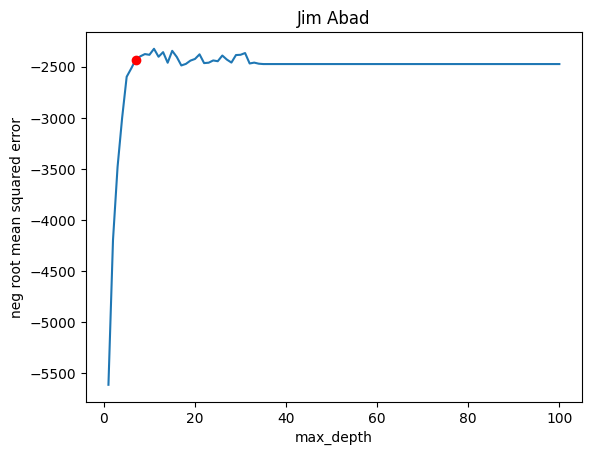

In [ ]:
param_rf = {'criterion': ["absolute_error"],
         'n_estimators': [2],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [1],
         'random_state': [1]}
gs_rf = GridSearchCV(rfr, param_rf, cv=5, scoring='neg_root_mean_squared_error')
gs_rf.fit(trainX_jim, trainY_jim)

plt.plot(range(1, 101), gs_rf.cv_results_['mean_test_score'])
plt.plot(7, gs_rf.cv_results_['mean_test_score'][6] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Jim Abad')

plt.show()


In [ ]:
param_rf = {'criterion': ["absolute_error"],
         'n_estimators': [64],
         'max_depth': range(1, 101),
         'min_samples_split': [2],
         'min_samples_leaf': [1],
         'random_state': [1]}
gs_rf = GridSearchCV(rfr, param_rf, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
gs_rf.fit(trainX_abb, trainY_abb)

plt.plot(range(1, 101), gs_rf.cv_results_['mean_test_score'])
plt.plot(8, gs_rf.cv_results_['mean_test_score'][7] , 'ro')

plt.xlabel('max_depth')
plt.ylabel('neg root mean squared error')
plt.title('Abbas Abad')

plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=absolute_error, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=64, random_state=1;, score=-47093.619 total time= 1.4min
[CV 2/5] END criterion=absolute_error, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=64, random_state=1;, score=-34433.568 total time=  59.6s
[CV 3/5] END criterion=absolute_error, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=64, random_state=1;, score=-37504.921 total time=  58.7s
[CV 4/5] END criterion=absolute_error, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=64, random_state=1;, score=-22322.924 total time=  55.2s
[CV 5/5] END criterion=absolute_error, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=64, random_state=1;, score=-63680.274 total time=  57.4s
[CV 1/5] END criterion=absolute_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=64, random_state

KeyboardInterrupt: 

## MLP

In [ ]:
step = 24

trainX_jim, trainY_jim = convert_to_dataset(train_jim,step)
testX_jim, testY_jim = convert_to_dataset(test_jim,step)
trainX_jim = np.reshape(trainX_jim, (trainX_jim.shape[0], trainX_jim.shape[1], 1))
testX_jim = np.reshape(testX_jim, (testX_jim.shape[0], testX_jim.shape[1], 1))

trainX_abb, trainY_abb = convert_to_dataset(train_abb,step)
testX_abb, testY_abb = convert_to_dataset(test_abb,step)
trainX_abb = np.reshape(trainX_abb, (trainX_abb.shape[0], trainX_abb.shape[1], 1))
testX_abb = np.reshape(testX_abb, (testX_abb.shape[0], testX_abb.shape[1], 1))

trainX_sim, trainY_sim = convert_to_dataset(train_sim,step)
testX_sim, testY_sim = convert_to_dataset(test_sim,step)
trainX_sim = np.reshape(trainX_sim, (trainX_sim.shape[0], trainX_sim.shape[1], 1))
testX_sim = np.reshape(testX_sim, (testX_sim.shape[0], testX_sim.shape[1], 1))

trainX_kal, trainY_kal = convert_to_dataset(train_kal,step)
testX_kal, testY_kal = convert_to_dataset(test_kal,step)
trainX_kal = np.reshape(trainX_kal, (trainX_kal.shape[0], trainX_kal.shape[1], 1))
testX_kal = np.reshape(testX_kal, (testX_kal.shape[0], testX_kal.shape[1], 1))

trainX_wes, trainY_wes = convert_to_dataset(train_wes,step)
testX_wes, testY_wes = convert_to_dataset(test_wes,step)
trainX_wes = np.reshape(trainX_wes, (trainX_wes.shape[0], trainX_wes.shape[1], 1))
testX_wes = np.reshape(testX_wes, (testX_wes.shape[0], testX_wes.shape[1], 1))

trainX_ara, trainY_ara = convert_to_dataset(train_ara,step)
testX_ara, testY_ara = convert_to_dataset(test_ara,step)
trainX_ara = np.reshape(trainX_ara, (trainX_ara.shape[0], trainX_ara.shape[1], 1))
testX_ara = np.reshape(testX_ara, (testX_ara.shape[0], testX_ara.shape[1], 1))

trainX_sha, trainY_sha = convert_to_dataset(train_sha,step)
testX_sha, testY_sha = convert_to_dataset(test_sha,step)
trainX_sha = np.reshape(trainX_sha, (trainX_sha.shape[0], trainX_sha.shape[1], 1))
testX_sha = np.reshape(testX_sha, (testX_sha.shape[0], testX_sha.shape[1], 1))


In [ ]:
model = Sequential()
#model.add(Dense(units=35536, activation="tanh", name='Dense16', input_shape=(None,1)))
#model.add(Dense(units=32768, activation="tanh", name='Dense15', input_shape=(None,1)))
#model.add(Dense(units=16384, activation="tanh", name='Dense14', input_shape=(None,1)))
#model.add(Dense(units=8192, activation="tanh", name='Dense13', input_shape=(None,1)))
#model.add(Dense(units=4096, activation="tanh", name='Dense12', input_shape=(None,1)))
#model.add(Dense(units=2048, activation="tanh", name='Dense11', input_shape=(None,1)))
#model.add(Dense(units=1024, activation="tanh", name='Dense10'))# input_shape=(None,1)))
#model.add(Dense(units=512, activation="tanh", name='Dense9'))#, return_sequences=True))
#model.add(Dense(units=256, activation="tanh", name='Dense8'))#, return_sequences=True))
#model.add(Dense(units=128, activation="tanh", name='Dense7'))#, return_sequences=True))
#model.add(Dense(units=64, activation="tanh", name='Dense6'))
#model.add(Dense(units=32, activation="tanh", name='Dense5'))#, return_sequences=True))
model.add(Dense(units=16384, activation="tanh", name='Dense4'))#, return_sequences=True))
#model.add(Dense(units=8, activation="tanh", name='Dense3'))
#model.add(Dense(units=4, activation="tanh", name='Dense2'))
#model.add(Dense(units=2, activation="tanh", name='Dense1'))
model.add(Dense(units=1, activation="linear", name='Dense'))

optimizer = optimizers.RMSprop(learning_rate=1.0)

model.compile(loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'], optimizer=optimizer)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense4 (Dense)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#history = model.fit(trainX_jim, trainY_jim, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
#print(model.evaluate(testX_jim, testY_jim, verbose=0))

#history = model.fit(trainX_abb, trainY_abb, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
#print(model.evaluate(testX_abb, testY_abb, verbose=0))

#history = model.fit(trainX_sim, trainY_sim, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
#print(model.evaluate(testX_sim, testY_sim, verbose=0))

#history = model.fit(trainX_kal, trainY_kal, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
#print(model.evaluate(testX_kal, testY_kal, verbose=0))

history = model.fit(trainX_wes, trainY_wes, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
print(model.evaluate(testX_wes, testY_wes, verbose=0))

#history = model.fit(trainX_ara, trainY_ara, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
#print(model.evaluate(testX_ara, testY_ara, verbose=0))

#history = model.fit(trainX_sha, trainY_sha, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
#print(model.evaluate(testX_sha, testY_sha, verbose=0))


[5925709312.0, 64377.8515625, 26.00162124633789]


In [ ]:
print(model.evaluate(trainX_jim, trainY_jim))
model.evaluate(testX_jim, testY_jim)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 69190224.0000 - mean_absolute_error: 6630.5142 - mean_absolute_percentage_error: 9166.4775
[48078300.0, 4940.90625, 4818.7763671875]
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13908780.0000 - mean_absolute_error: 2733.3372 - mean_absolute_percentage_error: 20.4989


[26676032.0, 4125.74853515625, 42.18104553222656]

In [ ]:
19879180.0000  ** (1/2)

## RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=35536, activation="tanh", name='RNN16', input_shape=(None,1), return_sequences=True))
model.add(SimpleRNN(units=32768, activation="tanh", name='RNN15', return_sequences=True))
model.add(SimpleRNN(units=16384, activation="tanh", name='RNN14', return_sequences=True))
model.add(SimpleRNN(units=8192, activation="tanh", name='RNN13', return_sequences=True))
model.add(SimpleRNN(units=4096, activation="tanh", name='RNN12', return_sequences=True))
model.add(SimpleRNN(units=2048, activation="tanh", name='RNN11', return_sequences=True))
model.add(SimpleRNN(units=1024, activation="tanh", name='RNN10', return_sequences=True))
model.add(SimpleRNN(units=512, activation="tanh", name='RNN9', return_sequences=True))
model.add(SimpleRNN(units=256, activation="tanh", name='RNN8', return_sequences=True))
model.add(SimpleRNN(units=128, activation="tanh", name='RNN7', return_sequences=True))
model.add(SimpleRNN(units=64, activation="tanh", name='RNN6', return_sequences=True))
model.add(SimpleRNN(units=32, activation="tanh", name='RNN5', return_sequences=True))
model.add(SimpleRNN(units=16, activation="tanh", name='RNN4', return_sequences=True))
model.add(SimpleRNN(units=8, activation="tanh", name='RNN3', return_sequences=True))
model.add(SimpleRNN(units=4, activation="tanh", name='RNN2', return_sequences=True))
model.add(SimpleRNN(units=2, activation="tanh", name='RNN1'))
model.add(Dense(units=1, activation="linear", name='Dense'))

optimizer = optimizers.RMSprop(learning_rate=1.0)

model.compile(loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'], optimizer=optimizer)

model.summary()

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=1024, activation="tanh", name='simpleRNN1', return_sequences=True, input_shape=(24,1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=1024, activation="tanh", name='simpleRNN2', return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=1024, activation="tanh", name='simpleRNN3', return_sequences=True))
model.add(SimpleRNN(units=512, activation="tanh", name='simpleRNN4', return_sequences=True))
model.add(SimpleRNN(units=256, activation="tanh", name='simpleRNN5'))
model.add(Dense(units=1, activation="linear", name='Dense'))

optimizer = optimizers.RMSprop(learning_rate=1.0)

model.compile(loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'], optimizer=optimizer)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simpleRNN1 (SimpleRNN)               │ (None, 24, 1024)            │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 24, 1)               │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,051,649 (4.01 MB)

 Trainable params: 1,051,649 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(trainX_jim, trainY_jim, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
model.evaluate(testX_jim, testY_jim)

history = model.fit(trainX_abb, trainY_abb, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
model.evaluate(testX_abb, testY_abb)

history = model.fit(trainX_sim, trainY_sim, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
model.evaluate(testX_sim, testY_sim)

history = model.fit(trainX_kal, trainY_kal, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
model.evaluate(testX_kal, testY_kal)

history = model.fit(trainX_wes, trainY_wes, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
model.evaluate(testX_wes, testY_wes)

history = model.fit(trainX_ara, trainY_ara, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
model.evaluate(testX_ara, testY_ara)

history = model.fit(trainX_sha, trainY_sha, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_split=0.25)
model.evaluate(testX_sha, testY_sha)


Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - loss: 67651080.0000 - mean_absolute_error: 7005.1338 - mean_absolute_percentage_error: 1270.6533 - val_loss: 61579456.0000 - val_mean_absolute_error: 5130.8799 - val_mean_absolute_percentage_error: 23.5378
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 29496902.0000 - mean_absolute_error: 4069.3906 - mean_absolute_percentage_error: 3007.9141 - val_loss: 159574608.0000 - val_mean_absolute_error: 11058.8701 - val_mean_absolute_percentage_error: 57.3481
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 22766762.0000 - mean_absolute_error: 3976.5146 - mean_absolute_percentage_error: 1525.0966 - val_loss: 50536776.0000 - val_mean_absolute_error: 4148.6714 - val_mean_absolute_percentage_error: 18.4810
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 26032034.0000 - mean_absolute_error: 4194.2637 - mean_absolute_percentage_error: 4464.5264 - val_loss: 48434808.0000 - val_mean_absolute_error: 3951.3193 - 

In [ ]:
print(model.evaluate(trainX_jim, trainY_jim))
model.evaluate(testX_jim, testY_jim)

122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 61332644.0000 - mean_absolute_error: 6083.1812 - mean_absolute_percentage_error: 8776.7432
[44504484.0, 4676.52587890625, 4614.0458984375]
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 14657250.0000 - mean_absolute_error: 2809.1519 - mean_absolute_percentage_error: 20.1243


[25210472.0, 4045.649169921875, 39.89999008178711]

In [ ]:
19879180.0000  ** (1/2)

4458.607405906019

## LSTM


In [ ]:
model = Sequential()
model.add(LSTM(units=1024, activation="tanh", name='simpleRNN1', return_sequences=True, input_shape=(None,1)))
#model.add(SimpleRNN(units=512, activation="tanh", name='simpleRNN2', return_sequences=True))
#model.add(SimpleRNN(units=256, activation="tanh", name='simpleRNN3', return_sequences=True))
#model.add(SimpleRNN(units=128, activation="tanh", name='simpleRNN4', return_sequences=True))
#model.add(SimpleRNN(units=64, activation="tanh", name='simpleRNN5'))
model.add(Dense(units=1, activation="linear", name='Dense'))

optimizer = optimizers.RMSprop(learning_rate=1.0)

model.compile(loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'], optimizer=optimizer)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simpleRNN1 (LSTM)                    │ (None, None, 1024)          │       4,202,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, None, 1)             │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,203,521 (16.04 MB)

 Trainable params: 4,203,521 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(trainX_jim, trainY_jim, epochs=100, batch_size=32, verbose=1, validation_split=0.25, shuffle=False)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 45098128.0000 - mean_absolute_error: 5302.8921 - mean_absolute_percentage_error: 373.6073 - val_loss: 51453308.0000 - val_mean_absolute_error: 4224.2163 - val_mean_absolute_percentage_error: 18.8878
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 40060976.0000 - mean_absolute_error: 5405.3384 - mean_absolute_percentage_error: 3115.7168 - val_loss: 71054664.0000 - val_mean_absolute_error: 5896.0840 - val_mean_absolute_percentage_error: 27.7097
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 32266470.0000 - mean_absolute_error: 4591.4531 - mean_absolute_percentage_error: 2246.7559 - val_loss: 69572368.0000 - val_mean_absolute_error: 5777.6821 - val_mean_absolute_percentage_error: 27.0550
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 33565216.0000 - mean_absolute_error: 4667.4478 - mean_absolute_percentage_error: 1974.1033 - val_loss: 71789824.0000 - val_mean_absolute_error: 5952.5244 - val_m

In [ ]:
print(model.evaluate(trainX_jim, trainY_jim))
model.evaluate(testX_jim, testY_jim)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 43519568.0000 - mean_absolute_error: 4773.5137 - mean_absolute_percentage_error: 4965.5562
[37894260.0, 4194.79345703125, 2583.25390625]
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19477098.0000 - mean_absolute_error: 3438.9238 - mean_absolute_percentage_error: 22.3960


[25126686.0, 4168.43408203125, 36.86323547363281]

In [ ]:
19477098.0000  ** (1/2)

4413.286530466836

## GRU

In [ ]:
model = Sequential()
model.add(GRU(units=1024, activation="tanh", name='simpleRNN1', return_sequences=True, input_shape=(None,1)))
#model.add(SimpleRNN(units=512, activation="tanh", name='simpleRNN2', return_sequences=True))
#model.add(SimpleRNN(units=256, activation="tanh", name='simpleRNN3', return_sequences=True))
#model.add(SimpleRNN(units=128, activation="tanh", name='simpleRNN4', return_sequences=True))
#model.add(SimpleRNN(units=64, activation="tanh", name='simpleRNN5'))
model.add(Dense(units=1, activation="linear", name='Dense'))

optimizer = optimizers.RMSprop(learning_rate=1.0)

model.compile(loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'], optimizer=optimizer)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simpleRNN1 (GRU)                     │ (None, None, 1024)          │       3,154,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, None, 1)             │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,155,969 (12.04 MB)

 Trainable params: 3,155,969 (12.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(trainX_jim, trainY_jim, epochs=100, batch_size=32, verbose=1, validation_split=0.25, shuffle=False)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 32350134.0000 - mean_absolute_error: 4188.0625 - mean_absolute_percentage_error: 316.7390 - val_loss: 45711124.0000 - val_mean_absolute_error: 3715.3914 - val_mean_absolute_percentage_error: 16.4639
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19995042.0000 - mean_absolute_error: 3557.3865 - mean_absolute_percentage_error: 1720.1577 - val_loss: 45857084.0000 - val_mean_absolute_error: 3727.1824 - val_mean_absolute_percentage_error: 16.5134
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20627528.0000 - mean_absolute_error: 3654.2102 - mean_absolute_percentage_error: 2397.4805 - val_loss: 45675196.0000 - val_mean_absolute_error: 3712.3230 - val_mean_absolute_percentage_error: 16.4499
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17689010.0000 - mean_absolute_error: 3374.7056 - mean_absolute_percentage_error: 2157.8567 - val_loss: 45634688.0000 - val_mean_absolute_error: 3709.2715 - val_m

In [ ]:
print(model.evaluate(trainX_jim, trainY_jim))
model.evaluate(testX_jim, testY_jim)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 38905572.0000 - mean_absolute_error: 5199.6655 - mean_absolute_percentage_error: 5070.0879
[33177486.0, 4227.32861328125, 2654.254638671875]
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14223084.0000 - mean_absolute_error: 2756.4556 - mean_absolute_percentage_error: 20.1749


[25779930.0, 4070.13427734375, 40.85713577270508]

In [ ]:
14223084.0000  ** (1/2)

3771.350421268223

## etc.

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


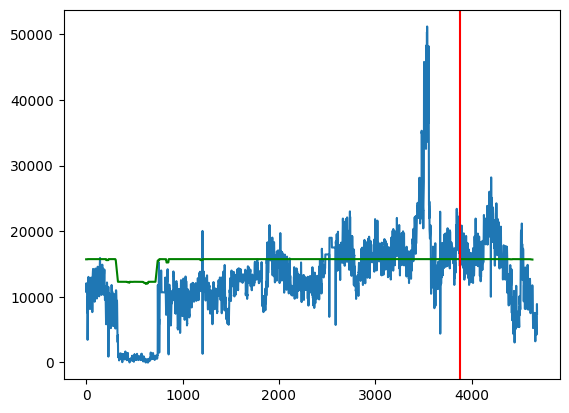

In [ ]:
%matplotlib inline

loss = history.history['loss']
plt.plot(loss, label='Training loss')
plt.legend()

plt.show()



trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict.mean(axis=1), testPredict.mean(axis=1)),axis=0)

plt.plot(df_jim['total'])
plt.plot(predicted, c='g')
plt.axvline(len(trainX), c="r")
plt.show()